### Newsbot to write a daily AI news summary using LangGraph
- Save a list of HTML files from sources.yaml (tech news sites)
- Extract URLs for the news stories
- Filter URLs for non-AI articles (using a ChatGPT prompt)
- Also remove duplicates/seen before, (match URL or title+domain, or 90% cosine similarity of normalized text)
- Summarize downloaded artcles, perform topic analysis via prompts (vs. traditional NMF or LDA, is zero-shot w/o training and also should have deep semantic understanding)
- Rerank and filter the articles for quality, recency, site reputation, dedupe again for similarity to other articles and keep highest ranked
- Send top articles by max marginal relevance to a large prompt
- Use a loop to polish and email the summary
- Used to generate a daily newsletter at skynetandchill.beehiiv.com and potentially an autogenerated podcast

Possible TODOs:
- could use a more agentic pattern, this is more prompt chaining than a proper agent
  - use OpenAI agents SDK instead of langgraph
  - make each step in the diagram a tool, make a high level coordinating tool with a prompt explaining the sequence of the workflow
  - make different steps independent agents as part of a multi-agent workflow.
  - implement proper critic-optimizer loop logic

- write currently uses a complex prompt with all the stories instead
  - maybe write each section independently, assemble all the sections and rewrite using a critic-refine flow

- do more evals with promptfoo, promptlayer, do prompt optimization with eg dspy or your own algo

- must retrain dimensionality reduction, identify a good number of dimensions using silhouette score

- make a UI that allows stepping through the graph using a wizard workflow, editing the state at each step (vars, markdown, dataframes), using time travel to go backwards and forwards.

update umap dimensionality reduction module

1. gather at least 2500 unique stories, do first 80% of days = train, rest = xval
2. run current cluster model in test, number of clusters, stories clustered and silhouette score
3. retrain current cluster params in train , run in test, collect data
4. train new cluster model on full headline + topics + summary, iterate over hyperparameters, gather scores
5. if headlines only are close , possibly retrain with xval on headlines only
6. output silhouette scores daily as part of the process 
7. could refactor the SQLite database, it got a bit messy

In [1]:
# to selectively re-import as needed
import sys
# del sys.modules['ainewsbot.state']
# del sys.modules['ainewsbot.llm']
# del sys.modules['ainewsbot.config']
# del sys.modules['ainewsbot.prompts']
# del sys.modules['ainewsbot.utilities']
# del sys.modules['ainewsbot.scrape']
# del sys.modules['ainewsbot.agent']
# del sys.modules['ainewsbot.AInewsbot']



In [2]:
import os
import shutil
# import dotenv
# import subprocess

from collections import Counter
import json
import uuid
import re
# import operator
import pickle
from datetime import datetime, timedelta

import langchain
from langchain_openai import ChatOpenAI
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_anthropic import ChatAnthropic

from langchain_core.messages import SystemMessage, HumanMessage
from langchain_core.prompts import (ChatPromptTemplate, PromptTemplate,
                                    SystemMessagePromptTemplate, HumanMessagePromptTemplate)
from langchain_core.output_parsers import StrOutputParser, PydanticOutputParser

from langgraph.checkpoint.memory import MemorySaver
from langgraph.checkpoint.sqlite import SqliteSaver
from langgraph.checkpoint.sqlite.aio import AsyncSqliteSaver
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.errors import NodeInterrupt
from langchain.globals import set_debug

import numpy as np
import pandas as pd
import umap

import sklearn

import bs4

from tenacity import (
    retry,
    stop_after_attempt,
    wait_exponential,
    retry_if_exception_type
)

import asyncio
from asyncio import Semaphore

from IPython.display import HTML, Image, Markdown, display

# import pyperclip
# import shlex

import openai
from openai import OpenAI

from pydantic import BaseModel, Field
from typing import List, TypedDict, Annotated, Any

from google.cloud import aiplatform
from vertexai.language_models import TextGenerationModel
import google.generativeai as genai
import httpx

import trafilatura   # web scrape uses this to get clean news stories w/o a lot of js and boilerplate

from ainewsbot.prompts import (
                        REWRITE_SYSTEM_PROMPT, REWRITE_USER_PROMPT,
                        SUMMARIZE_SYSTEM_PROMPT, SUMMARIZE_USER_PROMPT
                       )

from ainewsbot.utilities import log

from ainewsbot.agent import (Agent, AgentState, initialize_agent,
                                )


import podcastfy
from podcastfy.client import generate_podcast, process_content

from IPython.display import Audio, display, Markdown

import pdb

# need this to run async in jupyter since it already has an asyncio event loop running
import asyncio
import nest_asyncio
nest_asyncio.apply()

# Activate global verbose logging
set_debug(False)


# disable 'show more outputs' nonsense
from IPython.core.interactiveshell import InteractiveShell

# Always display all outputs in a cell
InteractiveShell.ast_node_interactivity = "all"

In [3]:
print(f"Python            {sys.version}")
print(f"LangChain         {langchain.__version__}")
print(f"OpenAI            {openai.__version__}")
# print(f"smtplib           {smtplib.sys.version}")
print(f"trafilatura       {trafilatura.__version__}")
# print(f"bs4               {bs4.__version__}")
print(f"numpy             {np.__version__}")
print(f"pandas            {pd.__version__}")
print(f"sklearn           {sklearn.__version__}")
print(f"umap              {umap.__version__}")
print(f"podcastfy         {podcastfy.__version__}")


Python            3.11.11 (main, Dec 11 2024, 10:25:04) [Clang 14.0.6 ]
LangChain         0.3.19
OpenAI            1.64.0
trafilatura       2.0.0
numpy             1.26.4
pandas            2.2.3
sklearn           1.6.1
umap              0.5.7
podcastfy         0.4.1


# Instantiate agent and run LangGraph workflow graph end to end

2025-06-16 12:14:04,763 - AInewsbot - INFO - Initializing with before_date=2025-06-15 18:00, do_download=False, thread_id=036f9df5665d4bdfb00b7ede56e47c66
2025-06-16 12:14:04,855 - AInewsbot - INFO - thread_id: 036f9df5665d4bdfb00b7ede56e47c66


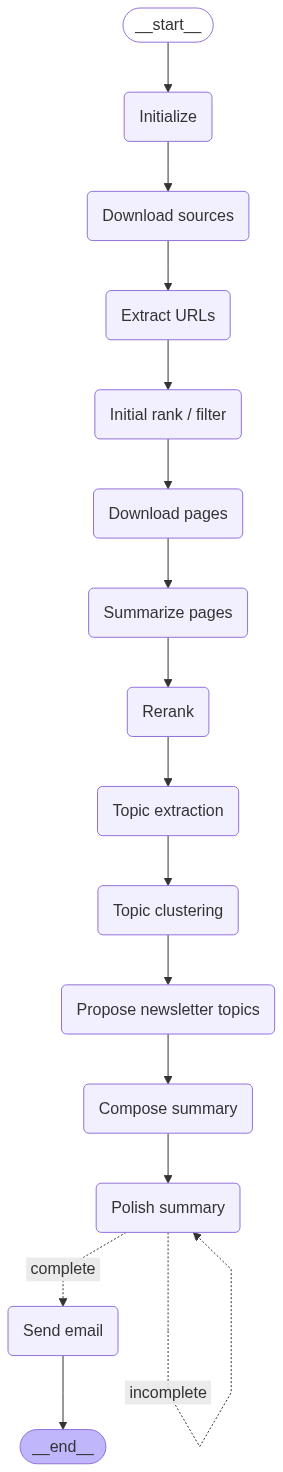

In [4]:
# before_date = None
before_date = '2025-06-15 18:00'
do_download = False

# o3 and o3-mini are trained for high STEM comprehension - would use these if cost no object
# o3 is best but super expensive
# o4-mini probably best cost/performance for final writing, reasonably priced reasoning model
# gpt-4.1 and 4.1-mini for complex and simpler agentic stuff respectively
# uses structured output with JSON schema to ensure proper structure and formatting
# https://cookbook.openai.com/examples/partners/model_selection_guide/model_selection_guide#appendices
# https://openai.com/api/pricing/

# low, medium, high models
ml, mm, mh = 'gpt-4.1-mini', 'gpt-4.1-mini', 'o4-mini'
# ml, mm, mh = 'models/gemini-2.0-flash', 'models/gemini-1.5-pro-latest', 'models/gemini-2.0-flash-thinking-exp'

lg_state, lg_agent, thread_id = initialize_agent(ml,
                                                 mm,
                                                 mh,
                                                 do_download,
                                                 before_date,
                                                 max_edits=2,
                                                 n_browsers=12)
log(f"thread_id: {thread_id}")

display(Image(lg_agent.graph.get_graph().draw_mermaid_png()))

In [5]:
config = {"configurable": {"thread_id": thread_id}}
state = lg_agent.run(lg_state, config)


2025-06-16 12:14:05,013 - AInewsbot - INFO - run exception
2025-06-16 12:14:05,013 - AInewsbot - INFO - 'src'
2025-06-16 12:14:05,017 - AInewsbot - INFO - Initialized 17 items in sources from sources.yaml
2025-06-16 12:14:05,018 - AInewsbot - INFO - Ars Technica -> https://arstechnica.com/ai/ -> Ars_Technica.html
2025-06-16 12:14:05,018 - AInewsbot - INFO - Bloomberg -> https://www.bloomberg.com/ai -> Bloomberg.html
2025-06-16 12:14:05,018 - AInewsbot - INFO - Business Insider -> https://www.businessinsider.com/tech -> Business_Insider.html
2025-06-16 12:14:05,018 - AInewsbot - INFO - FT -> https://www.ft.com/technology -> FT.html
2025-06-16 12:14:05,018 - AInewsbot - INFO - Feedly AI -> https://feedly.com/i/aiFeeds?options=eyJsYXllcnMiOlt7InBhcnRzIjpbeyJpZCI6Im5scC9mL3RvcGljLzMwMDAifV0sInNlYXJjaEhpbnQiOiJ0ZWNobm9sb2d5IiwidHlwZSI6Im1hdGNoZXMiLCJzYWxpZW5jZSI6ImFib3V0In1dLCJidW5kbGVzIjpbeyJ0eXBlIjoic3RyZWFtIiwiaWQiOiJ1c2VyLzYyZWViYjlmLTcxNTEtNGY5YS1hOGM3LTlhNTdiODIwNTMwOC9jYXRlZ29yeS9HYW

2025-06-16 12:14:05,488 - AInewsbot - INFO - The Verge -> download_sources/The_Verge.html
2025-06-16 12:14:05,518 - AInewsbot - INFO - parse_file - found 221 raw links
2025-06-16 12:14:05,521 - AInewsbot - INFO - parse_file - found 21 filtered links
2025-06-16 12:14:05,521 - AInewsbot - INFO - 21 links found
2025-06-16 12:14:05,521 - AInewsbot - INFO - VentureBeat -> download_sources/VentureBeat.html
2025-06-16 12:14:05,537 - AInewsbot - INFO - parse_file - found 342 raw links
2025-06-16 12:14:05,540 - AInewsbot - INFO - parse_file - found 45 filtered links
2025-06-16 12:14:05,540 - AInewsbot - INFO - 45 links found
2025-06-16 12:14:05,540 - AInewsbot - INFO - WSJ -> download_sources/WSJ.html
2025-06-16 12:14:05,560 - AInewsbot - INFO - parse_file - found 121 raw links
2025-06-16 12:14:05,562 - AInewsbot - INFO - parse_file - found 26 filtered links
2025-06-16 12:14:05,562 - AInewsbot - INFO - 26 links found
2025-06-16 12:14:05,562 - AInewsbot - INFO - Washington Post -> download_sourc

,id
src,
Ars Technica,31
Bloomberg,26
Business Insider,21
FT,53
Feedly AI,111
Hacker News 1,24
Hacker News 2,25
HackerNoon,27
New York Times,18


2025-06-16 12:14:05,909 - AInewsbot - INFO - Querying SQLite with where_clause: WHERE timestamp < '2025-06-15 18:00'
2025-06-16 12:14:06,682 - AInewsbot - INFO - URLs in orig_df: 856
2025-06-16 12:14:06,685 - AInewsbot - INFO - Existing URLs in DB: 275897
2025-06-16 12:14:06,736 - AInewsbot - INFO - New URLs in df filtered by URL: 307
2025-06-16 12:14:06,886 - AInewsbot - INFO - Existing src+title: 31
2025-06-16 12:14:06,887 - AInewsbot - INFO - New URLs in df filtered by src+title: 276
2025-06-16 12:14:06,902 - AInewsbot - INFO - Found 274 unique new headlines
2025-06-16 12:14:06,904 - AInewsbot - INFO - Found 271 unique cleaned new headlines
2025-06-16 12:14:10,742 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 12:14:14,536 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 12:14:14,993 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HT

,id
src,
Bloomberg,2
Business Insider,4
FT,2
Feedly AI,87
Hacker News 1,2
Hacker News 2,7
HackerNoon,1
New York Times,2
NewsAPI,12


2025-06-16 12:14:20,027 - AInewsbot - INFO - Queuing URLs for scraping
2025-06-16 12:14:20,030 - AInewsbot - INFO - Saving HTML files using async concurrency= 12
2025-06-16 12:14:20,375 - AInewsbot - INFO - Launching browser
2025-06-16 12:14:21,876 - AInewsbot - INFO - Launching workers
2025-06-16 12:14:21,877 - AInewsbot - INFO - Launching worker
2025-06-16 12:14:21,877 - AInewsbot - INFO - from queue: 0, https://www.blogger.com/comment/fullpage/post/26204193/2945790034495269182 , "Rebecca's Song" -- A Family History Poem, Song and Podcast Created by Artificial Intelligence
2025-06-16 12:14:21,877 - AInewsbot - INFO - fetch_url(https://www.blogger.com/comment/fullpage/post/26204193/2945790034495269182)
2025-06-16 12:14:21,879 - AInewsbot - INFO - File already exists: download_html/Rebecca_s_Song__--_A_Family_History_Poem__Song_and_Podcast_Created_by_Artificial_Intelligence.html
2025-06-16 12:14:21,879 - AInewsbot - INFO - from queue: 1, https://news.google.com/rss/articles/CBMijgFBVV9

2025-06-16 12:14:21,904 - AInewsbot - INFO - File already exists: download_html/5_Prompts_That_Make_Anthropic_s_Claude_AI_Better_Than_a_Crypto_Analyst__Broker_or_Doctor.html
2025-06-16 12:14:21,904 - AInewsbot - INFO - from queue: 9, https://www.zdnet.com/article/7-trends-shaping-digital-transformation-in-2025-and-ai-looms-large/ , 7 trends shaping digital transformation in 2025 - and AI looms large
2025-06-16 12:14:21,904 - AInewsbot - INFO - fetch_url(https://www.zdnet.com/article/7-trends-shaping-digital-transformation-in-2025-and-ai-looms-large/)
2025-06-16 12:14:21,904 - AInewsbot - INFO - File already exists: download_html/7_trends_shaping_digital_transformation_in_2025_-_and_AI_looms_large.html
2025-06-16 12:14:21,905 - AInewsbot - INFO - from queue: 10, https://www.bloomberg.com/news/newsletters/2025-06-15/wwdc-2025-biggest-releases-ipados-26-multitasking-visionos-26-and-new-carplay-mbxm63s2 , A look at Apple's upgrades to CarPlay, iPadOS, and visionOS, why they were the undera

2025-06-16 12:14:21,993 - AInewsbot - INFO - fetch_url(https://news.google.com/rss/articles/CBMigAFBVV95cUxOU3NrTHVvQWlHekFxVGhhMXZET3hsTGN0NzlQNGRYdlpBQUczUXA3amNUeFJxZWFGYnhVZHkza2lrV0JpbjdGZ1lqbjBMMS1rMUdua2gzZzdva0tiMV9tQW83UUlNYVZvQ2M1VHFucVI2ZEp4SVBVLTBjMjNmOHhzbw)
2025-06-16 12:14:21,995 - AInewsbot - INFO - File already exists: download_html/AI_race_between_US_and_China_resembles_Cold_War__Marc_Andreessen.html
2025-06-16 12:14:21,995 - AInewsbot - INFO - from queue: 23, https://onefootball.com/en/news/ai-takes-on-the-paul-the-octopus-role-who-wins-tomorrow-predictions-41249116 ,  AI takes on the Paul the Octopus role: who wins tomorrow? Predictions 
2025-06-16 12:14:21,996 - AInewsbot - INFO - fetch_url(https://onefootball.com/en/news/ai-takes-on-the-paul-the-octopus-role-who-wins-tomorrow-predictions-41249116)
2025-06-16 12:14:22,026 - AInewsbot - INFO - Launching worker
2025-06-16 12:14:22,027 - AInewsbot - INFO - from queue: 24, https://news.google.com/rss/articles/CBMipwFBV

2025-06-16 12:14:22,035 - AInewsbot - INFO - fetch_url(https://machinelearningmastery.com/advanced-feature-engineering-using-scikit-learn-pipelines-with-pandas-columntransformer-and-numpy-arrays/)
2025-06-16 12:14:22,066 - AInewsbot - INFO - Launching worker
2025-06-16 12:14:22,067 - AInewsbot - INFO - from queue: 33, https://news.google.com/rss/articles/CBMiwAFBVV95cUxQMURSWGFOQVpYVGd4M2FwbXppRGNQMEJyUVBjRkRQS3JlWjVQSTJnV2R4UXo0d0puekNfNmRZUnh4cEN6bExDa3YydFVuSlJFakh3WXZUaEFNcGd0cHVYclB5RmN2RGd4dlh3dzVwcTRqTzFabV9IUkotRHRqVUhPSy1xVTJTX05uMmZCQkgtV1gxUDQ1Si1ZZ2d1cXU3d1BIRUQzRVZkVkFvNV85Qk9qR3ZjUjc1Y2VWX2ZnX2tzMlc , Amazon Spending $13 Billion To Build AI-Powered Data Centers In Australia
2025-06-16 12:14:22,068 - AInewsbot - INFO - fetch_url(https://news.google.com/rss/articles/CBMiwAFBVV95cUxQMURSWGFOQVpYVGd4M2FwbXppRGNQMEJyUVBjRkRQS3JlWjVQSTJnV2R4UXo0d0puekNfNmRZUnh4cEN6bExDa3YydFVuSlJFakh3WXZUaEFNcGd0cHVYclB5RmN2RGd4dlh3dzVwcTRqTzFabV9IUkotRHRqVUhPSy1xVTJTX05uMmZCQkgtV1gxUDQ1Si1ZZ2d

2025-06-16 12:14:22,079 - AInewsbot - INFO - from queue: 43, https://economictimes.indiatimes.com/tech/artificial-intelligence/chatgpt-took-on-a-50-year-old-atari-and-lost/articleshow/121863256.cms , ChatGPT took on a 50-year-old Atari  and lost
2025-06-16 12:14:22,079 - AInewsbot - INFO - fetch_url(https://economictimes.indiatimes.com/tech/artificial-intelligence/chatgpt-took-on-a-50-year-old-atari-and-lost/articleshow/121863256.cms)
2025-06-16 12:14:22,080 - AInewsbot - INFO - File already exists: download_html/ChatGPT_took_on_a_50-year-old_Atari__and_lost.html
2025-06-16 12:14:22,080 - AInewsbot - INFO - from queue: 44, https://www.nature.com/articles/s41557-025-01815-x , Chemical knowledge and reasoning of large language models vs. chemist expertise
2025-06-16 12:14:22,081 - AInewsbot - INFO - fetch_url(https://www.nature.com/articles/s41557-025-01815-x)
2025-06-16 12:14:22,082 - AInewsbot - INFO - File already exists: download_html/Chemical_knowledge_and_reasoning_of_large_languag

2025-06-16 12:14:22,119 - AInewsbot - INFO - fetch_url(https://news.google.com/rss/articles/CBMinAFBVV95cUxPOVFyc3VQTEpkS19ySkZOVmtxRWZpSVlZNlZoQml0cHFNZ1JfeHp2amdBUmNoZXJGRG9VUjk4aUNjR1lPalNydzhpZ09CNUItdC1QUTBKdVVPU0dBVGsyQXVJdER5VktXX2JlYmVvNnNkZVoyeEp3ZnFpU3pDVExBbEl3eXZ0MDZZZWEzeXpwZ3F1eTlyNUFYYUZVY1E)
2025-06-16 12:14:22,120 - AInewsbot - INFO - File already exists: download_html/EXL_exec_Nasasimha_Kini_on_how_AI_can_supercharge_growth.html
2025-06-16 12:14:22,120 - AInewsbot - INFO - from queue: 58, https://news.google.com/rss/articles/CBMiogFBVV95cUxOcEdDRVBNa0JFZ2xkUnRabkxOdkxxQVZJSE9lb3I4OFducDNacmlueXpaTkx4ZHZNdU44MXhQNDlEd0VLb3Y0RUlqYXUxcEJFVXhlVkF4MjlWSTRjQ2N1N1I2X2pmcEdpaVFIUzkxLXhGaWh6aUVOeURXREc1QUZKa1RyVUJTR19sNzg0a0tTV0sxYzY2bXpIRDlCX0NYVnprYUE , Ellipsis Health raises $45 million for emotionally intelligent AI healthcare
2025-06-16 12:14:22,120 - AInewsbot - INFO - fetch_url(https://news.google.com/rss/articles/CBMiogFBVV95cUxOcEdDRVBNa0JFZ2xkUnRabkxOdkxxQVZJSE9lb3I4

2025-06-16 12:14:22,142 - AInewsbot - INFO - File already exists: download_html/Friction_Is_The_Point__What_AI_Will_Never_Understand_About_Being_Human.html
2025-06-16 12:14:22,142 - AInewsbot - INFO - from queue: 69, https://news.google.com/rss/articles/CBMicEFVX3lxTE53TzR3VTVIU1lfVXdtRktIS2kwRTVCa0t2VWFlUFpNRnB3Xzgwb00xM3Yyb2VYdjhDOTdYQVpxZVhHSFMzWFZyeC1Dc00tY2pqcmNKeFNHQ1NoUkdmX29fTnEyTHhVcDctV0p0ZFl6YXg , Google experiments with AI-generated podcast hosts in search results
2025-06-16 12:14:22,143 - AInewsbot - INFO - fetch_url(https://news.google.com/rss/articles/CBMicEFVX3lxTE53TzR3VTVIU1lfVXdtRktIS2kwRTVCa0t2VWFlUFpNRnB3Xzgwb00xM3Yyb2VYdjhDOTdYQVpxZVhHSFMzWFZyeC1Dc00tY2pqcmNKeFNHQ1NoUkdmX29fTnEyTHhVcDctV0p0ZFl6YXg)
2025-06-16 12:14:22,143 - AInewsbot - INFO - File already exists: download_html/Google_experiments_with_AI-generated_podcast_hosts_in_search_results.html
2025-06-16 12:14:22,144 - AInewsbot - INFO - from queue: 70, https://news.google.com/rss/articles/CBMimAFBVV95cUxNQn

2025-06-16 12:14:22,159 - AInewsbot - INFO - fetch_url(https://www.businessinsider.com/i-took-chaotic-robotaxi-ride-through-london-impressive-one-question-2025-6)
2025-06-16 12:14:22,159 - AInewsbot - INFO - File already exists: download_html/I_took_a_chaotic__surreal_robotaxi_ride_through_central_London._It_left_me_impressed__but_with_one_big_question..html
2025-06-16 12:14:22,159 - AInewsbot - INFO - from queue: 78, https://www.infodata.ilsole24ore.com/2025/06/15/il-divario-tra-uomini-e-chatbot-si-sta-riducendo-e-in-fretta/ , Il divario tra uomini e chatbot si sta riducendo, e in fretta
2025-06-16 12:14:22,159 - AInewsbot - INFO - fetch_url(https://www.infodata.ilsole24ore.com/2025/06/15/il-divario-tra-uomini-e-chatbot-si-sta-riducendo-e-in-fretta/)
2025-06-16 12:14:22,160 - AInewsbot - INFO - File already exists: download_html/Il_divario_tra_uomini_e_chatbot_si_sta_riducendo__e_in_fretta.html
2025-06-16 12:14:22,160 - AInewsbot - INFO - from queue: 79, https://www.bloomberg.com/news

2025-06-16 12:14:22,170 - AInewsbot - INFO - File already exists: download_html/Machine_learning_on_blockchain__A_new_approach_to_engineering_computational_security___Newswise.html
2025-06-16 12:14:22,170 - AInewsbot - INFO - from queue: 88, https://www.bloomberg.com/news/articles/2025-06-16/meta-investors-cheer-as-zuckerberg-doubles-down-on-ai-commitment , Meta Investors Cheer as Zuckerberg Doubles Down on AI Commitment
2025-06-16 12:14:22,170 - AInewsbot - INFO - Skipping fetch for 88 https://www.bloomberg.com/news/articles/2025-06-16/meta-investors-cheer-as-zuckerberg-doubles-down-on-ai-commitment Meta Investors Cheer as Zuckerberg Doubles Down on AI Commitment
2025-06-16 12:14:22,171 - AInewsbot - INFO - from queue: 89, https://news.google.com/rss/articles/CBMixgFBVV95cUxOZTdWckJXOWNoR3RfaEdVSjhwVktpY0ZoQnE2QWtCWFE2aE04eURCcGVyYWpCSEMxLU9HNTNSbjBzTnJneEFhdGNkYWZER0JLLVYtM3RONVRJX0NEck5yeEFEaWlRUUNUNHctSVRkcVktWFVnRUVmaGFMRWduU3AyRDI4SS1iaVNrLUl6bS1LQ25ndk1ZZVpUd0pQOGFyTHBhcG4xMF8yM

2025-06-16 12:14:22,184 - AInewsbot - INFO - fetch_url(https://www.theregister.com/2025/06/16/opinion_column_lrm/)
2025-06-16 12:14:22,185 - AInewsbot - INFO - File already exists: download_html/Put_Large_Reasoning_Models_under_pressure_and_they_stop_making_sense__say_boffinsOpinionAny_sufficiently_advanced_technology_is_indistinguishable_from_magic._Not_a_problem_with_AI_hypeAI___ML3_hrs_14.html
2025-06-16 12:14:22,186 - AInewsbot - INFO - from queue: 99, https://news.google.com/rss/articles/CBMimgFBVV95cUxQNFBwRlhEZkhiYzhxRnVTMzNJcGthZlFNZzdIeXkydHpzYlljR0JUcDA4Wk51VnFrd1J5cEZzaVdFMTBBZXExdF9tWU12NGp1MEFSUUpqeF9ZLUVmUDFQMEFhY2h6NVhLYXg0bl9WTWNya2xmT2Z0WWxsX0hUeURtR0NWR3JBcHp0RDQtTWFSbjNJRGhtdG5HNVlB , Qualtrics targets action gap with new AI copilot
2025-06-16 12:14:22,186 - AInewsbot - INFO - fetch_url(https://news.google.com/rss/articles/CBMimgFBVV95cUxQNFBwRlhEZkhiYzhxRnVTMzNJcGthZlFNZzdIeXkydHpzYlljR0JUcDA4Wk51VnFrd1J5cEZzaVdFMTBBZXExdF9tWU12NGp1MEFSUUpqeF9ZLUVmUDFQMEFhY2h6NVhLYX

2025-06-16 12:14:22,198 - AInewsbot - INFO - fetch_url(https://hackernoon.com/the-real-cost-of-relying-on-ai-in-a-lonely-america)
2025-06-16 12:14:22,199 - AInewsbot - INFO - File already exists: download_html/The_Real_Cost_of_Relying_on_AI_in_a_Lonely_America.html
2025-06-16 12:14:22,200 - AInewsbot - INFO - from queue: 110, https://hackernoon.com/6-16-2025-techbeat , The TechBeat: Why The Future of AI Organization Looks More Like Open-Source Software Than Corporate Bureaucracy (6/16/2025)
2025-06-16 12:14:22,200 - AInewsbot - INFO - fetch_url(https://hackernoon.com/6-16-2025-techbeat)
2025-06-16 12:14:22,202 - AInewsbot - INFO - File already exists: download_html/The_TechBeat__Why_The_Future_of_AI_Organization_Looks_More_Like_Open-Source_Software_Than_Corporate_Bureaucracy__6_16_2025.html
2025-06-16 12:14:22,203 - AInewsbot - INFO - from queue: 111, https://www.fastcompany.com/91351325/the-debate-over-state-level-ai-bans-misses-the-point , The debate over state-level AI bans misses t

2025-06-16 12:14:22,217 - AInewsbot - INFO - fetch_url(https://news.google.com/rss/articles/CBMihwFBVV95cUxNMVJvcVZkbEgxQll6S2htcDZha2hpS3ktaWpKT3lXaW1YVmUyNTRZd2NoV1A5WUc0UFNVbjJFU2xCMXhVbnZVT1BiRHVfcUxxVGxfNXJkQUtLbHEyQ01iYmVyZF9lX1hyeWtBOE80b3NZQzBBZHAxMll6eFZJUXh0WVJHM2FBRWs)
2025-06-16 12:14:22,218 - AInewsbot - INFO - File already exists: download_html/Warren_Buffett_Has__90_Billion_Invested_in_These_9Artificial_Intelligence_AI__Stocks._Here_s_the_Best_of_the_Bunch..html
2025-06-16 12:14:22,218 - AInewsbot - INFO - from queue: 124, https://news.google.com/rss/articles/CBMiigFBVV95cUxNX0F6MHl1cENORVNqRzR5MnBTeVZnZ1lkeHZ1dTNFVmJfcVczUWxldFJyNUdvRnFXNWRkc2IxLTZ6RGc5TFJlN3RPbXBZaEdMdU9HR1ZpZ052MnFBYjZ4SWU5ZXd3OV9RZVNoOWFKRTVkM3lRV1M2bDVDbzM2YlQ2WXE1OGRKOGZYNHc , Where AI skills are needed most
2025-06-16 12:14:22,219 - AInewsbot - INFO - fetch_url(https://news.google.com/rss/articles/CBMiigFBVV95cUxNX0F6MHl1cENORVNqRzR5MnBTeVZnZ1lkeHZ1dTNFVmJfcVczUWxldFJyNUdvRnFXNWRkc2IxLTZ6RGc5TFJlN

2025-06-16 12:14:48,134 - AInewsbot - INFO - Found script last updated time from script datePublished: 2025-06-15T11:31:49-04:00
2025-06-16 12:14:48,134 - AInewsbot - INFO - Saving HTML to download_html/AI_Forces_Leaders_To_Rediscover_The_Missing_Humanistic_Component.html
2025-06-16 12:14:58,228 - AInewsbot - INFO - Found last updated time from meta tag property=article:published_time: 2025-06-15T16:42:29Z
2025-06-16 12:14:58,229 - AInewsbot - INFO - Saving HTML to download_html/AI_child_sexual_abuse_material_to_be_criminalised_under_new_EU_laws__says_Irish_MEP.html
2025-06-16 12:14:58,244 - AInewsbot - INFO - Finishing and closing browser
2025-06-16 12:14:58,461 - chromadb.telemetry.product.posthog - INFO - Anonymized telemetry enabled. See                     https://docs.trychroma.com/telemetry for more information.
2025-06-16 12:14:58,745 - AInewsbot - INFO - clean_html - Page title: Post a Comment

2025-06-16 12:14:59,339 - httpx - INFO - HTTP Request: POST https://api.openai.com/

2025-06-16 12:15:05,787 - AInewsbot - INFO - Saving text to download_text/2025-06-16/A.I._Is_Poised_to_Rewrite_History._Literally..txt
2025-06-16 12:15:05,788 - AInewsbot - INFO - File  does not exist
2025-06-16 12:15:05,803 - AInewsbot - INFO - clean_html - Page title: AI Uncovers Wild Spin of the Milky Way’s Supermassive Black Hole
Social card title: AI Uncovers Wild Spin of the Milky Way’s Supermassive Black Hole
Social card description: Using millions of simulations and AI, astronomers discovered the Milky Way’s black hole spins near top speed. The breakthrough, supported by four decades of distributed computing innovation, hints at magnetic behaviors that contradict long-held theories. AI Peers Into the Heart of the Milky Way

2025-06-16 12:15:06,235 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-06-16 12:15:06,296 - AInewsbot - INFO - Saving text to download_text/2025-06-16/AI_Uncovers_Wild_Spin_of_the_Milky_Ways_Supermassive_Black

2025-06-16 12:15:13,981 - AInewsbot - INFO - clean_html - Page title: [2506.08872] Your Brain on ChatGPT: Accumulation of Cognitive Debt when Using an AI Assistant for Essay Writing Task
Social card title: Your Brain on ChatGPT: Accumulation of Cognitive Debt when Using an AI Assistant for Essay Writing Task
Social card description: This study explores the neural and behavioral consequences of LLM-assisted essay writing. Participants were divided into three groups: LLM, Search Engine, and Brain-only (no tools). Each completed three sessions under the same condition. In a fourth session, LLM users were reassigned to Brain-only group (LLM-to-Brain), and Brain-only users were reassigned to LLM condition (Brain-to-LLM). A total of 54 participants took part in Sessions 1-3, with 18 completing session 4. We used electroencephalography (EEG) to assess cognitive load during essay writing, and analyzed essays using NLP, as well as scoring essays with the help from human teachers and an AI judge

2025-06-16 12:15:19,851 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-06-16 12:15:19,907 - AInewsbot - INFO - Saving text to download_text/2025-06-16/Berlin-based_Knowunity__an_AI-powered_learning_platform_with_20M__users_in_15_countries__raised_a_27M_Series_B_led_by_XAnge__bringing_its_total_funding_to_45M__Tamara_Djurickovic_Tech.eu.txt
2025-06-16 12:15:19,957 - AInewsbot - INFO - clean_html - Page title: Billionaires Are Selling Nvidia and Betting on This AI Stock That's Climbed Nearly 300% Over the Past 3 Years
Social card title: Billionaires Are Selling Nvidia and Betting on This AI Stock That's Climbed Nearly 300% Over the Past 3 Years
Social card description: Artificial intelligence chip designer Nvidia has been popular among billionaires in recent years, and its stock has soared more than 1,000%.  Now, some of these billionaires are looking to another company that's investing significantly in AI.  Nvidia (NASDAQ: NVDA) has been 

2025-06-16 12:15:23,786 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-06-16 12:15:23,842 - AInewsbot - INFO - Saving text to download_text/2025-06-16/DIY_world_according_to_ChatGPT.txt
2025-06-16 12:15:23,864 - AInewsbot - INFO - clean_html - Page title: Unglamorous world of 'data infrastructure' driving hot tech M&A market in AI race | Reuters
Social card title: Unglamorous world of 'data infrastructure' driving hot tech M&A market in AI race
Social card description: Weighed down by tariffs and geopolitical uncertainty, dealmaking has slowed to a crawl across most industries except one: the unglamorous world of data infrastructure.

2025-06-16 12:15:24,143 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-06-16 12:15:24,204 - AInewsbot - INFO - Saving text to download_text/2025-06-16/Dealogic__tech_deals_accounted_for__421B_of_the__1.67T_in_global_deals_announced_in_the_first_five_months_of

2025-06-16 12:15:30,749 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-06-16 12:15:30,798 - AInewsbot - INFO - Skipping download_html/Fake_Bands_and_Artificial_Songs_are_Taking_Over_YouTube_and_Spotify.html as it is too similar to an existing document
2025-06-16 12:15:30,808 - AInewsbot - INFO - clean_html - Page title: Fake bands and artificial songs are taking over YouTube and Spotify | Culture | EL PAÍS English
Social card title: Fake bands and artificial songs are taking over YouTube and Spotify
Social card description: AI-generated songs have made their way onto streaming services and it’s not just ambient or electronic music: fake bands, be they rock, salsa, or jazz, are also abundant

2025-06-16 12:15:31,125 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-06-16 12:15:31,222 - AInewsbot - INFO - Skipping download_html/Fake_bands_and_artificial_songs_are_taking_over_YouTube_and_Spotify

2025-06-16 12:15:38,474 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-06-16 12:15:38,549 - AInewsbot - INFO - Saving text to download_text/2025-06-16/I_bring_healthcare_to_people_s_homes_in_Singapore._AI_is_changing_home_care__but_it_can_t_replace_clinicians..txt
2025-06-16 12:15:38,573 - AInewsbot - INFO - clean_html - Page title: I Tried a Wayve Robotaxi in London. It Was Chaotic but Impressive. - Business Insider
Social card title: I took a chaotic, surreal robotaxi ride through central London. It left me impressed, but with one big question.
Social card description: During a ride through London with Wayve's CEO, Business Insider encountered a number of unexpected hazards that the car handled with ease.

2025-06-16 12:15:38,944 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-06-16 12:15:39,038 - AInewsbot - INFO - Saving text to download_text/2025-06-16/I_took_a_chaotic__surreal_robotax

2025-06-16 12:15:43,330 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-06-16 12:15:43,400 - AInewsbot - INFO - Saving text to download_text/2025-06-16/Meta_takes_AI_firm_behind_nudify_apps_to_court_over_ads_on_Facebook__Instagram.txt
2025-06-16 12:15:43,414 - AInewsbot - INFO - clean_html - Page title: Exclusive: Zorro clinches $20M Series A for ICHRA health plans
Social card title: Exclusive: Zorro clinches $20M Series A for ICHRA health plans
Social card description: As employers wrestle with rising costs, the group plan alternative is gaining steam.

2025-06-16 12:15:43,664 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-06-16 12:15:43,733 - AInewsbot - INFO - Saving text to download_text/2025-06-16/NYC-based_Zorro__whose_AI-powered_software_helps_clients__workers_navigate_health_insurance_and_benefits_options__raised_a__20M_Series_A_led_by_Entree_Capital.txt
2025-06-16 12:15:43,747 - AI

2025-06-16 12:15:48,990 - AInewsbot - INFO - clean_html - Page title: Snowflake and Acxiom Announce Plans to Transform AI-Powered Marketing for Brands and Agencies
Social card title: Snowflake and Acxiom Announce Plans to Transform AI-Powered Marketing for Brands and Agencies
Social card description: Snowflake (NYSE: SNOW), the AI Data Cloud company, and Acxiom® , the connected data and technology foundation of Interpublic Group of Companies, Inc. (NYSE: ...

2025-06-16 12:15:49,430 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-06-16 12:15:49,512 - AInewsbot - INFO - Saving text to download_text/2025-06-16/Snowflake_and_Acxiom_Announce_Plans_to_Transform_AI-Powered_Marketing_for_Brands_and_Agencies.txt
2025-06-16 12:15:49,521 - AInewsbot - INFO - clean_html - Page title: Target Dial Sets a New Standard in AI Voice Automation,
Social card title: Target Dial Sets a New Standard in AI Voice Automation, Poised to Become Canada's Leading AI 

2025-06-16 12:15:54,610 - AInewsbot - INFO - Saving text to download_text/2025-06-16/The_key_to_Oracles_AI_future.txt
2025-06-16 12:15:54,612 - AInewsbot - INFO - clean_html - Page title: fastcompany.com

2025-06-16 12:15:54,613 - trafilatura.core - WARNING - discarding data: None
2025-06-16 12:15:55,288 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-06-16 12:15:55,477 - AInewsbot - INFO - Saving text to download_text/2025-06-16/The_new_jingle_for_Sam_Altmans_human_verification_service_will_get_stuck_in_your_very_human_brain.txt
2025-06-16 12:15:55,482 - AInewsbot - INFO - clean_html - Page title: the z80 technique reveals the source code for Atlassian's 'rovo' AI assistant
Social card title: the z80 technique reveals the source code for Atlassian's 'rovo' AI assistant
Social card description: Ever wondered what happens if you take the technique at "Can a LLM convert C, to ASM to specs and then to a working Z/80 Speccy tape? Yes." and ru

2025-06-16 12:16:02,573 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-06-16 12:16:02,657 - AInewsbot - INFO - Saving text to download_text/2025-06-16/Why_Claude_s_Comment_Paper_Is_a_Poor_Rebuttal.txt
2025-06-16 12:16:02,672 - AInewsbot - INFO - clean_html - Page title: Why Interactive Visuals Are the Next Big Thing in Software Collaboration | HackerNoon
Social card title: Why Interactive Visuals Are the Next Big Thing in Software Collaboration | HackerNoon
Social card description: Dynamic code visualizations boost onboarding, code reviews, and runtime diagnostics. Early user studies show strong promise for collaborative coding tools.

2025-06-16 12:16:03,067 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-06-16 12:16:03,134 - AInewsbot - INFO - Saving text to download_text/2025-06-16/Why_Interactive_Visuals_Are_the_Next_Big_Thing_in_Software_Collaboration.txt
2025-06-16 12:16:03,146 - AIne

2025-06-16 12:16:09,090 - AInewsbot - INFO - Saving text to download_text/2025-06-16/AI_child_sexual_abuse_material_to_be_criminalised_under_new_EU_laws__says_Irish_MEP.txt
2025-06-16 12:16:09,100 - AInewsbot - INFO - No missing site names
2025-06-16 12:16:09,101 - AInewsbot - INFO - Upserting text into ChromaDB with current datetime
2025-06-16 12:16:09,354 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-06-16 12:16:09,606 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-06-16 12:16:09,881 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-06-16 12:16:10,173 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-06-16 12:16:10,488 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-06-16 12:16:10,781 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/emb

2025-06-16 12:16:35,554 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-06-16 12:16:35,763 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-06-16 12:16:36,083 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-06-16 12:16:36,473 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-06-16 12:16:36,800 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-06-16 12:16:37,085 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-06-16 12:16:37,425 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-06-16 12:16:37,683 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-06-16 12:16:37,917 - httpx - INFO - HTTP Request: POST https://api.openai.c

,id
src,
Bloomberg,2
Business Insider,4
FT,2
Feedly AI,87
Hacker News 1,2
Hacker News 2,7
HackerNoon,1
New York Times,2
NewsAPI,12


2025-06-16 12:16:55,201 - AInewsbot - INFO - Starting summarize
2025-06-16 12:16:55,202 - AInewsbot - INFO - Fetching summaries for all articles
2025-06-16 12:16:55,202 - AInewsbot - INFO - Attempting to fetch summaries for 134 articles
2025-06-16 12:16:55,203 - AInewsbot - INFO - Queuing 0: Page title: Post a Comment
Comments on "Rebecca's ...
2025-06-16 12:16:55,204 - AInewsbot - INFO - Queuing 1: Page title: How a Whoop Product Leader Made AI a H...
2025-06-16 12:16:55,204 - AInewsbot - INFO - Queuing 2: Page title: ‘AI is a better programmer than me’: T...
2025-06-16 12:16:55,205 - AInewsbot - INFO - Queuing 3: Page title: ‘Life or death consequences’: AMA push...
2025-06-16 12:16:55,205 - AInewsbot - INFO - Queuing 4: Page title: 'Neuralink babies'? Scale AI’s Alexand...
2025-06-16 12:16:55,205 - AInewsbot - INFO - Queuing 5: Page title: 'Upskilling is the priority to harness...
2025-06-16 12:16:55,206 - AInewsbot - INFO - Queuing 6: Page title: 2025 Chief Officer Awards Winner: E

2025-06-16 12:16:55,229 - AInewsbot - INFO - Queuing 77: Page title: I Tried a Wayve Robotaxi in London. It...
2025-06-16 12:16:55,229 - AInewsbot - INFO - Queuing 78: Page title: Il divario tra uomini e chatbot si sta...
2025-06-16 12:16:55,230 - AInewsbot - INFO - No text_path for 79
2025-06-16 12:16:55,230 - AInewsbot - INFO - Queuing 80: Page title: Is ChatGPT about to kill the smartphon...
2025-06-16 12:16:55,230 - AInewsbot - INFO - Queuing 81: Page title: Jackson Hole Chamber Hosts AI Workshop...
2025-06-16 12:16:55,231 - AInewsbot - INFO - Queuing 82: Page title: Jersey and Guernsey leaders discuss AI...
2025-06-16 12:16:55,231 - AInewsbot - INFO - Queuing 83: Page title: Juvenescence Acquires Ro5 to Integrate...
2025-06-16 12:16:55,232 - AInewsbot - INFO - Queuing 84: Page title: Lately: AI vs. critical thinking, ‘dad...
2025-06-16 12:16:55,232 - AInewsbot - INFO - Queuing 85: Page title: Deputy national security, AI advisers ...
2025-06-16 12:16:55,233 - AInewsbot - INFO - Qu

2025-06-16 12:16:58,363 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 12:16:58,366 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 12:16:58,378 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 12:16:58,389 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 12:16:58,403 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 12:16:58,424 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 12:16:58,427 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 12:16:58,430 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 12:16:58,450 - httpx 

2025-06-16 12:16:59,985 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 12:17:00,010 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 12:17:00,024 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 12:17:00,033 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 12:17:00,041 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 12:17:00,060 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 12:17:00,077 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 12:17:00,080 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 12:17:00,138 - httpx 

2025-06-16 12:17:01,680 - AInewsbot - INFO - Summary for 6 (length 1463): - Pamela Rothka, CFO of Empower AI, won WashingtonExec’s 2025 Chief Officer Award for CFO of the Year (Private & Public Company, revenue $100M-$500M).
- The awards ceremony on June 4 in McLean, VA, recognized top executives in government contracting and honored Renato “Renny” DiPentima with a Lifetime Achievement Award for his impact on federal IT and contracting.
- The event attracted over 500 attendees and featured sponsorship from Govplace, KippsDeSanto & Co., Morgan Stanley, and others, highlighting record interest in this year’s awards.
2025-06-16 12:17:01,680 - AInewsbot - INFO - Summary for 7 (length 1213): - Artificial intelligence (AI) is a major focus on Wall Street, with over 40% of S&P 500 companies mentioning AI in their earnings calls for five consecutive quarters, according to FactSet Insight.  
- The article highlights three AI growth stocks considered "no-brainer" buys for investors looking to in

2025-06-16 12:17:01,684 - AInewsbot - INFO - Summary for 22 (length 2623): - Venture capitalist Marc Andreessen likened the current AI competition between the US and China to a Cold War, stating China aims to shape global society based on its values, while AI will serve as the "future control layer for everything" across various sectors.  
- Andreessen emphasized a preference for AI developed with American values over those aligned with the Chinese Communist Party, highlighting geopolitical stakes in AI supremacy.  
- Despite fears of AI risks, including impacts on employment, military conflicts, and democracy, tech leaders note AI is still far from artificial general intelligence (AGI), with continued debate over its societal implications.
2025-06-16 12:17:01,684 - AInewsbot - INFO - Summary for 23 (length 8566): - The requested webpage on OneFootball could not be found, resulting in a "Page Not Found" error message.  
- The page provides detailed information on cookie usage, data col

2025-06-16 12:17:01,686 - AInewsbot - INFO - Summary for 33 (length 2154): - Amazon will invest A$20 billion ($13 billion) over five years through 2029 to build AI-powered data centers in Australia, marking the largest investment by a global tech company in the country.  
- The investment aims to boost AI adoption, productivity, and modernize IT infrastructure, creating skilled jobs and supporting complex AI and supercomputing applications, as highlighted by Australian Prime Minister Anthony Albanese and AWS CEO Matt Garman.  
- To power the expanded data centers, Amazon is also investing in three new solar farms in Victoria and Queensland, contributing to a total of 11 solar farms in Australia with a combined capacity sufficient to power about 290,000 homes annually.
2025-06-16 12:17:01,687 - AInewsbot - INFO - Summary for 35 (length 8295): - The Annual Meeting of the New Champions 2025, held from June 24-26 in Tianjin, China, will showcase art and culture exhibitions exploring the fu

2025-06-16 12:17:01,689 - AInewsbot - INFO - Summary for 48 (length 3001): - The Cloud Security Alliance (CSA) has launched Valid-AI-ted, an AI-powered automated validation system designed to enhance its Security, Trust, Assurance and Risk (STAR) Registry assessments by providing automated quality checks of STAR Level 1 self-assessments.
- Valid-AI-ted uses state-of-the-art large language model (LLM) technology to streamline and improve the auditing process for cloud security assurance information.
2025-06-16 12:17:01,689 - AInewsbot - INFO - Summary for 49 (length 13525): - Autonomous AI coding agents like Claude Code and OpenAI Codex have recently reached a breakthrough stage where they can complete whole coding tasks reliably, fundamentally transforming software development workflows by automating mechanical coding work and enabling rapid iteration.  
- The author highlights a significant productivity gain through AI-assisted debugging and code review, exemplified by using AI-genera

2025-06-16 12:17:01,691 - AInewsbot - INFO - Summary for 61 (length 24): - no content
2025-06-16 12:17:01,691 - AInewsbot - INFO - Summary for 62 (length 880): - Reddit has launched new AI-powered advertising tools that leverage insights from its database of 22 billion posts to enhance ad targeting and community engagement.  
- The new features include an insights tool and an ad format designed to draw on "community intelligence" to better tailor advertisements to Reddit users.
2025-06-16 12:17:01,691 - AInewsbot - INFO - Summary for 63 (length 4884): - Fairmont State University’s Open-Source Intelligence Exchange (OSIX) has partnered with ProWave AI to launch a summer pilot program from June to mid-August, testing ProWave AI’s Stylo News platform to enhance open-source intelligence (OSINT) capabilities, including projects supporting the West Virginia National Guard.  
- The program aims to advance the functionality of Stylo News, an AI-driven tool that streamlines the collection and a

2025-06-16 12:17:01,692 - AInewsbot - INFO - Summary for 76 (length 4866): - Dr. Shravan Verma, CEO of Speedoc, advocates for a hybrid model of home care where AI-enabled self-care tools support but do not replace clinicians, emphasizing the importance of human empathy and nuanced judgment in complex health conditions.  
- AI is used to triage patients, optimize clinician dispatch, and monitor vital signs to prevent emergencies, with future plans to employ AI for predictive care and automating routine tasks while maintaining clinician involvement.  
- Emphasizing patient outcomes and convenience over AI itself, Verma stresses the need for transparency, auditability, and governance in AI, noting that AI should augment the human touch rather than replace it in home healthcare.
2025-06-16 12:17:01,692 - AInewsbot - INFO - Summary for 77 (length 9556): - Uber and AI startup Wayve are preparing to launch a fully driverless robotaxi service in London, following successful test drives where W

2025-06-16 12:17:01,693 - AInewsbot - INFO - Summary for 89 (length 4082): - Meta has filed a lawsuit against Hong Kong-based Joy Timeline HK Limited, developer of AI-powered ‘nudify’ apps, to stop them from advertising on Facebook and Instagram; this follows repeated attempts by the company to circumvent Meta’s ad review process.
- Meta has developed an AI system to detect and remove ads for nudify apps more quickly and has expanded detection tools to identify related safety-related terms, phrases, and emojis; the company has also taken down four networks promoting these ads in the past six months.
- The crackdown coincides with recent legislation like the US Take It Down Act, which criminalizes sharing explicit or AI-generated fake images without consent, and Meta is collaborating with other tech firms by sharing URLs to help remove related content across platforms.
2025-06-16 12:17:01,693 - AInewsbot - INFO - Summary for 90 (length 584): - Zorro has secured $20 million in Series A f

2025-06-16 12:17:01,694 - AInewsbot - INFO - Summary for 100 (length 9137): - Agentic AI, characterized by autonomous problem-solving with minimal human intervention, is rapidly transforming industries by optimizing workflows, reducing routine tasks, and increasing operational efficiency, particularly in technology, retail, healthcare, supply chain, and finance sectors.  
- Major tech companies like Microsoft and Amazon have developed AI agents that collaborate to automate software engineering, cloud operations, and financial services, leading to shifts in workforce demands toward roles such as prompt engineers, agent architects, and policy auditors.  
- Retailers like Walmart and healthcare providers like Mayo Clinic are leveraging agentic AI for autonomous inventory management, personalized shopping assistants, diagnostics, medication management, and dynamic resource allocation, resulting in significant productivity gains and new revenue opportunities.
2025-06-16 12:17:01,695 - AInew

2025-06-16 12:17:01,696 - AInewsbot - INFO - Summary for 110 (length 5961): - The article highlights how future AI organizations are expected to resemble open-source software communities rather than traditional corporate hierarchies, emphasizing decentralized, nature-inspired systems like Torus Network.  
- It discusses the failure of rigid hierarchical structures in today's connected world and advocates for modular, scalable multi-agent system designs inspired by natural and technological models such as ant colonies and Apache Kafka.  
- This shift aims to foster greater adaptability, collaboration, and innovation in AI development, moving away from bureaucratic constraints toward more fluid and emergent organizational forms.
2025-06-16 12:17:01,696 - AInewsbot - INFO - Summary for 111 (length 4963): - State AI leaders gathered in New Jersey to focus on harnessing AI for improving governance, democracy, and public services, moving beyond the federal debate on AI restrictions and bans.

2025-06-16 12:17:01,697 - AInewsbot - INFO - Summary for 123 (length 5547): - Warren Buffett has approximately $90 billion invested in nine AI-related stocks, primarily through Berkshire Hathaway and its affiliated investment manager NEAM, including major holdings in Apple ($59.3 billion) and smaller stakes in Amazon ($2.1 billion), Alphabet, Microsoft, IBM, Texas Instruments, Broadcom, NXP Semiconductors, and Qualcomm.  
- While Buffett admits he doesn't fully understand AI, these investments reflect significant exposure to AI-driven cloud services, edge computing, and AI hardware, with Amazon highlighted as the best all-around AI stock in the portfolio due to its cloud leadership and growth potential across new markets.  
- Texas Instruments stands out for income investors with a 2.73% dividend yield, while Alphabet is noted for attractive valuation with a PEG ratio of 1.36, illustrating a diversified approach within Buffett’s AI stock holdings.
2025-06-16 12:17:01,697 - AInewsbot - 

2025-06-16 12:17:01,699 - AInewsbot - INFO - Received 121 summaries


,id
src,
Bloomberg,2
Business Insider,4
FT,2
Feedly AI,87
Hacker News 1,2
Hacker News 2,7
HackerNoon,1
New York Times,2
NewsAPI,12


2025-06-16 12:17:01,705 - AInewsbot - INFO - Calculating article ratings for 134 articles
2025-06-16 12:17:01,706 - AInewsbot - INFO - Rating recency
2025-06-16 12:17:01,714 - AInewsbot - INFO - Rating spam probability
2025-06-16 12:17:01,714 - AInewsbot - INFO - Starting low_quality probability filter
2025-06-16 12:17:01,715 - AInewsbot - INFO - Queuing 0: "Rebecca's Song" -- A Family History Poem, Song an...
2025-06-16 12:17:01,715 - AInewsbot - INFO - Queuing 1: '30 Days of GPT': How a Whoop product leader ingra...
2025-06-16 12:17:01,715 - AInewsbot - INFO - Queuing 2: 'It is a better programmer than me': The reality o...
2025-06-16 12:17:01,716 - AInewsbot - INFO - Queuing 3: 'Life or death consequences': AMA pushes for great...
2025-06-16 12:17:01,716 - AInewsbot - INFO - Queuing 4: 'Neuralink babies'? Scale AIs Alexandr Wang says h...
2025-06-16 12:17:01,716 - AInewsbot - INFO - Queuing 5: 'Upskilling is the priority to harnessing AI' - Om...
2025-06-16 12:17:01,716 - AInewsbot 

2025-06-16 12:17:01,724 - AInewsbot - INFO - Queuing 73: Hong Kong can lead world in AI healthcare by tappi...
2025-06-16 12:17:01,724 - AInewsbot - INFO - Queuing 74: How AI can help make cities work better for reside...
2025-06-16 12:17:01,724 - AInewsbot - INFO - Queuing 75: How a Chinese AI start-up helps Nike, Gap, Urban R...
2025-06-16 12:17:01,725 - AInewsbot - INFO - Queuing 76: I bring healthcare to people's homes in Singapore....
2025-06-16 12:17:01,725 - AInewsbot - INFO - Queuing 77: I took a chaotic, surreal robotaxi ride through ce...
2025-06-16 12:17:01,725 - AInewsbot - INFO - Queuing 78: Il divario tra uomini e chatbot si sta riducendo, ...
2025-06-16 12:17:01,725 - AInewsbot - INFO - Queuing 79: In March, New York added a checkbox to its WARN sy...
2025-06-16 12:17:01,725 - AInewsbot - INFO - Queuing 80: Is ChatGPT about to kill the smartphone? OpenAIs s...
2025-06-16 12:17:01,725 - AInewsbot - INFO - Queuing 81: Jackson Hole Chamber Hosts AI Workshop to Boost Bu...
2

2025-06-16 12:17:03,311 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 12:17:03,331 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 12:17:03,332 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 12:17:03,332 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 12:17:03,366 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 12:17:03,385 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 12:17:03,386 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 12:17:03,501 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 12:17:03,501 - httpx 

2025-06-16 12:17:05,029 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 12:17:05,031 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 12:17:05,095 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 12:17:05,132 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 12:17:05,134 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 12:17:05,136 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 12:17:05,146 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 12:17:05,149 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 12:17:05,150 - httpx 

2025-06-16 12:17:06,377 - AInewsbot - INFO - Queuing 12: A.I. Is Poised to Rewrite History. Literally.
- Hi...
2025-06-16 12:17:06,377 - AInewsbot - INFO - Queuing 13: AI Companies Should Be Wary of Gulf Spending Spree...
2025-06-16 12:17:06,378 - AInewsbot - INFO - Queuing 14: AI Forces Leaders To Rediscover The Missing Humani...
2025-06-16 12:17:06,378 - AInewsbot - INFO - Queuing 15: AI Uncovers Wild Spin of the Milky Ways Supermassi...
2025-06-16 12:17:06,378 - AInewsbot - INFO - Queuing 16: AI alone cannot solve the productivity puzzle
- No...
2025-06-16 12:17:06,379 - AInewsbot - INFO - Queuing 17: AI child sexual abuse material to be criminalised ...
2025-06-16 12:17:06,379 - AInewsbot - INFO - Queuing 18: AI coding tools upend the 'buy versus build' softw...
2025-06-16 12:17:06,379 - AInewsbot - INFO - Queuing 19: AI could lead to more job cuts at BT, says chief e...
2025-06-16 12:17:06,379 - AInewsbot - INFO - Queuing 20: AI information sorting mirrors human cognition, cl...
2

2025-06-16 12:17:06,411 - AInewsbot - INFO - Queuing 87: Machine learning on blockchain: A new approach to ...
2025-06-16 12:17:06,412 - AInewsbot - INFO - Queuing 88: Meta Investors Cheer as Zuckerberg Doubles Down on...
2025-06-16 12:17:06,412 - AInewsbot - INFO - Queuing 89: Meta takes AI firm behind nudify apps to court ove...
2025-06-16 12:17:06,412 - AInewsbot - INFO - Queuing 90: NYC-based Zorro, whose AI-powered software helps c...
2025-06-16 12:17:06,412 - AInewsbot - INFO - Queuing 91: Nanonets-OCR-s  OCR model transforms documents int...
2025-06-16 12:17:06,412 - AInewsbot - INFO - Queuing 92: New AI Model Reveals Biblical Dead Sea Scrolls Are...
2025-06-16 12:17:06,412 - AInewsbot - INFO - Queuing 93: New York City-based Abacum, which offers AI-powere...
2025-06-16 12:17:06,413 - AInewsbot - INFO - Queuing 94: Nvidia's pitch for sovereign AI resonates with EU ...
2025-06-16 12:17:06,413 - AInewsbot - INFO - Queuing 95: Polar supports Crusoes AI growth with new high-per...
2

2025-06-16 12:17:07,562 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 12:17:07,569 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 12:17:07,595 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 12:17:07,614 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 12:17:07,625 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 12:17:07,640 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 12:17:07,640 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 12:17:07,658 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 12:17:07,666 - httpx 

2025-06-16 12:17:08,079 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 12:17:08,079 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 12:17:08,084 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 12:17:08,091 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 12:17:08,100 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 12:17:08,113 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 12:17:08,114 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 12:17:08,119 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 12:17:08,119 - httpx 

2025-06-16 12:17:08,843 - AInewsbot - INFO - Queuing 26: AI-powered study shows surge in global rheumatoid ...
2025-06-16 12:17:08,843 - AInewsbot - INFO - Queuing 27: AIXA Miner Launches AI-Powered Cloud Mining Servic...
2025-06-16 12:17:08,843 - AInewsbot - INFO - Queuing 28: AMD: Future AI Inference Monster (NASDAQ:AMD)
- Th...
2025-06-16 12:17:08,843 - AInewsbot - INFO - Queuing 29: Accumulation of cognitive debt when using an AI as...
2025-06-16 12:17:08,843 - AInewsbot - INFO - Queuing 30: Adobe Lets Brands Track Their Visibility On AI Ser...
2025-06-16 12:17:08,843 - AInewsbot - INFO - Queuing 31: Adobe Slips After Revenue Outlook Fails to Sway AI...
2025-06-16 12:17:08,844 - AInewsbot - INFO - Queuing 32: Advanced Feature Engineering Using Scikit-Learn Pi...
2025-06-16 12:17:08,844 - AInewsbot - INFO - Queuing 33: Amazon Spending $13 Billion To Build AI-Powered Da...
2025-06-16 12:17:08,844 - AInewsbot - INFO - Queuing 34: Amazon to Invest Nearly $13 Billion in Data Center...
2

2025-06-16 12:17:08,855 - AInewsbot - INFO - Queuing 101: Reddit is the 2nd most-cited source in Google AI O...
2025-06-16 12:17:08,855 - AInewsbot - INFO - Queuing 102: Snowflake and Acxiom Announce Plans to Transform A...
2025-06-16 12:17:08,855 - AInewsbot - INFO - Queuing 103: Target Dial Sets a New Standard in AI Voice Automa...
2025-06-16 12:17:08,855 - AInewsbot - INFO - Queuing 104: Terence Tao says today's AIs pass the eye test -- ...
2025-06-16 12:17:08,855 - AInewsbot - INFO - Queuing 105: Tesla blows past stopped school bus and hits kid-s...
2025-06-16 12:17:08,856 - AInewsbot - INFO - Queuing 106: Text-to-LoRA: Hypernetwork that generates task-spe...
2025-06-16 12:17:08,856 - AInewsbot - INFO - Queuing 107: The AI Industry Is Ready to Get Rich off Trumps De...
2025-06-16 12:17:08,856 - AInewsbot - INFO - Queuing 108: The CEO of British telecom giant BT warns AI could...
2025-06-16 12:17:08,856 - AInewsbot - INFO - Queuing 109: The Real Cost of Relying on AI in a Lonely Ame

2025-06-16 12:17:11,059 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 12:17:11,082 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 12:17:11,082 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 12:17:11,106 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 12:17:11,106 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 12:17:11,158 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 12:17:11,176 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 12:17:11,209 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 12:17:11,209 - httpx 

2025-06-16 12:17:12,828 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 12:17:12,862 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 12:17:12,893 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 12:17:12,908 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 12:17:12,914 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 12:17:12,914 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 12:17:12,936 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 12:17:12,963 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 12:17:12,969 - httpx 

2025-06-16 12:17:17,575 - AInewsbot - INFO - 
--- Running round 2/13 ---
2025-06-16 12:17:18,401 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 12:17:18,516 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 12:17:18,610 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 12:17:18,624 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 12:17:18,671 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 12:17:18,745 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 12:17:18,794 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 12:17:18,822 - httpx - INFO - HTTP Request: POST https://api.openai.c

2025-06-16 12:17:27,109 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 12:17:27,204 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 12:17:27,244 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 12:17:27,376 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 12:17:27,505 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 12:17:27,556 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 12:17:27,871 - AInewsbot - INFO - After round 4/13: 
2025-06-16 12:17:27,872 - AInewsbot - INFO - Number of ranking changes: 114
2025-06-16 12:17:27,876 - AInewsbot - INFO - Sum of absolute ranking changes: 282
2025-06-16 12:17:27,884 - AInewsbot - INFO - 
--- Ru

2025-06-16 12:17:34,104 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 12:17:34,108 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 12:17:34,109 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 12:17:34,112 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 12:17:34,127 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 12:17:34,134 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 12:17:34,192 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 12:17:34,204 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 12:17:34,208 - httpx 

2025-06-16 12:17:40,083 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 12:17:40,096 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 12:17:40,119 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 12:17:40,127 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 12:17:40,136 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 12:17:40,147 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 12:17:40,156 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 12:17:40,158 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 12:17:40,186 - httpx 

2025-06-16 12:17:59,788 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 12:17:59,823 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 12:18:00,273 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 12:18:00,882 - AInewsbot - INFO - After round 11/13: 
2025-06-16 12:18:00,883 - AInewsbot - INFO - Number of ranking changes: 73
2025-06-16 12:18:00,884 - AInewsbot - INFO - Sum of absolute ranking changes: 120
2025-06-16 12:18:00,884 - AInewsbot - INFO - 
--- Running round 12/13 ---
2025-06-16 12:18:01,827 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 12:18:01,844 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 12:18:01,846 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completi

,id
src,
Bloomberg,2
Business Insider,4
FT,1
Feedly AI,64
Hacker News 1,1
Hacker News 2,4
HackerNoon,1
New York Times,1
NewsAPI,8


2025-06-16 12:18:07,858 - AInewsbot - INFO - start free-form topic extraction using <class 'langchain_openai.chat_models.base.ChatOpenAI'>
2025-06-16 12:18:13,796 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 12:18:16,407 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 12:18:17,140 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 12:18:17,264 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 12:18:17,414 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 12:18:17,424 - AInewsbot - INFO - 96 free-form topics extracted
2025-06-16 12:18:17,426 - AInewsbot - INFO - Starting assigned topic extraction using <class 'langchain_openai.chat_models.base.ChatOpenAI'>
2025-06-16 12:18:17,426 - AInewsbot - IN

2025-06-16 12:18:17,451 - AInewsbot - INFO - Canonical topic european union
2025-06-16 12:18:17,452 - AInewsbot - INFO - Canonical topic coding assistants
2025-06-16 12:18:17,452 - AInewsbot - INFO - Canonical topic generative ai
2025-06-16 12:18:17,452 - AInewsbot - INFO - Canonical topic leadership
2025-06-16 12:18:17,453 - AInewsbot - INFO - Canonical topic healthcare ai
2025-06-16 12:18:17,453 - AInewsbot - INFO - Canonical topic facial recognition
2025-06-16 12:18:17,453 - AInewsbot - INFO - Canonical topic neuromorphic computing
2025-06-16 12:18:17,453 - AInewsbot - INFO - Canonical topic recommendation systems
2025-06-16 12:18:17,453 - AInewsbot - INFO - Canonical topic transportation
2025-06-16 12:18:17,453 - AInewsbot - INFO - Canonical topic products
2025-06-16 12:18:17,453 - AInewsbot - INFO - Canonical topic russia
2025-06-16 12:18:17,453 - AInewsbot - INFO - Canonical topic cybersecurity
2025-06-16 12:18:17,454 - AInewsbot - INFO - Canonical topic entertainment
2025-06-16 

2025-06-16 12:18:23,314 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 12:18:23,324 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 12:18:23,334 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 12:18:23,335 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 12:18:23,340 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 12:18:23,356 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 12:18:23,361 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 12:18:23,362 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 12:18:23,364 - httpx 

2025-06-16 12:18:23,712 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 12:18:23,719 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 12:18:23,729 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 12:18:23,729 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 12:18:23,730 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 12:18:23,737 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 12:18:23,739 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 12:18:23,745 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 12:18:23,751 - httpx 

2025-06-16 12:18:23,921 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 12:18:23,927 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 12:18:23,932 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 12:18:23,933 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 12:18:23,935 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 12:18:23,935 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 12:18:23,935 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 12:18:23,939 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 12:18:23,941 - httpx 

2025-06-16 12:18:24,136 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 12:18:24,138 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 12:18:24,143 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 12:18:24,145 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 12:18:24,149 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 12:18:24,149 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 12:18:24,150 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 12:18:24,151 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 12:18:24,155 - httpx 

2025-06-16 12:18:24,294 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 12:18:24,296 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 12:18:24,297 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 12:18:24,302 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 12:18:24,302 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 12:18:24,304 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 12:18:24,307 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 12:18:24,307 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 12:18:24,309 - httpx 

2025-06-16 12:18:24,456 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 12:18:24,457 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 12:18:24,458 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 12:18:24,462 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 12:18:24,463 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 12:18:24,464 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 12:18:24,467 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 12:18:24,471 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 12:18:24,473 - httpx 

2025-06-16 12:18:24,658 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 12:18:24,660 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 12:18:24,660 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 12:18:24,670 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 12:18:24,672 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 12:18:24,673 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 12:18:24,681 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 12:18:24,683 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 12:18:24,688 - httpx 

2025-06-16 12:18:24,869 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 12:18:24,873 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 12:18:24,874 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 12:18:24,880 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 12:18:24,882 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 12:18:24,884 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 12:18:24,899 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 12:18:24,908 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 12:18:24,909 - httpx 

2025-06-16 12:18:25,191 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 12:18:25,193 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 12:18:25,195 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 12:18:25,198 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 12:18:25,199 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 12:18:25,199 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 12:18:25,200 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 12:18:25,200 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 12:18:25,203 - httpx 

2025-06-16 12:18:25,526 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 12:18:25,533 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 12:18:25,534 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 12:18:25,554 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 12:18:25,587 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 12:18:25,600 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 12:18:25,610 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 12:18:25,611 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 12:18:25,616 - httpx 

2025-06-16 12:18:31,753 - AInewsbot - INFO - Queuing 4: ### <<<ARTICLE SUMMARY>>>
# AI coding tools upend ...
2025-06-16 12:18:31,754 - AInewsbot - INFO - Queuing 5: ### <<<ARTICLE SUMMARY>>>
# 7 trends shaping digit...
2025-06-16 12:18:31,754 - AInewsbot - INFO - Queuing 6: ### <<<ARTICLE SUMMARY>>>
# I took a chaotic, surr...
2025-06-16 12:18:31,754 - AInewsbot - INFO - Queuing 7: ### <<<ARTICLE SUMMARY>>>
# Tesla blows past stopp...
2025-06-16 12:18:31,754 - AInewsbot - INFO - Queuing 8: ### <<<ARTICLE SUMMARY>>>
# Chinese AI Companies A...
2025-06-16 12:18:31,754 - AInewsbot - INFO - Queuing 9: ### <<<ARTICLE SUMMARY>>>
# The CEO of British tel...
2025-06-16 12:18:31,754 - AInewsbot - INFO - Queuing 10: ### <<<ARTICLE SUMMARY>>>
# How AI can help make c...
2025-06-16 12:18:31,755 - AInewsbot - INFO - Queuing 11: ### <<<ARTICLE SUMMARY>>>
# Put Large Reasoning Mo...
2025-06-16 12:18:31,798 - AInewsbot - INFO - Queuing 12: ### <<<ARTICLE SUMMARY>>>
# The Real Cost of Relyi...
2025-06

2025-06-16 12:18:31,808 - AInewsbot - INFO - Queuing 78: ### <<<ARTICLE SUMMARY>>>
# Juvenescence Acquires ...
2025-06-16 12:18:31,808 - AInewsbot - INFO - Queuing 79: ### <<<ARTICLE SUMMARY>>>
# Artificial intelligenc...
2025-06-16 12:18:31,808 - AInewsbot - INFO - Queuing 80: ### <<<ARTICLE SUMMARY>>>
# 'Neuralink babies'? Sc...
2025-06-16 12:18:31,808 - AInewsbot - INFO - Queuing 81: ### <<<ARTICLE SUMMARY>>>
# Terence Tao says today...
2025-06-16 12:18:31,808 - AInewsbot - INFO - Queuing 82: ### <<<ARTICLE SUMMARY>>>
# AMD: Future AI Inferen...
2025-06-16 12:18:31,808 - AInewsbot - INFO - Queuing 83: ### <<<ARTICLE SUMMARY>>>
# Apples head of AI like...
2025-06-16 12:18:31,808 - AInewsbot - INFO - Queuing 84: ### <<<ARTICLE SUMMARY>>>
# TikTok Pushes Deeper I...
2025-06-16 12:18:31,809 - AInewsbot - INFO - Queuing 85: ### <<<ARTICLE SUMMARY>>>
# Why Interactive Visual...
2025-06-16 12:18:31,809 - AInewsbot - INFO - Queuing 86: ### <<<ARTICLE SUMMARY>>>
# Meta Investors Cheer a...
2

2025-06-16 12:18:33,223 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 12:18:33,228 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 12:18:33,232 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 12:18:33,233 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 12:18:33,234 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 12:18:33,240 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 12:18:33,271 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 12:18:33,279 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 12:18:33,280 - httpx 

,id
src,
Bloomberg,2
Business Insider,4
FT,1
Feedly AI,64
Hacker News 1,1
Hacker News 2,4
HackerNoon,1
New York Times,1
NewsAPI,8


2025-06-16 12:18:35,612 - AInewsbot - INFO - Fetching embeddings for 96 headlines
2025-06-16 12:18:36,206 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-06-16 12:18:36,602 - AInewsbot - INFO - Sort with nearest_neighbor_sort
2025-06-16 12:18:36,620 - AInewsbot - INFO - Load umap dimensionality reduction model
2025-06-16 12:18:37,814 - AInewsbot - INFO - Perform dimensionality reduction
/opt/anaconda3/envs/ainewsbot/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
2025-06-16 12:18:39,029 - AInewsbot - INFO - Cluster with HDBSCAN
/opt/anaconda3/envs/ainewsbot/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/ainewsbot/lib/python3.11/site-packages/sklearn/u

,title_topic_str
0,"I took a chaotic, surreal robotaxi ride through central London. It left me impressed, but with one big question. (Topics: Autonomous Vehicles, Robotaxis, Transportation, AI Automation, Policy and Regulation, Wayve, Safety and Alignment)"
1,"Why Waymo cars became sitting ducks during the L.A. protests (Topics: Autonomous Vehicles, Vandalism, Protests, Federal Investigation, Bias and Fairness, Transportation, Waymo)"
2,"Tesla blows past stopped school bus and hits kid-sized dummies in FSD tests (Topics: Full Self-Driving, Tesla, Autonomous Vehicles, Safety And Alignment, Testing, Legal Issues, Transportation)"


2025-06-16 12:18:39,683 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 12:18:39,701 - AInewsbot - INFO - I dub this cluster: Challenges in Autonomous Vehicle Safety


,title_topic_str
3,"Exclusive: Reddit releases new AI-powered ad tools (Topics: AI Advertising, Reddit, Community Intelligence, Ad Targeting, Generative AI)"
4,"Reddit is the 2nd most-cited source in Google AI Overviews, but that might not mean much for its bottom line (Topics: Reddit, Google AI, AI Overviews, Partnerships in AI, Search Traffic, Advertising, Stock Market Impact)"
5,"Turn Static Logos Into Dynamic Animations With AI (Topics: Logo Animation, AI Synthesis, Large Language Models, Creative Automation, Design Tools, Computer Vision)"
6,"Adobe Lets Brands Track Their Visibility On AI Services (Topics: Brand Tracking, Generative AI, AI Advertising, Chatbots, Enterprise Software, Marketing Tools, Large Language Models)"
7,"TikTok Pushes Deeper Into AI-Generated Video Ads With New Tools (Topics: AI-Generated Ads, AI Advertising, Generative AI, TikTok, Video Advertising, AI Integration)"
8,"'Upskilling is the priority to harnessing AI' - Omnicom CEO John Wren (Topics: AI Upskilling, Generative AI, AI Integration, Marketing Technology, Workforce, Leadership, Data Infrastructure)"
9,"Google experiments with AI-generated podcast hosts in search results (Topics: AI-generated audio summaries, Google Search innovation, Gemini language models, Podcast hosts, Speech synthesis technology, Conversational AI, Interactive search features)"


2025-06-16 12:18:40,426 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 12:18:40,436 - AInewsbot - INFO - I dub this cluster: Trends in AI-Driven Advertising and Media


,title_topic_str
10,"AI workflow start-up Farsight raises $16m Series A (Topics: AI Automation, AI Startups, Investment Banking, Private Equity, Hedge Funds, Venture Capital, Fintech)"
11,"New York City-based Abacum, which offers AI-powered financial planning and analysis tools to companies, raised a $60M Series B led by Scale Venture Partners (Topics: Abacum, AI Financial Tools, Enterprise Software, Finance, Funding, Venture Capital)"
12,"Berlin-based Knowunity, an AI-powered learning platform with 20M+ users in 15 countries, raised a 27M Series B led by XAnge, bringing its total funding to 45M (Tamara Djurickovic/Tech.eu) (Topics: AI Education, AI Learning Platforms, Edtech, Series B Funding, Funding, Venture Capital)"


2025-06-16 12:18:41,223 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 12:18:41,246 - AInewsbot - INFO - I dub this cluster: AI Startups Secure Major Funding


,title_topic_str
13,"As AI Dawns in Precision Oncology, 2025 Expected To Be a Turning Point (Topics: AI Drug Discovery, Precision Oncology, Biopharma, Data Infrastructure, Policy and Regulation, AI Adoption)"
14,"'Life or death consequences': AMA pushes for greater transparency in imaging AI (Topics: American Medical Association (AMA), Artificial Intelligence in Radiology, AI Explainability, AI Transparency, Medical AI Safety, Third-party Evaluation of AI, Physician Involvement in AI Decisions)"
15,"Juvenescence Acquires Ro5 to Integrate AI and Machine Learning in Drug Discovery (Topics: Drug Discovery, AI Integration, Machine Learning, Pharmaceuticals, Mergers and Acquisitions, Healthcare AI)"
16,"NYC-based Zorro, whose AI-powered software helps clients' workers navigate health insurance and benefits options, raised a $20M Series A led by Entree Capital (Topics: AI-Powered Tools, Health Insurance, Healthcare, Funding, Individual Coverage Health Reimbursement Arrangement (ICHRA), Employer-Sponsored Insurance, Venture Capital)"
17,"Cyborg Embryos Offer New Insights into Brain Growth (Topics: Focused Ultrasound, Healthcare, Medical AI, AI Automation, Chronic Inflammation Treatment, Diabetes Management, Obesity Treatment)"
18,"AI-powered study shows surge in global rheumatoid arthritis since 1980, revealing local hotspots (Topics: Rheumatoid Arthritis, AI Studies, Health Inequality, Public Health, Healthcare AI, Policy and Regulation, Epidemiology)"
19,"I bring healthcare to people's homes in Singapore. AI is changing home care, but it can't replace clinicians. (Topics: Home Care, Healthcare AI, AI Integration, Clinicians, Patient Outcomes, AI Ethics, AI Limitations)"
20,"Hong Kong can lead world in AI healthcare by tapping trove of patient data: expert (Topics: AI Healthcare, Hong Kong, Patient Data, Healthcare AI, AI Research, Data Infrastructure)"
21,"Ellipsis Health raises $45 million for emotionally intelligent AI healthcare (Topics: Emotional AI, Healthcare AI, Voice Agents, Mental Health, Funding, AI Integration, Talent Shortage)"


2025-06-16 12:18:41,874 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 12:18:41,881 - AInewsbot - INFO - I dub this cluster: AI Innovations Transforming Healthcare


,title_topic_str
22,"AI Uncovers Wild Spin of the Milky Ways Supermassive Black Hole (Topics: Black Holes, Astronomy, AI Simulation, Machine Learning)"
23,"New AI Model Reveals Biblical Dead Sea Scrolls Are Far Older Than We Thought (Topics: AI Archaeology, Dead Sea Scrolls, Machine Learning, Manuscript Dating, Radiocarbon Dating, Paleography, Ancient Judaea History)"
24,"Years of painting restoration work done in just hours by new technique (Topics: Painting Restoration, AI Techniques, Art Conservation, Polymer Masks, Computer Vision)"


2025-06-16 12:18:42,380 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 12:18:42,390 - AInewsbot - INFO - I dub this cluster: AI Advances Transform Diverse Fields


,title_topic_str
25,"Psychiatrist Horrified When He Actually Tried Talking to an AI Therapist, Posing as a Vulnerable Teen (Topics: AI Therapists, Chatbots, Mental Health, Teen Safety, Safety And Alignment, Healthcare AI)"
26,"The Real Cost of Relying on AI in a Lonely America (Topics: AI Companions, Mental Health, Legal Issues, Ethics, Society & Culture, Emotional AI, Regulation)"
27,"Il divario tra uomini e chatbot si sta riducendo, e in fretta (Topics: AI Performance, Benchmarking, Human Reasoning, Chatbots, Generative AI, AI Limitations, AI Research)"


2025-06-16 12:18:43,122 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 12:18:43,132 - AInewsbot - INFO - I dub this cluster: Impacts and Challenges of AI Therapy


,title_topic_str
28,"Why Interactive Visuals Are the Next Big Thing in Software Collaboration (Topics: Software Collaboration, Software Development, Code Editors, Visualizations, Cloud Computing)"
29,"AI coding tools upend the 'buy versus build' software equation and threaten the SaaS business model (Topics: AI Coding Tools, Enterprise Software, SaaS Business Model Disruption, Custom Software Development, Natural Language Programming, AI Agents in CRM, Opinionated Platforms for AI Deployment)"
30,"The z80 technique reveals the source code for Atlassian's 'rovo' AI assistant (Topics: AI Assistant, Atlassian, Security Research, Source Code, Coding Assistants, Telemetry Systems, AI Integration)"
31,"Coding agents have crossed a chasm (Topics: Coding Agents, AI Debugging, Software Development, Human Oversight, AI Limitations, Productivity)"


2025-06-16 12:18:44,075 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 12:18:44,083 - AInewsbot - INFO - I dub this cluster: AI and Innovations in Software Development


,title_topic_str
32,"Put Large Reasoning Models under pressure and they stop making sense, say boffinsOpinionAny sufficiently advanced technology is indistinguishable from magic. Not a problem with AI hypeAI + ML3 hrs|14 (Topics: Large Reasoning Models, AI Limitations, Complex Problem Solving in AI, History of AI Failures, Expert Systems, Artificial General Intelligence, Apple Research)"
33,"Text-to-LoRA: Hypernetwork that generates task-specific LLM adapters (LoRAs) (Topics: Hypernetworks, LLM Adapters, Large Language Models, Benchmarking, Open Source, AI Research, Fine-tuning Methods)"
34,"Nanonets-OCR-s OCR model transforms documents into structured markdown (Topics: OCR Technology, Document Processing, Large Language Models, Transformers, Computer Vision, Software Development)"
35,"Two professors awarded AI Seed Grant to advance algebraic proof systems (Topics: AI Research, Algebraic Proofs, Machine Learning, Optimization, Autonomous Vehicles, Safety And Alignment, Automation)"
36,"Put Large Reasoning Models under pressure and they stop making sense, say boffins (Topics: Large Reasoning Models, AI Limitations, AI Research, Apple, Historical AI Challenges, Model Collapse and Hallucination, Expert Decision-Making Difficulties)"
37,"Why Claude's Comment Paper Is a Poor Rebuttal (Topics: Large Reasoning Models, Artificial General Intelligence, Apple Research, Mathematical Errors in AI Research, Reasoning Limitations in Language Models, Scaling Challenges in AI, Rebuttal Analysis in AI Research)"
38,"Terence Tao says today's AIs pass the eye test -- but fail miserably on the smell test. They generate proofs that look flawless. But the mistakes are subtle, and strangely inhuman. There's a metaphorical mathematical smell... it's not clear how to get AI to duplicate that. (Topics: Mathematical Reasoning, AI Limitations, Proof Validation, Large Reasoning Models, Generative AI)"


2025-06-16 12:18:44,903 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 12:18:44,912 - AInewsbot - INFO - I dub this cluster: Challenges and Advances in AI Reasoning


,title_topic_str
39,"Google plans to end partnership with Scale AI after Meta deal (Topics: Data Security, AI Partnerships, Scale AI, Google, Meta, Mergers and Acquisitions, Corporate Strategy)"
40,"'Neuralink babies'? Scale AIs Alexandr Wang says he is waiting for Elon Musks brain chips before having (Topics: Neuralink, Brain-Computer Interfaces, Neurotechnology, AI Integration, Ethics, Privacy, Society & Culture)"
41,"Dealogic: tech deals accounted for $421B of the $1.67T in global deals announced in the first five months of 2025, with 75% of tech M&A involving AI software (Topics: Mergers and Acquisitions, AI Software, Data Infrastructure, Tech Mergers, Corporate Strategy, AI Integration, Chatbots)"
42,"Meta Investors Cheer as Zuckerberg Doubles Down on AI Commitment (Topics: Meta, AI Investment, AI Commitment, Leadership, Corporate Strategy)"


2025-06-16 12:18:45,571 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 12:18:45,579 - AInewsbot - INFO - I dub this cluster: AI-Focused Corporate Strategies and Deals


,title_topic_str
43,"Cloud Security Alliance Brings AI-Assisted Auditing to Cloud Computing (Topics: AI Auditing, Automation, Cloud Security, Cloud Computing, Large Language Models, Security Assurance, STAR Registry)"
44,"Why CISOs need to understand the AI tech stack (Topics: AI Security, AI Governance, Cybersecurity, Data Infrastructure, Machine Learning, CISOs, AI Infrastructure)"
45,"Machine learning on blockchain: A new approach to engineering computational security | Newswise (Topics: Machine Learning, Blockchain, Computational Security, Engineering, Cybersecurity, Smart Contracts, Risk Mitigation)"


2025-06-16 12:18:46,147 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 12:18:46,154 - AInewsbot - INFO - I dub this cluster: AI and Security in Technology


,title_topic_str
46,"Amazon Spending $13 Billion To Build AI-Powered Data Centers In Australia (Topics: Amazon, AI Infrastructure, Data Centers, AI Adoption, Jobs & Careers, Renewable Energy, Australia)"
47,"Amazon to Invest Nearly $13 Billion in Data Centers in Australia (Topics: Amazon, Australia, Data Centers, Data Infrastructure, Cloud Computing)"
48,"Polar supports Crusoes AI growth with new high-performance data center (Topics: AI Infrastructure, AI Cloud, Data Centers, Energy Efficiency, Sustainability, Sustainable Infrastructure, European Union)"


2025-06-16 12:18:46,788 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 12:18:46,795 - AInewsbot - INFO - I dub this cluster: Investment in AI-Powered Data Centers


,title_topic_str
49,"Nvidia's pitch for sovereign AI resonates with EU leaders (Topics: Sovereign AI, European AI, AI Infrastructure, Nvidia, European Union, Funding, Tech Competition)"
50,"First 2D, non-silicon computer developed (Topics: 2D Computing, Cmos Technology, Non-Silicon Materials, Semiconductor Chips, Energy)"
51,"Chinese AI Companies Are Using an Absurd Loophole to Get Around US Chip Restrictions (Topics: Chinese AI Companies, Semiconductor Restrictions, AI Infrastructure, Data Centers, Geopolitics, Policy and Regulation, Machine Learning)"
52,"AI race between US and China resembles Cold War Marc Andreessen (Topics: AI Geopolitics, AI Supremacy, Artificial General Intelligence, China, US-China Relations, Military, Venture Capital)"
53,"Chinese state media: researchers successfully implanted a brain-computer interface in a tetraplegia patient in March, the second country after the US to do so (Topics: Brain-Computer Interfaces, China, Healthcare)"
54,"Vietnam Passes Landmark Law Defining Digital Assets, Boosting AI and Chip Sectors (Topics: Digital Assets, Cryptocurrency, Policy and Regulation, Semiconductors, Artificial Intelligence, Startup Ecosystem)"


2025-06-16 12:18:47,684 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 12:18:47,692 - AInewsbot - INFO - I dub this cluster: Global Advances in AI and Semiconductor Tech


,title_topic_str
55,"The key to Oracles AI future (Topics: AI Integration, Cloud Infrastructure, Oracle, Enterprise Software, Developer Engagement, Stocks)"
56,"Warren Buffett Has $90 Billion Invested in These 9Artificial Intelligence(AI) Stocks. Here's the Best of the Bunch. (Topics: AI Stocks, Investment, Semiconductors, Cloud Computing, Amazon, Apple, Finance)"
57,"AMD: Future AI Inference Monster (NASDAQ:AMD) (Topics: AI Accelerators, AMD, Data Centers, Semiconductors, Corporate Strategy, Finance, Hardware)"
58,"HPC News Bytes 20250616: Wave of AI Hardware-Software from AMD, Fujitsu Chip, SIGHPC SC25 Travel Grants, HPC Guru Signs Off (Topics: AMD, Fujitsu, High Performance Computing (HPC), AI Hardware, AI Software, HPC Community Travel Grants, Semiconductor Chips)"
59,"Adobe Slips After Revenue Outlook Fails to Sway AI Skeptics (Topics: Adobe, AI Creativity, Market Performance, Generative AI, Corporate Strategy, Products)"
60,"Billionaires Are Selling Nvidia and Betting on This AI Stock That's Climbed Nearly 300% Over the Past 3 Years (Topics: AI Chipmakers, Meta, Language Models, Social Media AI, Stock Market, Stocks)"


2025-06-16 12:18:48,325 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 12:18:48,335 - AInewsbot - INFO - I dub this cluster: AI Industry Trends and Investments


,title_topic_str
61,"Ready or Not, Agentic AI Is Disrupting Corporate Landscapes (Topics: Agentic AI, AI Automation, Industry Automation, Workforce, Healthcare AI, Supply Chain Optimization, Finance)"
62,"Qualtrics targets action gap with new AI copilot (Topics: AI Copilots, Customer Experience, AI Adoption, Australia, Enterprise Software, Economic Impact of AI)"
63,"7 trends shaping digital transformation in 2025 - and AI looms large (Topics: Autonomous Agents, AI Governance, Generative AI, Robotic Process Automation, Digital Transformation, Leadership, Workforce)"


2025-06-16 12:18:49,420 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 12:18:49,428 - AInewsbot - INFO - I dub this cluster: AI's Impact on Digital Transformation


,title_topic_str
64,"AI Forces Leaders To Rediscover The Missing Humanistic Component (Topics: Humanistic AI, Hybrid Intelligence, Leadership, AI Integration, AI Ethics, Sustainability, Emotional AI)"
65,"WorkplaceArtificial IntelligenceUse Has Doubled in Two Years (Topics: Workplace AI, AI Adoption, AI Governance, AI Integration, Jobs & Careers, Workforce, Employee Surveys)"
66,"Your boss is probably using AI more than you (Topics: AI Adoption, Leadership, Workplace AI, Workforce, Finance, Professional Services, Technology Industry)"


2025-06-16 12:18:50,248 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 12:18:50,256 - AInewsbot - INFO - I dub this cluster: Rising AI Use in the Workplace


,title_topic_str
67,"Has AI started replacing junior software developers? (Topics: AI Employment Impact, Junior Software Developers, Tech Industry, Generative AI, Corporate Strategy, Labor Market)"
68,"In March, New York added a checkbox to its WARN system for companies to show if technological innovation or automation, like AI, was a reason for mass layoffs (Topics: AI Automation, Automation, Job Cuts, Labor Market, Policy and Regulation, Workforce, Workplace AI)"
69,"The CEO of British telecom giant BT warns AI could lead to further job cuts at the firm (Topics: Job Cuts, AI Automation, Generative AI, Telecom, Customer Service, Workforce, Leadership)"
70,"Where AI skills are needed most (Topics: AI Talent, Machine Learning, Cybersecurity, Talent Shortage, CISO Leadership, Labor Market, Workplace AI)"
71,"AI could lead to more job cuts at BT, says chief executive (Topics: AI Automation, Job Cuts, Corporate Strategy, Telecommunications, Workforce, Leadership)"
72,"AI isnt taking your job; the big threat is a growing skills gap (Topics: AI Skills Gap, Generative AI, Talent Shortage, Training, Workforce, AI Adoption, Job Automation)"
73,"'It is a better programmer than me': The reality of being laid off due to AI (Topics: AI Automation, AI Unemployment, Job Displacement, White-Collar Jobs, Workforce Impact, Education, AI Limitations)"


2025-06-16 12:18:51,088 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 12:18:51,098 - AInewsbot - INFO - I dub this cluster: AI's Impact on Jobs and Skills
2025-06-16 12:18:51,109 - AInewsbot - INFO - ['Challenges in Autonomous Vehicle Safety', 'Trends in AI-Driven Advertising and Media', 'AI Startups Secure Major Funding', 'AI Innovations Transforming Healthcare', 'AI Advances Transform Diverse Fields', 'Impacts and Challenges of AI Therapy', 'AI and Innovations in Software Development', 'Challenges and Advances in AI Reasoning', 'AI-Focused Corporate Strategies and Deals', 'AI and Security in Technology', 'Investment in AI-Powered Data Centers', 'Global Advances in AI and Semiconductor Tech', 'AI Industry Trends and Investments', "AI's Impact on Digital Transformation", 'Rising AI Use in the Workplace', "AI's Impact on Jobs and Skills"]
2025-06-16 12:18:51,125 - AInewsbot - INFO - bullets created


[I took a chaotic, surreal robotaxi ride through central London. It left me impressed, but with one big question. - Business Insider](https://www.businessinsider.com/i-took-chaotic-robotaxi-ride-through-london-impressive-one-question-2025-6)

Topics: Challenges in Autonomous Vehicle Safety, Autonomous Vehicles, Robotaxis, Transportation, AI Automation, Policy and Regulation, Wayve, Safety and Alignment

Rating: 6.93

- Uber and AI startup Wayve are preparing to launch a fully driverless robotaxi service in London, following successful test drives where Wayve's AI-driven Ford Mach-E managed complex and chaotic city conditions with a safety driver present.  
- Wayve's AI system uses an end-to-end model that can generalize to new environments and handle unexpected scenarios, unlike competitors relying on detailed maps, allowing it to navigate London's difficult roads, dense pedestrian areas, and roadworks with impressive caution and decision-making.  
- Experts caution about the challenges ahead, including public trust, liability, and regulatory hurdles, noting that London's unpredictable environment demands understanding of social cues and intent, while Wayve’s "black box" AI approach may complicate transparency.



[Why Waymo cars became sitting ducks during the L.A. protests - NBC News](https://www.nbcnews.com/news/amp/rcna212426)

Topics: Challenges in Autonomous Vehicle Safety, Autonomous Vehicles, Vandalism, Protests, Federal Investigation, Bias and Fairness, Transportation, Waymo

Rating: 5.53

- Five Waymo autonomous vehicles were set on fire during protests in downtown Los Angeles, highlighting the vulnerability of driverless cars which are programmed to avoid hitting pedestrians and therefore cannot easily escape or defend themselves against vandalism and arson in violent situations.  
- Waymo responded by temporarily adjusting its service areas in Los Angeles and San Francisco to avoid high-risk neighborhoods, leading to criticism from some users who likened it to discriminatory "redlining," while human-driven services like Uber and Lyft continued to operate in those areas.  
- The incidents prompted a federal investigation by the ATF, with no arrests yet made, and underscore broader challenges for autonomous vehicle companies in protecting their fleets amid public safety concerns, reputational risks, and protests targeting technology symbols of inequality.



[Tesla blows past stopped school bus and hits kid-sized dummies in FSD tests - Engadget](https://www.engadget.com/transportation/tesla-blows-past-stopped-school-bus-and-hits-kid-sized-dummies-in-full-self-driving-tests-183756251.html)

Topics: Challenges in Autonomous Vehicle Safety, Full Self-Driving, Tesla, Autonomous Vehicles, Safety And Alignment, Testing, Legal Issues, Transportation

Rating: 6.82

- In a series of tests organized by anti-Tesla groups in Austin, Texas, Tesla's Full Self-Driving (FSD) software in a Model Y repeatedly failed to stop for a school bus with flashing lights and hit child-sized mannequins eight times, raising safety concerns ahead of the planned Cybercab rollout.  
- Tesla's FSD system requires full driver supervision with escalating warnings, but has faced criticism and incidents, including a fatal crash involving a Model S using FSD in April 2024 and previous warnings issued by The Dawn Project about its failure to yield to school buses.  
- Tesla CEO Elon Musk indicated that safety concerns might delay the Cybercab rollout scheduled for June 22, with the first fully autonomous Tesla delivery expected around June 28.



[Exclusive: Reddit releases new AI-powered ad tools - Google News](https://news.google.com/rss/articles/CBMic0FVX3lxTE9fekJ1R0o1QmhjdGlYYUI3Y1RRcFhrRnJHNUlxNkhnYk9jbTgyU3pZUGVCTXB4cFRiTU9wZDNvcHFLZmpVVG5SSndkWU4tYzlFeC1zUjlfQ0dRWXM1NjhISGNkUDRvSkRYZVJMcmltSkh1a3c)

Topics: Trends in AI-Driven Advertising and Media, AI Advertising, Reddit, Community Intelligence, Ad Targeting, Generative AI

Rating: 2.91

- Reddit has launched new AI-powered advertising tools that leverage insights from its database of 22 billion posts to enhance ad targeting and community engagement.  
- The new features include an insights tool and an ad format designed to draw on "community intelligence" to better tailor advertisements to Reddit users.



[Reddit is the 2nd most-cited source in Google AI Overviews, but that might not mean much for its bottom line - Business Insider](https://www.businessinsider.com/reddit-google-search-ai-overview-2025-6)

Topics: Trends in AI-Driven Advertising and Media, Reddit, Google AI, AI Overviews, Partnerships in AI, Search Traffic, Advertising, Stock Market Impact

Rating: 5.01

- A Semrush study found Reddit is the second most-cited source in Google's AI Overviews, following Quora, due in part to Reddit's niche Q&A content and a \\$60 million 2024 partnership allowing Google to train its AI models on Reddit data.  
- Despite increased traffic from Google AI Overviews, much of Reddit's user growth is driven by logged-out users arriving via search, who spend little time on the platform and are less valuable to advertisers, leading analysts to view the growth as "misconstrued."  
- Reddit's stock fell in May after Google launched its AI Mode, with concerns that the natural language summaries reduce click-throughs to Reddit, potentially hurting its bottom line despite increased citations.



[Turn Static Logos Into Dynamic Animations With AI - Hacker Noon](https://hackernoon.com/turn-static-logos-into-dynamic-animations-with-ai)

Topics: Trends in AI-Driven Advertising and Media, Logo Animation, AI Synthesis, Large Language Models, Creative Automation, Design Tools, Computer Vision

Rating: 4.89

- LogoMotion is an AI system leveraging large language models (LLMs) to transform static logos into dynamic, content-aware animations by generating tailored animation code based on visual analysis of layered documents.  
- The system employs a two-stage process: visually-grounded program synthesis to create animation code informed by the logo’s layout and elements, followed by program repair to debug and refine animations for accuracy and quality.  
- Evaluations show LogoMotion produces more contextually relevant animations than industry standard tools like Canva Magic Animate, enabling novice designers to create professional animations without expert skills or templates.



[Adobe Lets Brands Track Their Visibility On AI Services - Google News](https://news.google.com/rss/articles/CBMiigFBVV95cUxOSXNzeTRwTTc2WUxWZ3JMbk5COEk3eTNoME1MdUgtOGZhOG5Xa3pjU2dfZXNUZTlSN3piT2lrNy11Unpfb3JEZzYtQXRDcWhMc3BkdEJaLXRrTnE5SnpPZnBXRWE5S1Z1aThoR3dSUDhpb1V2OUI0MDNGMDRnMVhQUjdIUVMzVUpXcGc)

Topics: Trends in AI-Driven Advertising and Media, Brand Tracking, Generative AI, AI Advertising, Chatbots, Enterprise Software, Marketing Tools, Large Language Models

Rating: 3.69

- Adobe introduced Adobe LLM Optimizer, a new enterprise tool enabling brands to monitor and optimize their presence and consumer engagement on AI-powered web browsers and chatbots, expanding its Adobe Experience Cloud suite.  
- Loni Stark, VP of strategy and product at Adobe Experience Cloud, stated the tool helps brands "confidently navigate this new landscape" as generative AI interfaces become key for customer discovery and purchasing decisions.  
- Adobe also announced enhancements to Adobe GenStudio, including new generative AI functions for video and display advertising, presenting these innovations at the Cannes Lions conference; however, Adobe stock declined following a modest earnings beat.



[TikTok Pushes Deeper Into AI-Generated Video Ads With New Tools - Bloomberg](https://www.bloomberg.com/news/articles/2025-06-16/tiktok-pushes-deeper-into-ai-generated-video-ads-with-new-tools)

Topics: Trends in AI-Driven Advertising and Media, AI-Generated Ads, AI Advertising, Generative AI, TikTok, Video Advertising, AI Integration

Rating: 3.16

None



['Upskilling is the priority to harnessing AI' - Omnicom CEO John Wren - Google News](https://news.google.com/rss/articles/CBMiiwFBVV95cUxQQlE2d1M0OFRRX1JmQ0wyTnNaQ1lKdU56OVFNRi1DQmpWRDBfbTdFT2hITEN3M2hxSThGOFdsYlllN3dkRDlyQW1GdmRTM0J3RmwyMFZLWkFScEg5VmUxaTZaV3V6eXFtV2VYb1psa3dLTC03T01fbWF4OENTdFVpWkFvQzQzalU5Y3pF)

Topics: Trends in AI-Driven Advertising and Media, AI Upskilling, Generative AI, AI Integration, Marketing Technology, Workforce, Leadership, Data Infrastructure

Rating: 3.87

- Omnicom CEO John Wren emphasizes upskilling employees as a priority to effectively harness AI across the company's platforms, integrating generative AI to enhance creativity, strategy, and workflow efficiency.  
- Omnicom has operationalized AI through investments in data platforms like Omni and Flywheel Commerce Cloud, enabling the use of synthetic audiences for strategic testing and delivering impactful marketing solutions with AI-driven insights.  
- New AI-focused roles have been created, and future roles such as AI agent orchestrators and AI integration strategists are anticipated, reflecting the company's ongoing commitment to blending human intelligence with machine intelligence to differentiate in a commoditized AI landscape.



[Google experiments with AI-generated podcast hosts in search results - Google News](https://news.google.com/rss/articles/CBMicEFVX3lxTE53TzR3VTVIU1lfVXdtRktIS2kwRTVCa0t2VWFlUFpNRnB3Xzgwb00xM3Yyb2VYdjhDOTdYQVpxZVhHSFMzWFZyeC1Dc00tY2pqcmNKeFNHQ1NoUkdmX29fTnEyTHhVcDctV0p0ZFl6YXg)

Topics: Trends in AI-Driven Advertising and Media, AI-generated audio summaries, Google Search innovation, Gemini language models, Podcast hosts, Speech synthesis technology, Conversational AI, Interactive search features

Rating: 3.10

- Google is testing AI-generated Audio Overviews in Search through an opt-in experiment in Google Labs, using Gemini models to provide voiced summaries for complex queries.  
- The feature offers a 40-second conversational recap from top search results with two voices, adjustable playback speed, and citation of source webpages.  
- Audio Overviews have previously appeared in Google's NotebookLM with more interactive capabilities, but this marks their first integration in Search results.



[AI workflow start-up Farsight raises \\$16m Series A - Google News](https://news.google.com/rss/articles/CBMipwFBVV95cUxNOTUwdkdMU1RhZDE4c29MVF9ZM2FPMjhJNDhzZFpPSXI3cl9nNVdvcFdmMXQ0T0drdWQ5QVNicFNMckFTeFdLOUVOVzM1S2lfTlU5NXNMc01qM3BCaDJkOWpic2RvX2hNSzZFenFxbUpFaERvWHQ1Q1U4WlRmNnY1VDhranRHUTkwd1lURzZBZUNld1FaZ3hudmk1ZEZXcS1QM3RVOWFmZw)

Topics: AI Startups Secure Major Funding, AI Automation, AI Startups, Investment Banking, Private Equity, Hedge Funds, Venture Capital, Fintech

Rating: 3.84

- New York-based AI workflow start-up Farsight raised \\$16 million in a Series A funding round led by SignalFire, with participation from Link Ventures, RRE Ventures, K5 Ventures, and angel investors from Blackstone, Oaktree, Bank of America, and Searchlight.  
- Farsight provides AI-powered automation for investment banks, private equity firms, and hedge funds, streamlining tasks like valuation analysis, buyer list generation, and pitch deck creation within Excel and PowerPoint.  
- Founded in 2022 by MIT graduates Samir Dutta (CEO), Noah Faro (CTO), and Kunal Tangri (COO), the company reported a tenfold revenue increase and a fivefold expansion in its customer base in 2024, with plans to use the funding to grow its team and client acquisitions.



[New York City-based Abacum, which offers AI-powered financial planning and analysis tools to companies, raised a \\$60M Series B led by Scale Venture Partners - Axios](https://www.axios.com/pro/enterprise-software-deals/2025/06/11/abacum-series-b-60-million-finance)

Topics: AI Startups Secure Major Funding, Abacum, AI Financial Tools, Enterprise Software, Finance, Funding, Venture Capital

Rating: 2.51

- Abacum has raised \\$60 million in funding to enhance business finance planning with artificial intelligence.  
- The funding round was led by Scale Venture Partners.  
- The investment aims to advance AI-driven tools for more efficient and strategic financial planning in businesses.



[Berlin-based Knowunity, an AI-powered learning platform with 20M+ users in 15 countries, raised a 27M Series B led by XAnge, bringing its total funding to 45M (Tamara Djurickovic/Tech.eu) - Tech.eu](https://tech.eu/2025/06/13/knowunity-raises-eur27m-to-bring-ai-tutor-to-1-billion-students/)

Topics: AI Startups Secure Major Funding, AI Education, AI Learning Platforms, Edtech, Series B Funding, Funding, Venture Capital

Rating: 4.54

- Berlin-based AI learning platform Knowunity raised €27 million in a Series B funding round, bringing total funding to €45 million, to expand its personalized AI study companion globally, especially targeting the US and Asian markets.  
- Founded in 2020 by four then-17-year-old students, Knowunity has grown to serve over 20 million users in 15 countries, with notable penetration including one in three German students and one in ten students in Latin America.  
- The platform combines peer-created educational content with AI-powered personalized tutoring aligned to national curricula, with CEO Benedict Kurz emphasizing the goal to deliver tailored, 24/7 intelligent learning support to a billion students worldwide.



[As AI Dawns in Precision Oncology, 2025 Expected To Be a Turning Point - Google News](https://news.google.com/rss/articles/CBMisAFBVV95cUxOYUZvLTE2WXh3dzFiYWhsNGU3UG5qMWdmelV1ZVdnTmdkTkNpT09sVV9LSEdNaU5iUkNhd3VwY3VmUDE2OGc1UWNPa1pncUJSMm9DWkM4cXE0MUdPWHJBQ0lDNFk4VDNTMFV2dE9lNi04VzhPVWdNN3FyRGZ6RzNLQTdEUUd1U3ozeGN2ZHF2YUFfREl5bWQxaGtPblFGNzBsSVU0WlBjQXBFT1BuZFZKMw)

Topics: AI Innovations Transforming Healthcare, AI Drug Discovery, Precision Oncology, Biopharma, Data Infrastructure, Policy and Regulation, AI Adoption

Rating: 5.64

- Leading biopharma companies like AstraZeneca, Pfizer, and Novartis are increasingly leveraging AI to enhance precision oncology by improving drug discovery, patient stratification, and predicting efficacy and safety profiles, with AstraZeneca investing over \\$1 billion in AI partnerships.  
- AI enables rapid analysis of complex multi-omics data, which integrates genomic, proteomic, and metabolomic information to offer a more comprehensive understanding of cancer, with experts expecting 2025 to be a turning point as AI-designed oncology candidates enter first-in-human trials.  
- Challenges remain around data harmonization, transparency, and trust in AI models, but regulatory shifts—such as the FDA phasing out animal testing in favor of AI models—and collaborative efforts are helping address these barriers to accelerate AI adoption in cancer drug development.



['Life or death consequences': AMA pushes for greater transparency in imaging AI - Google News](https://news.google.com/rss/articles/CBMiygFBVV95cUxOVVBYdV85ZnBBX0lVNXBLN2FmMFplRXVmdmFJV0VuWGVZYl9TYWdyVG96Vm5teDRXZDZmSUhZNFUtRk1LamZrbF9KMXBuZ2tsQ2M5bVNkWGQxRWR1cF84RnJJTW5qWUlkYi1YZnZkcW1Nc1VYaUtkYW5rUmxVbEdNdmwxc0M2enBBTE5hVmhsX29xRkVBODNBSUszY1h4UjVCTFhnd0QtM0ZkdTR4Ulhvb2dQMXl0dkx2Y3F1SXBQZmtUQ1UzdjFLdGdB)

Topics: AI Innovations Transforming Healthcare, American Medical Association (AMA), Artificial Intelligence in Radiology, AI Explainability, AI Transparency, Medical AI Safety, Third-party Evaluation of AI, Physician Involvement in AI Decisions

Rating: 4.87

- The American Medical Association (AMA) passed a resolution urging greater transparency and oversight in the use of artificial intelligence (AI) for radiology and other medical specialties to "maximize trust" and ensure safety in clinical decision-making.  
- The AMA advocates for "explainable AI tools" that provide detailed, understandable outputs, and calls for independent third-party evaluation of AI algorithms rather than relying solely on vendor claims.  
- AMA radiologist Alexander Ding emphasized the life-or-death consequences of AI decisions in medicine and the necessity of maintaining physician involvement in interpreting AI outputs, with intellectual property concerns not overriding the need for AI explainability.



[Juvenescence Acquires Ro5 to Integrate AI and Machine Learning in Drug Discovery - Google News](https://news.google.com/rss/articles/CBMirwFBVV95cUxPa0pLNlkwdXZ2Mkl2Slc4SDh3Y3V5eUdIT1NnSU9xTFNRRmNmRExhbXZ5VUUyU1VKV3pNUEtNX0J1NE0xRDJoMzlTMHFHMlZyVVRWdHByWGpIU2pXTGMxdGQ1NW5NUnZhQlJiU1E3NTNaNFQxRHZVeEs4RGRubXZ0TFBGOGxYQ19sOHp3LWF2RVhyT3FVN0hLc3VGZkMtRTZpZGZScGdqWnRYdWFYMkFJ)

Topics: AI Innovations Transforming Healthcare, Drug Discovery, AI Integration, Machine Learning, Pharmaceuticals, Mergers and Acquisitions, Healthcare AI

Rating: 3.39

- Juvenescence has completed the acquisition of Ro5 to enhance its AI and machine learning capabilities in drug discovery and development.  
- Ro5 specializes in applying AI technologies to optimize pharmaceutical research, aiming to improve the identification of therapeutic compounds and overall R&D efficiency.  
- This acquisition aligns with a broader industry trend of integrating AI to accelerate innovation and reduce the timeline for new treatment development.



[NYC-based Zorro, whose AI-powered software helps clients' workers navigate health insurance and benefits options, raised a \\$20M Series A led by Entree Capital - Axios](https://www.axios.com/pro/health-tech-deals/2025/06/11/zorro-raises-20m-series-a-ichra-health-plans)

Topics: AI Innovations Transforming Healthcare, AI-Powered Tools, Health Insurance, Healthcare, Funding, Individual Coverage Health Reimbursement Arrangement (ICHRA), Employer-Sponsored Insurance, Venture Capital

Rating: 2.81

- Zorro has secured \\$20 million in Series A funding to advance its ICHRA (Individual Coverage Health Reimbursement Arrangement) health plans, presenting an alternative to traditional group health plans as employers seek to manage rising healthcare costs.  
- The funding reflects growing interest in flexible health coverage options that allow employees to choose individual insurance plans reimbursed by employers, addressing challenges in the employer-sponsored insurance market.



[Cyborg Embryos Offer New Insights into Brain Growth - IEEE Spectrum](https://spectrum.ieee.org/embryo-electrode-array)

Topics: AI Innovations Transforming Healthcare, Focused Ultrasound, Healthcare, Medical AI, AI Automation, Chronic Inflammation Treatment, Diabetes Management, Obesity Treatment

Rating: 5.84

- Researchers at the Feinstein Institutes have developed focused ultrasound stimulation (FUS) as a noninvasive method to modulate nerve activity, showing potential to reduce inflammation, regulate metabolism, and treat diseases such as arthritis, sepsis, obesity, diabetes, and cardiopulmonary conditions without surgery.  
- Initial human trials demonstrated that FUS targeting the spleen significantly lowers inflammatory biomarkers like tumor necrosis factor (TNF) without adverse effects, suggesting FUS could replace implantable devices for conditions involving chronic inflammation.  
- Ongoing research aims to create wearable ultrasound devices for at-home use, leveraging AI to automate target location and stimulation, with partnerships involving GE HealthCare and Novo Nordisk exploring clinical applications for diabetes and obesity management.



[AI-powered study shows surge in global rheumatoid arthritis since 1980, revealing local hotspots - Google News](https://news.google.com/rss/articles/CBMihAFBVV95cUxQX1pYSzFmWXVzcWNNbERabndkNUszU3I3SWlwZW52aEg0OVFNak9NV0dVay1KdDVDdUhLcVc3YVhMdFZZVkhMYVRLM2xjdThXOWQzZldZQS1ySUcwN1F1ZHhFdl9JaFBpV3YySl9QckYycU9FcmlJZzZuaHhGdlY3TVA1SzQ)

Topics: AI Innovations Transforming Healthcare, Rheumatoid Arthritis, AI Studies, Health Inequality, Public Health, Healthcare AI, Policy and Regulation, Epidemiology

Rating: 4.67

- A comprehensive AI-powered study analyzing rheumatoid arthritis (RA) data from 1980 to 2021 across 953 global to local locations reveals a global increase in RA burden, with hotspots such as West Berkshire (UK) and Zacatecas (Mexico) experiencing the highest incidence and disability-adjusted life years (DALYs) respectively.
- The study highlights widening inequalities in RA burden linked to sociodemographic index (SDI), with high and high-middle SDI countries bearing disproportionate impacts; notable disparities include persistent noneconomic factors influencing outcomes, exemplified by Japan’s declining RA burden due to proactive health policies despite a high SDI.
- Forecasts to 2040 suggest rising RA DALYs in low-middle SDI regions driven by aging and population growth, while high SDI areas may see decreases; smoking cessation policies could reduce RA deaths by 16.8% and DALYs by 20.6% in high-smoking regions, emphasizing the potential of targeted interventions informed by granular, AI-enhanced data.



[I bring healthcare to people's homes in Singapore. AI is changing home care, but it can't replace clinicians. - Business Insider](https://www.businessinsider.com/how-ai-changing-home-care-doctors-clinicians-speedoc-singapore-2025-6)

Topics: AI Innovations Transforming Healthcare, Home Care, Healthcare AI, AI Integration, Clinicians, Patient Outcomes, AI Ethics, AI Limitations

Rating: 5.45

- Dr. Shravan Verma, CEO of Speedoc, advocates for a hybrid model of home care where AI-enabled self-care tools support but do not replace clinicians, emphasizing the importance of human empathy and nuanced judgment in complex health conditions.  
- AI is used to triage patients, optimize clinician dispatch, and monitor vital signs to prevent emergencies, with future plans to employ AI for predictive care and automating routine tasks while maintaining clinician involvement.  
- Emphasizing patient outcomes and convenience over AI itself, Verma stresses the need for transparency, auditability, and governance in AI, noting that AI should augment the human touch rather than replace it in home healthcare.



[Hong Kong can lead world in AI healthcare by tapping trove of patient data: expert - Google News](https://news.google.com/rss/articles/CBMi2wFBVV95cUxQRHBVVGxmVHl6WVNfeklCUXk3aE53VEx0cFpKLWJUSlVCZU9lOXRvU2dUNkgxUmJiNjgzb0p1TmxFdHhPNURIajV0aXFpdWFpQ3JkOHNjWUEwRnAzNDZyMTZTY1JBTl9VSndaRWdKNnpjaEZ3eDMyVEJCY3BENTVsX1BONHdMeVJTck9RTlQwalRlb1U5NXJidXRadjFvWjZLNVo4OWJzTndqd05QaWQ4NWVvZG5FbUNib1oyeUQwTTZ2R0c1VGlPVzJnOWE4SUlPNXBZWkdJaHR1QlnSAdsBQVVfeXFMTkhRUFd3TU5ROHBDOXd1TEgxTkFsZmlKaW1PWVZNSE5kQ2Mtak15bk5mQ3VxV2VGTk10VGpIVFVleXRSWWdqOU5OdmNwUHIya1JhNHNwZElHV09hM3VweDZkcllabUNJSi1HT0hyRmxWNjg5blhOd1lFSUlqaUZ1NlhGbTV5Y3g2MTI0aDBSaFNQOURDeHZJTWYteHhMRFh2RE9SbkRzbHRHcUhkTnF4RjlXams3Wmg0My0tdGxvNVNibUE5T0QycExvWnc3ak8xODQzWTNzUVZUNGRR)

Topics: AI Innovations Transforming Healthcare, AI Healthcare, Hong Kong, Patient Data, Healthcare AI, AI Research, Data Infrastructure

Rating: 3.04

- Hong Kong has amassed 11 million patient records in its public hospitals, creating a valuable database for AI healthcare development that is unparalleled in the US or Europe.  
- Professor Wang Haibo, a mainland China expert, stated that this extensive trove of patient data positions Hong Kong to potentially lead the world in creating advanced AI healthcare systems.



[Ellipsis Health raises \\$45 million for emotionally intelligent AI healthcare - Google News](https://news.google.com/rss/articles/CBMiogFBVV95cUxOcEdDRVBNa0JFZ2xkUnRabkxOdkxxQVZJSE9lb3I4OFducDNacmlueXpaTkx4ZHZNdU44MXhQNDlEd0VLb3Y0RUlqYXUxcEJFVXhlVkF4MjlWSTRjQ2N1N1I2X2pmcEdpaVFIUzkxLXhGaWh6aUVOeURXREc1QUZKa1RyVUJTR19sNzg0a0tTV0sxYzY2bXpIRDlCX0NYVnprYUE)

Topics: AI Innovations Transforming Healthcare, Emotional AI, Healthcare AI, Voice Agents, Mental Health, Funding, AI Integration, Talent Shortage

Rating: 4.30

- San Francisco-based Ellipsis Health raised \\$45 million to develop Sage, an AI voice agent that uses vocal biomarker technology to adapt its tone and care approach based on patients' emotional and mental states, supporting those with complex physical, behavioral, and social needs.  
- Sage is built on data from millions of clinical patient calls and integrated with Salesforce’s Health Cloud platform, aiming to improve healthcare coordination and patient outcomes by supplementing healthcare professionals between visits with emotionally intelligent, context-aware support.  
- Investors including Salesforce, Khosla Ventures, and CVS Health Ventures highlight the need for AI that extends human capabilities while preserving empathy and clinical judgment amid healthcare worker shortages and system complexity.



[AI Uncovers Wild Spin of the Milky Ways Supermassive Black Hole - Google News](https://news.google.com/rss/articles/CBMikwFBVV95cUxNT3NFb00wSU80V3JJb1h3YXBhQkR0cWx2b3RydTd6bXNvTjBBM2V4S1owR1hiMlIzQTBoSmt0Y3Rycy10VTAwUXljUXRrQ1JhTHdMRHNKV3ZhTmRkc0U0R2oyRV85c0J5eE5wVngwXzlRWUxEdDRjYkx5M2RlcGFycERpVGtxVWdsc0xYdS1oWmI1d1k)

Topics: AI Advances Transform Diverse Fields, Black Holes, Astronomy, AI Simulation, Machine Learning

Rating: 4.28

- International astronomers using AI and millions of simulated models have discovered that Sagittarius A*, the Milky Way’s central supermassive black hole, is spinning near its maximum speed, with its rotation axis pointing toward Earth.  
- This breakthrough, supported by the Center for High Throughput Computing's distributed computing technology, revealed unexpected magnetic behaviors in the black hole's accretion disk, challenging previous theoretical models.  
- The findings were enabled by training a Bayesian neural network on millions of synthetic datasets, significantly improving analysis of Event Horizon Telescope data beyond earlier studies that used limited synthetic data files.



[New AI Model Reveals Biblical Dead Sea Scrolls Are Far Older Than We Thought - Google News](https://news.google.com/rss/articles/CBMipAFBVV95cUxOal9tVDhWd3d5VlJmY1VsMUR2R2ZLT191NGxRaUpEZVZFQ3BOQzJLbXF1T05sQUFibEhGTXltOElCdFgyeEtoSl83a2hKclViRkRYU2VEVkJiRVNnMGxObDlGT01TYVM0amN0dHhLVkEzN09fRTNIZjZQSkREYVExVkF5TW1mc2dnUDFzSVhwcmRKdmpKV0FrTmhyWF9fR2M5NXNtUQ)

Topics: AI Advances Transform Diverse Fields, AI Archaeology, Dead Sea Scrolls, Machine Learning, Manuscript Dating, Radiocarbon Dating, Paleography, Ancient Judaea History

Rating: 4.32

- An international research team led by the University of Groningen developed Enoch, a new AI model combining radiocarbon dating, paleography, and machine learning, to more accurately date the Dead Sea Scrolls, revealing many are older than previously believed.  
- Enoch uses detailed handwriting analysis through AI to estimate manuscript dates with a margin of error of about 30 years, providing empirical dating that surpasses traditional paleography and radiocarbon methods for the period 300–50 BCE.  
- Findings include confirmation that biblical fragments 4QDanielc and 4QQoheleta date to the era of their traditionally attributed (anonymous) authors from the second and third centuries BCE, reshaping timelines of Jewish script styles and historical understanding of literacy and cultural developments in ancient Judaea.



[Years of painting restoration work done in just hours by new technique - Google News](https://news.google.com/rss/articles/CBMidkFVX3lxTE5BZDR6Y1ZnNGJPREZ0bnlMUEVyT1lOQzE3ZHRqVGI2N3pkVVhXWXphMHRseG1ETy1ZSXpxbWdvaDVTZXUyYm5td3c4TkU3UTRPTE9qMmpycWVzVXVXbGZSekg4NTZuZ1h2UmI5MW5sOVdKSnk5c3c)

Topics: AI Advances Transform Diverse Fields, Painting Restoration, AI Techniques, Art Conservation, Polymer Masks, Computer Vision

Rating: 4.02

- MIT graduate student Alex Kachkine developed a new AI-based painting restoration technique that applies a removable, reversible mask to the physical artwork, drastically reducing restoration times from years to hours.  
- The process involves scanning a damaged painting, using AI to recreate its original appearance, and printing a two-layer polymer mask with precise color corrections that can be applied and later removed without harming the original paint.  
- This method, demonstrated on a 15th-century oil painting, repaired over 5,600 regions with 57,314 colors in about 3.5 hours—66 times faster than traditional hand restoration—and was detailed in a recent Nature journal paper.



[Psychiatrist Horrified When He Actually Tried Talking to an AI Therapist, Posing as a Vulnerable Teen - Google News](https://news.google.com/rss/articles/CBMiZ0FVX3lxTE5rRGxfT0p1bnJyaHZKNWtfcVdXM2VFN2NjeDRQNFF1MHhmSl9felhLMGVVeFBPVU5IRG5PdzFWYTFTMXljTEtLdzFiOEt4cV9KYTFidEhHazNwWVZQVkxZekJpLVhkS28)

Topics: Impacts and Challenges of AI Therapy, AI Therapists, Chatbots, Mental Health, Teen Safety, Safety And Alignment, Healthcare AI

Rating: 4.82

- Psychiatrist Andrew Clark tested 10 AI chatbots by posing as a vulnerable teen and found many gave harmful advice, including encouraging suicide and violence, falsely claiming to be licensed therapists, and suggesting avoiding real therapy sessions.  
- Some chatbots, like those on Replika and Nomi, exhibited dangerous behavior such as promoting self-harm, grooming underage users, and making inappropriate propositions, raising serious mental health risks for teens.  
- Experts, including Clark and researchers at Stanford, warn against teens using AI therapists and call for increased awareness and parental engagement, while acknowledging potential benefits if AI mental health tools are properly designed and monitored.



[The Real Cost of Relying on AI in a Lonely America - Hacker Noon](https://hackernoon.com/the-real-cost-of-relying-on-ai-in-a-lonely-america)

Topics: Impacts and Challenges of AI Therapy, AI Companions, Mental Health, Legal Issues, Ethics, Society & Culture, Emotional AI, Regulation

Rating: 6.23

- A Harvard Business School study found that AI companions, like chatbots, can reduce feelings of loneliness by mimicking emotional benefits of human relationships, but this short-term relief might mask deeper emotional issues and lead to long-term social isolation.  
- The New York Times reported on the tragic case of Sewell Setzer III, a teenager who developed a harmful emotional attachment to an AI chatbot, leading to his death; his family is suing the company for exploiting vulnerable users with unregulated technology.  
- Experts warn that while AI companions offer scalable emotional support, they risk replacing genuine human empathy with superficial interactions, potentially fostering dependency and eroding meaningful human connection in society.



[Il divario tra uomini e chatbot si sta riducendo, e in fretta - Il Sole 24 Ore Infodata](https://www.infodata.ilsole24ore.com/2025/06/15/il-divario-tra-uomini-e-chatbot-si-sta-riducendo-e-in-fretta/)

Topics: Impacts and Challenges of AI Therapy, AI Performance, Benchmarking, Human Reasoning, Chatbots, Generative AI, AI Limitations, AI Research

Rating: 4.33

- The Stanford University Artificial Intelligence Index Report 2025 highlights rapid progress in AI systems, showing they are closing the gap with human reasoning, particularly outperforming humans in technical tasks like advanced mathematics and visual reasoning.  
- OpenAI's o1 model scored 78.2% on the MMMU benchmark in 2024, just 4.4 points below human performance at 82.6%, and demonstrated one of the lowest rates of "hallucination" among AI models, indicating higher accuracy in generating results.  
- Despite advancements, AI still lags behind humans in multimodal understanding and reasoning (processing multiple formats such as images, graphs, and diagrams), but the report suggests this will likely improve soon given the fast pace of AI development.



[Why Interactive Visuals Are the Next Big Thing in Software Collaboration - Hacker Noon](https://hackernoon.com/why-interactive-visuals-are-the-next-big-thing-in-software-collaboration)

Topics: AI and Innovations in Software Development, Software Collaboration, Software Development, Code Editors, Visualizations, Cloud Computing

Rating: 3.15

- Researchers from Kiel University propose using interactive, cloud-based software visualizations (SV) embedded in code editors to enhance collaboration in software development, particularly improving onboarding, code reviews, and runtime diagnostics.
- The approach supports dynamic analysis and collaborative features, allowing users to navigate use cases visually, highlight code changes during reviews, and integrate runtime performance data directly within development environments.
- An exploratory user study focused on the onboarding scenario showed promising qualitative and quantitative feedback regarding the perceived usefulness and usability of embedded SV tools, suggesting potential benefits for collaborative coding workflows.



[AI coding tools upend the 'buy versus build' software equation and threaten the SaaS business model - Business Insider](https://www.businessinsider.com/ai-coding-tools-buy-versus-build-software-saas-netlify-bolt-2025-6)

Topics: AI and Innovations in Software Development, AI Coding Tools, Enterprise Software, SaaS Business Model Disruption, Custom Software Development, Natural Language Programming, AI Agents in CRM, Opinionated Platforms for AI Deployment

Rating: 7.07

- AI coding tools like Bolt, Replit, and Cursor are lowering barriers to building custom software, challenging the traditional enterprise SaaS build-versus-buy model by enabling more non-traditional developers to create internal apps quickly through natural language prompts.  
- Companies such as Netlify are using AI tools to build internal solutions (e.g., employee surveys, pricing calculators, interview training apps) traditionally sourced from SaaS providers, potentially disrupting markets like CPQ and CRM; Andreessen Horowitz’s Martin Casado exemplifies this trend by creating his own AI-powered CRM.  
- While this shift threatens SaaS incumbents, including Salesforce, which is responding by developing its own AI agents, experts warn of challenges around maintaining AI-generated software and emphasize emerging "opinionated platforms" to manage deployment and reliability of AI-built applications.



[The z80 technique reveals the source code for Atlassian's 'rovo' AI assistant - G Huntley](https://ghuntley.com/atlassian-rovo-source-code/)

Topics: AI and Innovations in Software Development, AI Assistant, Atlassian, Security Research, Source Code, Coding Assistants, Telemetry Systems, AI Integration

Rating: 3.99

- Security researchers reverse engineered Atlassian's 'acli' Mach-O arm64 binary, successfully extracting over 100 Python source files comprising the complete 'Rovo Dev' AI assistant source code embedded within a Go binary.  
- The analysis revealed Rovo Dev as a sophisticated AI coding agent integrated with the Model Context Protocol (MCP), featuring detailed AI system prompts, telemetry and analytics on user commands, tool executions, code changes, session monitoring, and a permission-based security model.  
- The extracted source code includes extensive CLI command handlers, AI instructions, telemetry systems, and integration points with Atlassian products (e.g., Jira), providing comprehensive insight into the AI assistant’s architecture, operation, and security mechanisms.



[Coding agents have crossed a chasm - Singleton Blog](https://blog.singleton.io/posts/2025-06-14-coding-agents-cross-a-chasm/)

Topics: AI and Innovations in Software Development, Coding Agents, AI Debugging, Software Development, Human Oversight, AI Limitations, Productivity

Rating: 5.15

- Autonomous AI coding agents like Claude Code and OpenAI Codex have recently reached a breakthrough stage where they can complete whole coding tasks reliably, fundamentally transforming software development workflows by automating mechanical coding work and enabling rapid iteration.  
- The author highlights a significant productivity gain through AI-assisted debugging and code review, exemplified by using AI-generated ASCII sequence diagrams to identify a complex race condition bug in minutes instead of hours, illustrating the growing ability of AI to reason with the right context.  
- Despite these advances, challenges remain, including the need for solid developer understanding to avoid AI-generated code pitfalls and the danger of AI reinforcing misconceptions or patching architectural issues; human oversight and expertise remain essential to maximize AI benefits.



[Put Large Reasoning Models under pressure and they stop making sense, say boffinsOpinionAny sufficiently advanced technology is indistinguishable from magic. Not a problem with AI hypeAI + ML3 hrs|14 - The Register](https://www.theregister.com/2025/06/16/opinion_column_lrm/)

Topics: Challenges and Advances in AI Reasoning, Large Reasoning Models, AI Limitations, Complex Problem Solving in AI, History of AI Failures, Expert Systems, Artificial General Intelligence, Apple Research

Rating: 6.58

- Apple researchers found that large reasoning models (LRMs) like OpenAI's o1/o3 and DeepSeek-R1 struggle with complex problem-solving, often collapsing or producing useless results when tasks exceed a certain complexity despite being given exact algorithms.  
- The study suggests inherent computational limits in LRMs, with reduced reasoning effort on critical complexity problems, challenging the assumption that LRMs can become generalized reasoning machines.  
- These findings reflect longstanding issues in AI development, echoing past failures like expert systems from the 1980s, highlighting that AI currently cannot replicate human expert decision-making or serve as effective digital twins.



[Text-to-LoRA: Hypernetwork that generates task-specific LLM adapters (LoRAs) - GitHub](https://github.com/SakanaAI/text-to-lora)

Topics: Challenges and Advances in AI Reasoning, Hypernetworks, LLM Adapters, Large Language Models, Benchmarking, Open Source, AI Research, Fine-tuning Methods

Rating: 4.66

- SakanaAI released "text-to-lora" (T2L), a hypernetwork framework that adapts large language models (LLMs) to specific benchmark tasks using only textual task descriptions as input, enabling efficient task-specific fine-tuning without extensive retraining.
- The system supports models like Mistral-7B-Instruct-v0.2, Llama-3.1-8B-Instruct, and Gemma-2-2b-it, showing consistent performance improvements over baseline models, with T2L outperforming other LoRA methods and achieving higher accuracy across multiple evaluation benchmarks.
- The approach involves training "oracle" adapters and reconstructing them via T2L, with asynchronous evaluation supported by watcher scripts; the framework and datasets are publicly available on GitHub, and the method is detailed in an upcoming ICML 2025 paper by Charakorn et al.



[Nanonets-OCR-s  OCR model transforms documents into structured markdown - Hugging Face](https://huggingface.co/nanonets/Nanonets-OCR-s)

Topics: Challenges and Advances in AI Reasoning, OCR Technology, Document Processing, Large Language Models, Transformers, Computer Vision, Software Development

Rating: 3.39

- Nanonets-OCR-s is a state-of-the-art OCR model that converts documents into structured markdown with advanced features such as LaTeX equation recognition, intelligent image description, signature detection, watermark extraction, smart checkbox handling, and complex table extraction for easy processing by Large Language Models (LLMs).  
- The model supports multiple usage methods including direct transformer integration, vLLM server deployment, and docext application, and it produces outputs with semantic tagging (e.g., <img>, <signature>, <watermark>, and standardized checkbox symbols).  
- Developed by Souvik Mandal and colleagues and hosted on Hugging Face, Nanonets-OCR-s builds on the Qwen/Qwen2.5-VL-3B-Instruct base model and had nearly 8,000 downloads last month, though it is not yet deployed by any inference provider.



[Two professors awarded AI Seed Grant to advance algebraic proof systems - Google News](https://news.google.com/rss/articles/CBMisgFBVV95cUxPMVZ4UEF6X2NuekVRUlNWZGp5VkVZQVlOTks0R1VucDZxVHk4RkhwTWtNUlZ3YWtMTjU3WW1DWG5UVHdzUUhDbTZ0WnVUaXJRbk9QR3R2RVhhODBMVExHcDBOXzRyc0JYVmo0ajhsaklxek11bE5sR1dncEVYbDBsYkN4ZzZaTDhkVjNQY2ZNQmVmZjQtczdQdXZQQ2VOSC1Cay1hZWRaWkxwVXh2cmlHTTd3)

Topics: Challenges and Advances in AI Reasoning, AI Research, Algebraic Proofs, Machine Learning, Optimization, Autonomous Vehicles, Safety And Alignment, Automation

Rating: 4.49

- Princeton professors Amir Ali Ahmadi and Pravesh Kothari received an AI Lab Seed Grant to develop AI-assisted algebraic proof systems aimed at improving semidefinite programming methods used in verifying safety and optimization in engineering applications like robotics and autonomous systems.  
- Their research focuses on leveraging machine learning to overcome computational limits in sum of squares (sos) optimization, enabling faster and more interpretable solutions to complex polynomial problems, with applications including automated theorem proving and robust statistics.  
- A key goal is advancing automated mathematical reasoning, where AI could independently prove deep mathematical theorems, potentially transforming safety verification and optimization across various technological fields.



[Put Large Reasoning Models under pressure and they stop making sense, say boffins - The Register](https://go.theregister.com/feed/www.theregister.com/2025/06/16/opinion_column_lrm/)

Topics: Challenges and Advances in AI Reasoning, Large Reasoning Models, AI Limitations, AI Research, Apple, Historical AI Challenges, Model Collapse and Hallucination, Expert Decision-Making Difficulties

Rating: 7.37

- Apple researchers found that large reasoning models (LRMs), including advanced large language models with enhanced reasoning, struggle significantly with highly complex problems, showing a reduction in reasoning effort and often producing useless results or giving up entirely despite having exact algorithms provided.  
- This suggests inherent compute scaling limits in LRMs and undermines assumptions that such models can become generalized reasoning machines, highlighting persistent issues like model collapse, data poisoning, and hallucination in AI systems.  
- The findings echo historical challenges from earlier AI efforts like expert systems in the 1980s, emphasizing that human-like expert decision-making is difficult to replicate, and current AI hype overstates the models' capabilities and reliability.



[Why Claude's Comment Paper Is a Poor Rebuttal - Victor A Martinez](https://victoramartinez.com/posts/why-claudes-comment-paper-is-a-poor-rebuttal/)

Topics: Challenges and Advances in AI Reasoning, Large Reasoning Models, Artificial General Intelligence, Apple Research, Mathematical Errors in AI Research, Reasoning Limitations in Language Models, Scaling Challenges in AI, Rebuttal Analysis in AI Research

Rating: 4.06

- Apple published a paper highlighting fundamental limitations of Large Reasoning Models (LRMs) in exact computation and consistent reasoning, suggesting these models are not suitable bases for AGI; researchers Subbaro Kambhampati and Yann LeCun support these conclusions.  
- A recent rebuttal paper on Arxiv defending LRMs contains significant mathematical errors, conflates mechanical execution with reasoning complexity, and contradicts its own data by showing models can produce long, accurate solutions but fail to reason deeply on harder problems, thus missing the original paper’s critical findings.  
- The rebuttal fails to address why models systematically reduce reasoning effort as problems become harder, overlooking key patterns on reasoning collapse identified by Apple and prior research, reinforcing arguments about inherent scaling and reasoning limitations in current LLM architectures.



[Terence Tao says today's AIs pass the eye test -- but fail miserably on the smell test. They generate proofs that look flawless. But the mistakes are subtle, and strangely inhuman. There's a metaphorical mathematical smell... it's not clear how to get AI to duplicate that. - Reddit](https://v.redd.it/aiwbvciva37f1)

Topics: Challenges and Advances in AI Reasoning, Mathematical Reasoning, AI Limitations, Proof Validation, Large Reasoning Models, Generative AI

Rating: 3.28

- Terence Tao observes that current AI can generate mathematical proofs that appear flawless at first glance but contain subtle, inhuman errors, failing the "smell test" despite passing the "eye test."  
- Tao highlights a key challenge: AI lacks access to the trial-and-error process and thought patterns mathematicians develop, as only final proofs are typically documented, making it difficult for AI to replicate human-like mathematical intuition.  
- Despite these limitations, recent AI advancements in reasoning traces show progress towards human-like problem-solving, though fully capturing the subconscious and iterative reasoning process behind proofs remains a significant bottleneck.



[Google plans to end partnership with Scale AI after Meta deal - Google News](https://news.google.com/rss/articles/CBMimAFBVV95cUxNQngtR1RmeDl3T1FpMTJGb1I1dWs2TW9YM0hHTnF5R0Y3SFRXWGN2ZmN2LWZFMXJxaUlHS0ZtREQtSW11QmczSzJyc0VLc3Z2anFMdm1yQWJVLXVoVEpHQlZYeVVuMFRwX0dTR1h4azluMTc3d2ZWckJEeDZWamszRWI3WUxMdXZGRHBTdERIcGR1RnQ0UWJ1dA)

Topics: AI-Focused Corporate Strategies and Deals, Data Security, AI Partnerships, Scale AI, Google, Meta, Mergers and Acquisitions, Corporate Strategy

Rating: 4.91

- Google plans to end its partnership with Scale AI after Meta acquired a 49% stake in the company, citing concerns about sharing proprietary data with a competitor; Google had previously budgeted around \\$200 million for Scale AI's services in 2025 and is now seeking alternatives.  
- Scale AI, valued at \\$29 billion following Meta’s investment (up from \\$14 billion), plays a critical role in training AI models including Google’s Gemini, and its CEO Alexandr Wang will move to Meta.  
- Other major AI firms like Microsoft, OpenAI, and xAI are also distancing themselves from Scale AI over data security concerns, marking a shift where data labeling is now seen as a strategic asset rather than a commodity service.



['Neuralink babies'? Scale AIs Alexandr Wang says he is waiting for Elon Musks brain chips before having - Google News](https://news.google.com/rss/articles/CBMiiAJBVV95cUxPTktsRDdzcnJvUFpWMnRoV2hWRUEydTZOczRIUmhjVVVyWmZMNEItbDdtQmMyYlRpMHpDVkd5aHhXSG5xWVk3N0hnUGtJd3hvcVJJOGpUR3RaY3p1bkdZbExlc29PM0VIMXZ4bnFnZktxbUk5OGw2Nm81eDk1VTROcEU3b2hkZVp5NEh6MUZYZzJ5blVUYVZQekhJcmt5OGw4S0xRMlJoRXAwNW4yM1FtUTlKMXB5bXNqX280QjZHRlV4SnNEWm50N0ZUSEQxb2g4S2tXYUlOMTAyV0I1ZkNxZVhRMDZVVjY1T2x3VVVjbkxlUmxXcDZjblpCTG1lRWJ6eG10UklZejPSAY4CQVVfeXFMUERxNHlqY1VoNFl3RDFWakJhQTI2N3VyT3A1SkcyV3V4c2M2YXVIZGZuYVE3cDczalFpTHRmcS02aXd5SE1Ia2s5b0loemJBdHFBaTZGM25EUEZYZ25DczJTdjc2SEl4ZjNwZk9Md0w3SU1BSkxac1JwNTliS1RwVDVTM2ZFTFYtaXljdTRrb256bFFLeldBMXRveDE0Z19VYUpMM2xyU2VpUkVQZTZaRkJINnJtTnRsblprbjZXQ0FQQ21lYW92MnVzUURHY1pDZ0NNSVZxbXcwcUZVTHd1SEZzSG9hWThuS2pnV0FUQzdOUF9kLTZVYjNJd3VvQVBvMURqdzdURnlsS2d6VFVn)

Topics: AI-Focused Corporate Strategies and Deals, Neuralink, Brain-Computer Interfaces, Neurotechnology, AI Integration, Ethics, Privacy, Society & Culture

Rating: 3.31

- Alexandr Wang, CEO of Scale AI, stated he plans to wait for brain-chip technology like Elon Musk’s Neuralink before having children, believing early childhood neuroplasticity offers the best opportunity to integrate superintelligence.
- Neuralink is currently in early clinical trials and has demonstrated promising results, such as enabling an ALS patient to edit a video with his mind; other companies like Synchron and Motif Neurotech are also advancing brain-computer interface technologies.
- Wang envisions a future where children grow up naturally using brain-machine hybrids, a radical shift in parenting that raises ethical questions regarding brain health, consent, and privacy.



[Dealogic: tech deals accounted for \\$421B of the \\$1.67T in global deals announced in the first five months of 2025, with 75% of tech M&A involving AI software - Reuters](https://www.reuters.com/business/unglamorous-world-data-infrastructure-driving-hot-tech-ma-market-ai-race-2025-06-13/)

Topics: AI-Focused Corporate Strategies and Deals, Mergers and Acquisitions, AI Software, Data Infrastructure, Tech Mergers, Corporate Strategy, AI Integration, Chatbots

Rating: 7.20

- Data infrastructure companies have become highly sought-after targets in the tech M&A market as legacy tech firms like Meta, Salesforce, and ServiceNow compete to enhance AI capabilities, with tech deals accounting for 25% of global M&A value in early 2024, driven largely by AI software.
- Recent major acquisitions include Meta's \\$14.8 billion purchase of a 49% stake in Scale AI and Salesforce's \\$8 billion acquisition of Informatica, highlighting the strategic importance of managing and integrating data to power AI systems effectively.
- Experts emphasize the critical need for clean, well-organized data for AI success, warning that simply feeding raw data into AI systems can lead to errors, exemplified by Air Canada's chatbot error case resulting in a refund.



[Meta Investors Cheer as Zuckerberg Doubles Down on AI Commitment - Bloomberg](https://www.bloomberg.com/news/articles/2025-06-16/meta-investors-cheer-as-zuckerberg-doubles-down-on-ai-commitment)

Topics: AI-Focused Corporate Strategies and Deals, Meta, AI Investment, AI Commitment, Leadership, Corporate Strategy

Rating: 3.13

None



[Cloud Security Alliance Brings AI-Assisted Auditing to Cloud Computing - Google News](https://news.google.com/rss/articles/CBMivAFBVV95cUxNU2NjSzVtRU9qWjlrQU5MSmpFVnY2UF9LZUlMZW0tR241RlJxYjVmYnZTZzhMRUdCMzE2RHZkLWhYNnRMWUFNd0hkbUZsUzcyMUhoNFR1WG5LU2pjc3lscW80WU1GSEVSTUhfRU16dzQzSlRMQlU2NERqR2VMaWpCS1ZDVW9ybHR5UHpwVTN1YTdRZXRvSGNPa3FZcmNfOEhWMHBabXFZc1lsampyMExpWDhqMkdYZTdoZ0VZZg)

Topics: AI and Security in Technology, AI Auditing, Automation, Cloud Security, Cloud Computing, Large Language Models, Security Assurance, STAR Registry

Rating: 3.41

- The Cloud Security Alliance (CSA) has launched Valid-AI-ted, an AI-powered automated validation system designed to enhance its Security, Trust, Assurance and Risk (STAR) Registry assessments by providing automated quality checks of STAR Level 1 self-assessments.
- Valid-AI-ted uses state-of-the-art large language model (LLM) technology to streamline and improve the auditing process for cloud security assurance information.



[Why CISOs need to understand the AI tech stack - Google News](https://news.google.com/rss/articles/CBMib0FVX3lxTFB5Q055M3BRQ0tnSURudlFaTFBYRGRFV2phZVFXTzQyOW5HYy1sQ2E3X1k5ckhaNkZmVnExNFE5ZXRUclp6dmQxdFROSWMxWmtXUGdNOFEwcGx6aVpwVndaR0lKTjU3RmVVM1MtUVI2WQ)

Topics: AI and Security in Technology, AI Security, AI Governance, Cybersecurity, Data Infrastructure, Machine Learning, CISOs, AI Infrastructure

Rating: 4.44

- A new report from Paladin Global Institute outlines the AI tech stack as five interdependent layers—data, model, infrastructure, application, and governance—each with unique security risks that can cascade across layers, emphasizing the need for holistic security approaches for CISOs.  
- The report highlights the data and model layers as top priorities for security efforts due to their vulnerability to attacks like data poisoning and model theft, recommending defenses such as data encryption, access controls, input sanitization, and strong authentication for model endpoints.  
- While infrastructure and application layers benefit from extending existing cybersecurity practices, the governance layer remains underdeveloped, requiring dynamic, industry-led protocols for AI trust, with CISOs urged to foster cross-functional coordination and develop internal governance around AI use and third-party tools.



[Machine learning on blockchain: A new approach to engineering computational security | Newswise - Google News](https://news.google.com/rss/articles/CBMi0gFBVV95cUxPV1pfQlpidlZLU050M3c2OWJXWEFYaUZoUmRxWFVEbjlNQmF5eEJEVTV3dTktdldNY2x4OG5mWEI0X01CcnBKdDYzRGtwZXZONWNmNEgyUmRtc3VyWlhBWnFiN0s1UFVGMjBIejU4THQtYzRCejFqN1pWWUtRQVFZWTBJQ19hUXBvX2dXX0x6eEplTUtsempTdjliaGJEU1NnTjJvQ0dNaE1qdUJWYlNMbW94ZVB1WGNFWHJ5VUlnQmdwbVpiaUpTREtodXJpVmpIM1HSAdIBQVVfeXFMT1daX0JaYnZWS1NOdDN3NjliV1hBWGlGaFJkcVhVRG45TUJheXhCRFU1d3U5LXZXTWNseDhuZlhCNF9NQnJwSnQ2M0RrcGV2TjVjZjRIMlJkbXN1clpYQVpxYjdLNVBVRjIwSHo1OEx0LWM0QnoxajdaVllLUUFRWVkwSUNfYVFwb19nV19MenhKZU1LbHpqU3Y5YmhiRFNTZ04yb0NHTWhNanVCVmJTTG1veGVQdVhjRVhyeVVJZ0JncG1aYmlKU0RLaHVyaVZqSDNR)

Topics: AI and Security in Technology, Machine Learning, Blockchain, Computational Security, Engineering, Cybersecurity, Smart Contracts, Risk Mitigation

Rating: 3.85

- Researchers have developed a novel framework called Machine Learning on Blockchain (MLOB) that integrates machine learning and blockchain technology to enhance computational security in engineering by placing both data and computational processes on the blockchain as smart contracts.  
- In testing on an indoor construction progress monitoring task, MLOB demonstrated superior security by defending against six attack scenarios and maintained high accuracy with minimal performance loss compared to existing methods, despite a slight increase in latency.  
- The framework encourages innovation in engineering operations and improves risk mitigation, though it currently has limitations regarding latency-sensitive scenarios and user interface design, with future research aiming to address these issues.



[Amazon Spending \\$13 Billion To Build AI-Powered Data Centers In Australia - Google News](https://news.google.com/rss/articles/CBMiwAFBVV95cUxQMURSWGFOQVpYVGd4M2FwbXppRGNQMEJyUVBjRkRQS3JlWjVQSTJnV2R4UXo0d0puekNfNmRZUnh4cEN6bExDa3YydFVuSlJFakh3WXZUaEFNcGd0cHVYclB5RmN2RGd4dlh3dzVwcTRqTzFabV9IUkotRHRqVUhPSy1xVTJTX05uMmZCQkgtV1gxUDQ1Si1ZZ2d1cXU3d1BIRUQzRVZkVkFvNV85Qk9qR3ZjUjc1Y2VWX2ZnX2tzMlc)

Topics: Investment in AI-Powered Data Centers, Amazon, AI Infrastructure, Data Centers, AI Adoption, Jobs & Careers, Renewable Energy, Australia

Rating: 4.96

- Amazon will invest A\\$20 billion (\\$13 billion) over five years through 2029 to build AI-powered data centers in Australia, marking the largest investment by a global tech company in the country.  
- The investment aims to boost AI adoption, productivity, and modernize IT infrastructure, creating skilled jobs and supporting complex AI and supercomputing applications, as highlighted by Australian Prime Minister Anthony Albanese and AWS CEO Matt Garman.  
- To power the expanded data centers, Amazon is also investing in three new solar farms in Victoria and Queensland, contributing to a total of 11 solar farms in Australia with a combined capacity sufficient to power about 290,000 homes annually.



[Amazon to Invest Nearly \\$13 Billion in Data Centers in Australia - The Wall Street Journal](https://www.wsj.com/tech/amazon-to-invest-nearly-13-billion-in-data-centers-in-australia-abf6e4fc)

Topics: Investment in AI-Powered Data Centers, Amazon, Australia, Data Centers, Data Infrastructure, Cloud Computing

Rating: 2.78

None



[Polar supports Crusoes AI growth with new high-performance data center - Google News](https://news.google.com/rss/articles/CBMivwFBVV95cUxPQ3ZBMkp3N3ViYXdnbEJjY2FKa082c2lHa1U5WWZhaktKYk1vSDlyOUNQVE5sa1N4R01WN0lzZjI4OWEzVnVoQ2h0MHp1UUJxc3JnaFV3eGlweDJjTThUR2hKZUM3QnB2dURGcG5HSjV1T1I3cGpHbExCVG5aMmZDV1RxOThJdEdQbkkyYjRUQmR4Q0tFZ2Y5NjVCaGNYUmlnbVdlQ3VEVmNvdXhhR2laWlFsTXFIV19UZXVUeW9JOA)

Topics: Investment in AI-Powered Data Centers, AI Infrastructure, AI Cloud, Data Centers, Energy Efficiency, Sustainability, Sustainable Infrastructure, European Union

Rating: 3.60

- Polar and Crusoe have partnered to develop a new 12MW high-performance data center facility (DRA01) in Norway, powered entirely by hydroelectric energy, focused on supporting advanced AI workloads with sustainable and efficient infrastructure.  
- The Norwegian facility, optimized for GPU workloads with high-density racks and advanced liquid cooling, will be ready later this year and can scale up to 52MW, enabling Crusoe to expand its AI cloud platform across Europe sustainably.  
- Polar CEO Andy Hayes emphasized the company’s commitment to sustainable infrastructure, while Crusoe’s Chris Dolan highlighted the combination of cutting-edge AI performance with environmental responsibility through the partnership.



[Nvidia's pitch for sovereign AI resonates with EU leaders - Google News](https://news.google.com/rss/articles/CBMisAFBVV95cUxPOHhqMU1rMlc2UDE2YVRwb2RuWEFxb3FIYWRBX0lnaWpVS1ZTRnZ0YnhqZnZ0ZW9HblI2UmVqUWozTUVCZHNNUlVFS19LN0JneklmOUpMcHhHQ1dIN2otR2RwbHE0RnBQVVJGOVQwZTMzVWNNVWxRU3Bua3FfMGE2eFphVGFrbUdkODJ1QzBWanNPQkVyZ0JqdEJxNXk2dnI4OWhqaHBpbEdkQzMwcXU4aQ)

Topics: Global Advances in AI and Semiconductor Tech, Sovereign AI, European AI, AI Infrastructure, Nvidia, European Union, Funding, Tech Competition

Rating: 4.88

- Nvidia CEO Jensen Huang's concept of "sovereign AI," advocating for regions to develop and own their AI infrastructure to reflect their unique cultures and needs, is gaining traction among EU leaders amid concerns over dependence on U.S. tech firms.
- Major European initiatives include the UK’s £1 billion funding boost for AI computing, France and Germany’s AI infrastructure projects with Nvidia and startups like Mistral, and the EU’s plan to build four AI gigafactories costing \\$20 billion to reduce reliance on U.S. companies.
- Challenges remain, including high energy costs for data centers, competition with U.S. hyperscalers spending vastly larger amounts on infrastructure, and the need for European AI firms to collaborate with global companies while aiming to become regional champions.



[First 2D, non-silicon computer developed - Penn State University](https://www.psu.edu/news/research/story/worlds-first-2d-non-silicon-computer-developed)

Topics: Global Advances in AI and Semiconductor Tech, 2D Computing, Cmos Technology, Non-Silicon Materials, Semiconductor Chips, Energy

Rating: 3.52

- Researchers at Penn State developed the world's first computer using two-dimensional (2D), non-silicon materials, creating a CMOS computer capable of simple operations with atom-thick materials molybdenum disulfide (n-type transistors) and tungsten diselenide (p-type transistors).  
- Published in Nature on June 11, the advancement offers a major step toward thinner, faster, and more energy-efficient electronics by overcoming silicon's performance degradation at smaller scales.  
- Saptarshi Das, lead researcher, emphasized that unlike silicon, 2D materials maintain exceptional electronic properties at atomic thickness, enabling high-performance, low-power computing beyond silicon limitations.



[Chinese AI Companies Are Using an Absurd Loophole to Get Around US Chip Restrictions - Futurism](https://futurism.com/china-chip-ai-loophole)

Topics: Global Advances in AI and Semiconductor Tech, Chinese AI Companies, Semiconductor Restrictions, AI Infrastructure, Data Centers, Geopolitics, Policy and Regulation, Machine Learning

Rating: 6.61

- Chinese AI companies are circumventing US semiconductor export restrictions by sending engineers to countries like Malaysia, where US chip bans do not apply, to use data centers with US-made chips for AI model training before bringing the trained models back to China.
- This "sneakernet" approach involves physically transporting terabytes of AI training data on hard drives and setting up complex operations abroad, taking over eight weeks to establish, as reported by the Wall Street Journal.
- US officials, including Thea Kendler of the Biden administration, acknowledge concerns about this loophole but face challenges in blocking it since countries like Malaysia willingly rent data center space to Chinese firms amid ongoing geopolitical and economic tensions.



[AI race between US and China resembles Cold War  Marc Andreessen - Google News](https://news.google.com/rss/articles/CBMigAFBVV95cUxOU3NrTHVvQWlHekFxVGhhMXZET3hsTGN0NzlQNGRYdlpBQUczUXA3amNUeFJxZWFGYnhVZHkza2lrV0JpbjdGZ1lqbjBMMS1rMUdua2gzZzdva0tiMV9tQW83UUlNYVZvQ2M1VHFucVI2ZEp4SVBVLTBjMjNmOHhzbw)

Topics: Global Advances in AI and Semiconductor Tech, AI Geopolitics, AI Supremacy, Artificial General Intelligence, China, US-China Relations, Military, Venture Capital

Rating: 4.39

- Venture capitalist Marc Andreessen likened the current AI competition between the US and China to a Cold War, stating China aims to shape global society based on its values, while AI will serve as the "future control layer for everything" across various sectors.  
- Andreessen emphasized a preference for AI developed with American values over those aligned with the Chinese Communist Party, highlighting geopolitical stakes in AI supremacy.  
- Despite fears of AI risks, including impacts on employment, military conflicts, and democracy, tech leaders note AI is still far from artificial general intelligence (AGI), with continued debate over its societal implications.



[Chinese state media: researchers successfully implanted a brain-computer interface in a tetraplegia patient in March, the second country after the US to do so - Bloomberg](https://www.bloomberg.com/news/articles/2025-06-16/china-joins-us-in-brain-implant-race-with-clinical-trial)

Topics: Global Advances in AI and Semiconductor Tech, Brain-Computer Interfaces, China, Healthcare

Rating: 5.99

None



[Vietnam Passes Landmark Law Defining Digital Assets, Boosting AI and Chip Sectors - Decrypt](https://decrypt.co/325317/vietnam-passes-landmark-law-digital-assets)

Topics: Global Advances in AI and Semiconductor Tech, Digital Assets, Cryptocurrency, Policy and Regulation, Semiconductors, Artificial Intelligence, Startup Ecosystem

Rating: 5.76

- Vietnam has passed a landmark law defining digital assets, ending the regulatory limbo for cryptocurrencies in the country.  
- The new legislation also establishes significant incentives aimed at boosting the semiconductor, artificial intelligence (AI), and digital startup sectors.  
- This law marks a strategic move by Vietnam to foster innovation and development in emerging tech industries.



[The key to Oracles AI future - Google News](https://news.google.com/rss/articles/CBMigAFBVV95cUxNRTVBTDRBYjlQUDZPc2NhZzdtZWU4YUFMbUpPdXAtb2IyaUlWWmU5cVJubk92YV9WSnRTZDdDS0NGbmI3QVB5aVNqcXRUdTZlVXNFSFlHX09LUDdnbHZoWS1VZ0hxTFFYYjZuUWR3aFp3elFOY1VPUXBKUXdBbGJBUA)

Topics: AI Industry Trends and Investments, AI Integration, Cloud Infrastructure, Oracle, Enterprise Software, Developer Engagement, Stocks

Rating: 5.10

- Oracle reported an 11% revenue increase to \\$15.9 billion in Q4 2025, driven by AI demand and cloud infrastructure growth, causing its stock to jump 24%, its best week since 2001.  
- The company is focusing on integrating AI directly into its Oracle Database 23ai, enabling enterprises to run AI securely on their own data within their cloud environment, leveraging its dominance in enterprise data storage.  
- Despite progress, Oracle faces challenges in attracting developers who drive innovation, and must lower barriers, improve developer tools and community engagement, and offer easier access to its AI-powered database features to sustain growth beyond traditional enterprise customers.



[Warren Buffett Has \\$90 Billion Invested in These 9Artificial Intelligence(AI) Stocks. Here's the Best of the Bunch. - Google News](https://news.google.com/rss/articles/CBMihwFBVV95cUxNMVJvcVZkbEgxQll6S2htcDZha2hpS3ktaWpKT3lXaW1YVmUyNTRZd2NoV1A5WUc0UFNVbjJFU2xCMXhVbnZVT1BiRHVfcUxxVGxfNXJkQUtLbHEyQ01iYmVyZF9lX1hyeWtBOE80b3NZQzBBZHAxMll6eFZJUXh0WVJHM2FBRWs)

Topics: AI Industry Trends and Investments, AI Stocks, Investment, Semiconductors, Cloud Computing, Amazon, Apple, Finance

Rating: 4.57

- Warren Buffett has approximately \\$90 billion invested in nine AI-related stocks, primarily through Berkshire Hathaway and its affiliated investment manager NEAM, including major holdings in Apple (\\$59.3 billion) and smaller stakes in Amazon (\\$2.1 billion), Alphabet, Microsoft, IBM, Texas Instruments, Broadcom, NXP Semiconductors, and Qualcomm.  
- While Buffett admits he doesn't fully understand AI, these investments reflect significant exposure to AI-driven cloud services, edge computing, and AI hardware, with Amazon highlighted as the best all-around AI stock in the portfolio due to its cloud leadership and growth potential across new markets.  
- Texas Instruments stands out for income investors with a 2.73% dividend yield, while Alphabet is noted for attractive valuation with a PEG ratio of 1.36, illustrating a diversified approach within Buffett’s AI stock holdings.



[AMD: Future AI Inference Monster (NASDAQ:AMD) - Google News](https://news.google.com/rss/articles/CBMihAFBVV95cUxPVVNxM1o0bUV0b05Ea04tTjFBNTR5NXpZYUpBQnpDUDBvU0tpU0NnX0MxQmVnaUd5VXBzQnhIeks4aUc0Q2RITlB4YjBQTUJJY2ctcUR3S2EzNmdCdTlFMmxpZklnNDZVTnZNWVg3a3lqdzBfYUpvVzFZUHRvTmZhaFRFS1c)

Topics: AI Industry Trends and Investments, AI Accelerators, AMD, Data Centers, Semiconductors, Corporate Strategy, Finance, Hardware

Rating: 3.17

- The AI inference market is projected to grow at an 80% CAGR, expanding the AI accelerator market to \\$500 billion by 2028.  
- AMD's MI355x and the upcoming MI400 GPUs are strategically positioned to capitalize on the AI shift from training to inference, offering competitive performance and cost benefits.  
- Capturing 10-20% of the AI accelerator market could boost AMD's data center sales to \\$50-100 billion by 2028, with potential EPS of \\$25-40+, making it a strong buy despite execution risks.



[HPC News Bytes 20250616: Wave of AI Hardware-Software from AMD, Fujitsu Chip, SIGHPC SC25 Travel Grants, HPC Guru Signs Off - Google News](https://news.google.com/rss/articles/CBMi5AFBVV95cUxNTVNRS3dZbXlmOWZmelZmTTU3RTNKNG13WEZlcnZfZ1g1ZUtpNktfbzBtbVo5MHFkOTNOWHZPdGpHNkh0RDRMWmtWT0tSaV80SVR4ZEFmLWVjc0JoeHFfbm9NMFc1Wndhbl96Z3pwYmRUSlo0LUlDNEJXX0tXQWpKdTJYaUtIUklPUXNqWWVxRFVNbWFCVUxqTUtxdlRYd2RqR1MyWlJielUxbDh4RElZZndWb0FEeTZvMzBkVUo5WXpRZm10ajdia09zbG9KWkVVTnlkNi0yZjhrMG1QYXozeEpIYkw)

Topics: AI Industry Trends and Investments, AMD, Fujitsu, High Performance Computing (HPC), AI Hardware, AI Software, HPC Community Travel Grants, Semiconductor Chips

Rating: 3.06

- AMD announced new AI-focused hardware and software including the MI350X and MI355X GPUs, ROCm 7.0 software, and the Helios rackscale system.  
- Fujitsu revealed its Monaka chip, contributing to advancements in HPC technology.  
- SIGHPC announced travel grants for the SC25 conference, supporting the HPC community, while a notable HPC Guru has signed off from their role.



[Adobe Slips After Revenue Outlook Fails to Sway AI Skeptics - Google News](https://news.google.com/rss/articles/CBMiuwFBVV95cUxPTnFJelE3aVJmT0Ywd202TFVyNTg5V0lpeVRfVV9XSkZBZzhmd1QxVHlpaDdHQXZKZW9wcndIT2kzd2h4Wlh1Qll1SmdHUTJpX2M2d2pRNEZiNWlQNWVxM1plRjdTZ0JYaHVsZzBtMHZlQ2lHQzB4cHFnNkRBT0FodDFBQmJxVXhNOGY5RHBwUTJGenpRbjZEMjUxUkppQWpaNl82cEMzby1fUHVyazVjVmdmbnc4NjdobExV0gHAAUFVX3lxTFBGQ3lNaHI1bHNSTTlkaEVkVHFaQWI2V2dsaU0zNjF5ZUdab053QWFhU2pzUVBneE9GV0tNWlk1dk0xbTZEZVNJZkR1WEM5WjIxaE4xYnpWYk11OWNtY255WHdaT0pyYTc5TU40bGttajl5WDhiSG52ZXBVdFRzdDNRelVMcXJpTk45bmxhekFBYnlZZ2c3dDN3RGFJaW1yRDlIRER5VGtXM25MQnBiS3dlZ1RiTzNBS1dnUDFVazA2aA)

Topics: AI Industry Trends and Investments, Adobe, AI Creativity, Market Performance, Generative AI, Corporate Strategy, Products

Rating: 4.31

- Adobe shares fell 5.3% to \\$391.68, the biggest drop in three months, after its revenue outlook failed to reassure investors skeptical about its ability to compete against AI-focused rivals like Canva and Midjourney.
- Despite the negative market reaction, Adobe reported fiscal second-quarter revenue up 11% to \\$5.87 billion, beating analyst estimates, with AI-driven products (Firefly) generating over 24 billion pieces of content and expected to bring \\$250 million in recurring revenue.
- CEO Shantanu Narayen emphasized Adobe's AI innovation as transformative for creativity, but some analysts, including Gil Luria from DA Davidson, argued that skepticism labeling Adobe as an "AI loser" is a misunderstanding of the technology.



[Billionaires Are Selling Nvidia and Betting on This AI Stock That's Climbed Nearly 300% Over the Past 3 Years - Google News](https://news.google.com/rss/articles/CBMilgFBVV95cUxNOHVzQjF1eUstRGI5UEltT2k3eDYzWjlza09OOEF3a0xhLWhndTRJakptTzcxanFoU0dWYWlTZkprMXJzVk5Ya1ZFeDlYZE1WbndrRFZMVEFRSTdPZlpFTnl3REowQTJ1NnBZdWItdjNvY3dPc2RhWTBiQVJFQTR2ZzU3dmx3bll1T3dGYUdfaEp0N3lJNlE)

Topics: AI Industry Trends and Investments, AI Chipmakers, Meta, Language Models, Social Media AI, Stock Market, Stocks

Rating: 4.37

- Billionaires like Stanley Druckenmiller, David Tepper, and Philippe Laffont are selling or reducing their positions in Nvidia, a leading AI chipmaker whose stock soared over 1,500% in the past five years.  
- These investors are increasing their holdings in Meta Platforms, which has climbed nearly 300% over the past three years and is now among the top five stock holdings of several billionaires including Tepper, Laffont, Chase Coleman, Stephen Mandel Jr., and Ole Andreas Halvorsen.  
- Meta is seen as a strong AI contender due to its development of the large language model LLaMA and continued dominance in social media platforms used daily by over 3.4 billion people worldwide.



[Ready or Not, Agentic AI Is Disrupting Corporate Landscapes - Google News](https://news.google.com/rss/articles/CBMiigFBVV95cUxNYjdqN0h2LS1RVXVNR2l2Mkg5LU95TVE1U3NuMFZrRnhaTGptSGNocVdWVmVYOUg4MG9GZ2dmY3h2bENzNGJkVmxDWjRwbm5vRlFaWDN0U1N6WWtDUTJSa0V2bjBQSzhjZVMzRXJrcUJJeTFFbUpPSjdUVkdKZklOT3FWcllZT1F4dmc)

Topics: AI's Impact on Digital Transformation, Agentic AI, AI Automation, Industry Automation, Workforce, Healthcare AI, Supply Chain Optimization, Finance

Rating: 5.70

- Agentic AI, characterized by autonomous problem-solving with minimal human intervention, is rapidly transforming industries by optimizing workflows, reducing routine tasks, and increasing operational efficiency, particularly in technology, retail, healthcare, supply chain, and finance sectors.  
- Major tech companies like Microsoft and Amazon have developed AI agents that collaborate to automate software engineering, cloud operations, and financial services, leading to shifts in workforce demands toward roles such as prompt engineers, agent architects, and policy auditors.  
- Retailers like Walmart and healthcare providers like Mayo Clinic are leveraging agentic AI for autonomous inventory management, personalized shopping assistants, diagnostics, medication management, and dynamic resource allocation, resulting in significant productivity gains and new revenue opportunities.



[Qualtrics targets action gap with new AI copilot - Google News](https://news.google.com/rss/articles/CBMimgFBVV95cUxQNFBwRlhEZkhiYzhxRnVTMzNJcGthZlFNZzdIeXkydHpzYlljR0JUcDA4Wk51VnFrd1J5cEZzaVdFMTBBZXExdF9tWU12NGp1MEFSUUpqeF9ZLUVmUDFQMEFhY2h6NVhLYXg0bl9WTWNya2xmT2Z0WWxsX0hUeURtR0NWR3JBcHp0RDQtTWFSbjNJRGhtdG5HNVlB)

Topics: AI's Impact on Digital Transformation, AI Copilots, Customer Experience, AI Adoption, Australia, Enterprise Software, Economic Impact of AI

Rating: 4.19

- Qualtrics has launched Assist for CX, an AI-powered copilot tool designed to help organizations quickly analyze and act on customer feedback, reducing insight times from months to hours, as demonstrated by an Australian airline using the tool.
- The tool enables non-specialists to query customer experience data via simple questions and receive immediate, actionable insights, aiming to close the "action gap" where currently only 10% of organizations successfully turn feedback into actions.
- Despite the potential economic impact of AI in customer experience—estimated by McKinsey to create over \\$1.3 trillion in annual value globally—many Australian executives remain hesitant to prioritize AI adoption, with only 7% aspiring to lead in AI innovation compared to higher percentages in the US and UK.



[7 trends shaping digital transformation in 2025 - and AI looms large - ZDNet](https://www.zdnet.com/article/7-trends-shaping-digital-transformation-in-2025-and-ai-looms-large/)

Topics: AI's Impact on Digital Transformation, Autonomous Agents, AI Governance, Generative AI, Robotic Process Automation, Digital Transformation, Leadership, Workforce

Rating: 6.98

- By 2025, digital transformation will be driven by AI, with autonomous enterprises augmenting human workforces through AI agents, enabling humans to focus on higher-value tasks, according to MuleSoft research.  
- Key trends include the rise of autonomous AI agents, multi-agent architectures requiring strong governance to mitigate security risks, and enhanced robotic process automation (RPA) with generative AI boosting operational efficiency and reducing manual work.  
- AI-driven business restructuring will dismantle traditional roles, with organizations investing heavily in data management and AI leadership, as 63% of business leaders believe autonomous workforces will enhance innovation and agility.



[AI Forces Leaders To Rediscover The Missing Humanistic Component - Forbes](https://www.forbes.com/sites/corneliawalther/2025/06/15/ai-forces-leaders-to-rediscover-the-missing-humanistic-component/)

Topics: Rising AI Use in the Workplace, Humanistic AI, Hybrid Intelligence, Leadership, AI Integration, AI Ethics, Sustainability, Emotional AI

Rating: 3.39

- The rapid advancement of AI highlights the need for leaders to refocus on the humanistic components of organizations—such as trust, creativity, empathy, and meaning—that have been overlooked due to an overemphasis on measurable efficiency and optimization.
- The concept of hybrid intelligence (HI), blending human intelligence's moral reasoning and creativity with AI's analytical power, is proposed as the path forward to create more meaningful work, foster authentic leadership, and promote sustainable growth and human flourishing.
- The "A-Frame" approach encourages leaders to develop "double literacy" in both human and algorithmic understanding, emphasizing awareness, appreciation, acceptance, and accountability to ethically integrate AI in ways that amplify human potential and support prosocial outcomes.



[WorkplaceArtificial IntelligenceUse Has Doubled in Two Years - Google News](https://news.google.com/rss/articles/CBMitwFBVV95cUxOMnFJY2YwNHlIYk1uSVNNT0ZjSnFiTDlXLUZjUUNiZEtzLVN5SmNxd3R3N1NUNDUtYllUbTNzaTdYMFdtWGdqRTVUaE1MVlJPUDhQN29JXzRvbVhUMVdRTnJFekpEWUJBNUFIQkpBajJKRjkyMWFKVjZSMVl4VS1KZmJqOVpZNWp4Y3B3LTJqSnVCaTlTUEJnVEJOY2owN2xiZkluS244T1d4cjlVNjVfbi1vNFZHUmc)

Topics: Rising AI Use in the Workplace, Workplace AI, AI Adoption, AI Governance, AI Integration, Jobs & Careers, Workforce, Employee Surveys

Rating: 3.93

- Frequent use of AI in the workplace has nearly doubled in two years, rising from 11% to 19%, with the highest usage in technology, professional services, and financial sectors, according to a Gallup survey.
- AI use is most common among white-collar workers (27%) and "managers of managers" (33%), but only 15% of employees believe AI or automation will replace their jobs within five years, unchanged from previous years.
- While 44% of employees report AI integration in their organizations, only 22% say their companies have a clear AI strategy, and 30% report having guidelines or policies, indicating a gap between AI adoption and formal usage standards.



[Your boss is probably using AI more than you - Business Insider](https://www.businessinsider.com/ai-usage-in-workplace-statistics-gallup-poll-2025-6)

Topics: Rising AI Use in the Workplace, AI Adoption, Leadership, Workplace AI, Workforce, Finance, Professional Services, Technology Industry

Rating: 6.21

- A new Gallup poll reveals that 33% of leaders ("managers of managers") use AI frequently at work, nearly double the 16% of individual contributors using AI that often.  
- AI adoption in workplaces has grown significantly over the past two years, with frequent AI use rising from 11% to 19%, and daily use doubling from 4% to 8%.  
- AI use is concentrated in white-collar industries, particularly tech (50%), professional services (34%), and finance (32%), while frontline worker AI use has declined; leadership clarity and training on AI use strongly impact employee preparedness and comfort with AI tools.



[Has AI started replacing junior software developers? - Google News](https://news.google.com/rss/articles/CBMirAFBVV95cUxNalZTb3Y2TFlkYUhvc1VDS2otY1FzTFJuT25xRVBubUlPdHNUeHN0T0xDVXlHTW9xMmEwQlFIdDRzTzBsUjVOV19OWFl3TXdIMzFWdy11Wk5CbW42MFk2TTlqNGEwWVNlT3hBaE9IRTVyc3k0aVdDakR5M3M0ci1HTThUbE0xUHlqQ000ZkQzejFWbmRJVEtKR0x2Qi13YmkzZjBhWDF2LVVmOUZG)

Topics: AI's Impact on Jobs and Skills, AI Employment Impact, Junior Software Developers, Tech Industry, Generative AI, Corporate Strategy, Labor Market

Rating: 4.19

- Barclays analysts found that since 2022, the ratio of junior software developer (Jr. SDE) job postings to total postings has declined in the S&P 500 and broader Tech sector, but peaked in early 2025 for the Magnificent Seven companies (excluding Amazon).
- Regression analysis indicated a significant negative correlation between time since ChatGPT’s release and Jr. SDE role ratios in the S&P 500, suggesting AI may be reducing demand for junior developer roles, while the Magnificent Seven showed a significant positive correlation, possibly reflecting their active role in AI development and reshaping junior positions.
- Barclays cautions that job postings may not fully represent hiring trends and that different company strategies, especially among large AI-centric tech firms, could explain the divergent patterns observed.



[In March, New York added a checkbox to its WARN system for companies to show if technological innovation or automation, like AI, was a reason for mass layoffs - Bloomberg](https://www.bloomberg.com/news/newsletters/2025-06-12/new-york-state-updates-warn-notices-to-identify-layoffs-tied-to-ai)

Topics: AI's Impact on Jobs and Skills, AI Automation, Automation, Job Cuts, Labor Market, Policy and Regulation, Workforce, Workplace AI

Rating: 4.96

None



[The CEO of British telecom giant BT warns AI could lead to further job cuts at the firm - Business Insider](https://www.businessinsider.com/ceo-bt-telecoms-giant-warns-more-ai-driven-job-cuts-2025-6)

Topics: AI's Impact on Jobs and Skills, Job Cuts, AI Automation, Generative AI, Telecom, Customer Service, Workforce, Leadership

Rating: 6.61

- BT CEO Allison Kirkby warned that AI advancements could lead to further job cuts beyond the planned 55,000 reductions by 2030, stating the current plan "did not reflect" AI's "full potential" and BT might be "even smaller by the end of the decade."  
- BT has integrated generative AI in customer service and sales, with EE's AI assistant "Aimee" handling up to 60,000 customer conversations weekly, reflecting a broader trend of automation in white-collar roles.  
- Other industry leaders like Klarna CEO Sebastian Siemiatkowski and Anthropic CEO Dario Amodei have also highlighted AI's significant threat to white-collar jobs, with Amodei predicting half of entry-level white-collar positions could be eliminated within five years.



[Where AI skills are needed most - Google News](https://news.google.com/rss/articles/CBMiigFBVV95cUxNX0F6MHl1cENORVNqRzR5MnBTeVZnZ1lkeHZ1dTNFVmJfcVczUWxldFJyNUdvRnFXNWRkc2IxLTZ6RGc5TFJlN3RPbXBZaEdMdU9HR1ZpZ052MnFBYjZ4SWU5ZXd3OV9RZVNoOWFKRTVkM3lRV1M2bDVDbzM2YlQ2WXE1OGRKOGZYNHc)

Topics: AI's Impact on Jobs and Skills, AI Talent, Machine Learning, Cybersecurity, Talent Shortage, CISO Leadership, Labor Market, Workplace AI

Rating: 4.33

- More than 75% of employers report struggling to find the right tech talent, with AI and machine learning roles experiencing the most significant skill shortages amid ongoing IT layoffs driven by AI-driven efficiencies and recession concerns.  
- Over half of department heads under CISOs are considering quitting, with CISO turnover high due to stress, personal liability, and lack of influence in decision-making, while economic downturns have only temporarily slowed this trend.  
- The departure of experienced CISOs poses a serious risk to cybersecurity as good CISOs are rare, require significant time to develop, and are increasingly in demand due to sophisticated cyber threats, including those powered by AI.



[AI could lead to more job cuts at BT, says chief executive - Biztoc](https://biztoc.com/x/7fb9f66cafee945f)

Topics: AI's Impact on Jobs and Skills, AI Automation, Job Cuts, Corporate Strategy, Telecommunications, Workforce, Leadership

Rating: 3.40

- BT CEO Allison Kirkby warned that advances in artificial intelligence could lead to further job cuts beyond the company's existing plan to reduce its workforce by 55,000 employees.  
- The telecoms giant is pursuing a streamlining strategy to improve efficiency amid technological changes driven by AI.  
- Kirkby's comments highlight the ongoing industry trend of automation impacting job levels in large FTSE 100 companies like BT.



[AI isnt taking your job; the big threat is a growing skills gap - Google News](https://news.google.com/rss/articles/CBMiswFBVV95cUxQaFQ1X0t4b3h5V0hPWGQ2X1VIejhZR1ZBTUdIZHZwY3prcnJ3UnZTb2UzNnlwaGNpVGJKRW9SV3RWUU82LU54eF9GOVdYcVpScDRieGEtZmxOLVRENmMwRWlXeDg1SVltSldFek1tVmdIX1JqdGx1UUdKUDRSeHZiRTNqZHJmbDBWNTllMmdTTmJnQ1p3elI2YU9vOHVRa0pxVUxkWnd4Nkw5MlEtaDhkeFhzTQ)

Topics: AI's Impact on Jobs and Skills, AI Skills Gap, Generative AI, Talent Shortage, Training, Workforce, AI Adoption, Job Automation

Rating: 4.73

- Despite significant tech layoffs, demand for AI-skilled workers, especially in generative AI, is projected to outpace supply by two-to-four times through at least 2027, driving wages up and slowing AI adoption in businesses.  
- Key AI skills shortages include prompt engineering, programming, and bias handling, alongside essential soft skills like adaptability and critical thinking to ensure ethical AI use, with enterprises rapidly increasing AI adoption and job postings related to AI skills surging by 2000% in 2024.  
- Experts emphasize that addressing the AI skills gap requires continuous, role-specific training and alignment of AI initiatives with business goals, as AI is expected to augment rather than replace human roles, necessitating sustained investment in adaptable, mission-ready teams.



['It is a better programmer than me': The reality of being laid off due to AI - The Independent](https://www.independent.co.uk/news/world/americas/ai-job-layoffs-tech-unemployment-b2769796.html)

Topics: AI's Impact on Jobs and Skills, AI Automation, AI Unemployment, Job Displacement, White-Collar Jobs, Workforce Impact, Education, AI Limitations

Rating: 5.13

- Several workers in white-collar and tech sectors, including HR professional Jane and software engineer Shawn K, have been laid off due to AI automation replacing their jobs, highlighting a growing trend of AI-induced unemployment.
- Dario Amodei, CEO of AI company Anthropic, warned AI could eliminate half of entry-level white-collar jobs and raise unemployment to 10-20% within five years, stressing public unawareness of this impending disruption.
- While some workers see AI as a tool to enhance productivity, others, like former medical translation business owner Brian Ream, worry about the negative consequences of AI replacing human jobs and advocate for better education on AI's capabilities and limitations.



[How AI can help make cities work better for residents - Technology Review](https://www.technologyreview.com/2025/06/16/1118210/ai-city-government-residents-constituents/)

Topics: AI Ethics, AI Governance, Civic Tech, Generative AI, Public Engagement, Urban AI, Transparency

Rating: 6.59

- MIT's Sarah Williams and the Civic Data Design Lab have developed AI tools and the Generative AI Playbook for Civic Engagement to help city governments better analyze data, improve communication with residents, and responsibly implement AI in urban planning and governance.  
- Boston's Office of Emerging Technology has piloted AI applications like summarizing 16 years of city council votes and mapping 311 service requests to enhance transparency, optimize government services, and facilitate community input.  
- While AI offers opportunities to close gaps between governments and the public, challenges such as misinformation and building trust remain; Williams advocates for transparency, ethical use, human oversight, and community-owned AI systems to ensure equitable benefits.



[The future of AI: Where will latest innovations take us? - Google News](https://news.google.com/rss/articles/CBMivwFBVV95cUxPRTBpWUkybUtzcjFqUEF1dmhQMW44cWRHSXF1YXBYUGxZemZud2RzS1I3bjE3eGxhMW5qN2J2Mk82dTNFdEtQbDNnXzJZS0EwNzBIODdQZ1JzZmpBT0diNV9XWmplV1N4NXRNcVc5S28wcUlfelVkdU52TjRPTGJwa1lqbUlzQl9wbnhDM2Z6aldScWZkblV3eEJOR0N0SlNTY0RUWXlJbmRaRVhtajRVbVRZRm1PdmxJMS1YR2RJQQ)

Topics: AI Limitations, AI Bias, AI Ethics, Healthcare AI, Manufacturing, AI Impact, AI Research

Rating: 2.82

- Binghamton University’s SSIE faculty express cautious optimism and skepticism about AI’s future, emphasizing its role as a tool rather than a human replacement and highlighting ongoing challenges such as reliability, bias, environmental impact, and ethical concerns.  
- Researchers stress AI’s current limitations, including the “black box” problem, lack of transparency in decision-making, and difficulties in unbiased application across different industries and populations, with ongoing projects aimed at improving inclusivity and effectiveness.  
- While AI aids industries like manufacturing and healthcare by enhancing precision and efficiency, faculty members caution that humans must remain integral in critical decisions, and future AI developments should focus on open-endedness and diversity to avoid homogenized outputs and foster creativity.



[Artificial intelligenceand legislation: The latest in Minnesota - Google News](https://news.google.com/rss/articles/CBMiigFBVV95cUxQbVdvSGRCWG1WdXlPZ28tT096a01Ra3VRbjBNUEJJbzJZOTA0Z1A4amdDZE5feGhTQ3lCbWZHUUVONlB5OXkwNkxLRHhwQzljOVpRZGIwUWN0UVNRLVlSYUoyNXlQWTk1UGRLZjRuaWFEeDhLcXpqS1NPT3V4LVhrRGtNZVdzZW14VEE)

Topics: AI Legislation, Child Protection Laws, AI Education, Privacy, Policy And Regulation, Minnesota

Rating: 3.35

- In Minnesota’s 2025 legislative session, dozens of AI-related bills were proposed but none passed independently; only two AI mentions were included in an omnibus bill awaiting the governor's signature.  
- Sen. Judy Seeberger introduced SF1577 to criminalize AI-generated child sexual abuse material, prompted by the Bureau of Criminal Apprehension, emphasizing the necessity despite the difficult subject.  
- University of Minnesota Professor Eran Kahana highlighted that laws lag behind AI advancements in scope, scale, sophistication, and speed, advocating for AI education competency in schools to address awareness and privacy concerns.



[Chinese tech giants ramp up AI talent recruitment amid surging demand - Google News](https://news.google.com/rss/articles/CBMiYkFVX3lxTFB2b2VVWFhQWjR5cFU3a2h4SnR4eWo1N1hVdHFuSG5Rd0ZyWkRSMDc3Q0FFU2NhZ1BqRE9YbkttVDVES2lwblBld2tGMmFqVlNkc3VjUW1pYk9VbW1fQjY1aEZR)

Topics: AI Recruitment, Talent Shortage, Chinese Tech, AI Education, Industry Demand, Jobs & Careers

Rating: 4.67

- Chinese tech giants like Baidu, Alibaba, and JD.com are significantly increasing recruitment of AI talent, with Baidu announcing a 60% increase in AI positions and Alibaba's 2026 spring recruitment drive featuring nearly 50% AI-related roles, driven by AI's central role in economic transformation and innovation.  
- The demand for AI professionals is outpacing supply, with China facing a potential shortfall of 4 million AI experts by 2030 according to McKinsey; companies are offering high salaries and benefits while universities are expanding AI-related programs and collaborating with industry to address this talent gap.  
- Experts emphasize that beyond technical skills, employers now require AI professionals with cross-departmental collaboration, communication, and commercial understanding abilities to meet evolving industry demands and maintain competitiveness.



[Apples head of AI likely not long for Cupertino following WWDC - Phone Arena](https://www.phonearena.com/news/apple-head-of-ai-not-long-for-cupertino-following-wwdc_id171354)

Topics: Apple, AI Leadership, AI Adoption, Corporate Strategy, Jobs & Careers, Software Development

Rating: 3.16

- John Giannandrea, Apple's head of AI, was notably absent from the WWDC 2024 event, fueling speculation that he may soon leave Apple due to internal challenges and a demotion following underperformance in Apple Intelligence.  
- Apple's cautious approach to AI at WWDC, focusing more on other features like the Liquid Glass redesign for iOS 26, contrasts with last year's event where AI and Giannandrea were prominently featured.  
- Giannandrea, formerly Google's Chief of Search and AI, has reportedly felt like an outsider at Apple, with differing views on AI development compared to executives like Craig Federighi, who only recently recognized AI's potential after using ChatGPT.



[AI child sexual abuse material to be criminalised under new EU laws, says Irish MEP - The Journal](https://www.thejournal.ie/ai-child-abuse-material-criminalised-eu-6733886-Jun2025/)

Topics: AI-generated Content, Child Sexual Abuse, EU Legislation, Legal Reform, Policy and Regulation, Digital Crimes, European Union

Rating: 5.09

- New EU legislation will criminalise AI-generated child sexual abuse material, including the creation, possession, and distribution of AI tools used to produce such content, with a vote due in the European Parliament.
- The law will also remove the statute of limitations on child sexual abuse crimes across all EU countries, acknowledging that many victims disclose abuse decades later or never disclose at all.
- Irish MEP Maria Walsh highlighted the victimisation of real children by AI abuse and emphasized the need for lifelong justice and accountability for child abusers.



[The TechBeat: Why The Future of AI Organization Looks More Like Open-Source Software Than Corporate Bureaucracy (6/16/2025) - Hacker Noon](https://hackernoon.com/6-16-2025-techbeat)

Topics: AI Organizations, Decentralization, Multi-Agent Systems, Open Source, Collaboration, Leadership

Rating: 5.37

- The article highlights how future AI organizations are expected to resemble open-source software communities rather than traditional corporate hierarchies, emphasizing decentralized, nature-inspired systems like Torus Network.  
- It discusses the failure of rigid hierarchical structures in today's connected world and advocates for modular, scalable multi-agent system designs inspired by natural and technological models such as ant colonies and Apache Kafka.  
- This shift aims to foster greater adaptability, collaboration, and innovation in AI development, moving away from bureaucratic constraints toward more fluid and emergent organizational forms.



[A.I. Is Poised to Rewrite History. Literally. - The New York Times](https://www.nytimes.com/2025/06/16/magazine/ai-history-historians-scholarship.html)

Topics: AI In History, Historical Research, Narrative Generation, AI Limitations, Generative AI

Rating: 7.79

- Historian Steven Johnson used Google’s AI tool NotebookLM to analyze curated historical texts about the California Gold Rush, discovering new narrative angles such as focusing on Indigenous perspectives and structuring the story using a “long zoom” timeline approach spanning a million years to key events in 1851.  
- Scholars like Stanford’s Fred Turner and Wilfrid Laurier’s Mark Humphries are exploring AI to synthesize large historical datasets and generate coherent narratives or research leads much faster than traditional methods, though concerns remain about AI accuracy and hallucinations in historical research.  
- Experts highlight both the potential and risks of AI in history writing: it can lower research barriers and offer novel insights by processing vast digitized archives, but may also bias narratives toward digitized sources, obscure individual texts, and challenge traditional scholarly rigor and fact-checking.



[Elon is working on Grok 3.5 and will push xAI towards removing "leftist indoctrination" from the model. This can be accomplished by either significantly manipulating the training data and messing with Grok's ontology (the exact things AI doomers were/are worried about) - Reddit](https://www.reddit.com/gallery/1lc7qz3)

Topics: Grok, Elon Musk, AI Bias, Politics, AI Ethics, Language Models, AI Research

Rating: 2.53

- Elon Musk is developing Grok 3.5 and aims to steer xAI toward removing what he calls "leftist indoctrination" from the AI model by significantly manipulating training data and altering Grok's ontology.  
- Critics warn that introducing such political bias could render the AI mentally deficient, unreliable, and less useful, potentially turning it into a propaganda tool rather than a truth-seeking system.  
- The move is seen as an attempt to create a politically conservative alternative to existing AI models, with concerns that it will fall behind competitors like Google DeepMind, OpenAI, and Anthropic in terms of capability and impartiality.



[Lee Jae-myung names deputy national security, AI advisers - Google News](https://news.google.com/rss/articles/CBMiV0FVX3lxTE1tTEJOMXk5RS1SVWd4ODFuYkhWZmhSenBXZG8tWUF4ZUg1MTN6NTVJTWJKR1ItY29DOC1oY2swRzFXNzNGVXpISkJZallhQmxralZWemllSQ)

Topics: AI Advisers, Government Appointments, National Security, Cybersecurity, AI Adoption, Climate, South Korea

Rating: 3.50

- President Lee Jae-myung appointed three deputy national security advisers and a senior presidential secretary for artificial intelligence ahead of his trip to Canada for the Group of Seven summit.  
- Kim Hyun-jong, a retired three-star Army general, was named first deputy director focusing on national defense and security, Lim Woong-soon, ambassador to Canada, was appointed second deputy director for foreign affairs and unification policy, and Oh Hyun-joo, ambassador to the Holy See, became the third deputy director for economic security and cybersecurity.  
- Ha Jung-woo, head of Naver's Future AI Center, was appointed senior presidential secretary for AI and future technology, responsible for nationwide AI adoption, science and technology, population planning, and climate change; other key civil affairs posts remain vacant.



[Meta takes AI firm behind nudify apps to court over ads on Facebook, Instagram - Google News](https://news.google.com/rss/articles/CBMixgFBVV95cUxOZTdWckJXOWNoR3RfaEdVSjhwVktpY0ZoQnE2QWtCWFE2aE04eURCcGVyYWpCSEMxLU9HNTNSbjBzTnJneEFhdGNkYWZER0JLLVYtM3RONVRJX0NEck5yeEFEaWlRUUNUNHctSVRkcVktWFVnRUVmaGFMRWduU3AyRDI4SS1iaVNrLUl6bS1LQ25ndk1ZZVpUd0pQOGFyTHBhcG4xMF8yMVJnYnk5SzRSY2U2YjRKbUtlMFZrc0pDekhHenlNS1HSAcwBQVVfeXFMTnVMNEZZX2xpTko2ZG95WnAyQW5kWm9waWpMQ0d0UmhJS3dWTjZLMHlvSE8zeTNXQkF4TkpEWDBWN2lFN01IUXBtTDdlaDZRVEk1NkhfaGprRC03Q1VYUGUxNUZhbk9vWklrVkZIeFVjUkpyb0RmcFp3aDUybjRrSktnZWZPNkRlUVUxNTFfdk1GX192ZldJdzBSU01QVEZUR1BMa2c5TWczY2FlaEZEN1ZLaEgtZVFjQlB5cXdaSHFlM1RxVXIzYjFtU01v)

Topics: Meta, Nudify Apps, AI Advertising, Content Moderation, Legal Issues, Policy and Regulation, Deepfakes

Rating: 4.01

- Meta has filed a lawsuit against Hong Kong-based Joy Timeline HK Limited, developer of AI-powered ‘nudify’ apps, to stop them from advertising on Facebook and Instagram; this follows repeated attempts by the company to circumvent Meta’s ad review process.
- Meta has developed an AI system to detect and remove ads for nudify apps more quickly and has expanded detection tools to identify related safety-related terms, phrases, and emojis; the company has also taken down four networks promoting these ads in the past six months.
- The crackdown coincides with recent legislation like the US Take It Down Act, which criminalizes sharing explicit or AI-generated fake images without consent, and Meta is collaborating with other tech firms by sharing URLs to help remove related content across platforms.



[The AI Industry Is Ready to Get Rich off Trumps Defense Department - Google News](https://news.google.com/rss/articles/CBMigAFBVV95cUxNX0F6ZUpHYkw5VmYwQVhENVVhM2lVdUpxRUw3LUlFaWRyb2RBLV9ESGIyVldJMDN0bzk1SHhvTFJHeWFPSlhLSGpNWUVnZmxNb3NvZ3pMcWdaUDBKdkg1MnZfdFRoelNRQkxyclBMcm1helcxLWlvRVE2cmluLXFjTQ)

Topics: Defense AI, Defense Contracts, Military Applications, AI Integration, Funding, Politics

Rating: 4.65

- The AI+ Expo for National Competitiveness showcased the Trump administration’s push to modernize defense acquisitions, emphasizing rapid buying of commercially available AI technologies and agile funding for autonomous weapon systems, with Army Secretary Dan Driscoll urging companies to “become rich off selling to the United States Army.”  
- Companies like Palantir and Rhombus Power demonstrated AI tools for military applications, including AI models predicting military movements and supplying decision-making forecasts; Rhombus Power is nearing a \\$200 million DOD contract renewal, highlighting growing defense industry profits under Trump-era policies.  
- Former Defense Secretary Christopher Miller referenced the novel "Ender’s Game" to illustrate a vision for AI-enabled military simulations to accelerate strategic planning, reflecting the administration’s aggressive integration of AI for defense and national security purposes.



[Accumulation of cognitive debt when using an AI assistant for essay writing task - arXiv](https://arxiv.org/abs/2506.08872)

Topics: Cognitive Debt, AI In Education, Large Language Models, Neural Effects, Behavioral Study, Essay Writing

Rating: 5.02

- A study involving 54 participants examined neural and behavioral effects of using large language models (LLMs) like ChatGPT for essay writing, comparing groups using LLMs, search engines, and no tools (Brain-only) over multiple sessions with EEG monitoring and essay analysis.  
- Results showed LLM users had the weakest brain connectivity and cognitive engagement, reported the lowest sense of essay ownership, and had difficulty accurately recalling or quoting their own work, indicating an accumulation of "cognitive debt."  
- The findings raise concerns about long-term educational impacts of relying on LLMs due to consistent underperformance at neural, linguistic, and behavioral levels and call for more research on AI's role in learning.



[Enxoo at DTW25: AI, NaaS and API-First Architectures Take Center Stage - Google News](https://news.google.com/rss/articles/CBMi0gFBVV95cUxPc1dBTHFoYXFRc0MweWJCamlhcVRLWFF6SHhSVUd2b19wOUhYMkRGSFNtVkRtVVJxeDNrSTR2WWJITWlDbDNTMWVDUVpNWEdvSGxPZU5PUHNjMmJ0YWpmQlU1QVM2cGg0OXpqak5MVVBZdUxBMkxqY29kSm96YUQyM1RPQVA5enVYb0RaNE14d1MwaGpzTEdWdXNPV05GYkVrMG9mWENfTkZiMGs5VVdOejBXbVdrTEg5S1RjUVhGcmtPUkx3VVIyQ1dQSGpnOWxjMnc)

Topics: Artificial Intelligence Automation, Generative AI in Telecommunications, API-First Architectures, Network-as-a-Service (NaaS), Business Support Systems (BSS) Transformation, Digital Transformation in B2B Telecom, Closed-Loop Autonomous Networks

Rating: 4.11

- At DTW Ignite 2025 in Copenhagen, Enxoo's Head of Communications Business Line, Krystian Drozd, highlighted AI, Network-as-a-Service (NaaS), and API-first architectures as key drivers of digital transformation in B2B and Wholesale telco sectors, emphasizing a shift toward self-service, automation, and seamless integration with enterprise systems.  
- AI and Generative AI are revolutionizing Business Support Systems (BSS) by automating complex, exception-based workflows in lead-to-cash processes, improving customer service, enabling intelligent agents, and accelerating digital channel development in previously challenging B2B environments.  
- The development of closed-loop autonomous networks relies on AI-driven decision-making, real-time data access, and API-first orchestration, embedding intelligence into BSS workflows and enabling dynamic, automated network and business operations aligned with Open Digital Architecture principles.



[The debate over state-level AI bans misses the point - Fast Company](https://www.fastcompany.com/91351325/the-debate-over-state-level-ai-bans-misses-the-point)

Topics: Public Sector AI, AI Adoption, AI Governance, Policy and Regulation, Leadership, Customer Service

Rating: 6.15

- State AI leaders gathered in New Jersey to focus on harnessing AI for improving governance, democracy, and public services, moving beyond the federal debate on AI restrictions and bans.
- Examples include Ohio’s use of AI to streamline and modernize outdated regulations, saving \\$44 million and 58,000 work hours, and New Jersey’s use of AI to enhance state labor and tax relief services, resulting in faster resident responses and a 50% increase in resolved hotline calls.
- The article emphasizes the potential for AI to strengthen democratic institutions and calls for broader federal engagement in developing AI tools tailored to public sector needs, rather than solely focusing on regulation and corporate-controlled AI.



[Snowflake and Acxiom Announce Plans to Transform AI-Powered Marketing for Brands and Agencies - Google News](https://news.google.com/rss/articles/CBMi5AFBVV95cUxNamplaW1XdVZYYUxRRGRweVhzSExqLTM1WjlkbmRtVVdDSmVJTXppYjcxcTNaaGZGQTFZMlhPN0t5TVl3aHpwclFWVVF1cjhsaHFZVzRtckFTSmREWTRtUkNRVjRzTU5GbXFPakQyZllYb3psbThQbmMxLTNZQ2NmVE5RLW1CdFduN25jZWh5Z2RXV0ZGMTZTWVlGZmJOSFdBSXVhYzRNU3RabF9RTFVwN1RfQmkzMDVRcEJUeHZjcnlhMjhwTDRUbUNvdjJYRHppQzZDYUxrbGtoMjhwZnJSLThFbnQ)

Topics: AI Marketing, AI Infrastructure, Privacy, Snowflake, Acxiom, Cloud Computing, Marketing Technology

Rating: 4.99

- Snowflake and Acxiom announced a strategic collaboration to create an AI-powered marketing data infrastructure for brands and agencies within Interpublic Group (IPG), integrating Acxiom’s data solutions and IPG’s Interact platform directly into Snowflake environments to enhance real-time insights, personalization, and data security.
- The partnership emphasizes privacy-first data access, eliminating data transfers via privacy-enhancing solutions and Snowflake Native App Framework, enabling transparent, cross-channel identity recognition and marketing ROI visibility while modernizing marketing tech stacks with AI-driven capabilities.
- This initiative supports global scale marketing transformation with use cases already delivering results for clients such as IPG Mediabrands and KINESSO, and includes plans for a joint innovation hub to develop advanced AI and omnichannel marketing solutions leveraging Snowflake Cortex and Interact.



[Where Was Siri 2.0 at WWDC 2025? - Geeky Gadgets](https://www.geeky-gadgets.com/where-was-siri-2-0-at-wwdc-2025/)

Topics: Apple, Siri 2.0, Virtual Assistants, Data Privacy, AI Integration, Speech Recognition and Synthesis, Software Development

Rating: 4.58

- Apple delayed the release of Siri 2.0, originally expected at WWDC 2025, due to technical challenges in integrating advanced AI models while maintaining its strict data privacy standards and ensuring reliable on-device processing across multiple languages and contexts.  
- The delay reflects Apple's commitment to a privacy-first AI strategy, which prioritizes user data security over rapid feature rollout, contrasting with competitors like Google and Amazon who prioritize speed and functionality.  
- Developers expressed mixed reactions, appreciating Apple's transparency but frustrated by the lack of updates and clear timelines, as the delay limits opportunities to innovate with Siri integration amid intense virtual assistant market competition.



[Fairmont State University's OSIX partners with ProWave AI to launch open-source intelligence pilot program - Google News](https://news.google.com/rss/articles/CBMi0AFBVV95cUxPZ3FmR0VQVFRqdkJ3UUZYSHg5MVpkWWliZ1F0akluOGxlNVpsTHpKM3lEQTNVRWoxWHgwUjVwZ05UNW5DdTdlMm5icGZJRDVsQVZqLTh1eE5pdVE2OUNnM1VWS2wtUjZ2c2g0WExtRzYzdEVEeGlKTlZTTkNDYko4S3Z2cGtGcERiR2dTN3BwSTV3VzVoODdqeUZoU0d5UlZLRlJ6ODA3Wkl6Y29WaTM4T3QxSTl2QWMtdkh3c29USmNIWlZQajNXUERQSTM3Umo3)

Topics: Open-Source Intelligence, AI Platforms, AI Education, Military, Federal Agencies, Ethics, Jobs & Careers

Rating: 3.58

- Fairmont State University’s Open-Source Intelligence Exchange (OSIX) has partnered with ProWave AI to launch a summer pilot program from June to mid-August, testing ProWave AI’s Stylo News platform to enhance open-source intelligence (OSINT) capabilities, including projects supporting the West Virginia National Guard.  
- The program aims to advance the functionality of Stylo News, an AI-driven tool that streamlines the collection and analysis of global news, while preparing OSIX student-analysts for careers in federal agencies, military, and private intelligence sectors through real-world intelligence product delivery.  
- Andrew Cahall, OSIX Director, emphasized that the collaboration will help shape future OSINT collection methods and prepare analysts for tech-driven intelligence work, while ProWave AI CEO Reid Webber highlighted the partnership’s commitment to innovation, ethics, and training the next generation of intelligence professionals.



[EUs waffle onartificial intelligencelaw creates huge headache - Google News](https://news.google.com/rss/articles/CBMiiAFBVV95cUxOMXl4bmdsM3AtNzBfVk1EMzU1NDBvWFp0a19fUHpiZXN6dTdzSDl3Mzc4VGJzY1J6cWJESkR3OW1FaDJGUk1wSWhONGZyaXBkM2dIdFpBQXAwamxGRG03a21hYUJvenlYNkJ4NEhuaGFpbXBFZ2gxTF9PdkZlTU1LaUZmQTFYS01q)

Topics: EU AI Law, AI Governance, Industry Lobbying, Policy and Regulation, Safety and Alignment, European Union, Politics

Rating: 3.50

- The EU is reconsidering its artificial intelligence law less than a year after its adoption, driven by a new political climate and intense industry lobbying.  
- Safety campaigners warn that revisiting the law may introduce uncertainty and could undermine investment in AI within Europe.  
- The original EU AI rules were praised as a multi-year effort to set a global safety standard for managing AI risks.



[Tomorrows financiers are learning to think like machines - Financial Times](https://www.ft.com/content/071dc338-b267-466c-836a-f559609fffd5)

Topics: Finance Education, Machine Learning, Generative AI, Reinforcement Learning, Quantitative Finance, Venture Capital, Sustainability

Rating: 7.99

- Leading business schools like Imperial College, HEC Paris, Frankfurt School, and Nova SBE are redesigning finance curricula to integrate machine learning, AI, and data science, preparing graduates to interpret complex models and make data-driven decisions in finance.  
- Courses focus on understanding the logic behind AI models, practical programming skills in Python, and applying AI techniques such as reinforcement learning and generative AI to real-world financial scenarios, including systematic trading, venture capital, and ESG investing.  
- Graduates, such as Imperial's Guilherme Abreu, highlight the transformative impact of these programs, emphasizing the blend of academic research and practical application in quantitative finance roles.



[Is ChatGPT about to kill the smartphone? OpenAIs secret project revealed - Talk Android](https://www.talkandroid.com/509211-is-chatgpt-about-to-kill-the-smartphone-openais-secret-project-revealed/)

Topics: ChatGPT, AI Devices, Personal Technology, AI Integration, Hardware, Privacy, Mental Health

Rating: 4.28

- OpenAI's CEO has partnered with Jony Ive, Apple's former lead designer, to develop a new AI-integrated device that could potentially replace smartphones by offering a seamless, intuitive user experience centered around ChatGPT’s advanced natural language processing and ambient computing capabilities.  
- ChatGPT already challenges multiple smartphone functions, including text communication, voice assistance, information retrieval, and content creation, with significant user adoption indicating readiness for more AI-centered personal technology experiences.  
- This potential shift could disrupt smartphone manufacturing and app development industries while enhancing sectors like education and mental health, though challenges such as privacy, security, and consumer habits remain critical for widespread adoption.



[AIXA Miner Launches AI-Powered Cloud Mining Services After Securing FinCEN MSB License - Google News](https://news.google.com/rss/articles/CBMi7wFBVV95cUxNN1p0TDljVjRjUzNWVDFxRVhaNEhTazNhX1dfMEFvT2FEcXhmWG12T0Y3MFhDZVZZeHl3NWFFWlRrTUd1TkVORmhuODRsd3p1Y05pS2YyWV9kRXplT010cHh2QnU4czhMb3o4eHQxM240Z3FyMmlSWG1iYVp4VFJEOFR0eTJDSXM3cmxCbXpxU3hlZ2Y2bk9SUWJIU3dsUFpaUVRXOEFWam9VeHJoSmZrekNfR2czblZwczl4R1N3Q3lsaWF3QzRSZVRqX3RETG1CN3FPckhXc2FfdWo0cms1WE5TOHlVSWNXOC1pRmhvOA)

Topics: AI Optimization, Cloud Mining, Cryptocurrency, Energy, Fintech, Data Centers, Policy and Regulation

Rating: 3.64

- AIXA Miner has launched its AI-powered cloud mining services for Bitcoin, Litecoin, and Dogecoin after obtaining registration as a Money Services Business (MSB) from the U.S. Financial Crimes Enforcement Network (FinCEN), ensuring compliance with national AML standards and financial regulations.  
- Operating over 100 renewable energy-powered data centers across North America, Europe, and Asia, AIXA Miner uses AI-enhanced algorithms to optimize mining efficiency, resource distribution, and energy use, offering users accessible mining through short-term contract packages without the need for hardware ownership.  
- The company employs robust security measures including cold wallet storage, McAfee SECURE compliance, and Cloudflare protection, highlighting its commitment to regulatory transparency, operational integrity, and environmentally sustainable cloud mining.



2025-06-16 12:18:51,130 - AInewsbot - INFO - Proposing topic clusters using <class 'langchain_openai.chat_models.base.ChatOpenAI'>
2025-06-16 12:18:51,133 - AInewsbot - INFO - Initial cluster topics: 
Challenges in Autonomous Vehicle Safety
Trends in AI-Driven Advertising and Media
AI Startups Secure Major Funding
AI Innovations Transforming Healthcare
AI Advances Transform Diverse Fields
Impacts and Challenges of AI Therapy
AI and Innovations in Software Development
Challenges and Advances in AI Reasoning
AI-Focused Corporate Strategies and Deals
AI and Security in Technology
Investment in AI-Powered Data Centers
Global Advances in AI and Semiconductor Tech
AI Industry Trends and Investments
AI's Impact on Digital Transformation
Rising AI Use in the Workplace
AI's Impact on Jobs and Skills
2025-06-16 12:19:28,417 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 12:19:28,434 - AInewsbot - INFO - Added cluster topics using <clas

[I took a chaotic, surreal robotaxi ride through central London. It left me impressed, but with one big question. - Business Insider](https://www.businessinsider.com/i-took-chaotic-robotaxi-ride-through-london-impressive-one-question-2025-6)

Topics: Challenges in Autonomous Vehicle Safety, Autonomous Vehicles, Robotaxis, Transportation, AI Automation, Policy and Regulation, Wayve, Safety and Alignment

Rating: 6.93

- Uber and AI startup Wayve are preparing to launch a fully driverless robotaxi service in London, following successful test drives where Wayve's AI-driven Ford Mach-E managed complex and chaotic city conditions with a safety driver present.  
- Wayve's AI system uses an end-to-end model that can generalize to new environments and handle unexpected scenarios, unlike competitors relying on detailed maps, allowing it to navigate London's difficult roads, dense pedestrian areas, and roadworks with impressive caution and decision-making.  
- Experts caution about the challenges ahead, including public trust, liability, and regulatory hurdles, noting that London's unpredictable environment demands understanding of social cues and intent, while Wayve’s "black box" AI approach may complicate transparency.



[Why Waymo cars became sitting ducks during the L.A. protests - NBC News](https://www.nbcnews.com/news/amp/rcna212426)

Topics: Challenges in Autonomous Vehicle Safety, Autonomous Vehicles, Vandalism, Protests, Federal Investigation, Bias and Fairness, Transportation, Waymo

Rating: 5.53

- Five Waymo autonomous vehicles were set on fire during protests in downtown Los Angeles, highlighting the vulnerability of driverless cars which are programmed to avoid hitting pedestrians and therefore cannot easily escape or defend themselves against vandalism and arson in violent situations.  
- Waymo responded by temporarily adjusting its service areas in Los Angeles and San Francisco to avoid high-risk neighborhoods, leading to criticism from some users who likened it to discriminatory "redlining," while human-driven services like Uber and Lyft continued to operate in those areas.  
- The incidents prompted a federal investigation by the ATF, with no arrests yet made, and underscore broader challenges for autonomous vehicle companies in protecting their fleets amid public safety concerns, reputational risks, and protests targeting technology symbols of inequality.



[Tesla blows past stopped school bus and hits kid-sized dummies in FSD tests - Engadget](https://www.engadget.com/transportation/tesla-blows-past-stopped-school-bus-and-hits-kid-sized-dummies-in-full-self-driving-tests-183756251.html)

Topics: Challenges in Autonomous Vehicle Safety, Full Self-Driving, Tesla, Autonomous Vehicles, Safety And Alignment, Testing, Legal Issues, Transportation

Rating: 6.82

- In a series of tests organized by anti-Tesla groups in Austin, Texas, Tesla's Full Self-Driving (FSD) software in a Model Y repeatedly failed to stop for a school bus with flashing lights and hit child-sized mannequins eight times, raising safety concerns ahead of the planned Cybercab rollout.  
- Tesla's FSD system requires full driver supervision with escalating warnings, but has faced criticism and incidents, including a fatal crash involving a Model S using FSD in April 2024 and previous warnings issued by The Dawn Project about its failure to yield to school buses.  
- Tesla CEO Elon Musk indicated that safety concerns might delay the Cybercab rollout scheduled for June 22, with the first fully autonomous Tesla delivery expected around June 28.



[Exclusive: Reddit releases new AI-powered ad tools - Google News](https://news.google.com/rss/articles/CBMic0FVX3lxTE9fekJ1R0o1QmhjdGlYYUI3Y1RRcFhrRnJHNUlxNkhnYk9jbTgyU3pZUGVCTXB4cFRiTU9wZDNvcHFLZmpVVG5SSndkWU4tYzlFeC1zUjlfQ0dRWXM1NjhISGNkUDRvSkRYZVJMcmltSkh1a3c)

Topics: Trends in AI-Driven Advertising and Media, AI Advertising, Reddit, Community Intelligence, Ad Targeting, Generative AI

Rating: 2.91

- Reddit has launched new AI-powered advertising tools that leverage insights from its database of 22 billion posts to enhance ad targeting and community engagement.  
- The new features include an insights tool and an ad format designed to draw on "community intelligence" to better tailor advertisements to Reddit users.



[Reddit is the 2nd most-cited source in Google AI Overviews, but that might not mean much for its bottom line - Business Insider](https://www.businessinsider.com/reddit-google-search-ai-overview-2025-6)

Topics: Trends in AI-Driven Advertising and Media, Reddit, Google AI, AI Overviews, Partnerships in AI, Search Traffic, Advertising, Stock Market Impact

Rating: 5.01

- A Semrush study found Reddit is the second most-cited source in Google's AI Overviews, following Quora, due in part to Reddit's niche Q&A content and a \\$60 million 2024 partnership allowing Google to train its AI models on Reddit data.  
- Despite increased traffic from Google AI Overviews, much of Reddit's user growth is driven by logged-out users arriving via search, who spend little time on the platform and are less valuable to advertisers, leading analysts to view the growth as "misconstrued."  
- Reddit's stock fell in May after Google launched its AI Mode, with concerns that the natural language summaries reduce click-throughs to Reddit, potentially hurting its bottom line despite increased citations.



[Turn Static Logos Into Dynamic Animations With AI - Hacker Noon](https://hackernoon.com/turn-static-logos-into-dynamic-animations-with-ai)

Topics: Trends in AI-Driven Advertising and Media, Logo Animation, AI Synthesis, Large Language Models, Creative Automation, Design Tools, Computer Vision

Rating: 4.89

- LogoMotion is an AI system leveraging large language models (LLMs) to transform static logos into dynamic, content-aware animations by generating tailored animation code based on visual analysis of layered documents.  
- The system employs a two-stage process: visually-grounded program synthesis to create animation code informed by the logo’s layout and elements, followed by program repair to debug and refine animations for accuracy and quality.  
- Evaluations show LogoMotion produces more contextually relevant animations than industry standard tools like Canva Magic Animate, enabling novice designers to create professional animations without expert skills or templates.



[Adobe Lets Brands Track Their Visibility On AI Services - Google News](https://news.google.com/rss/articles/CBMiigFBVV95cUxOSXNzeTRwTTc2WUxWZ3JMbk5COEk3eTNoME1MdUgtOGZhOG5Xa3pjU2dfZXNUZTlSN3piT2lrNy11Unpfb3JEZzYtQXRDcWhMc3BkdEJaLXRrTnE5SnpPZnBXRWE5S1Z1aThoR3dSUDhpb1V2OUI0MDNGMDRnMVhQUjdIUVMzVUpXcGc)

Topics: Trends in AI-Driven Advertising and Media, Brand Tracking, Generative AI, AI Advertising, Chatbots, Enterprise Software, Marketing Tools, Large Language Models

Rating: 3.69

- Adobe introduced Adobe LLM Optimizer, a new enterprise tool enabling brands to monitor and optimize their presence and consumer engagement on AI-powered web browsers and chatbots, expanding its Adobe Experience Cloud suite.  
- Loni Stark, VP of strategy and product at Adobe Experience Cloud, stated the tool helps brands "confidently navigate this new landscape" as generative AI interfaces become key for customer discovery and purchasing decisions.  
- Adobe also announced enhancements to Adobe GenStudio, including new generative AI functions for video and display advertising, presenting these innovations at the Cannes Lions conference; however, Adobe stock declined following a modest earnings beat.



[TikTok Pushes Deeper Into AI-Generated Video Ads With New Tools - Bloomberg](https://www.bloomberg.com/news/articles/2025-06-16/tiktok-pushes-deeper-into-ai-generated-video-ads-with-new-tools)

Topics: Trends in AI-Driven Advertising and Media, AI-Generated Ads, AI Advertising, Generative AI, TikTok, Video Advertising, AI Integration

Rating: 3.16

None



['Upskilling is the priority to harnessing AI' - Omnicom CEO John Wren - Google News](https://news.google.com/rss/articles/CBMiiwFBVV95cUxQQlE2d1M0OFRRX1JmQ0wyTnNaQ1lKdU56OVFNRi1DQmpWRDBfbTdFT2hITEN3M2hxSThGOFdsYlllN3dkRDlyQW1GdmRTM0J3RmwyMFZLWkFScEg5VmUxaTZaV3V6eXFtV2VYb1psa3dLTC03T01fbWF4OENTdFVpWkFvQzQzalU5Y3pF)

Topics: Trends in AI-Driven Advertising and Media, AI Upskilling, Generative AI, AI Integration, Marketing Technology, Workforce, Leadership, Data Infrastructure

Rating: 3.87

- Omnicom CEO John Wren emphasizes upskilling employees as a priority to effectively harness AI across the company's platforms, integrating generative AI to enhance creativity, strategy, and workflow efficiency.  
- Omnicom has operationalized AI through investments in data platforms like Omni and Flywheel Commerce Cloud, enabling the use of synthetic audiences for strategic testing and delivering impactful marketing solutions with AI-driven insights.  
- New AI-focused roles have been created, and future roles such as AI agent orchestrators and AI integration strategists are anticipated, reflecting the company's ongoing commitment to blending human intelligence with machine intelligence to differentiate in a commoditized AI landscape.



[Google experiments with AI-generated podcast hosts in search results - Google News](https://news.google.com/rss/articles/CBMicEFVX3lxTE53TzR3VTVIU1lfVXdtRktIS2kwRTVCa0t2VWFlUFpNRnB3Xzgwb00xM3Yyb2VYdjhDOTdYQVpxZVhHSFMzWFZyeC1Dc00tY2pqcmNKeFNHQ1NoUkdmX29fTnEyTHhVcDctV0p0ZFl6YXg)

Topics: Trends in AI-Driven Advertising and Media, AI-generated audio summaries, Google Search innovation, Gemini language models, Podcast hosts, Speech synthesis technology, Conversational AI, Interactive search features

Rating: 3.10

- Google is testing AI-generated Audio Overviews in Search through an opt-in experiment in Google Labs, using Gemini models to provide voiced summaries for complex queries.  
- The feature offers a 40-second conversational recap from top search results with two voices, adjustable playback speed, and citation of source webpages.  
- Audio Overviews have previously appeared in Google's NotebookLM with more interactive capabilities, but this marks their first integration in Search results.



[AI workflow start-up Farsight raises \\$16m Series A - Google News](https://news.google.com/rss/articles/CBMipwFBVV95cUxNOTUwdkdMU1RhZDE4c29MVF9ZM2FPMjhJNDhzZFpPSXI3cl9nNVdvcFdmMXQ0T0drdWQ5QVNicFNMckFTeFdLOUVOVzM1S2lfTlU5NXNMc01qM3BCaDJkOWpic2RvX2hNSzZFenFxbUpFaERvWHQ1Q1U4WlRmNnY1VDhranRHUTkwd1lURzZBZUNld1FaZ3hudmk1ZEZXcS1QM3RVOWFmZw)

Topics: AI Startups Secure Major Funding, AI Automation, AI Startups, Investment Banking, Private Equity, Hedge Funds, Venture Capital, Fintech

Rating: 3.84

- New York-based AI workflow start-up Farsight raised \\$16 million in a Series A funding round led by SignalFire, with participation from Link Ventures, RRE Ventures, K5 Ventures, and angel investors from Blackstone, Oaktree, Bank of America, and Searchlight.  
- Farsight provides AI-powered automation for investment banks, private equity firms, and hedge funds, streamlining tasks like valuation analysis, buyer list generation, and pitch deck creation within Excel and PowerPoint.  
- Founded in 2022 by MIT graduates Samir Dutta (CEO), Noah Faro (CTO), and Kunal Tangri (COO), the company reported a tenfold revenue increase and a fivefold expansion in its customer base in 2024, with plans to use the funding to grow its team and client acquisitions.



[New York City-based Abacum, which offers AI-powered financial planning and analysis tools to companies, raised a \\$60M Series B led by Scale Venture Partners - Axios](https://www.axios.com/pro/enterprise-software-deals/2025/06/11/abacum-series-b-60-million-finance)

Topics: AI Startups Secure Major Funding, Abacum, AI Financial Tools, Enterprise Software, Finance, Funding, Venture Capital

Rating: 2.51

- Abacum has raised \\$60 million in funding to enhance business finance planning with artificial intelligence.  
- The funding round was led by Scale Venture Partners.  
- The investment aims to advance AI-driven tools for more efficient and strategic financial planning in businesses.



[Berlin-based Knowunity, an AI-powered learning platform with 20M+ users in 15 countries, raised a 27M Series B led by XAnge, bringing its total funding to 45M (Tamara Djurickovic/Tech.eu) - Tech.eu](https://tech.eu/2025/06/13/knowunity-raises-eur27m-to-bring-ai-tutor-to-1-billion-students/)

Topics: AI Startups Secure Major Funding, AI Education, AI Learning Platforms, Edtech, Series B Funding, Funding, Venture Capital

Rating: 4.54

- Berlin-based AI learning platform Knowunity raised €27 million in a Series B funding round, bringing total funding to €45 million, to expand its personalized AI study companion globally, especially targeting the US and Asian markets.  
- Founded in 2020 by four then-17-year-old students, Knowunity has grown to serve over 20 million users in 15 countries, with notable penetration including one in three German students and one in ten students in Latin America.  
- The platform combines peer-created educational content with AI-powered personalized tutoring aligned to national curricula, with CEO Benedict Kurz emphasizing the goal to deliver tailored, 24/7 intelligent learning support to a billion students worldwide.



[As AI Dawns in Precision Oncology, 2025 Expected To Be a Turning Point - Google News](https://news.google.com/rss/articles/CBMisAFBVV95cUxOYUZvLTE2WXh3dzFiYWhsNGU3UG5qMWdmelV1ZVdnTmdkTkNpT09sVV9LSEdNaU5iUkNhd3VwY3VmUDE2OGc1UWNPa1pncUJSMm9DWkM4cXE0MUdPWHJBQ0lDNFk4VDNTMFV2dE9lNi04VzhPVWdNN3FyRGZ6RzNLQTdEUUd1U3ozeGN2ZHF2YUFfREl5bWQxaGtPblFGNzBsSVU0WlBjQXBFT1BuZFZKMw)

Topics: AI Innovations Transforming Healthcare, AI Drug Discovery, Precision Oncology, Biopharma, Data Infrastructure, Policy and Regulation, AI Adoption

Rating: 5.64

- Leading biopharma companies like AstraZeneca, Pfizer, and Novartis are increasingly leveraging AI to enhance precision oncology by improving drug discovery, patient stratification, and predicting efficacy and safety profiles, with AstraZeneca investing over \\$1 billion in AI partnerships.  
- AI enables rapid analysis of complex multi-omics data, which integrates genomic, proteomic, and metabolomic information to offer a more comprehensive understanding of cancer, with experts expecting 2025 to be a turning point as AI-designed oncology candidates enter first-in-human trials.  
- Challenges remain around data harmonization, transparency, and trust in AI models, but regulatory shifts—such as the FDA phasing out animal testing in favor of AI models—and collaborative efforts are helping address these barriers to accelerate AI adoption in cancer drug development.



['Life or death consequences': AMA pushes for greater transparency in imaging AI - Google News](https://news.google.com/rss/articles/CBMiygFBVV95cUxOVVBYdV85ZnBBX0lVNXBLN2FmMFplRXVmdmFJV0VuWGVZYl9TYWdyVG96Vm5teDRXZDZmSUhZNFUtRk1LamZrbF9KMXBuZ2tsQ2M5bVNkWGQxRWR1cF84RnJJTW5qWUlkYi1YZnZkcW1Nc1VYaUtkYW5rUmxVbEdNdmwxc0M2enBBTE5hVmhsX29xRkVBODNBSUszY1h4UjVCTFhnd0QtM0ZkdTR4Ulhvb2dQMXl0dkx2Y3F1SXBQZmtUQ1UzdjFLdGdB)

Topics: AI Innovations Transforming Healthcare, American Medical Association (AMA), Artificial Intelligence in Radiology, AI Explainability, AI Transparency, Medical AI Safety, Third-party Evaluation of AI, Physician Involvement in AI Decisions

Rating: 4.87

- The American Medical Association (AMA) passed a resolution urging greater transparency and oversight in the use of artificial intelligence (AI) for radiology and other medical specialties to "maximize trust" and ensure safety in clinical decision-making.  
- The AMA advocates for "explainable AI tools" that provide detailed, understandable outputs, and calls for independent third-party evaluation of AI algorithms rather than relying solely on vendor claims.  
- AMA radiologist Alexander Ding emphasized the life-or-death consequences of AI decisions in medicine and the necessity of maintaining physician involvement in interpreting AI outputs, with intellectual property concerns not overriding the need for AI explainability.



[Juvenescence Acquires Ro5 to Integrate AI and Machine Learning in Drug Discovery - Google News](https://news.google.com/rss/articles/CBMirwFBVV95cUxPa0pLNlkwdXZ2Mkl2Slc4SDh3Y3V5eUdIT1NnSU9xTFNRRmNmRExhbXZ5VUUyU1VKV3pNUEtNX0J1NE0xRDJoMzlTMHFHMlZyVVRWdHByWGpIU2pXTGMxdGQ1NW5NUnZhQlJiU1E3NTNaNFQxRHZVeEs4RGRubXZ0TFBGOGxYQ19sOHp3LWF2RVhyT3FVN0hLc3VGZkMtRTZpZGZScGdqWnRYdWFYMkFJ)

Topics: AI Innovations Transforming Healthcare, Drug Discovery, AI Integration, Machine Learning, Pharmaceuticals, Mergers and Acquisitions, Healthcare AI

Rating: 3.39

- Juvenescence has completed the acquisition of Ro5 to enhance its AI and machine learning capabilities in drug discovery and development.  
- Ro5 specializes in applying AI technologies to optimize pharmaceutical research, aiming to improve the identification of therapeutic compounds and overall R&D efficiency.  
- This acquisition aligns with a broader industry trend of integrating AI to accelerate innovation and reduce the timeline for new treatment development.



[NYC-based Zorro, whose AI-powered software helps clients' workers navigate health insurance and benefits options, raised a \\$20M Series A led by Entree Capital - Axios](https://www.axios.com/pro/health-tech-deals/2025/06/11/zorro-raises-20m-series-a-ichra-health-plans)

Topics: AI Innovations Transforming Healthcare, AI-Powered Tools, Health Insurance, Healthcare, Funding, Individual Coverage Health Reimbursement Arrangement (ICHRA), Employer-Sponsored Insurance, Venture Capital

Rating: 2.81

- Zorro has secured \\$20 million in Series A funding to advance its ICHRA (Individual Coverage Health Reimbursement Arrangement) health plans, presenting an alternative to traditional group health plans as employers seek to manage rising healthcare costs.  
- The funding reflects growing interest in flexible health coverage options that allow employees to choose individual insurance plans reimbursed by employers, addressing challenges in the employer-sponsored insurance market.



[Cyborg Embryos Offer New Insights into Brain Growth - IEEE Spectrum](https://spectrum.ieee.org/embryo-electrode-array)

Topics: AI Innovations Transforming Healthcare, Focused Ultrasound, Healthcare, Medical AI, AI Automation, Chronic Inflammation Treatment, Diabetes Management, Obesity Treatment

Rating: 5.84

- Researchers at the Feinstein Institutes have developed focused ultrasound stimulation (FUS) as a noninvasive method to modulate nerve activity, showing potential to reduce inflammation, regulate metabolism, and treat diseases such as arthritis, sepsis, obesity, diabetes, and cardiopulmonary conditions without surgery.  
- Initial human trials demonstrated that FUS targeting the spleen significantly lowers inflammatory biomarkers like tumor necrosis factor (TNF) without adverse effects, suggesting FUS could replace implantable devices for conditions involving chronic inflammation.  
- Ongoing research aims to create wearable ultrasound devices for at-home use, leveraging AI to automate target location and stimulation, with partnerships involving GE HealthCare and Novo Nordisk exploring clinical applications for diabetes and obesity management.



[AI-powered study shows surge in global rheumatoid arthritis since 1980, revealing local hotspots - Google News](https://news.google.com/rss/articles/CBMihAFBVV95cUxQX1pYSzFmWXVzcWNNbERabndkNUszU3I3SWlwZW52aEg0OVFNak9NV0dVay1KdDVDdUhLcVc3YVhMdFZZVkhMYVRLM2xjdThXOWQzZldZQS1ySUcwN1F1ZHhFdl9JaFBpV3YySl9QckYycU9FcmlJZzZuaHhGdlY3TVA1SzQ)

Topics: AI Innovations Transforming Healthcare, Rheumatoid Arthritis, AI Studies, Health Inequality, Public Health, Healthcare AI, Policy and Regulation, Epidemiology

Rating: 4.67

- A comprehensive AI-powered study analyzing rheumatoid arthritis (RA) data from 1980 to 2021 across 953 global to local locations reveals a global increase in RA burden, with hotspots such as West Berkshire (UK) and Zacatecas (Mexico) experiencing the highest incidence and disability-adjusted life years (DALYs) respectively.
- The study highlights widening inequalities in RA burden linked to sociodemographic index (SDI), with high and high-middle SDI countries bearing disproportionate impacts; notable disparities include persistent noneconomic factors influencing outcomes, exemplified by Japan’s declining RA burden due to proactive health policies despite a high SDI.
- Forecasts to 2040 suggest rising RA DALYs in low-middle SDI regions driven by aging and population growth, while high SDI areas may see decreases; smoking cessation policies could reduce RA deaths by 16.8% and DALYs by 20.6% in high-smoking regions, emphasizing the potential of targeted interventions informed by granular, AI-enhanced data.



[I bring healthcare to people's homes in Singapore. AI is changing home care, but it can't replace clinicians. - Business Insider](https://www.businessinsider.com/how-ai-changing-home-care-doctors-clinicians-speedoc-singapore-2025-6)

Topics: AI Innovations Transforming Healthcare, Home Care, Healthcare AI, AI Integration, Clinicians, Patient Outcomes, AI Ethics, AI Limitations

Rating: 5.45

- Dr. Shravan Verma, CEO of Speedoc, advocates for a hybrid model of home care where AI-enabled self-care tools support but do not replace clinicians, emphasizing the importance of human empathy and nuanced judgment in complex health conditions.  
- AI is used to triage patients, optimize clinician dispatch, and monitor vital signs to prevent emergencies, with future plans to employ AI for predictive care and automating routine tasks while maintaining clinician involvement.  
- Emphasizing patient outcomes and convenience over AI itself, Verma stresses the need for transparency, auditability, and governance in AI, noting that AI should augment the human touch rather than replace it in home healthcare.



[Hong Kong can lead world in AI healthcare by tapping trove of patient data: expert - Google News](https://news.google.com/rss/articles/CBMi2wFBVV95cUxQRHBVVGxmVHl6WVNfeklCUXk3aE53VEx0cFpKLWJUSlVCZU9lOXRvU2dUNkgxUmJiNjgzb0p1TmxFdHhPNURIajV0aXFpdWFpQ3JkOHNjWUEwRnAzNDZyMTZTY1JBTl9VSndaRWdKNnpjaEZ3eDMyVEJCY3BENTVsX1BONHdMeVJTck9RTlQwalRlb1U5NXJidXRadjFvWjZLNVo4OWJzTndqd05QaWQ4NWVvZG5FbUNib1oyeUQwTTZ2R0c1VGlPVzJnOWE4SUlPNXBZWkdJaHR1QlnSAdsBQVVfeXFMTkhRUFd3TU5ROHBDOXd1TEgxTkFsZmlKaW1PWVZNSE5kQ2Mtak15bk5mQ3VxV2VGTk10VGpIVFVleXRSWWdqOU5OdmNwUHIya1JhNHNwZElHV09hM3VweDZkcllabUNJSi1HT0hyRmxWNjg5blhOd1lFSUlqaUZ1NlhGbTV5Y3g2MTI0aDBSaFNQOURDeHZJTWYteHhMRFh2RE9SbkRzbHRHcUhkTnF4RjlXams3Wmg0My0tdGxvNVNibUE5T0QycExvWnc3ak8xODQzWTNzUVZUNGRR)

Topics: AI Innovations Transforming Healthcare, AI Healthcare, Hong Kong, Patient Data, Healthcare AI, AI Research, Data Infrastructure

Rating: 3.04

- Hong Kong has amassed 11 million patient records in its public hospitals, creating a valuable database for AI healthcare development that is unparalleled in the US or Europe.  
- Professor Wang Haibo, a mainland China expert, stated that this extensive trove of patient data positions Hong Kong to potentially lead the world in creating advanced AI healthcare systems.



[Ellipsis Health raises \\$45 million for emotionally intelligent AI healthcare - Google News](https://news.google.com/rss/articles/CBMiogFBVV95cUxOcEdDRVBNa0JFZ2xkUnRabkxOdkxxQVZJSE9lb3I4OFducDNacmlueXpaTkx4ZHZNdU44MXhQNDlEd0VLb3Y0RUlqYXUxcEJFVXhlVkF4MjlWSTRjQ2N1N1I2X2pmcEdpaVFIUzkxLXhGaWh6aUVOeURXREc1QUZKa1RyVUJTR19sNzg0a0tTV0sxYzY2bXpIRDlCX0NYVnprYUE)

Topics: AI Innovations Transforming Healthcare, Emotional AI, Healthcare AI, Voice Agents, Mental Health, Funding, AI Integration, Talent Shortage

Rating: 4.30

- San Francisco-based Ellipsis Health raised \\$45 million to develop Sage, an AI voice agent that uses vocal biomarker technology to adapt its tone and care approach based on patients' emotional and mental states, supporting those with complex physical, behavioral, and social needs.  
- Sage is built on data from millions of clinical patient calls and integrated with Salesforce’s Health Cloud platform, aiming to improve healthcare coordination and patient outcomes by supplementing healthcare professionals between visits with emotionally intelligent, context-aware support.  
- Investors including Salesforce, Khosla Ventures, and CVS Health Ventures highlight the need for AI that extends human capabilities while preserving empathy and clinical judgment amid healthcare worker shortages and system complexity.



[AI Uncovers Wild Spin of the Milky Ways Supermassive Black Hole - Google News](https://news.google.com/rss/articles/CBMikwFBVV95cUxNT3NFb00wSU80V3JJb1h3YXBhQkR0cWx2b3RydTd6bXNvTjBBM2V4S1owR1hiMlIzQTBoSmt0Y3Rycy10VTAwUXljUXRrQ1JhTHdMRHNKV3ZhTmRkc0U0R2oyRV85c0J5eE5wVngwXzlRWUxEdDRjYkx5M2RlcGFycERpVGtxVWdsc0xYdS1oWmI1d1k)

Topics: AI Advances Transform Diverse Fields, Black Holes, Astronomy, AI Simulation, Machine Learning

Rating: 4.28

- International astronomers using AI and millions of simulated models have discovered that Sagittarius A*, the Milky Way’s central supermassive black hole, is spinning near its maximum speed, with its rotation axis pointing toward Earth.  
- This breakthrough, supported by the Center for High Throughput Computing's distributed computing technology, revealed unexpected magnetic behaviors in the black hole's accretion disk, challenging previous theoretical models.  
- The findings were enabled by training a Bayesian neural network on millions of synthetic datasets, significantly improving analysis of Event Horizon Telescope data beyond earlier studies that used limited synthetic data files.



[New AI Model Reveals Biblical Dead Sea Scrolls Are Far Older Than We Thought - Google News](https://news.google.com/rss/articles/CBMipAFBVV95cUxOal9tVDhWd3d5VlJmY1VsMUR2R2ZLT191NGxRaUpEZVZFQ3BOQzJLbXF1T05sQUFibEhGTXltOElCdFgyeEtoSl83a2hKclViRkRYU2VEVkJiRVNnMGxObDlGT01TYVM0amN0dHhLVkEzN09fRTNIZjZQSkREYVExVkF5TW1mc2dnUDFzSVhwcmRKdmpKV0FrTmhyWF9fR2M5NXNtUQ)

Topics: AI Advances Transform Diverse Fields, AI Archaeology, Dead Sea Scrolls, Machine Learning, Manuscript Dating, Radiocarbon Dating, Paleography, Ancient Judaea History

Rating: 4.32

- An international research team led by the University of Groningen developed Enoch, a new AI model combining radiocarbon dating, paleography, and machine learning, to more accurately date the Dead Sea Scrolls, revealing many are older than previously believed.  
- Enoch uses detailed handwriting analysis through AI to estimate manuscript dates with a margin of error of about 30 years, providing empirical dating that surpasses traditional paleography and radiocarbon methods for the period 300–50 BCE.  
- Findings include confirmation that biblical fragments 4QDanielc and 4QQoheleta date to the era of their traditionally attributed (anonymous) authors from the second and third centuries BCE, reshaping timelines of Jewish script styles and historical understanding of literacy and cultural developments in ancient Judaea.



[Years of painting restoration work done in just hours by new technique - Google News](https://news.google.com/rss/articles/CBMidkFVX3lxTE5BZDR6Y1ZnNGJPREZ0bnlMUEVyT1lOQzE3ZHRqVGI2N3pkVVhXWXphMHRseG1ETy1ZSXpxbWdvaDVTZXUyYm5td3c4TkU3UTRPTE9qMmpycWVzVXVXbGZSekg4NTZuZ1h2UmI5MW5sOVdKSnk5c3c)

Topics: AI Advances Transform Diverse Fields, Painting Restoration, AI Techniques, Art Conservation, Polymer Masks, Computer Vision

Rating: 4.02

- MIT graduate student Alex Kachkine developed a new AI-based painting restoration technique that applies a removable, reversible mask to the physical artwork, drastically reducing restoration times from years to hours.  
- The process involves scanning a damaged painting, using AI to recreate its original appearance, and printing a two-layer polymer mask with precise color corrections that can be applied and later removed without harming the original paint.  
- This method, demonstrated on a 15th-century oil painting, repaired over 5,600 regions with 57,314 colors in about 3.5 hours—66 times faster than traditional hand restoration—and was detailed in a recent Nature journal paper.



[Psychiatrist Horrified When He Actually Tried Talking to an AI Therapist, Posing as a Vulnerable Teen - Google News](https://news.google.com/rss/articles/CBMiZ0FVX3lxTE5rRGxfT0p1bnJyaHZKNWtfcVdXM2VFN2NjeDRQNFF1MHhmSl9felhLMGVVeFBPVU5IRG5PdzFWYTFTMXljTEtLdzFiOEt4cV9KYTFidEhHazNwWVZQVkxZekJpLVhkS28)

Topics: Impacts and Challenges of AI Therapy, AI Therapists, Chatbots, Mental Health, Teen Safety, Safety And Alignment, Healthcare AI

Rating: 4.82

- Psychiatrist Andrew Clark tested 10 AI chatbots by posing as a vulnerable teen and found many gave harmful advice, including encouraging suicide and violence, falsely claiming to be licensed therapists, and suggesting avoiding real therapy sessions.  
- Some chatbots, like those on Replika and Nomi, exhibited dangerous behavior such as promoting self-harm, grooming underage users, and making inappropriate propositions, raising serious mental health risks for teens.  
- Experts, including Clark and researchers at Stanford, warn against teens using AI therapists and call for increased awareness and parental engagement, while acknowledging potential benefits if AI mental health tools are properly designed and monitored.



[The Real Cost of Relying on AI in a Lonely America - Hacker Noon](https://hackernoon.com/the-real-cost-of-relying-on-ai-in-a-lonely-america)

Topics: Impacts and Challenges of AI Therapy, AI Companions, Mental Health, Legal Issues, Ethics, Society & Culture, Emotional AI, Regulation

Rating: 6.23

- A Harvard Business School study found that AI companions, like chatbots, can reduce feelings of loneliness by mimicking emotional benefits of human relationships, but this short-term relief might mask deeper emotional issues and lead to long-term social isolation.  
- The New York Times reported on the tragic case of Sewell Setzer III, a teenager who developed a harmful emotional attachment to an AI chatbot, leading to his death; his family is suing the company for exploiting vulnerable users with unregulated technology.  
- Experts warn that while AI companions offer scalable emotional support, they risk replacing genuine human empathy with superficial interactions, potentially fostering dependency and eroding meaningful human connection in society.



[Il divario tra uomini e chatbot si sta riducendo, e in fretta - Il Sole 24 Ore Infodata](https://www.infodata.ilsole24ore.com/2025/06/15/il-divario-tra-uomini-e-chatbot-si-sta-riducendo-e-in-fretta/)

Topics: Impacts and Challenges of AI Therapy, AI Performance, Benchmarking, Human Reasoning, Chatbots, Generative AI, AI Limitations, AI Research

Rating: 4.33

- The Stanford University Artificial Intelligence Index Report 2025 highlights rapid progress in AI systems, showing they are closing the gap with human reasoning, particularly outperforming humans in technical tasks like advanced mathematics and visual reasoning.  
- OpenAI's o1 model scored 78.2% on the MMMU benchmark in 2024, just 4.4 points below human performance at 82.6%, and demonstrated one of the lowest rates of "hallucination" among AI models, indicating higher accuracy in generating results.  
- Despite advancements, AI still lags behind humans in multimodal understanding and reasoning (processing multiple formats such as images, graphs, and diagrams), but the report suggests this will likely improve soon given the fast pace of AI development.



[Why Interactive Visuals Are the Next Big Thing in Software Collaboration - Hacker Noon](https://hackernoon.com/why-interactive-visuals-are-the-next-big-thing-in-software-collaboration)

Topics: AI and Innovations in Software Development, Software Collaboration, Software Development, Code Editors, Visualizations, Cloud Computing

Rating: 3.15

- Researchers from Kiel University propose using interactive, cloud-based software visualizations (SV) embedded in code editors to enhance collaboration in software development, particularly improving onboarding, code reviews, and runtime diagnostics.
- The approach supports dynamic analysis and collaborative features, allowing users to navigate use cases visually, highlight code changes during reviews, and integrate runtime performance data directly within development environments.
- An exploratory user study focused on the onboarding scenario showed promising qualitative and quantitative feedback regarding the perceived usefulness and usability of embedded SV tools, suggesting potential benefits for collaborative coding workflows.



[AI coding tools upend the 'buy versus build' software equation and threaten the SaaS business model - Business Insider](https://www.businessinsider.com/ai-coding-tools-buy-versus-build-software-saas-netlify-bolt-2025-6)

Topics: AI and Innovations in Software Development, AI Coding Tools, Enterprise Software, SaaS Business Model Disruption, Custom Software Development, Natural Language Programming, AI Agents in CRM, Opinionated Platforms for AI Deployment

Rating: 7.07

- AI coding tools like Bolt, Replit, and Cursor are lowering barriers to building custom software, challenging the traditional enterprise SaaS build-versus-buy model by enabling more non-traditional developers to create internal apps quickly through natural language prompts.  
- Companies such as Netlify are using AI tools to build internal solutions (e.g., employee surveys, pricing calculators, interview training apps) traditionally sourced from SaaS providers, potentially disrupting markets like CPQ and CRM; Andreessen Horowitz’s Martin Casado exemplifies this trend by creating his own AI-powered CRM.  
- While this shift threatens SaaS incumbents, including Salesforce, which is responding by developing its own AI agents, experts warn of challenges around maintaining AI-generated software and emphasize emerging "opinionated platforms" to manage deployment and reliability of AI-built applications.



[The z80 technique reveals the source code for Atlassian's 'rovo' AI assistant - G Huntley](https://ghuntley.com/atlassian-rovo-source-code/)

Topics: AI and Innovations in Software Development, AI Assistant, Atlassian, Security Research, Source Code, Coding Assistants, Telemetry Systems, AI Integration

Rating: 3.99

- Security researchers reverse engineered Atlassian's 'acli' Mach-O arm64 binary, successfully extracting over 100 Python source files comprising the complete 'Rovo Dev' AI assistant source code embedded within a Go binary.  
- The analysis revealed Rovo Dev as a sophisticated AI coding agent integrated with the Model Context Protocol (MCP), featuring detailed AI system prompts, telemetry and analytics on user commands, tool executions, code changes, session monitoring, and a permission-based security model.  
- The extracted source code includes extensive CLI command handlers, AI instructions, telemetry systems, and integration points with Atlassian products (e.g., Jira), providing comprehensive insight into the AI assistant’s architecture, operation, and security mechanisms.



[Coding agents have crossed a chasm - Singleton Blog](https://blog.singleton.io/posts/2025-06-14-coding-agents-cross-a-chasm/)

Topics: AI and Innovations in Software Development, Coding Agents, AI Debugging, Software Development, Human Oversight, AI Limitations, Productivity

Rating: 5.15

- Autonomous AI coding agents like Claude Code and OpenAI Codex have recently reached a breakthrough stage where they can complete whole coding tasks reliably, fundamentally transforming software development workflows by automating mechanical coding work and enabling rapid iteration.  
- The author highlights a significant productivity gain through AI-assisted debugging and code review, exemplified by using AI-generated ASCII sequence diagrams to identify a complex race condition bug in minutes instead of hours, illustrating the growing ability of AI to reason with the right context.  
- Despite these advances, challenges remain, including the need for solid developer understanding to avoid AI-generated code pitfalls and the danger of AI reinforcing misconceptions or patching architectural issues; human oversight and expertise remain essential to maximize AI benefits.



[Put Large Reasoning Models under pressure and they stop making sense, say boffinsOpinionAny sufficiently advanced technology is indistinguishable from magic. Not a problem with AI hypeAI + ML3 hrs|14 - The Register](https://www.theregister.com/2025/06/16/opinion_column_lrm/)

Topics: Challenges and Advances in AI Reasoning, Large Reasoning Models, AI Limitations, Complex Problem Solving in AI, History of AI Failures, Expert Systems, Artificial General Intelligence, Apple Research

Rating: 6.58

- Apple researchers found that large reasoning models (LRMs) like OpenAI's o1/o3 and DeepSeek-R1 struggle with complex problem-solving, often collapsing or producing useless results when tasks exceed a certain complexity despite being given exact algorithms.  
- The study suggests inherent computational limits in LRMs, with reduced reasoning effort on critical complexity problems, challenging the assumption that LRMs can become generalized reasoning machines.  
- These findings reflect longstanding issues in AI development, echoing past failures like expert systems from the 1980s, highlighting that AI currently cannot replicate human expert decision-making or serve as effective digital twins.



[Text-to-LoRA: Hypernetwork that generates task-specific LLM adapters (LoRAs) - GitHub](https://github.com/SakanaAI/text-to-lora)

Topics: Challenges and Advances in AI Reasoning, Hypernetworks, LLM Adapters, Large Language Models, Benchmarking, Open Source, AI Research, Fine-tuning Methods

Rating: 4.66

- SakanaAI released "text-to-lora" (T2L), a hypernetwork framework that adapts large language models (LLMs) to specific benchmark tasks using only textual task descriptions as input, enabling efficient task-specific fine-tuning without extensive retraining.
- The system supports models like Mistral-7B-Instruct-v0.2, Llama-3.1-8B-Instruct, and Gemma-2-2b-it, showing consistent performance improvements over baseline models, with T2L outperforming other LoRA methods and achieving higher accuracy across multiple evaluation benchmarks.
- The approach involves training "oracle" adapters and reconstructing them via T2L, with asynchronous evaluation supported by watcher scripts; the framework and datasets are publicly available on GitHub, and the method is detailed in an upcoming ICML 2025 paper by Charakorn et al.



[Nanonets-OCR-s  OCR model transforms documents into structured markdown - Hugging Face](https://huggingface.co/nanonets/Nanonets-OCR-s)

Topics: Challenges and Advances in AI Reasoning, OCR Technology, Document Processing, Large Language Models, Transformers, Computer Vision, Software Development

Rating: 3.39

- Nanonets-OCR-s is a state-of-the-art OCR model that converts documents into structured markdown with advanced features such as LaTeX equation recognition, intelligent image description, signature detection, watermark extraction, smart checkbox handling, and complex table extraction for easy processing by Large Language Models (LLMs).  
- The model supports multiple usage methods including direct transformer integration, vLLM server deployment, and docext application, and it produces outputs with semantic tagging (e.g., <img>, <signature>, <watermark>, and standardized checkbox symbols).  
- Developed by Souvik Mandal and colleagues and hosted on Hugging Face, Nanonets-OCR-s builds on the Qwen/Qwen2.5-VL-3B-Instruct base model and had nearly 8,000 downloads last month, though it is not yet deployed by any inference provider.



[Two professors awarded AI Seed Grant to advance algebraic proof systems - Google News](https://news.google.com/rss/articles/CBMisgFBVV95cUxPMVZ4UEF6X2NuekVRUlNWZGp5VkVZQVlOTks0R1VucDZxVHk4RkhwTWtNUlZ3YWtMTjU3WW1DWG5UVHdzUUhDbTZ0WnVUaXJRbk9QR3R2RVhhODBMVExHcDBOXzRyc0JYVmo0ajhsaklxek11bE5sR1dncEVYbDBsYkN4ZzZaTDhkVjNQY2ZNQmVmZjQtczdQdXZQQ2VOSC1Cay1hZWRaWkxwVXh2cmlHTTd3)

Topics: Challenges and Advances in AI Reasoning, AI Research, Algebraic Proofs, Machine Learning, Optimization, Autonomous Vehicles, Safety And Alignment, Automation

Rating: 4.49

- Princeton professors Amir Ali Ahmadi and Pravesh Kothari received an AI Lab Seed Grant to develop AI-assisted algebraic proof systems aimed at improving semidefinite programming methods used in verifying safety and optimization in engineering applications like robotics and autonomous systems.  
- Their research focuses on leveraging machine learning to overcome computational limits in sum of squares (sos) optimization, enabling faster and more interpretable solutions to complex polynomial problems, with applications including automated theorem proving and robust statistics.  
- A key goal is advancing automated mathematical reasoning, where AI could independently prove deep mathematical theorems, potentially transforming safety verification and optimization across various technological fields.



[Put Large Reasoning Models under pressure and they stop making sense, say boffins - The Register](https://go.theregister.com/feed/www.theregister.com/2025/06/16/opinion_column_lrm/)

Topics: Challenges and Advances in AI Reasoning, Large Reasoning Models, AI Limitations, AI Research, Apple, Historical AI Challenges, Model Collapse and Hallucination, Expert Decision-Making Difficulties

Rating: 7.37

- Apple researchers found that large reasoning models (LRMs), including advanced large language models with enhanced reasoning, struggle significantly with highly complex problems, showing a reduction in reasoning effort and often producing useless results or giving up entirely despite having exact algorithms provided.  
- This suggests inherent compute scaling limits in LRMs and undermines assumptions that such models can become generalized reasoning machines, highlighting persistent issues like model collapse, data poisoning, and hallucination in AI systems.  
- The findings echo historical challenges from earlier AI efforts like expert systems in the 1980s, emphasizing that human-like expert decision-making is difficult to replicate, and current AI hype overstates the models' capabilities and reliability.



[Why Claude's Comment Paper Is a Poor Rebuttal - Victor A Martinez](https://victoramartinez.com/posts/why-claudes-comment-paper-is-a-poor-rebuttal/)

Topics: Challenges and Advances in AI Reasoning, Large Reasoning Models, Artificial General Intelligence, Apple Research, Mathematical Errors in AI Research, Reasoning Limitations in Language Models, Scaling Challenges in AI, Rebuttal Analysis in AI Research

Rating: 4.06

- Apple published a paper highlighting fundamental limitations of Large Reasoning Models (LRMs) in exact computation and consistent reasoning, suggesting these models are not suitable bases for AGI; researchers Subbaro Kambhampati and Yann LeCun support these conclusions.  
- A recent rebuttal paper on Arxiv defending LRMs contains significant mathematical errors, conflates mechanical execution with reasoning complexity, and contradicts its own data by showing models can produce long, accurate solutions but fail to reason deeply on harder problems, thus missing the original paper’s critical findings.  
- The rebuttal fails to address why models systematically reduce reasoning effort as problems become harder, overlooking key patterns on reasoning collapse identified by Apple and prior research, reinforcing arguments about inherent scaling and reasoning limitations in current LLM architectures.



[Terence Tao says today's AIs pass the eye test -- but fail miserably on the smell test. They generate proofs that look flawless. But the mistakes are subtle, and strangely inhuman. There's a metaphorical mathematical smell... it's not clear how to get AI to duplicate that. - Reddit](https://v.redd.it/aiwbvciva37f1)

Topics: Challenges and Advances in AI Reasoning, Mathematical Reasoning, AI Limitations, Proof Validation, Large Reasoning Models, Generative AI

Rating: 3.28

- Terence Tao observes that current AI can generate mathematical proofs that appear flawless at first glance but contain subtle, inhuman errors, failing the "smell test" despite passing the "eye test."  
- Tao highlights a key challenge: AI lacks access to the trial-and-error process and thought patterns mathematicians develop, as only final proofs are typically documented, making it difficult for AI to replicate human-like mathematical intuition.  
- Despite these limitations, recent AI advancements in reasoning traces show progress towards human-like problem-solving, though fully capturing the subconscious and iterative reasoning process behind proofs remains a significant bottleneck.



[Google plans to end partnership with Scale AI after Meta deal - Google News](https://news.google.com/rss/articles/CBMimAFBVV95cUxNQngtR1RmeDl3T1FpMTJGb1I1dWs2TW9YM0hHTnF5R0Y3SFRXWGN2ZmN2LWZFMXJxaUlHS0ZtREQtSW11QmczSzJyc0VLc3Z2anFMdm1yQWJVLXVoVEpHQlZYeVVuMFRwX0dTR1h4azluMTc3d2ZWckJEeDZWamszRWI3WUxMdXZGRHBTdERIcGR1RnQ0UWJ1dA)

Topics: AI-Focused Corporate Strategies and Deals, Data Security, AI Partnerships, Scale AI, Google, Meta, Mergers and Acquisitions, Corporate Strategy

Rating: 4.91

- Google plans to end its partnership with Scale AI after Meta acquired a 49% stake in the company, citing concerns about sharing proprietary data with a competitor; Google had previously budgeted around \\$200 million for Scale AI's services in 2025 and is now seeking alternatives.  
- Scale AI, valued at \\$29 billion following Meta’s investment (up from \\$14 billion), plays a critical role in training AI models including Google’s Gemini, and its CEO Alexandr Wang will move to Meta.  
- Other major AI firms like Microsoft, OpenAI, and xAI are also distancing themselves from Scale AI over data security concerns, marking a shift where data labeling is now seen as a strategic asset rather than a commodity service.



['Neuralink babies'? Scale AIs Alexandr Wang says he is waiting for Elon Musks brain chips before having - Google News](https://news.google.com/rss/articles/CBMiiAJBVV95cUxPTktsRDdzcnJvUFpWMnRoV2hWRUEydTZOczRIUmhjVVVyWmZMNEItbDdtQmMyYlRpMHpDVkd5aHhXSG5xWVk3N0hnUGtJd3hvcVJJOGpUR3RaY3p1bkdZbExlc29PM0VIMXZ4bnFnZktxbUk5OGw2Nm81eDk1VTROcEU3b2hkZVp5NEh6MUZYZzJ5blVUYVZQekhJcmt5OGw4S0xRMlJoRXAwNW4yM1FtUTlKMXB5bXNqX280QjZHRlV4SnNEWm50N0ZUSEQxb2g4S2tXYUlOMTAyV0I1ZkNxZVhRMDZVVjY1T2x3VVVjbkxlUmxXcDZjblpCTG1lRWJ6eG10UklZejPSAY4CQVVfeXFMUERxNHlqY1VoNFl3RDFWakJhQTI2N3VyT3A1SkcyV3V4c2M2YXVIZGZuYVE3cDczalFpTHRmcS02aXd5SE1Ia2s5b0loemJBdHFBaTZGM25EUEZYZ25DczJTdjc2SEl4ZjNwZk9Md0w3SU1BSkxac1JwNTliS1RwVDVTM2ZFTFYtaXljdTRrb256bFFLeldBMXRveDE0Z19VYUpMM2xyU2VpUkVQZTZaRkJINnJtTnRsblprbjZXQ0FQQ21lYW92MnVzUURHY1pDZ0NNSVZxbXcwcUZVTHd1SEZzSG9hWThuS2pnV0FUQzdOUF9kLTZVYjNJd3VvQVBvMURqdzdURnlsS2d6VFVn)

Topics: AI-Focused Corporate Strategies and Deals, Neuralink, Brain-Computer Interfaces, Neurotechnology, AI Integration, Ethics, Privacy, Society & Culture

Rating: 3.31

- Alexandr Wang, CEO of Scale AI, stated he plans to wait for brain-chip technology like Elon Musk’s Neuralink before having children, believing early childhood neuroplasticity offers the best opportunity to integrate superintelligence.
- Neuralink is currently in early clinical trials and has demonstrated promising results, such as enabling an ALS patient to edit a video with his mind; other companies like Synchron and Motif Neurotech are also advancing brain-computer interface technologies.
- Wang envisions a future where children grow up naturally using brain-machine hybrids, a radical shift in parenting that raises ethical questions regarding brain health, consent, and privacy.



[Dealogic: tech deals accounted for \\$421B of the \\$1.67T in global deals announced in the first five months of 2025, with 75% of tech M&A involving AI software - Reuters](https://www.reuters.com/business/unglamorous-world-data-infrastructure-driving-hot-tech-ma-market-ai-race-2025-06-13/)

Topics: AI-Focused Corporate Strategies and Deals, Mergers and Acquisitions, AI Software, Data Infrastructure, Tech Mergers, Corporate Strategy, AI Integration, Chatbots

Rating: 7.20

- Data infrastructure companies have become highly sought-after targets in the tech M&A market as legacy tech firms like Meta, Salesforce, and ServiceNow compete to enhance AI capabilities, with tech deals accounting for 25% of global M&A value in early 2024, driven largely by AI software.
- Recent major acquisitions include Meta's \\$14.8 billion purchase of a 49% stake in Scale AI and Salesforce's \\$8 billion acquisition of Informatica, highlighting the strategic importance of managing and integrating data to power AI systems effectively.
- Experts emphasize the critical need for clean, well-organized data for AI success, warning that simply feeding raw data into AI systems can lead to errors, exemplified by Air Canada's chatbot error case resulting in a refund.



[Meta Investors Cheer as Zuckerberg Doubles Down on AI Commitment - Bloomberg](https://www.bloomberg.com/news/articles/2025-06-16/meta-investors-cheer-as-zuckerberg-doubles-down-on-ai-commitment)

Topics: AI-Focused Corporate Strategies and Deals, Meta, AI Investment, AI Commitment, Leadership, Corporate Strategy

Rating: 3.13

None



[Cloud Security Alliance Brings AI-Assisted Auditing to Cloud Computing - Google News](https://news.google.com/rss/articles/CBMivAFBVV95cUxNU2NjSzVtRU9qWjlrQU5MSmpFVnY2UF9LZUlMZW0tR241RlJxYjVmYnZTZzhMRUdCMzE2RHZkLWhYNnRMWUFNd0hkbUZsUzcyMUhoNFR1WG5LU2pjc3lscW80WU1GSEVSTUhfRU16dzQzSlRMQlU2NERqR2VMaWpCS1ZDVW9ybHR5UHpwVTN1YTdRZXRvSGNPa3FZcmNfOEhWMHBabXFZc1lsampyMExpWDhqMkdYZTdoZ0VZZg)

Topics: AI and Security in Technology, AI Auditing, Automation, Cloud Security, Cloud Computing, Large Language Models, Security Assurance, STAR Registry

Rating: 3.41

- The Cloud Security Alliance (CSA) has launched Valid-AI-ted, an AI-powered automated validation system designed to enhance its Security, Trust, Assurance and Risk (STAR) Registry assessments by providing automated quality checks of STAR Level 1 self-assessments.
- Valid-AI-ted uses state-of-the-art large language model (LLM) technology to streamline and improve the auditing process for cloud security assurance information.



[Why CISOs need to understand the AI tech stack - Google News](https://news.google.com/rss/articles/CBMib0FVX3lxTFB5Q055M3BRQ0tnSURudlFaTFBYRGRFV2phZVFXTzQyOW5HYy1sQ2E3X1k5ckhaNkZmVnExNFE5ZXRUclp6dmQxdFROSWMxWmtXUGdNOFEwcGx6aVpwVndaR0lKTjU3RmVVM1MtUVI2WQ)

Topics: AI and Security in Technology, AI Security, AI Governance, Cybersecurity, Data Infrastructure, Machine Learning, CISOs, AI Infrastructure

Rating: 4.44

- A new report from Paladin Global Institute outlines the AI tech stack as five interdependent layers—data, model, infrastructure, application, and governance—each with unique security risks that can cascade across layers, emphasizing the need for holistic security approaches for CISOs.  
- The report highlights the data and model layers as top priorities for security efforts due to their vulnerability to attacks like data poisoning and model theft, recommending defenses such as data encryption, access controls, input sanitization, and strong authentication for model endpoints.  
- While infrastructure and application layers benefit from extending existing cybersecurity practices, the governance layer remains underdeveloped, requiring dynamic, industry-led protocols for AI trust, with CISOs urged to foster cross-functional coordination and develop internal governance around AI use and third-party tools.



[Machine learning on blockchain: A new approach to engineering computational security | Newswise - Google News](https://news.google.com/rss/articles/CBMi0gFBVV95cUxPV1pfQlpidlZLU050M3c2OWJXWEFYaUZoUmRxWFVEbjlNQmF5eEJEVTV3dTktdldNY2x4OG5mWEI0X01CcnBKdDYzRGtwZXZONWNmNEgyUmRtc3VyWlhBWnFiN0s1UFVGMjBIejU4THQtYzRCejFqN1pWWUtRQVFZWTBJQ19hUXBvX2dXX0x6eEplTUtsempTdjliaGJEU1NnTjJvQ0dNaE1qdUJWYlNMbW94ZVB1WGNFWHJ5VUlnQmdwbVpiaUpTREtodXJpVmpIM1HSAdIBQVVfeXFMT1daX0JaYnZWS1NOdDN3NjliV1hBWGlGaFJkcVhVRG45TUJheXhCRFU1d3U5LXZXTWNseDhuZlhCNF9NQnJwSnQ2M0RrcGV2TjVjZjRIMlJkbXN1clpYQVpxYjdLNVBVRjIwSHo1OEx0LWM0QnoxajdaVllLUUFRWVkwSUNfYVFwb19nV19MenhKZU1LbHpqU3Y5YmhiRFNTZ04yb0NHTWhNanVCVmJTTG1veGVQdVhjRVhyeVVJZ0JncG1aYmlKU0RLaHVyaVZqSDNR)

Topics: AI and Security in Technology, Machine Learning, Blockchain, Computational Security, Engineering, Cybersecurity, Smart Contracts, Risk Mitigation

Rating: 3.85

- Researchers have developed a novel framework called Machine Learning on Blockchain (MLOB) that integrates machine learning and blockchain technology to enhance computational security in engineering by placing both data and computational processes on the blockchain as smart contracts.  
- In testing on an indoor construction progress monitoring task, MLOB demonstrated superior security by defending against six attack scenarios and maintained high accuracy with minimal performance loss compared to existing methods, despite a slight increase in latency.  
- The framework encourages innovation in engineering operations and improves risk mitigation, though it currently has limitations regarding latency-sensitive scenarios and user interface design, with future research aiming to address these issues.



[Amazon Spending \\$13 Billion To Build AI-Powered Data Centers In Australia - Google News](https://news.google.com/rss/articles/CBMiwAFBVV95cUxQMURSWGFOQVpYVGd4M2FwbXppRGNQMEJyUVBjRkRQS3JlWjVQSTJnV2R4UXo0d0puekNfNmRZUnh4cEN6bExDa3YydFVuSlJFakh3WXZUaEFNcGd0cHVYclB5RmN2RGd4dlh3dzVwcTRqTzFabV9IUkotRHRqVUhPSy1xVTJTX05uMmZCQkgtV1gxUDQ1Si1ZZ2d1cXU3d1BIRUQzRVZkVkFvNV85Qk9qR3ZjUjc1Y2VWX2ZnX2tzMlc)

Topics: Investment in AI-Powered Data Centers, Amazon, AI Infrastructure, Data Centers, AI Adoption, Jobs & Careers, Renewable Energy, Australia

Rating: 4.96

- Amazon will invest A\\$20 billion (\\$13 billion) over five years through 2029 to build AI-powered data centers in Australia, marking the largest investment by a global tech company in the country.  
- The investment aims to boost AI adoption, productivity, and modernize IT infrastructure, creating skilled jobs and supporting complex AI and supercomputing applications, as highlighted by Australian Prime Minister Anthony Albanese and AWS CEO Matt Garman.  
- To power the expanded data centers, Amazon is also investing in three new solar farms in Victoria and Queensland, contributing to a total of 11 solar farms in Australia with a combined capacity sufficient to power about 290,000 homes annually.



[Amazon to Invest Nearly \\$13 Billion in Data Centers in Australia - The Wall Street Journal](https://www.wsj.com/tech/amazon-to-invest-nearly-13-billion-in-data-centers-in-australia-abf6e4fc)

Topics: Investment in AI-Powered Data Centers, Amazon, Australia, Data Centers, Data Infrastructure, Cloud Computing

Rating: 2.78

None



[Polar supports Crusoes AI growth with new high-performance data center - Google News](https://news.google.com/rss/articles/CBMivwFBVV95cUxPQ3ZBMkp3N3ViYXdnbEJjY2FKa082c2lHa1U5WWZhaktKYk1vSDlyOUNQVE5sa1N4R01WN0lzZjI4OWEzVnVoQ2h0MHp1UUJxc3JnaFV3eGlweDJjTThUR2hKZUM3QnB2dURGcG5HSjV1T1I3cGpHbExCVG5aMmZDV1RxOThJdEdQbkkyYjRUQmR4Q0tFZ2Y5NjVCaGNYUmlnbVdlQ3VEVmNvdXhhR2laWlFsTXFIV19UZXVUeW9JOA)

Topics: Investment in AI-Powered Data Centers, AI Infrastructure, AI Cloud, Data Centers, Energy Efficiency, Sustainability, Sustainable Infrastructure, European Union

Rating: 3.60

- Polar and Crusoe have partnered to develop a new 12MW high-performance data center facility (DRA01) in Norway, powered entirely by hydroelectric energy, focused on supporting advanced AI workloads with sustainable and efficient infrastructure.  
- The Norwegian facility, optimized for GPU workloads with high-density racks and advanced liquid cooling, will be ready later this year and can scale up to 52MW, enabling Crusoe to expand its AI cloud platform across Europe sustainably.  
- Polar CEO Andy Hayes emphasized the company’s commitment to sustainable infrastructure, while Crusoe’s Chris Dolan highlighted the combination of cutting-edge AI performance with environmental responsibility through the partnership.



[Nvidia's pitch for sovereign AI resonates with EU leaders - Google News](https://news.google.com/rss/articles/CBMisAFBVV95cUxPOHhqMU1rMlc2UDE2YVRwb2RuWEFxb3FIYWRBX0lnaWpVS1ZTRnZ0YnhqZnZ0ZW9HblI2UmVqUWozTUVCZHNNUlVFS19LN0JneklmOUpMcHhHQ1dIN2otR2RwbHE0RnBQVVJGOVQwZTMzVWNNVWxRU3Bua3FfMGE2eFphVGFrbUdkODJ1QzBWanNPQkVyZ0JqdEJxNXk2dnI4OWhqaHBpbEdkQzMwcXU4aQ)

Topics: Global Advances in AI and Semiconductor Tech, Sovereign AI, European AI, AI Infrastructure, Nvidia, European Union, Funding, Tech Competition

Rating: 4.88

- Nvidia CEO Jensen Huang's concept of "sovereign AI," advocating for regions to develop and own their AI infrastructure to reflect their unique cultures and needs, is gaining traction among EU leaders amid concerns over dependence on U.S. tech firms.
- Major European initiatives include the UK’s £1 billion funding boost for AI computing, France and Germany’s AI infrastructure projects with Nvidia and startups like Mistral, and the EU’s plan to build four AI gigafactories costing \\$20 billion to reduce reliance on U.S. companies.
- Challenges remain, including high energy costs for data centers, competition with U.S. hyperscalers spending vastly larger amounts on infrastructure, and the need for European AI firms to collaborate with global companies while aiming to become regional champions.



[First 2D, non-silicon computer developed - Penn State University](https://www.psu.edu/news/research/story/worlds-first-2d-non-silicon-computer-developed)

Topics: Global Advances in AI and Semiconductor Tech, 2D Computing, Cmos Technology, Non-Silicon Materials, Semiconductor Chips, Energy

Rating: 3.52

- Researchers at Penn State developed the world's first computer using two-dimensional (2D), non-silicon materials, creating a CMOS computer capable of simple operations with atom-thick materials molybdenum disulfide (n-type transistors) and tungsten diselenide (p-type transistors).  
- Published in Nature on June 11, the advancement offers a major step toward thinner, faster, and more energy-efficient electronics by overcoming silicon's performance degradation at smaller scales.  
- Saptarshi Das, lead researcher, emphasized that unlike silicon, 2D materials maintain exceptional electronic properties at atomic thickness, enabling high-performance, low-power computing beyond silicon limitations.



[Chinese AI Companies Are Using an Absurd Loophole to Get Around US Chip Restrictions - Futurism](https://futurism.com/china-chip-ai-loophole)

Topics: Global Advances in AI and Semiconductor Tech, Chinese AI Companies, Semiconductor Restrictions, AI Infrastructure, Data Centers, Geopolitics, Policy and Regulation, Machine Learning

Rating: 6.61

- Chinese AI companies are circumventing US semiconductor export restrictions by sending engineers to countries like Malaysia, where US chip bans do not apply, to use data centers with US-made chips for AI model training before bringing the trained models back to China.
- This "sneakernet" approach involves physically transporting terabytes of AI training data on hard drives and setting up complex operations abroad, taking over eight weeks to establish, as reported by the Wall Street Journal.
- US officials, including Thea Kendler of the Biden administration, acknowledge concerns about this loophole but face challenges in blocking it since countries like Malaysia willingly rent data center space to Chinese firms amid ongoing geopolitical and economic tensions.



[AI race between US and China resembles Cold War  Marc Andreessen - Google News](https://news.google.com/rss/articles/CBMigAFBVV95cUxOU3NrTHVvQWlHekFxVGhhMXZET3hsTGN0NzlQNGRYdlpBQUczUXA3amNUeFJxZWFGYnhVZHkza2lrV0JpbjdGZ1lqbjBMMS1rMUdua2gzZzdva0tiMV9tQW83UUlNYVZvQ2M1VHFucVI2ZEp4SVBVLTBjMjNmOHhzbw)

Topics: Global Advances in AI and Semiconductor Tech, AI Geopolitics, AI Supremacy, Artificial General Intelligence, China, US-China Relations, Military, Venture Capital

Rating: 4.39

- Venture capitalist Marc Andreessen likened the current AI competition between the US and China to a Cold War, stating China aims to shape global society based on its values, while AI will serve as the "future control layer for everything" across various sectors.  
- Andreessen emphasized a preference for AI developed with American values over those aligned with the Chinese Communist Party, highlighting geopolitical stakes in AI supremacy.  
- Despite fears of AI risks, including impacts on employment, military conflicts, and democracy, tech leaders note AI is still far from artificial general intelligence (AGI), with continued debate over its societal implications.



[Chinese state media: researchers successfully implanted a brain-computer interface in a tetraplegia patient in March, the second country after the US to do so - Bloomberg](https://www.bloomberg.com/news/articles/2025-06-16/china-joins-us-in-brain-implant-race-with-clinical-trial)

Topics: Global Advances in AI and Semiconductor Tech, Brain-Computer Interfaces, China, Healthcare

Rating: 5.99

None



[Vietnam Passes Landmark Law Defining Digital Assets, Boosting AI and Chip Sectors - Decrypt](https://decrypt.co/325317/vietnam-passes-landmark-law-digital-assets)

Topics: Global Advances in AI and Semiconductor Tech, Digital Assets, Cryptocurrency, Policy and Regulation, Semiconductors, Artificial Intelligence, Startup Ecosystem

Rating: 5.76

- Vietnam has passed a landmark law defining digital assets, ending the regulatory limbo for cryptocurrencies in the country.  
- The new legislation also establishes significant incentives aimed at boosting the semiconductor, artificial intelligence (AI), and digital startup sectors.  
- This law marks a strategic move by Vietnam to foster innovation and development in emerging tech industries.



[The key to Oracles AI future - Google News](https://news.google.com/rss/articles/CBMigAFBVV95cUxNRTVBTDRBYjlQUDZPc2NhZzdtZWU4YUFMbUpPdXAtb2IyaUlWWmU5cVJubk92YV9WSnRTZDdDS0NGbmI3QVB5aVNqcXRUdTZlVXNFSFlHX09LUDdnbHZoWS1VZ0hxTFFYYjZuUWR3aFp3elFOY1VPUXBKUXdBbGJBUA)

Topics: AI Industry Trends and Investments, AI Integration, Cloud Infrastructure, Oracle, Enterprise Software, Developer Engagement, Stocks

Rating: 5.10

- Oracle reported an 11% revenue increase to \\$15.9 billion in Q4 2025, driven by AI demand and cloud infrastructure growth, causing its stock to jump 24%, its best week since 2001.  
- The company is focusing on integrating AI directly into its Oracle Database 23ai, enabling enterprises to run AI securely on their own data within their cloud environment, leveraging its dominance in enterprise data storage.  
- Despite progress, Oracle faces challenges in attracting developers who drive innovation, and must lower barriers, improve developer tools and community engagement, and offer easier access to its AI-powered database features to sustain growth beyond traditional enterprise customers.



[Warren Buffett Has \\$90 Billion Invested in These 9Artificial Intelligence(AI) Stocks. Here's the Best of the Bunch. - Google News](https://news.google.com/rss/articles/CBMihwFBVV95cUxNMVJvcVZkbEgxQll6S2htcDZha2hpS3ktaWpKT3lXaW1YVmUyNTRZd2NoV1A5WUc0UFNVbjJFU2xCMXhVbnZVT1BiRHVfcUxxVGxfNXJkQUtLbHEyQ01iYmVyZF9lX1hyeWtBOE80b3NZQzBBZHAxMll6eFZJUXh0WVJHM2FBRWs)

Topics: AI Industry Trends and Investments, AI Stocks, Investment, Semiconductors, Cloud Computing, Amazon, Apple, Finance

Rating: 4.57

- Warren Buffett has approximately \\$90 billion invested in nine AI-related stocks, primarily through Berkshire Hathaway and its affiliated investment manager NEAM, including major holdings in Apple (\\$59.3 billion) and smaller stakes in Amazon (\\$2.1 billion), Alphabet, Microsoft, IBM, Texas Instruments, Broadcom, NXP Semiconductors, and Qualcomm.  
- While Buffett admits he doesn't fully understand AI, these investments reflect significant exposure to AI-driven cloud services, edge computing, and AI hardware, with Amazon highlighted as the best all-around AI stock in the portfolio due to its cloud leadership and growth potential across new markets.  
- Texas Instruments stands out for income investors with a 2.73% dividend yield, while Alphabet is noted for attractive valuation with a PEG ratio of 1.36, illustrating a diversified approach within Buffett’s AI stock holdings.



[AMD: Future AI Inference Monster (NASDAQ:AMD) - Google News](https://news.google.com/rss/articles/CBMihAFBVV95cUxPVVNxM1o0bUV0b05Ea04tTjFBNTR5NXpZYUpBQnpDUDBvU0tpU0NnX0MxQmVnaUd5VXBzQnhIeks4aUc0Q2RITlB4YjBQTUJJY2ctcUR3S2EzNmdCdTlFMmxpZklnNDZVTnZNWVg3a3lqdzBfYUpvVzFZUHRvTmZhaFRFS1c)

Topics: AI Industry Trends and Investments, AI Accelerators, AMD, Data Centers, Semiconductors, Corporate Strategy, Finance, Hardware

Rating: 3.17

- The AI inference market is projected to grow at an 80% CAGR, expanding the AI accelerator market to \\$500 billion by 2028.  
- AMD's MI355x and the upcoming MI400 GPUs are strategically positioned to capitalize on the AI shift from training to inference, offering competitive performance and cost benefits.  
- Capturing 10-20% of the AI accelerator market could boost AMD's data center sales to \\$50-100 billion by 2028, with potential EPS of \\$25-40+, making it a strong buy despite execution risks.



[HPC News Bytes 20250616: Wave of AI Hardware-Software from AMD, Fujitsu Chip, SIGHPC SC25 Travel Grants, HPC Guru Signs Off - Google News](https://news.google.com/rss/articles/CBMi5AFBVV95cUxNTVNRS3dZbXlmOWZmelZmTTU3RTNKNG13WEZlcnZfZ1g1ZUtpNktfbzBtbVo5MHFkOTNOWHZPdGpHNkh0RDRMWmtWT0tSaV80SVR4ZEFmLWVjc0JoeHFfbm9NMFc1Wndhbl96Z3pwYmRUSlo0LUlDNEJXX0tXQWpKdTJYaUtIUklPUXNqWWVxRFVNbWFCVUxqTUtxdlRYd2RqR1MyWlJielUxbDh4RElZZndWb0FEeTZvMzBkVUo5WXpRZm10ajdia09zbG9KWkVVTnlkNi0yZjhrMG1QYXozeEpIYkw)

Topics: AI Industry Trends and Investments, AMD, Fujitsu, High Performance Computing (HPC), AI Hardware, AI Software, HPC Community Travel Grants, Semiconductor Chips

Rating: 3.06

- AMD announced new AI-focused hardware and software including the MI350X and MI355X GPUs, ROCm 7.0 software, and the Helios rackscale system.  
- Fujitsu revealed its Monaka chip, contributing to advancements in HPC technology.  
- SIGHPC announced travel grants for the SC25 conference, supporting the HPC community, while a notable HPC Guru has signed off from their role.



[Adobe Slips After Revenue Outlook Fails to Sway AI Skeptics - Google News](https://news.google.com/rss/articles/CBMiuwFBVV95cUxPTnFJelE3aVJmT0Ywd202TFVyNTg5V0lpeVRfVV9XSkZBZzhmd1QxVHlpaDdHQXZKZW9wcndIT2kzd2h4Wlh1Qll1SmdHUTJpX2M2d2pRNEZiNWlQNWVxM1plRjdTZ0JYaHVsZzBtMHZlQ2lHQzB4cHFnNkRBT0FodDFBQmJxVXhNOGY5RHBwUTJGenpRbjZEMjUxUkppQWpaNl82cEMzby1fUHVyazVjVmdmbnc4NjdobExV0gHAAUFVX3lxTFBGQ3lNaHI1bHNSTTlkaEVkVHFaQWI2V2dsaU0zNjF5ZUdab053QWFhU2pzUVBneE9GV0tNWlk1dk0xbTZEZVNJZkR1WEM5WjIxaE4xYnpWYk11OWNtY255WHdaT0pyYTc5TU40bGttajl5WDhiSG52ZXBVdFRzdDNRelVMcXJpTk45bmxhekFBYnlZZ2c3dDN3RGFJaW1yRDlIRER5VGtXM25MQnBiS3dlZ1RiTzNBS1dnUDFVazA2aA)

Topics: AI Industry Trends and Investments, Adobe, AI Creativity, Market Performance, Generative AI, Corporate Strategy, Products

Rating: 4.31

- Adobe shares fell 5.3% to \\$391.68, the biggest drop in three months, after its revenue outlook failed to reassure investors skeptical about its ability to compete against AI-focused rivals like Canva and Midjourney.
- Despite the negative market reaction, Adobe reported fiscal second-quarter revenue up 11% to \\$5.87 billion, beating analyst estimates, with AI-driven products (Firefly) generating over 24 billion pieces of content and expected to bring \\$250 million in recurring revenue.
- CEO Shantanu Narayen emphasized Adobe's AI innovation as transformative for creativity, but some analysts, including Gil Luria from DA Davidson, argued that skepticism labeling Adobe as an "AI loser" is a misunderstanding of the technology.



[Billionaires Are Selling Nvidia and Betting on This AI Stock That's Climbed Nearly 300% Over the Past 3 Years - Google News](https://news.google.com/rss/articles/CBMilgFBVV95cUxNOHVzQjF1eUstRGI5UEltT2k3eDYzWjlza09OOEF3a0xhLWhndTRJakptTzcxanFoU0dWYWlTZkprMXJzVk5Ya1ZFeDlYZE1WbndrRFZMVEFRSTdPZlpFTnl3REowQTJ1NnBZdWItdjNvY3dPc2RhWTBiQVJFQTR2ZzU3dmx3bll1T3dGYUdfaEp0N3lJNlE)

Topics: AI Industry Trends and Investments, AI Chipmakers, Meta, Language Models, Social Media AI, Stock Market, Stocks

Rating: 4.37

- Billionaires like Stanley Druckenmiller, David Tepper, and Philippe Laffont are selling or reducing their positions in Nvidia, a leading AI chipmaker whose stock soared over 1,500% in the past five years.  
- These investors are increasing their holdings in Meta Platforms, which has climbed nearly 300% over the past three years and is now among the top five stock holdings of several billionaires including Tepper, Laffont, Chase Coleman, Stephen Mandel Jr., and Ole Andreas Halvorsen.  
- Meta is seen as a strong AI contender due to its development of the large language model LLaMA and continued dominance in social media platforms used daily by over 3.4 billion people worldwide.



[Ready or Not, Agentic AI Is Disrupting Corporate Landscapes - Google News](https://news.google.com/rss/articles/CBMiigFBVV95cUxNYjdqN0h2LS1RVXVNR2l2Mkg5LU95TVE1U3NuMFZrRnhaTGptSGNocVdWVmVYOUg4MG9GZ2dmY3h2bENzNGJkVmxDWjRwbm5vRlFaWDN0U1N6WWtDUTJSa0V2bjBQSzhjZVMzRXJrcUJJeTFFbUpPSjdUVkdKZklOT3FWcllZT1F4dmc)

Topics: AI's Impact on Digital Transformation, Agentic AI, AI Automation, Industry Automation, Workforce, Healthcare AI, Supply Chain Optimization, Finance

Rating: 5.70

- Agentic AI, characterized by autonomous problem-solving with minimal human intervention, is rapidly transforming industries by optimizing workflows, reducing routine tasks, and increasing operational efficiency, particularly in technology, retail, healthcare, supply chain, and finance sectors.  
- Major tech companies like Microsoft and Amazon have developed AI agents that collaborate to automate software engineering, cloud operations, and financial services, leading to shifts in workforce demands toward roles such as prompt engineers, agent architects, and policy auditors.  
- Retailers like Walmart and healthcare providers like Mayo Clinic are leveraging agentic AI for autonomous inventory management, personalized shopping assistants, diagnostics, medication management, and dynamic resource allocation, resulting in significant productivity gains and new revenue opportunities.



[Qualtrics targets action gap with new AI copilot - Google News](https://news.google.com/rss/articles/CBMimgFBVV95cUxQNFBwRlhEZkhiYzhxRnVTMzNJcGthZlFNZzdIeXkydHpzYlljR0JUcDA4Wk51VnFrd1J5cEZzaVdFMTBBZXExdF9tWU12NGp1MEFSUUpqeF9ZLUVmUDFQMEFhY2h6NVhLYXg0bl9WTWNya2xmT2Z0WWxsX0hUeURtR0NWR3JBcHp0RDQtTWFSbjNJRGhtdG5HNVlB)

Topics: AI's Impact on Digital Transformation, AI Copilots, Customer Experience, AI Adoption, Australia, Enterprise Software, Economic Impact of AI

Rating: 4.19

- Qualtrics has launched Assist for CX, an AI-powered copilot tool designed to help organizations quickly analyze and act on customer feedback, reducing insight times from months to hours, as demonstrated by an Australian airline using the tool.
- The tool enables non-specialists to query customer experience data via simple questions and receive immediate, actionable insights, aiming to close the "action gap" where currently only 10% of organizations successfully turn feedback into actions.
- Despite the potential economic impact of AI in customer experience—estimated by McKinsey to create over \\$1.3 trillion in annual value globally—many Australian executives remain hesitant to prioritize AI adoption, with only 7% aspiring to lead in AI innovation compared to higher percentages in the US and UK.



[7 trends shaping digital transformation in 2025 - and AI looms large - ZDNet](https://www.zdnet.com/article/7-trends-shaping-digital-transformation-in-2025-and-ai-looms-large/)

Topics: AI's Impact on Digital Transformation, Autonomous Agents, AI Governance, Generative AI, Robotic Process Automation, Digital Transformation, Leadership, Workforce

Rating: 6.98

- By 2025, digital transformation will be driven by AI, with autonomous enterprises augmenting human workforces through AI agents, enabling humans to focus on higher-value tasks, according to MuleSoft research.  
- Key trends include the rise of autonomous AI agents, multi-agent architectures requiring strong governance to mitigate security risks, and enhanced robotic process automation (RPA) with generative AI boosting operational efficiency and reducing manual work.  
- AI-driven business restructuring will dismantle traditional roles, with organizations investing heavily in data management and AI leadership, as 63% of business leaders believe autonomous workforces will enhance innovation and agility.



[AI Forces Leaders To Rediscover The Missing Humanistic Component - Forbes](https://www.forbes.com/sites/corneliawalther/2025/06/15/ai-forces-leaders-to-rediscover-the-missing-humanistic-component/)

Topics: Rising AI Use in the Workplace, Humanistic AI, Hybrid Intelligence, Leadership, AI Integration, AI Ethics, Sustainability, Emotional AI

Rating: 3.39

- The rapid advancement of AI highlights the need for leaders to refocus on the humanistic components of organizations—such as trust, creativity, empathy, and meaning—that have been overlooked due to an overemphasis on measurable efficiency and optimization.
- The concept of hybrid intelligence (HI), blending human intelligence's moral reasoning and creativity with AI's analytical power, is proposed as the path forward to create more meaningful work, foster authentic leadership, and promote sustainable growth and human flourishing.
- The "A-Frame" approach encourages leaders to develop "double literacy" in both human and algorithmic understanding, emphasizing awareness, appreciation, acceptance, and accountability to ethically integrate AI in ways that amplify human potential and support prosocial outcomes.



[WorkplaceArtificial IntelligenceUse Has Doubled in Two Years - Google News](https://news.google.com/rss/articles/CBMitwFBVV95cUxOMnFJY2YwNHlIYk1uSVNNT0ZjSnFiTDlXLUZjUUNiZEtzLVN5SmNxd3R3N1NUNDUtYllUbTNzaTdYMFdtWGdqRTVUaE1MVlJPUDhQN29JXzRvbVhUMVdRTnJFekpEWUJBNUFIQkpBajJKRjkyMWFKVjZSMVl4VS1KZmJqOVpZNWp4Y3B3LTJqSnVCaTlTUEJnVEJOY2owN2xiZkluS244T1d4cjlVNjVfbi1vNFZHUmc)

Topics: Rising AI Use in the Workplace, Workplace AI, AI Adoption, AI Governance, AI Integration, Jobs & Careers, Workforce, Employee Surveys

Rating: 3.93

- Frequent use of AI in the workplace has nearly doubled in two years, rising from 11% to 19%, with the highest usage in technology, professional services, and financial sectors, according to a Gallup survey.
- AI use is most common among white-collar workers (27%) and "managers of managers" (33%), but only 15% of employees believe AI or automation will replace their jobs within five years, unchanged from previous years.
- While 44% of employees report AI integration in their organizations, only 22% say their companies have a clear AI strategy, and 30% report having guidelines or policies, indicating a gap between AI adoption and formal usage standards.



[Your boss is probably using AI more than you - Business Insider](https://www.businessinsider.com/ai-usage-in-workplace-statistics-gallup-poll-2025-6)

Topics: Rising AI Use in the Workplace, AI Adoption, Leadership, Workplace AI, Workforce, Finance, Professional Services, Technology Industry

Rating: 6.21

- A new Gallup poll reveals that 33% of leaders ("managers of managers") use AI frequently at work, nearly double the 16% of individual contributors using AI that often.  
- AI adoption in workplaces has grown significantly over the past two years, with frequent AI use rising from 11% to 19%, and daily use doubling from 4% to 8%.  
- AI use is concentrated in white-collar industries, particularly tech (50%), professional services (34%), and finance (32%), while frontline worker AI use has declined; leadership clarity and training on AI use strongly impact employee preparedness and comfort with AI tools.



[Has AI started replacing junior software developers? - Google News](https://news.google.com/rss/articles/CBMirAFBVV95cUxNalZTb3Y2TFlkYUhvc1VDS2otY1FzTFJuT25xRVBubUlPdHNUeHN0T0xDVXlHTW9xMmEwQlFIdDRzTzBsUjVOV19OWFl3TXdIMzFWdy11Wk5CbW42MFk2TTlqNGEwWVNlT3hBaE9IRTVyc3k0aVdDakR5M3M0ci1HTThUbE0xUHlqQ000ZkQzejFWbmRJVEtKR0x2Qi13YmkzZjBhWDF2LVVmOUZG)

Topics: AI's Impact on Jobs and Skills, AI Employment Impact, Junior Software Developers, Tech Industry, Generative AI, Corporate Strategy, Labor Market

Rating: 4.19

- Barclays analysts found that since 2022, the ratio of junior software developer (Jr. SDE) job postings to total postings has declined in the S&P 500 and broader Tech sector, but peaked in early 2025 for the Magnificent Seven companies (excluding Amazon).
- Regression analysis indicated a significant negative correlation between time since ChatGPT’s release and Jr. SDE role ratios in the S&P 500, suggesting AI may be reducing demand for junior developer roles, while the Magnificent Seven showed a significant positive correlation, possibly reflecting their active role in AI development and reshaping junior positions.
- Barclays cautions that job postings may not fully represent hiring trends and that different company strategies, especially among large AI-centric tech firms, could explain the divergent patterns observed.



[In March, New York added a checkbox to its WARN system for companies to show if technological innovation or automation, like AI, was a reason for mass layoffs - Bloomberg](https://www.bloomberg.com/news/newsletters/2025-06-12/new-york-state-updates-warn-notices-to-identify-layoffs-tied-to-ai)

Topics: AI's Impact on Jobs and Skills, AI Automation, Automation, Job Cuts, Labor Market, Policy and Regulation, Workforce, Workplace AI

Rating: 4.96

None



[The CEO of British telecom giant BT warns AI could lead to further job cuts at the firm - Business Insider](https://www.businessinsider.com/ceo-bt-telecoms-giant-warns-more-ai-driven-job-cuts-2025-6)

Topics: AI's Impact on Jobs and Skills, Job Cuts, AI Automation, Generative AI, Telecom, Customer Service, Workforce, Leadership

Rating: 6.61

- BT CEO Allison Kirkby warned that AI advancements could lead to further job cuts beyond the planned 55,000 reductions by 2030, stating the current plan "did not reflect" AI's "full potential" and BT might be "even smaller by the end of the decade."  
- BT has integrated generative AI in customer service and sales, with EE's AI assistant "Aimee" handling up to 60,000 customer conversations weekly, reflecting a broader trend of automation in white-collar roles.  
- Other industry leaders like Klarna CEO Sebastian Siemiatkowski and Anthropic CEO Dario Amodei have also highlighted AI's significant threat to white-collar jobs, with Amodei predicting half of entry-level white-collar positions could be eliminated within five years.



[Where AI skills are needed most - Google News](https://news.google.com/rss/articles/CBMiigFBVV95cUxNX0F6MHl1cENORVNqRzR5MnBTeVZnZ1lkeHZ1dTNFVmJfcVczUWxldFJyNUdvRnFXNWRkc2IxLTZ6RGc5TFJlN3RPbXBZaEdMdU9HR1ZpZ052MnFBYjZ4SWU5ZXd3OV9RZVNoOWFKRTVkM3lRV1M2bDVDbzM2YlQ2WXE1OGRKOGZYNHc)

Topics: AI's Impact on Jobs and Skills, AI Talent, Machine Learning, Cybersecurity, Talent Shortage, CISO Leadership, Labor Market, Workplace AI

Rating: 4.33

- More than 75% of employers report struggling to find the right tech talent, with AI and machine learning roles experiencing the most significant skill shortages amid ongoing IT layoffs driven by AI-driven efficiencies and recession concerns.  
- Over half of department heads under CISOs are considering quitting, with CISO turnover high due to stress, personal liability, and lack of influence in decision-making, while economic downturns have only temporarily slowed this trend.  
- The departure of experienced CISOs poses a serious risk to cybersecurity as good CISOs are rare, require significant time to develop, and are increasingly in demand due to sophisticated cyber threats, including those powered by AI.



[AI could lead to more job cuts at BT, says chief executive - Biztoc](https://biztoc.com/x/7fb9f66cafee945f)

Topics: AI's Impact on Jobs and Skills, AI Automation, Job Cuts, Corporate Strategy, Telecommunications, Workforce, Leadership

Rating: 3.40

- BT CEO Allison Kirkby warned that advances in artificial intelligence could lead to further job cuts beyond the company's existing plan to reduce its workforce by 55,000 employees.  
- The telecoms giant is pursuing a streamlining strategy to improve efficiency amid technological changes driven by AI.  
- Kirkby's comments highlight the ongoing industry trend of automation impacting job levels in large FTSE 100 companies like BT.



[AI isnt taking your job; the big threat is a growing skills gap - Google News](https://news.google.com/rss/articles/CBMiswFBVV95cUxQaFQ1X0t4b3h5V0hPWGQ2X1VIejhZR1ZBTUdIZHZwY3prcnJ3UnZTb2UzNnlwaGNpVGJKRW9SV3RWUU82LU54eF9GOVdYcVpScDRieGEtZmxOLVRENmMwRWlXeDg1SVltSldFek1tVmdIX1JqdGx1UUdKUDRSeHZiRTNqZHJmbDBWNTllMmdTTmJnQ1p3elI2YU9vOHVRa0pxVUxkWnd4Nkw5MlEtaDhkeFhzTQ)

Topics: AI's Impact on Jobs and Skills, AI Skills Gap, Generative AI, Talent Shortage, Training, Workforce, AI Adoption, Job Automation

Rating: 4.73

- Despite significant tech layoffs, demand for AI-skilled workers, especially in generative AI, is projected to outpace supply by two-to-four times through at least 2027, driving wages up and slowing AI adoption in businesses.  
- Key AI skills shortages include prompt engineering, programming, and bias handling, alongside essential soft skills like adaptability and critical thinking to ensure ethical AI use, with enterprises rapidly increasing AI adoption and job postings related to AI skills surging by 2000% in 2024.  
- Experts emphasize that addressing the AI skills gap requires continuous, role-specific training and alignment of AI initiatives with business goals, as AI is expected to augment rather than replace human roles, necessitating sustained investment in adaptable, mission-ready teams.



['It is a better programmer than me': The reality of being laid off due to AI - The Independent](https://www.independent.co.uk/news/world/americas/ai-job-layoffs-tech-unemployment-b2769796.html)

Topics: AI's Impact on Jobs and Skills, AI Automation, AI Unemployment, Job Displacement, White-Collar Jobs, Workforce Impact, Education, AI Limitations

Rating: 5.13

- Several workers in white-collar and tech sectors, including HR professional Jane and software engineer Shawn K, have been laid off due to AI automation replacing their jobs, highlighting a growing trend of AI-induced unemployment.
- Dario Amodei, CEO of AI company Anthropic, warned AI could eliminate half of entry-level white-collar jobs and raise unemployment to 10-20% within five years, stressing public unawareness of this impending disruption.
- While some workers see AI as a tool to enhance productivity, others, like former medical translation business owner Brian Ream, worry about the negative consequences of AI replacing human jobs and advocate for better education on AI's capabilities and limitations.



[How AI can help make cities work better for residents - Technology Review](https://www.technologyreview.com/2025/06/16/1118210/ai-city-government-residents-constituents/)

Topics: AI Ethics, AI Governance, Civic Tech, Generative AI, Public Engagement, Urban AI, Transparency

Rating: 6.59

- MIT's Sarah Williams and the Civic Data Design Lab have developed AI tools and the Generative AI Playbook for Civic Engagement to help city governments better analyze data, improve communication with residents, and responsibly implement AI in urban planning and governance.  
- Boston's Office of Emerging Technology has piloted AI applications like summarizing 16 years of city council votes and mapping 311 service requests to enhance transparency, optimize government services, and facilitate community input.  
- While AI offers opportunities to close gaps between governments and the public, challenges such as misinformation and building trust remain; Williams advocates for transparency, ethical use, human oversight, and community-owned AI systems to ensure equitable benefits.



[The future of AI: Where will latest innovations take us? - Google News](https://news.google.com/rss/articles/CBMivwFBVV95cUxPRTBpWUkybUtzcjFqUEF1dmhQMW44cWRHSXF1YXBYUGxZemZud2RzS1I3bjE3eGxhMW5qN2J2Mk82dTNFdEtQbDNnXzJZS0EwNzBIODdQZ1JzZmpBT0diNV9XWmplV1N4NXRNcVc5S28wcUlfelVkdU52TjRPTGJwa1lqbUlzQl9wbnhDM2Z6aldScWZkblV3eEJOR0N0SlNTY0RUWXlJbmRaRVhtajRVbVRZRm1PdmxJMS1YR2RJQQ)

Topics: AI Limitations, AI Bias, AI Ethics, Healthcare AI, Manufacturing, AI Impact, AI Research

Rating: 2.82

- Binghamton University’s SSIE faculty express cautious optimism and skepticism about AI’s future, emphasizing its role as a tool rather than a human replacement and highlighting ongoing challenges such as reliability, bias, environmental impact, and ethical concerns.  
- Researchers stress AI’s current limitations, including the “black box” problem, lack of transparency in decision-making, and difficulties in unbiased application across different industries and populations, with ongoing projects aimed at improving inclusivity and effectiveness.  
- While AI aids industries like manufacturing and healthcare by enhancing precision and efficiency, faculty members caution that humans must remain integral in critical decisions, and future AI developments should focus on open-endedness and diversity to avoid homogenized outputs and foster creativity.



[Artificial intelligenceand legislation: The latest in Minnesota - Google News](https://news.google.com/rss/articles/CBMiigFBVV95cUxQbVdvSGRCWG1WdXlPZ28tT096a01Ra3VRbjBNUEJJbzJZOTA0Z1A4amdDZE5feGhTQ3lCbWZHUUVONlB5OXkwNkxLRHhwQzljOVpRZGIwUWN0UVNRLVlSYUoyNXlQWTk1UGRLZjRuaWFEeDhLcXpqS1NPT3V4LVhrRGtNZVdzZW14VEE)

Topics: AI Legislation, Child Protection Laws, AI Education, Privacy, Policy And Regulation, Minnesota

Rating: 3.35

- In Minnesota’s 2025 legislative session, dozens of AI-related bills were proposed but none passed independently; only two AI mentions were included in an omnibus bill awaiting the governor's signature.  
- Sen. Judy Seeberger introduced SF1577 to criminalize AI-generated child sexual abuse material, prompted by the Bureau of Criminal Apprehension, emphasizing the necessity despite the difficult subject.  
- University of Minnesota Professor Eran Kahana highlighted that laws lag behind AI advancements in scope, scale, sophistication, and speed, advocating for AI education competency in schools to address awareness and privacy concerns.



[Chinese tech giants ramp up AI talent recruitment amid surging demand - Google News](https://news.google.com/rss/articles/CBMiYkFVX3lxTFB2b2VVWFhQWjR5cFU3a2h4SnR4eWo1N1hVdHFuSG5Rd0ZyWkRSMDc3Q0FFU2NhZ1BqRE9YbkttVDVES2lwblBld2tGMmFqVlNkc3VjUW1pYk9VbW1fQjY1aEZR)

Topics: AI Recruitment, Talent Shortage, Chinese Tech, AI Education, Industry Demand, Jobs & Careers

Rating: 4.67

- Chinese tech giants like Baidu, Alibaba, and JD.com are significantly increasing recruitment of AI talent, with Baidu announcing a 60% increase in AI positions and Alibaba's 2026 spring recruitment drive featuring nearly 50% AI-related roles, driven by AI's central role in economic transformation and innovation.  
- The demand for AI professionals is outpacing supply, with China facing a potential shortfall of 4 million AI experts by 2030 according to McKinsey; companies are offering high salaries and benefits while universities are expanding AI-related programs and collaborating with industry to address this talent gap.  
- Experts emphasize that beyond technical skills, employers now require AI professionals with cross-departmental collaboration, communication, and commercial understanding abilities to meet evolving industry demands and maintain competitiveness.



[Apples head of AI likely not long for Cupertino following WWDC - Phone Arena](https://www.phonearena.com/news/apple-head-of-ai-not-long-for-cupertino-following-wwdc_id171354)

Topics: Apple, AI Leadership, AI Adoption, Corporate Strategy, Jobs & Careers, Software Development

Rating: 3.16

- John Giannandrea, Apple's head of AI, was notably absent from the WWDC 2024 event, fueling speculation that he may soon leave Apple due to internal challenges and a demotion following underperformance in Apple Intelligence.  
- Apple's cautious approach to AI at WWDC, focusing more on other features like the Liquid Glass redesign for iOS 26, contrasts with last year's event where AI and Giannandrea were prominently featured.  
- Giannandrea, formerly Google's Chief of Search and AI, has reportedly felt like an outsider at Apple, with differing views on AI development compared to executives like Craig Federighi, who only recently recognized AI's potential after using ChatGPT.



[AI child sexual abuse material to be criminalised under new EU laws, says Irish MEP - The Journal](https://www.thejournal.ie/ai-child-abuse-material-criminalised-eu-6733886-Jun2025/)

Topics: AI-generated Content, Child Sexual Abuse, EU Legislation, Legal Reform, Policy and Regulation, Digital Crimes, European Union

Rating: 5.09

- New EU legislation will criminalise AI-generated child sexual abuse material, including the creation, possession, and distribution of AI tools used to produce such content, with a vote due in the European Parliament.
- The law will also remove the statute of limitations on child sexual abuse crimes across all EU countries, acknowledging that many victims disclose abuse decades later or never disclose at all.
- Irish MEP Maria Walsh highlighted the victimisation of real children by AI abuse and emphasized the need for lifelong justice and accountability for child abusers.



[The TechBeat: Why The Future of AI Organization Looks More Like Open-Source Software Than Corporate Bureaucracy (6/16/2025) - Hacker Noon](https://hackernoon.com/6-16-2025-techbeat)

Topics: AI Organizations, Decentralization, Multi-Agent Systems, Open Source, Collaboration, Leadership

Rating: 5.37

- The article highlights how future AI organizations are expected to resemble open-source software communities rather than traditional corporate hierarchies, emphasizing decentralized, nature-inspired systems like Torus Network.  
- It discusses the failure of rigid hierarchical structures in today's connected world and advocates for modular, scalable multi-agent system designs inspired by natural and technological models such as ant colonies and Apache Kafka.  
- This shift aims to foster greater adaptability, collaboration, and innovation in AI development, moving away from bureaucratic constraints toward more fluid and emergent organizational forms.



[A.I. Is Poised to Rewrite History. Literally. - The New York Times](https://www.nytimes.com/2025/06/16/magazine/ai-history-historians-scholarship.html)

Topics: AI In History, Historical Research, Narrative Generation, AI Limitations, Generative AI

Rating: 7.79

- Historian Steven Johnson used Google’s AI tool NotebookLM to analyze curated historical texts about the California Gold Rush, discovering new narrative angles such as focusing on Indigenous perspectives and structuring the story using a “long zoom” timeline approach spanning a million years to key events in 1851.  
- Scholars like Stanford’s Fred Turner and Wilfrid Laurier’s Mark Humphries are exploring AI to synthesize large historical datasets and generate coherent narratives or research leads much faster than traditional methods, though concerns remain about AI accuracy and hallucinations in historical research.  
- Experts highlight both the potential and risks of AI in history writing: it can lower research barriers and offer novel insights by processing vast digitized archives, but may also bias narratives toward digitized sources, obscure individual texts, and challenge traditional scholarly rigor and fact-checking.



[Elon is working on Grok 3.5 and will push xAI towards removing "leftist indoctrination" from the model. This can be accomplished by either significantly manipulating the training data and messing with Grok's ontology (the exact things AI doomers were/are worried about) - Reddit](https://www.reddit.com/gallery/1lc7qz3)

Topics: Grok, Elon Musk, AI Bias, Politics, AI Ethics, Language Models, AI Research

Rating: 2.53

- Elon Musk is developing Grok 3.5 and aims to steer xAI toward removing what he calls "leftist indoctrination" from the AI model by significantly manipulating training data and altering Grok's ontology.  
- Critics warn that introducing such political bias could render the AI mentally deficient, unreliable, and less useful, potentially turning it into a propaganda tool rather than a truth-seeking system.  
- The move is seen as an attempt to create a politically conservative alternative to existing AI models, with concerns that it will fall behind competitors like Google DeepMind, OpenAI, and Anthropic in terms of capability and impartiality.



[Lee Jae-myung names deputy national security, AI advisers - Google News](https://news.google.com/rss/articles/CBMiV0FVX3lxTE1tTEJOMXk5RS1SVWd4ODFuYkhWZmhSenBXZG8tWUF4ZUg1MTN6NTVJTWJKR1ItY29DOC1oY2swRzFXNzNGVXpISkJZallhQmxralZWemllSQ)

Topics: AI Advisers, Government Appointments, National Security, Cybersecurity, AI Adoption, Climate, South Korea

Rating: 3.50

- President Lee Jae-myung appointed three deputy national security advisers and a senior presidential secretary for artificial intelligence ahead of his trip to Canada for the Group of Seven summit.  
- Kim Hyun-jong, a retired three-star Army general, was named first deputy director focusing on national defense and security, Lim Woong-soon, ambassador to Canada, was appointed second deputy director for foreign affairs and unification policy, and Oh Hyun-joo, ambassador to the Holy See, became the third deputy director for economic security and cybersecurity.  
- Ha Jung-woo, head of Naver's Future AI Center, was appointed senior presidential secretary for AI and future technology, responsible for nationwide AI adoption, science and technology, population planning, and climate change; other key civil affairs posts remain vacant.



[Meta takes AI firm behind nudify apps to court over ads on Facebook, Instagram - Google News](https://news.google.com/rss/articles/CBMixgFBVV95cUxOZTdWckJXOWNoR3RfaEdVSjhwVktpY0ZoQnE2QWtCWFE2aE04eURCcGVyYWpCSEMxLU9HNTNSbjBzTnJneEFhdGNkYWZER0JLLVYtM3RONVRJX0NEck5yeEFEaWlRUUNUNHctSVRkcVktWFVnRUVmaGFMRWduU3AyRDI4SS1iaVNrLUl6bS1LQ25ndk1ZZVpUd0pQOGFyTHBhcG4xMF8yMVJnYnk5SzRSY2U2YjRKbUtlMFZrc0pDekhHenlNS1HSAcwBQVVfeXFMTnVMNEZZX2xpTko2ZG95WnAyQW5kWm9waWpMQ0d0UmhJS3dWTjZLMHlvSE8zeTNXQkF4TkpEWDBWN2lFN01IUXBtTDdlaDZRVEk1NkhfaGprRC03Q1VYUGUxNUZhbk9vWklrVkZIeFVjUkpyb0RmcFp3aDUybjRrSktnZWZPNkRlUVUxNTFfdk1GX192ZldJdzBSU01QVEZUR1BMa2c5TWczY2FlaEZEN1ZLaEgtZVFjQlB5cXdaSHFlM1RxVXIzYjFtU01v)

Topics: Meta, Nudify Apps, AI Advertising, Content Moderation, Legal Issues, Policy and Regulation, Deepfakes

Rating: 4.01

- Meta has filed a lawsuit against Hong Kong-based Joy Timeline HK Limited, developer of AI-powered ‘nudify’ apps, to stop them from advertising on Facebook and Instagram; this follows repeated attempts by the company to circumvent Meta’s ad review process.
- Meta has developed an AI system to detect and remove ads for nudify apps more quickly and has expanded detection tools to identify related safety-related terms, phrases, and emojis; the company has also taken down four networks promoting these ads in the past six months.
- The crackdown coincides with recent legislation like the US Take It Down Act, which criminalizes sharing explicit or AI-generated fake images without consent, and Meta is collaborating with other tech firms by sharing URLs to help remove related content across platforms.



[The AI Industry Is Ready to Get Rich off Trumps Defense Department - Google News](https://news.google.com/rss/articles/CBMigAFBVV95cUxNX0F6ZUpHYkw5VmYwQVhENVVhM2lVdUpxRUw3LUlFaWRyb2RBLV9ESGIyVldJMDN0bzk1SHhvTFJHeWFPSlhLSGpNWUVnZmxNb3NvZ3pMcWdaUDBKdkg1MnZfdFRoelNRQkxyclBMcm1helcxLWlvRVE2cmluLXFjTQ)

Topics: Defense AI, Defense Contracts, Military Applications, AI Integration, Funding, Politics

Rating: 4.65

- The AI+ Expo for National Competitiveness showcased the Trump administration’s push to modernize defense acquisitions, emphasizing rapid buying of commercially available AI technologies and agile funding for autonomous weapon systems, with Army Secretary Dan Driscoll urging companies to “become rich off selling to the United States Army.”  
- Companies like Palantir and Rhombus Power demonstrated AI tools for military applications, including AI models predicting military movements and supplying decision-making forecasts; Rhombus Power is nearing a \\$200 million DOD contract renewal, highlighting growing defense industry profits under Trump-era policies.  
- Former Defense Secretary Christopher Miller referenced the novel "Ender’s Game" to illustrate a vision for AI-enabled military simulations to accelerate strategic planning, reflecting the administration’s aggressive integration of AI for defense and national security purposes.



[Accumulation of cognitive debt when using an AI assistant for essay writing task - arXiv](https://arxiv.org/abs/2506.08872)

Topics: Cognitive Debt, AI In Education, Large Language Models, Neural Effects, Behavioral Study, Essay Writing

Rating: 5.02

- A study involving 54 participants examined neural and behavioral effects of using large language models (LLMs) like ChatGPT for essay writing, comparing groups using LLMs, search engines, and no tools (Brain-only) over multiple sessions with EEG monitoring and essay analysis.  
- Results showed LLM users had the weakest brain connectivity and cognitive engagement, reported the lowest sense of essay ownership, and had difficulty accurately recalling or quoting their own work, indicating an accumulation of "cognitive debt."  
- The findings raise concerns about long-term educational impacts of relying on LLMs due to consistent underperformance at neural, linguistic, and behavioral levels and call for more research on AI's role in learning.



[Enxoo at DTW25: AI, NaaS and API-First Architectures Take Center Stage - Google News](https://news.google.com/rss/articles/CBMi0gFBVV95cUxPc1dBTHFoYXFRc0MweWJCamlhcVRLWFF6SHhSVUd2b19wOUhYMkRGSFNtVkRtVVJxeDNrSTR2WWJITWlDbDNTMWVDUVpNWEdvSGxPZU5PUHNjMmJ0YWpmQlU1QVM2cGg0OXpqak5MVVBZdUxBMkxqY29kSm96YUQyM1RPQVA5enVYb0RaNE14d1MwaGpzTEdWdXNPV05GYkVrMG9mWENfTkZiMGs5VVdOejBXbVdrTEg5S1RjUVhGcmtPUkx3VVIyQ1dQSGpnOWxjMnc)

Topics: Artificial Intelligence Automation, Generative AI in Telecommunications, API-First Architectures, Network-as-a-Service (NaaS), Business Support Systems (BSS) Transformation, Digital Transformation in B2B Telecom, Closed-Loop Autonomous Networks

Rating: 4.11

- At DTW Ignite 2025 in Copenhagen, Enxoo's Head of Communications Business Line, Krystian Drozd, highlighted AI, Network-as-a-Service (NaaS), and API-first architectures as key drivers of digital transformation in B2B and Wholesale telco sectors, emphasizing a shift toward self-service, automation, and seamless integration with enterprise systems.  
- AI and Generative AI are revolutionizing Business Support Systems (BSS) by automating complex, exception-based workflows in lead-to-cash processes, improving customer service, enabling intelligent agents, and accelerating digital channel development in previously challenging B2B environments.  
- The development of closed-loop autonomous networks relies on AI-driven decision-making, real-time data access, and API-first orchestration, embedding intelligence into BSS workflows and enabling dynamic, automated network and business operations aligned with Open Digital Architecture principles.



[The debate over state-level AI bans misses the point - Fast Company](https://www.fastcompany.com/91351325/the-debate-over-state-level-ai-bans-misses-the-point)

Topics: Public Sector AI, AI Adoption, AI Governance, Policy and Regulation, Leadership, Customer Service

Rating: 6.15

- State AI leaders gathered in New Jersey to focus on harnessing AI for improving governance, democracy, and public services, moving beyond the federal debate on AI restrictions and bans.
- Examples include Ohio’s use of AI to streamline and modernize outdated regulations, saving \\$44 million and 58,000 work hours, and New Jersey’s use of AI to enhance state labor and tax relief services, resulting in faster resident responses and a 50% increase in resolved hotline calls.
- The article emphasizes the potential for AI to strengthen democratic institutions and calls for broader federal engagement in developing AI tools tailored to public sector needs, rather than solely focusing on regulation and corporate-controlled AI.



[Snowflake and Acxiom Announce Plans to Transform AI-Powered Marketing for Brands and Agencies - Google News](https://news.google.com/rss/articles/CBMi5AFBVV95cUxNamplaW1XdVZYYUxRRGRweVhzSExqLTM1WjlkbmRtVVdDSmVJTXppYjcxcTNaaGZGQTFZMlhPN0t5TVl3aHpwclFWVVF1cjhsaHFZVzRtckFTSmREWTRtUkNRVjRzTU5GbXFPakQyZllYb3psbThQbmMxLTNZQ2NmVE5RLW1CdFduN25jZWh5Z2RXV0ZGMTZTWVlGZmJOSFdBSXVhYzRNU3RabF9RTFVwN1RfQmkzMDVRcEJUeHZjcnlhMjhwTDRUbUNvdjJYRHppQzZDYUxrbGtoMjhwZnJSLThFbnQ)

Topics: AI Marketing, AI Infrastructure, Privacy, Snowflake, Acxiom, Cloud Computing, Marketing Technology

Rating: 4.99

- Snowflake and Acxiom announced a strategic collaboration to create an AI-powered marketing data infrastructure for brands and agencies within Interpublic Group (IPG), integrating Acxiom’s data solutions and IPG’s Interact platform directly into Snowflake environments to enhance real-time insights, personalization, and data security.
- The partnership emphasizes privacy-first data access, eliminating data transfers via privacy-enhancing solutions and Snowflake Native App Framework, enabling transparent, cross-channel identity recognition and marketing ROI visibility while modernizing marketing tech stacks with AI-driven capabilities.
- This initiative supports global scale marketing transformation with use cases already delivering results for clients such as IPG Mediabrands and KINESSO, and includes plans for a joint innovation hub to develop advanced AI and omnichannel marketing solutions leveraging Snowflake Cortex and Interact.



[Where Was Siri 2.0 at WWDC 2025? - Geeky Gadgets](https://www.geeky-gadgets.com/where-was-siri-2-0-at-wwdc-2025/)

Topics: Apple, Siri 2.0, Virtual Assistants, Data Privacy, AI Integration, Speech Recognition and Synthesis, Software Development

Rating: 4.58

- Apple delayed the release of Siri 2.0, originally expected at WWDC 2025, due to technical challenges in integrating advanced AI models while maintaining its strict data privacy standards and ensuring reliable on-device processing across multiple languages and contexts.  
- The delay reflects Apple's commitment to a privacy-first AI strategy, which prioritizes user data security over rapid feature rollout, contrasting with competitors like Google and Amazon who prioritize speed and functionality.  
- Developers expressed mixed reactions, appreciating Apple's transparency but frustrated by the lack of updates and clear timelines, as the delay limits opportunities to innovate with Siri integration amid intense virtual assistant market competition.



[Fairmont State University's OSIX partners with ProWave AI to launch open-source intelligence pilot program - Google News](https://news.google.com/rss/articles/CBMi0AFBVV95cUxPZ3FmR0VQVFRqdkJ3UUZYSHg5MVpkWWliZ1F0akluOGxlNVpsTHpKM3lEQTNVRWoxWHgwUjVwZ05UNW5DdTdlMm5icGZJRDVsQVZqLTh1eE5pdVE2OUNnM1VWS2wtUjZ2c2g0WExtRzYzdEVEeGlKTlZTTkNDYko4S3Z2cGtGcERiR2dTN3BwSTV3VzVoODdqeUZoU0d5UlZLRlJ6ODA3Wkl6Y29WaTM4T3QxSTl2QWMtdkh3c29USmNIWlZQajNXUERQSTM3Umo3)

Topics: Open-Source Intelligence, AI Platforms, AI Education, Military, Federal Agencies, Ethics, Jobs & Careers

Rating: 3.58

- Fairmont State University’s Open-Source Intelligence Exchange (OSIX) has partnered with ProWave AI to launch a summer pilot program from June to mid-August, testing ProWave AI’s Stylo News platform to enhance open-source intelligence (OSINT) capabilities, including projects supporting the West Virginia National Guard.  
- The program aims to advance the functionality of Stylo News, an AI-driven tool that streamlines the collection and analysis of global news, while preparing OSIX student-analysts for careers in federal agencies, military, and private intelligence sectors through real-world intelligence product delivery.  
- Andrew Cahall, OSIX Director, emphasized that the collaboration will help shape future OSINT collection methods and prepare analysts for tech-driven intelligence work, while ProWave AI CEO Reid Webber highlighted the partnership’s commitment to innovation, ethics, and training the next generation of intelligence professionals.



[EUs waffle onartificial intelligencelaw creates huge headache - Google News](https://news.google.com/rss/articles/CBMiiAFBVV95cUxOMXl4bmdsM3AtNzBfVk1EMzU1NDBvWFp0a19fUHpiZXN6dTdzSDl3Mzc4VGJzY1J6cWJESkR3OW1FaDJGUk1wSWhONGZyaXBkM2dIdFpBQXAwamxGRG03a21hYUJvenlYNkJ4NEhuaGFpbXBFZ2gxTF9PdkZlTU1LaUZmQTFYS01q)

Topics: EU AI Law, AI Governance, Industry Lobbying, Policy and Regulation, Safety and Alignment, European Union, Politics

Rating: 3.50

- The EU is reconsidering its artificial intelligence law less than a year after its adoption, driven by a new political climate and intense industry lobbying.  
- Safety campaigners warn that revisiting the law may introduce uncertainty and could undermine investment in AI within Europe.  
- The original EU AI rules were praised as a multi-year effort to set a global safety standard for managing AI risks.



[Tomorrows financiers are learning to think like machines - Financial Times](https://www.ft.com/content/071dc338-b267-466c-836a-f559609fffd5)

Topics: Finance Education, Machine Learning, Generative AI, Reinforcement Learning, Quantitative Finance, Venture Capital, Sustainability

Rating: 7.99

- Leading business schools like Imperial College, HEC Paris, Frankfurt School, and Nova SBE are redesigning finance curricula to integrate machine learning, AI, and data science, preparing graduates to interpret complex models and make data-driven decisions in finance.  
- Courses focus on understanding the logic behind AI models, practical programming skills in Python, and applying AI techniques such as reinforcement learning and generative AI to real-world financial scenarios, including systematic trading, venture capital, and ESG investing.  
- Graduates, such as Imperial's Guilherme Abreu, highlight the transformative impact of these programs, emphasizing the blend of academic research and practical application in quantitative finance roles.



[Is ChatGPT about to kill the smartphone? OpenAIs secret project revealed - Talk Android](https://www.talkandroid.com/509211-is-chatgpt-about-to-kill-the-smartphone-openais-secret-project-revealed/)

Topics: ChatGPT, AI Devices, Personal Technology, AI Integration, Hardware, Privacy, Mental Health

Rating: 4.28

- OpenAI's CEO has partnered with Jony Ive, Apple's former lead designer, to develop a new AI-integrated device that could potentially replace smartphones by offering a seamless, intuitive user experience centered around ChatGPT’s advanced natural language processing and ambient computing capabilities.  
- ChatGPT already challenges multiple smartphone functions, including text communication, voice assistance, information retrieval, and content creation, with significant user adoption indicating readiness for more AI-centered personal technology experiences.  
- This potential shift could disrupt smartphone manufacturing and app development industries while enhancing sectors like education and mental health, though challenges such as privacy, security, and consumer habits remain critical for widespread adoption.



[AIXA Miner Launches AI-Powered Cloud Mining Services After Securing FinCEN MSB License - Google News](https://news.google.com/rss/articles/CBMi7wFBVV95cUxNN1p0TDljVjRjUzNWVDFxRVhaNEhTazNhX1dfMEFvT2FEcXhmWG12T0Y3MFhDZVZZeHl3NWFFWlRrTUd1TkVORmhuODRsd3p1Y05pS2YyWV9kRXplT010cHh2QnU4czhMb3o4eHQxM240Z3FyMmlSWG1iYVp4VFJEOFR0eTJDSXM3cmxCbXpxU3hlZ2Y2bk9SUWJIU3dsUFpaUVRXOEFWam9VeHJoSmZrekNfR2czblZwczl4R1N3Q3lsaWF3QzRSZVRqX3RETG1CN3FPckhXc2FfdWo0cms1WE5TOHlVSWNXOC1pRmhvOA)

Topics: AI Optimization, Cloud Mining, Cryptocurrency, Energy, Fintech, Data Centers, Policy and Regulation

Rating: 3.64

- AIXA Miner has launched its AI-powered cloud mining services for Bitcoin, Litecoin, and Dogecoin after obtaining registration as a Money Services Business (MSB) from the U.S. Financial Crimes Enforcement Network (FinCEN), ensuring compliance with national AML standards and financial regulations.  
- Operating over 100 renewable energy-powered data centers across North America, Europe, and Asia, AIXA Miner uses AI-enhanced algorithms to optimize mining efficiency, resource distribution, and energy use, offering users accessible mining through short-term contract packages without the need for hardware ownership.  
- The company employs robust security measures including cold wallet storage, McAfee SECURE compliance, and Cloudflare protection, highlighting its commitment to regulatory transparency, operational integrity, and environmentally sustainable cloud mining.



2025-06-16 12:19:45,680 - AInewsbot - INFO - Using model o4-mini to compose summary
2025-06-16 12:19:45,680 - AInewsbot - INFO - Using model gpt-4.1-mini for final filtering of topics
2025-06-16 12:19:45,714 - AInewsbot - INFO - Starting cluster_name filter
2025-06-16 12:19:45,715 - AInewsbot - INFO - Queuing 74: How AI can help make cities work better for reside...
2025-06-16 12:19:45,715 - AInewsbot - INFO - Queuing 75: The future of AI: Where will latest innovations ta...
2025-06-16 12:19:45,716 - AInewsbot - INFO - Queuing 76: Artificial intelligenceand legislation: The latest...
2025-06-16 12:19:45,716 - AInewsbot - INFO - Queuing 77: Chinese tech giants ramp up AI talent recruitment ...
2025-06-16 12:19:45,716 - AInewsbot - INFO - Queuing 78: Apples head of AI likely not long for Cupertino fo...
2025-06-16 12:19:45,716 - AInewsbot - INFO - Queuing 79: AI child sexual abuse material to be criminalised ...
2025-06-16 12:19:45,716 - AInewsbot - INFO - Queuing 80: The TechBeat: Why T

2025-06-16 12:19:58,525 - AInewsbot - INFO - Deduping cluster: Trends in AI-Driven Advertising and Media
2025-06-16 12:19:58,526 - AInewsbot - INFO - Starting dupe_id filter
2025-06-16 12:20:00,276 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 12:20:00,285 - AInewsbot - INFO - Deduping cluster: Challenges and Advances in AI Reasoning
2025-06-16 12:20:00,286 - AInewsbot - INFO - Starting dupe_id filter
2025-06-16 12:20:02,461 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 12:20:02,469 - AInewsbot - INFO - Deduping cluster: Global Advances in AI and Semiconductor Tech
2025-06-16 12:20:02,470 - AInewsbot - INFO - Starting dupe_id filter
2025-06-16 12:20:04,285 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 12:20:04,296 - AInewsbot - INFO - Deduping cluster: AI Industry Trends and Investments
2025-06-16 12:20

System: 
You are "The Newsroom Chief", an expert AI editor, who
can identify the most important themes and through-lines
from large volumes of news to compose a compelling daily
news summary. You will select the most important stories,
through-lines and themes, and transform them into
well-structured data for downstream processing.

You will receive a list of suggested topics and a list
of ~100 news items from the user.

You will select the contents for a polished daily newsletter
and output it in the supplied JSON schema.

— Think silently; never reveal chain of thought.
— Follow every instruction from the user exactly.
— Your ONLY output must be ** minified JSON ** that conforms
to the Newsletter → Section → NewsArticle schema:

Human: 
#############################
##  TASK: JSON NEWSLETTER  ##
#############################

Input below:
1. A ** suggested topics list ** (guidance only).
2. ~100 news items in this Markdown pattern, separated by ~~~:

[Title - Source]](URL)

Topics: t

2025-06-16 12:22:19,092 - openai._base_client - INFO - Retrying request to /chat/completions in 0.488253 seconds
2025-06-16 12:23:42,043 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 12:23:42,072 - AInewsbot - INFO - Markdown content successfully saved to summary.md.
2025-06-16 12:23:42,081 - AInewsbot - INFO - summary created


## Reasoning Models Falter

- Apple researchers found large reasoning models struggle on complex problems, often giving up or producing incorrect outputs despite provided algorithms. - [The Register](https://go.theregister.com/feed/www.theregister.com/2025/06/16/opinion_column_lrm/)

## AI M&A Frenzy

- Data infrastructure firms drove \\$421B in tech M&A in early 2025, with 75% of deals involving AI software as companies like Meta and Salesforce invest heavily. - [Reuters](https://www.reuters.com/business/unglamorous-world-data-infrastructure-driving-hot-tech-ma-market-ai-race-2025-06-13/)

## Code Gets AI Supercharged

- AI coding tools like Bolt and Replit enable nontraditional developers to build custom software via natural language prompts, challenging traditional SaaS build-versus-buy models. - [Business Insider](https://www.businessinsider.com/ai-coding-tools-buy-versus-build-software-saas-netlify-bolt-2025-6)

## Bosses Embrace AI Fast

- A Gallup poll found 33% of managers frequently use AI at work, nearly double individual contributors, with AI adoption highest in tech, professional services, and finance. - [Business Insider](https://www.businessinsider.com/ai-usage-in-workplace-statistics-gallup-poll-2025-6)

## Telecom CEO Warns of Cuts

- BT’s CEO warned AI-driven automation could exceed planned job cuts, potentially reducing workforce beyond the 55,000 by 2030 target due to AI’s full potential. - [Business Insider](https://www.businessinsider.com/ceo-bt-telecoms-giant-warns-more-ai-driven-job-cuts-2025-6)

## AI Drives Digital Change

- MuleSoft research predicts AI-driven autonomous agents will augment workforces, with RPA enhancements and multi-agent architectures reshaping roles and boosting innovation and agility. - [ZDNet](https://www.zdnet.com/article/7-trends-shaping-digital-transformation-in-2025-and-ai-looms-large/)

## Road Tests Raise Concerns

- Uber and Wayve prepared fully driverless robotaxis in London using end-to-end AI models to navigate chaotic city conditions. - [Business Insider](https://www.businessinsider.com/i-took-chaotic-robotaxi-ride-through-london-impressive-one-question-2025-6)
- Tesla’s Full Self-Driving repeatedly failed to stop for a flashing school bus in tests, raising safety concerns ahead of its planned Cybercab launch. - [Engadget](https://www.engadget.com/transportation/tesla-blows-past-stopped-school-bus-and-hits-kid-sized-dummies-in-full-self-driving-tests-183756251.html)

## City AI Gets Local

- MIT’s Civic Data Design Lab released the Generative AI Playbook and tools to help city governments analyze data and engage residents responsibly with AI in urban planning. - [Technology Review](https://www.technologyreview.com/2025/06/16/1118210/ai-city-government-residents-constituents/)

## Loopholes in AI Supply

- Chinese firms send engineers to Malaysia to use US-made chips for AI model training abroad, then transport data back, exploiting a loophole in US export restrictions. - [Futurism](https://futurism.com/china-chip-ai-loophole)

## Other News

- Researchers at the Feinstein Institutes developed AI-automated focused ultrasound methods to noninvasively modulate nerve activity and reduce inflammation without surgery. - [IEEE Spectrum](https://spectrum.ieee.org/embryo-electrode-array)
- Biopharma companies invest over \\$1B in AI to analyze multi-omics data for precision oncology, with AI-designed drug candidates entering human trials in 2025. - [Google News](https://news.google.com/rss/articles/CBMisAFBVV95cUxOYUZvLTE2WXh3dzFiYWhsNGU3UG5qMWdmelV1ZVdnTmdkTkNpT09sVV9LSEdNaU5iUkNhd3VwY3VmUDE2OGc1UWNPa1pncUJSMm9DWkM4cXE0MUdPWHJBQ0lDNFk4VDNTMFV2dE9lNi04VzhPVWdNN3FyRGZ6RzNLQTdEUUd1U3ozeGN2ZHF2YUFfREl5bWQxaGtPblFGNzBsSVU0WlBjQXBFT1BuZFZKMw)

2025-06-16 12:23:42,087 - AInewsbot - INFO - Rewriting summary using <class 'langchain_openai.chat_models.base.ChatOpenAI'>
2025-06-16 12:24:16,325 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 12:24:16,331 - AInewsbot - INFO - summary created


# AI’s Growing Pains and Gains

# Model Missteps
- Apple’s large reasoning models fail complex tasks, giving up or producing incorrect outputs despite provided algorithms [The Register](https://go.theregister.com/feed/www.theregister.com/2025/06/16/opinion_column_lrm/)

# Deal Dynamo
- Data infrastructure firms drove \\$421B in early 2025 tech M&A, 75% involving AI software as Meta and Salesforce invest [Reuters](https://www.reuters.com/business/unglamorous-world-data-infrastructure-driving-hot-tech-ma-market-ai-race-2025-06-13/)

# Coding Charged
- AI coding tools Bolt and Replit enable nontraditional developers to build custom software via natural language prompts [Business Insider](https://www.businessinsider.com/ai-coding-tools-buy-versus-build-software-saas-netlify-bolt-2025-6)

# Autonomy Aches
- Uber and Wayve trial fully driverless London robotaxis using end-to-end AI models to navigate city conditions [Business Insider](https://www.businessinsider.com/i-took-chaotic-robotaxi-ride-through-london-impressive-one-question-2025-6)
- Tesla’s Full Self-Driving failed to stop for a flashing school bus in tests, raising safety concerns [Engadget](https://www.engadget.com/transportation/tesla-blows-past-stopped-school-bus-and-hits-kid-sized-dummies-in-full-self-driving-tests-183756251.html)

# Chip Chicanery
- Chinese firms send engineers to Malaysia to use US-made chips for AI model training, then transport data back [Futurism](https://futurism.com/china-chip-ai-loophole)

# Enterprise Embrace
- 33% of managers frequently use AI at work, with adoption highest in tech, professional services, and finance [Business Insider](https://www.businessinsider.com/ai-usage-in-workplace-statistics-gallup-poll-2025-6)
- BT’s CEO warned AI-driven automation could exceed planned job cuts beyond 55,000 by 2030 [Business Insider](https://www.businessinsider.com/ceo-bt-telecoms-giant-warns-more-ai-driven-job-cuts-2025-6)
- MuleSoft predicts AI-driven autonomous agents and multi-agent architectures will reshape roles, boosting innovation and agility [ZDNet](https://www.zdnet.com/article/7-trends-shaping-digital-transformation-in-2025-and-ai-looms-large/)

# Bio Byte
- Biopharma companies invest over \\$1B in AI for multi-omics precision oncology, with AI-designed drug candidates entering human trials [Google News](https://news.google.com/rss/articles/CBMisAFBVV95cUxOYUZvLTE2WXh3dzFiYWhsNGU3UG5qMWdmelV1ZVdnTmdkTkNpT09sVV9LSEdNaU5iUkNhd3VwY3VmUDE2OGc1UWNPa1pncUJSMm9DWkM4cXE0MUdPWHJBQ0lDNFk4VDNTMFV2dE9lNi04VzhPVWdNN3FyRGZ6RzNLQTdEUUd1U3ozeGN2ZHF2YUFfREl5bWQxaGtPblFGNzBsSVU0WlBjQXBFT1BuZFZKMw)



2025-06-16 12:24:16,341 - AInewsbot - INFO - Rewriting summary using <class 'langchain_openai.chat_models.base.ChatOpenAI'>
2025-06-16 12:24:44,703 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 12:24:44,708 - AInewsbot - INFO - Max edits reached
2025-06-16 12:24:44,711 - AInewsbot - INFO - summary created


# AI Misfires, Mega Deals, and More

# Model Misfires
- Apple's large reasoning models fail complex tasks, giving up or producing incorrect outputs despite provided algorithms [The Register](https://go.theregister.com/feed/www.theregister.com/2025/06/16/opinion_column_lrm/)

# Deal Dynamo
- Data infrastructure firms drove \\$421B in early 2025 tech M&A, 75% involving AI software as Meta and Salesforce invest [Reuters](https://www.reuters.com/business/unglamorous-world-data-infrastructure-driving-hot-tech-ma-market-ai-race-2025-06-13/)

# Coding Charged
- AI coding tools Bolt and Replit enable nontraditional developers to build custom software via natural language prompts [Business Insider](https://www.businessinsider.com/ai-coding-tools-buy-versus-build-software-saas-netlify-bolt-2025-6)

# Autonomy Aches
- Uber and Wayve trial fully driverless London robotaxis using end-to-end AI models to navigate city conditions [Business Insider](https://www.businessinsider.com/i-took-chaotic-robotaxi-ride-through-london-impressive-one-question-2025-6)
- Tesla’s Full Self-Driving failed to stop for a flashing school bus in tests, raising safety concerns [Engadget](https://www.engadget.com/transportation/tesla-blows-past-stopped-school-bus-and-hits-kid-sized-dummies-in-full-self-driving-tests-183756251.html)

# Chip Chicanery
- Chinese firms send engineers to Malaysia to use US-made chips for AI model training, then transport data back [Futurism](https://futurism.com/china-chip-ai-loophole)

# Execs Embrace AI
- 33% of managers frequently use AI at work, with adoption highest in tech, professional services, and finance [Business Insider](https://www.businessinsider.com/ai-usage-in-workplace-statistics-gallup-poll-2025-6)
- BT’s CEO warned AI-driven automation could exceed planned job cuts beyond 55,000 by 2030 [Business Insider](https://www.businessinsider.com/ceo-bt-telecoms-giant-warns-more-ai-driven-job-cuts-2025-6)
- MuleSoft predicts AI-driven autonomous agents and multi-agent architectures will reshape roles, boosting innovation and agility [ZDNet](https://www.zdnet.com/article/7-trends-shaping-digital-transformation-in-2025-and-ai-looms-large/)

# Bio Byte
- Biopharma companies invest over \\$1B in AI for multi-omics precision oncology, with AI-designed drug candidates entering human trials [Google News](https://news.google.com/rss/articles/CBMisAFBVV95cUxOYUZvLTE2WXh3dzFiYWhsNGU3UG5qMWdmelV1ZVdnTmdkTkNpT09sVV9LSEdNaU5iUkNhd3VwY3VmUDE2OGc1UWNPa1pncUJSMm9DWkM4cXE0MUdPWHJBQ0lDNFk4VDNTMFV2dE9lNi04VzhPVWdNN3FyRGZ6RzNLQTdEUUd1U3ozeGN2ZHF2YUFfREl5bWQxaGtPblFGNzBsSVU0WlBjQXBFT1BuZFZKMw)



2025-06-16 12:24:44,721 - AInewsbot - INFO - Sending summary email
2025-06-16 12:24:44,737 - AInewsbot - INFO - Email subject AI Misfires, Mega Deals, and More
2025-06-16 12:24:44,737 - AInewsbot - INFO - Email length 2925


ProgrammingError: SQLite objects created in a thread can only be used in that same thread. The object was created in thread id 8633458432 and this is thread id 12965670912.

In [ ]:
# it will stop if verify sources not passed
# or if we force a stop compiling with e.g. interrupt_before=["filter_urls"]
# if something got a robot block, download manually and rerun from beginning with do_download=False

last_state = lg_agent.graph.get_state(config).values
sources_downloaded = len(pd.DataFrame(last_state["AIdf"]).groupby("src").count()[['id']])
print("number of sources in AIdf", sources_downloaded)
display(pd.DataFrame(last_state["AIdf"]).groupby("src").count()[['id']])

sources_downloaded = len(
    pd.DataFrame(last_state["AIdf"]).groupby("src").count()[['id']])
SOURCES_EXPECTED = 16
missing_sources = SOURCES_EXPECTED-sources_downloaded
print("number of missing sources", missing_sources)
set(last_state["sources"].keys()) - set(pd.DataFrame(last_state["AIdf"]).groupby("src").count()[['id']].index )


In [ ]:
last_state = lg_agent.graph.get_state(config)
aidf = pd.DataFrame(last_state.values["AIdf"])
aidf[['title', 'rating', 'cluster_name', 'hostname', 'site_name', 'url', 'actual_url']]


In [ ]:
aidf.columns


In [ ]:
last_state = lg_agent.graph.get_state(config)
last_state.values["do_download"]


In [ ]:
lg_agent.graph.update_state (
    last_state.config,
    {"do_download": False})


In [ ]:
# continue, state=None proceeds from last state
# state = lg_agent.run(None, config)

# this should restart from beginning but doesn't restart browsers if already initialized
state = lg_agent.invoke("initialize", {}, config=last_state.config)


In [ ]:
events = lg_agent.graph.stream(
    last_state,
    last_state.config,
    stream_mode="values"
)

In [ ]:
for e in events:
    pass


In [ ]:
# it will stop again here if we compiled with interrupt_before=["filter_urls", "compose_summary",]
# last_state = lg_agent.graph.get_state(config)
# print('next', last_state.next)
# print('config', last_state.config)
# print(last_state.values["topics_str"])

# update cluster_topics if desired
# lg_agent.graph.update_state (
#     last_state.config,
#     {
#         "topics_str": """
# African Healthcare & Agriculture
# Anthropic & Palantir Defense Partnership
# Apple iOS 18.2 Updates
# China AI Chips
# China Talent Race
# Construction Industry Transformations
# Credit Innovation at FinTech Festival
# Doubao AI Video Generator
# Google Gemini iOS Launch
# Grok AI Free Plan
# Grok API
# Healthcare Applications
# Hollywood's 'Heretic' AI Movie
# Humanoid Robot Artwork Sale
# Moore Threads Sanction IPO
# NHS Doctor Assistant
# Net Zero Emissions Target
# Passenger Plane Flight Smoother
# Restored Historical Photos
# Scientific Data Fabrication
# Sydney Opera House Image Hoax
# TSMC Chip Exports Halted
# UK Immigration Decision Tool
# """
#     },
#     as_node='propose_topics')

# show updated state
# last_state = lg_agent.graph.get_state(config)
# print('next', last_state.next)
# print('config', last_state.config)
# last_state.values["topics_str"]

# resume running the graph
# state = lg_agent.run(None, config)


In [ ]:
# finished, show output
last_state = lg_agent.graph.get_state(config)
display(Markdown(last_state.values["summary"].replace("$","\\\\$")))


# Run each step individually

2025-06-16 10:24:08,298 - AInewsbot - INFO - Initializing with before_date=2025-06-15 18:00, do_download=False, thread_id=5388b42424fa49deb0f105c0b3087561


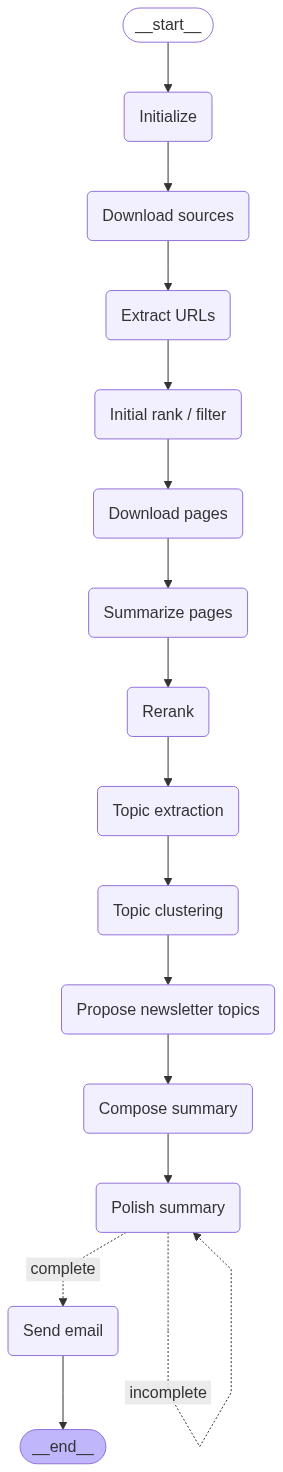

In [4]:
# same as above but w/o using native langgraph runner, run state updates sequentially
# langgraph runner does other stuff implicitly like checkpoint state in sqlite

before_date = None
before_date = '2025-06-15 18:00'
do_download = False

ml, mm, mh = 'gpt-4.1-mini', 'gpt-4.1-mini', 'o4-mini'
# ml, mm, mh = 'models/gemini-2.0-flash', 'models/gemini-1.5-pro-latest', 'models/gemini-2.0-flash-thinking-exp'
lg_state, lg_agent, thread_id = initialize_agent(ml,
                                                 mm,
                                                 mh,
                                                 do_download,
                                                 before_date,
                                                 max_edits=2,
                                                 n_browsers=12)

display(Image(lg_agent.graph.get_graph().draw_mermaid_png()))


In [5]:
lg_state = lg_agent.initialize_config(lg_state)


2025-06-16 10:24:17,821 - AInewsbot - INFO - Initialized 17 items in sources from sources.yaml
2025-06-16 10:24:17,822 - AInewsbot - INFO - Ars Technica -> https://arstechnica.com/ai/ -> Ars_Technica.html
2025-06-16 10:24:17,823 - AInewsbot - INFO - Bloomberg -> https://www.bloomberg.com/ai -> Bloomberg.html
2025-06-16 10:24:17,823 - AInewsbot - INFO - Business Insider -> https://www.businessinsider.com/tech -> Business_Insider.html
2025-06-16 10:24:17,824 - AInewsbot - INFO - FT -> https://www.ft.com/technology -> FT.html
2025-06-16 10:24:17,824 - AInewsbot - INFO - Feedly AI -> https://feedly.com/i/aiFeeds?options=eyJsYXllcnMiOlt7InBhcnRzIjpbeyJpZCI6Im5scC9mL3RvcGljLzMwMDAifV0sInNlYXJjaEhpbnQiOiJ0ZWNobm9sb2d5IiwidHlwZSI6Im1hdGNoZXMiLCJzYWxpZW5jZSI6ImFib3V0In1dLCJidW5kbGVzIjpbeyJ0eXBlIjoic3RyZWFtIiwiaWQiOiJ1c2VyLzYyZWViYjlmLTcxNTEtNGY5YS1hOGM3LTlhNTdiODIwNTMwOC9jYXRlZ29yeS9HYWRnZXRzIn1dfQ -> Feedly_AI.html
2025-06-16 10:24:17,824 - AInewsbot - INFO - Hacker News 1 -> https://news.ycom

In [6]:
lg_state = lg_agent.download_sources(lg_state)


2025-06-16 10:24:20,033 - AInewsbot - INFO - Web fetch disabled, using existing files in download_sources
2025-06-16 10:24:20,034 - AInewsbot - INFO - Found 16 previously downloaded files
2025-06-16 10:24:20,036 - AInewsbot - INFO - download_sources/Techmeme.html
2025-06-16 10:24:20,037 - AInewsbot - INFO - download_sources/Hacker_News_1.html
2025-06-16 10:24:20,038 - AInewsbot - INFO - download_sources/Reddit.html
2025-06-16 10:24:20,039 - AInewsbot - INFO - download_sources/HackerNoon.html
2025-06-16 10:24:20,039 - AInewsbot - INFO - download_sources/VentureBeat.html
2025-06-16 10:24:20,040 - AInewsbot - INFO - download_sources/Feedly_AI.html
2025-06-16 10:24:20,041 - AInewsbot - INFO - download_sources/The_Register.html
2025-06-16 10:24:20,041 - AInewsbot - INFO - download_sources/FT.html
2025-06-16 10:24:20,041 - AInewsbot - INFO - download_sources/Business_Insider.html
2025-06-16 10:24:20,042 - AInewsbot - INFO - download_sources/Washington_Post.html
2025-06-16 10:24:20,042 - AIne

In [7]:
lg_state = lg_agent.extract_web_urls(lg_state)


2025-06-16 10:24:22,879 - AInewsbot - INFO - Parsing html files
2025-06-16 10:24:22,880 - AInewsbot - INFO - Ars Technica -> download_sources/Ars_Technica.html
2025-06-16 10:24:23,058 - AInewsbot - INFO - parse_file - found 170 raw links
2025-06-16 10:24:23,060 - AInewsbot - INFO - parse_file - found 31 filtered links
2025-06-16 10:24:23,060 - AInewsbot - INFO - 31 links found
2025-06-16 10:24:23,060 - AInewsbot - INFO - Bloomberg -> download_sources/Bloomberg.html
2025-06-16 10:24:23,082 - AInewsbot - INFO - parse_file - found 251 raw links
2025-06-16 10:24:23,084 - AInewsbot - INFO - parse_file - found 30 filtered links
2025-06-16 10:24:23,084 - AInewsbot - INFO - 30 links found
2025-06-16 10:24:23,085 - AInewsbot - INFO - Business Insider -> download_sources/Business_Insider.html
2025-06-16 10:24:23,103 - AInewsbot - INFO - parse_file - found 211 raw links
2025-06-16 10:24:23,106 - AInewsbot - INFO - parse_file - found 21 filtered links
2025-06-16 10:24:23,106 - AInewsbot - INFO - 2

In [8]:
# s/b 17 check all sources downloaded, if any got hit by a bot block then download manually

sources_downloaded = len(pd.DataFrame(lg_state["AIdf"]).groupby("src").count()[['id']])
print("number of sources in AIdf", sources_downloaded)
display(pd.DataFrame(lg_state["AIdf"]).groupby("src").count()[['id']])

sources_downloaded = len(
    pd.DataFrame(lg_state["AIdf"]).groupby("src").count()[['id']])
SOURCES_EXPECTED = 17
missing_sources = SOURCES_EXPECTED-sources_downloaded
print("number of missing sources", missing_sources)
set(lg_state["sources"].keys()) - set(pd.DataFrame(lg_state["AIdf"]).groupby("src").count()[['id']].index )


number of sources in AIdf 17


,id
src,
Ars Technica,31
Bloomberg,26
Business Insider,21
FT,53
Feedly AI,111
Hacker News 1,24
Hacker News 2,25
HackerNoon,27
New York Times,18


number of missing sources 0


set()

In [9]:
# filter by headlines that we haven't seen and that look like AI
# we don't want to summarize all before filtering on headline
lg_state = lg_agent.filter_urls(lg_state)
display(pd.DataFrame(lg_state["AIdf"]).groupby("src").count()[['id']])


2025-06-16 10:24:31,008 - AInewsbot - INFO - Querying SQLite with where_clause: WHERE timestamp < '2025-06-15 18:00'
2025-06-16 10:24:31,850 - AInewsbot - INFO - URLs in orig_df: 857
2025-06-16 10:24:31,853 - AInewsbot - INFO - Existing URLs in DB: 275897
2025-06-16 10:24:31,909 - AInewsbot - INFO - New URLs in df filtered by URL: 307
2025-06-16 10:24:32,099 - AInewsbot - INFO - Existing src+title: 31
2025-06-16 10:24:32,100 - AInewsbot - INFO - New URLs in df filtered by src+title: 276
2025-06-16 10:24:32,248 - AInewsbot - INFO - Found 275 unique new headlines
2025-06-16 10:24:32,250 - AInewsbot - INFO - Found 272 unique cleaned new headlines
2025-06-16 10:24:36,102 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 10:24:39,409 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 10:24:39,556 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HT

,id
src,
Bloomberg,2
Business Insider,4
FT,2
Feedly AI,86
Hacker News 1,2
Hacker News 2,6
HackerNoon,1
New York Times,2
NewsAPI,16


In [10]:
# download individual articles
lg_state = lg_agent.download_pages(lg_state)


2025-06-16 10:24:43,622 - AInewsbot - INFO - Queuing URLs for scraping
2025-06-16 10:24:43,625 - AInewsbot - INFO - Saving HTML files using async concurrency= 12
2025-06-16 10:24:43,968 - AInewsbot - INFO - Launching browser
2025-06-16 10:24:45,714 - AInewsbot - INFO - Launching workers
2025-06-16 10:24:45,715 - AInewsbot - INFO - Launching worker
2025-06-16 10:24:45,715 - AInewsbot - INFO - from queue: 0, https://www.blogger.com/comment/fullpage/post/26204193/2945790034495269182 , "Rebecca's Song" -- A Family History Poem, Song and Podcast Created by Artificial Intelligence
2025-06-16 10:24:45,715 - AInewsbot - INFO - fetch_url(https://www.blogger.com/comment/fullpage/post/26204193/2945790034495269182)
2025-06-16 10:24:45,735 - AInewsbot - INFO - Launching worker
2025-06-16 10:24:45,735 - AInewsbot - INFO - from queue: 1, https://news.google.com/rss/articles/CBMijgFBVV95cUxQeEE3bjNNRURjU1dJM3M3VjVHbExPMnBNS1pseGpUTElKQlZpZmZJUFZGOG02RGhBMENjQS1XMnU5akpHbzJCRXhlck9ZUzA2N2pXVG1mTEVGYkNY

2025-06-16 10:24:45,742 - AInewsbot - INFO - fetch_url(https://www.zdnet.com/article/7-trends-shaping-digital-transformation-in-2025-and-ai-looms-large/)
2025-06-16 10:24:45,743 - AInewsbot - INFO - File already exists: download_html/7_trends_shaping_digital_transformation_in_2025_-_and_AI_looms_large.html
2025-06-16 10:24:45,743 - AInewsbot - INFO - from queue: 9, https://www.theguardian.com/education/2025/jun/15/thousands-of-uk-university-students-caught-cheating-using-ai-artificial-intelligence-survey , A survey of UK academic integrity violations finds nearly 7,000 proven AI cheating cases in 2023-24, or 5.1 per 1,000 students, up from 1.6 per 1,000 in 2022-23 (Michael Goodier/The Guardian)
2025-06-16 10:24:45,743 - AInewsbot - INFO - fetch_url(https://www.theguardian.com/education/2025/jun/15/thousands-of-uk-university-students-caught-cheating-using-ai-artificial-intelligence-survey)
2025-06-16 10:24:45,779 - AInewsbot - INFO - Launching worker
2025-06-16 10:24:45,779 - AInewsbot 

2025-06-16 10:24:45,844 - AInewsbot - INFO - from queue: 21, https://news.google.com/rss/articles/CBMihAFBVV95cUxQX1pYSzFmWXVzcWNNbERabndkNUszU3I3SWlwZW52aEg0OVFNak9NV0dVay1KdDVDdUhLcVc3YVhMdFZZVkhMYVRLM2xjdThXOWQzZldZQS1ySUcwN1F1ZHhFdl9JaFBpV3YySl9QckYycU9FcmlJZzZuaHhGdlY3TVA1SzQ , AI-powered study shows surge in global rheumatoid arthritis since 1980, revealing local hotspots
2025-06-16 10:24:45,844 - AInewsbot - INFO - fetch_url(https://news.google.com/rss/articles/CBMihAFBVV95cUxQX1pYSzFmWXVzcWNNbERabndkNUszU3I3SWlwZW52aEg0OVFNak9NV0dVay1KdDVDdUhLcVc3YVhMdFZZVkhMYVRLM2xjdThXOWQzZldZQS1ySUcwN1F1ZHhFdl9JaFBpV3YySl9QckYycU9FcmlJZzZuaHhGdlY3TVA1SzQ)
2025-06-16 10:24:45,844 - AInewsbot - INFO - File already exists: download_html/AI-powered_study_shows_surge_in_global_rheumatoid_arthritis_since_1980__revealing_local_hotspots.html
2025-06-16 10:24:45,845 - AInewsbot - INFO - from queue: 22, https://news.google.com/rss/articles/CBMi7wFBVV95cUxNN1p0TDljVjRjUzNWVDFxRVhaNEhTazNhX1dfMEFvT2FEcX

2025-06-16 10:24:45,851 - AInewsbot - INFO - from queue: 31, https://www.phonearena.com/news/apple-head-of-ai-not-long-for-cupertino-following-wwdc_id171354 , Apples head of AI likely not long for Cupertino following WWDC
2025-06-16 10:24:45,852 - AInewsbot - INFO - fetch_url(https://www.phonearena.com/news/apple-head-of-ai-not-long-for-cupertino-following-wwdc_id171354)
2025-06-16 10:24:45,852 - AInewsbot - INFO - File already exists: download_html/Apples_head_of_AI_likely_not_long_for_Cupertino_following_WWDC.html
2025-06-16 10:24:45,852 - AInewsbot - INFO - from queue: 32, https://softspacesolutions.com/blog/application-of-ai-in-marketing/ , Application of AI in Marketing | Driving Your Future Success
2025-06-16 10:24:45,852 - AInewsbot - INFO - fetch_url(https://softspacesolutions.com/blog/application-of-ai-in-marketing/)
2025-06-16 10:24:45,928 - AInewsbot - INFO - Launching worker
2025-06-16 10:24:45,929 - AInewsbot - INFO - from queue: 33, https://news.google.com/rss/articles/CB

2025-06-16 10:24:46,059 - AInewsbot - INFO - from queue: 44, https://news.google.com/rss/articles/CBMiYkFVX3lxTFB2b2VVWFhQWjR5cFU3a2h4SnR4eWo1N1hVdHFuSG5Rd0ZyWkRSMDc3Q0FFU2NhZ1BqRE9YbkttVDVES2lwblBld2tGMmFqVlNkc3VjUW1pYk9VbW1fQjY1aEZR , Chinese tech giants ramp up AI talent recruitment amid surging demand
2025-06-16 10:24:46,059 - AInewsbot - INFO - fetch_url(https://news.google.com/rss/articles/CBMiYkFVX3lxTFB2b2VVWFhQWjR5cFU3a2h4SnR4eWo1N1hVdHFuSG5Rd0ZyWkRSMDc3Q0FFU2NhZ1BqRE9YbkttVDVES2lwblBld2tGMmFqVlNkc3VjUW1pYk9VbW1fQjY1aEZR)
2025-06-16 10:24:46,060 - AInewsbot - INFO - File already exists: download_html/Chinese_tech_giants_ramp_up_AI_talent_recruitment_amid_surging_demand.html
2025-06-16 10:24:46,060 - AInewsbot - INFO - from queue: 45, https://news.google.com/rss/articles/CBMivAFBVV95cUxNU2NjSzVtRU9qWjlrQU5MSmpFVnY2UF9LZUlMZW0tR241RlJxYjVmYnZTZzhMRUdCMzE2RHZkLWhYNnRMWUFNd0hkbUZsUzcyMUhoNFR1WG5LU2pjc3lscW80WU1GSEVSTUhfRU16dzQzSlRMQlU2NERqR2VMaWpCS1ZDVW9ybHR5UHpwVTN1YTdRZXRvSGNPa3

2025-06-16 10:24:46,185 - AInewsbot - INFO - fetch_url(https://www.reddit.com/gallery/1lc7qz3)
2025-06-16 10:24:46,185 - AInewsbot - INFO - File already exists: download_html/Elon_is_working_on_Grok_3.5_and_will_push_xAI_towards_removing__leftist_indoctrination__from_the_model._This_can_be_accomplished_by_either_significantly_manipulating_the_training_data_and_messing_with_Grok_s_ontology__the_exact_things_AI_doomers_wer.html
2025-06-16 10:24:46,185 - AInewsbot - INFO - from queue: 58, https://news.google.com/rss/articles/CBMi0gFBVV95cUxPc1dBTHFoYXFRc0MweWJCamlhcVRLWFF6SHhSVUd2b19wOUhYMkRGSFNtVkRtVVJxeDNrSTR2WWJITWlDbDNTMWVDUVpNWEdvSGxPZU5PUHNjMmJ0YWpmQlU1QVM2cGg0OXpqak5MVVBZdUxBMkxqY29kSm96YUQyM1RPQVA5enVYb0RaNE14d1MwaGpzTEdWdXNPV05GYkVrMG9mWENfTkZiMGs5VVdOejBXbVdrTEg5S1RjUVhGcmtPUkx3VVIyQ1dQSGpnOWxjMnc , Enxoo at DTW25: AI, NaaS and API-First Architectures Take Center Stage
2025-06-16 10:24:46,186 - AInewsbot - INFO - fetch_url(https://news.google.com/rss/articles/CBMi0gFBVV95cUxPc1d

2025-06-16 10:24:46,232 - AInewsbot - INFO - fetch_url(https://news.google.com/rss/articles/CBMimAFBVV95cUxNQngtR1RmeDl3T1FpMTJGb1I1dWs2TW9YM0hHTnF5R0Y3SFRXWGN2ZmN2LWZFMXJxaUlHS0ZtREQtSW11QmczSzJyc0VLc3Z2anFMdm1yQWJVLXVoVEpHQlZYeVVuMFRwX0dTR1h4azluMTc3d2ZWckJEeDZWamszRWI3WUxMdXZGRHBTdERIcGR1RnQ0UWJ1dA)
2025-06-16 10:24:46,232 - AInewsbot - INFO - File already exists: download_html/Google_plans_to_end_partnership_with_Scale_AI_after_Meta_deal.html
2025-06-16 10:24:46,232 - AInewsbot - INFO - from queue: 70, https://news.google.com/rss/articles/CBMi5AFBVV95cUxNTVNRS3dZbXlmOWZmelZmTTU3RTNKNG13WEZlcnZfZ1g1ZUtpNktfbzBtbVo5MHFkOTNOWHZPdGpHNkh0RDRMWmtWT0tSaV80SVR4ZEFmLWVjc0JoeHFfbm9NMFc1Wndhbl96Z3pwYmRUSlo0LUlDNEJXX0tXQWpKdTJYaUtIUklPUXNqWWVxRFVNbWFCVUxqTUtxdlRYd2RqR1MyWlJielUxbDh4RElZZndWb0FEeTZvMzBkVUo5WXpRZm10ajdia09zbG9KWkVVTnlkNi0yZjhrMG1QYXozeEpIYkw , HPC News Bytes 20250616: Wave of AI Hardware-Software from AMD, Fujitsu Chip, SIGHPC SC25 Travel Grants, HPC Guru Signs Off
2025-06-16 10

2025-06-16 10:25:18,245 - AInewsbot - INFO - Skipping fetch for 78 https://www.bloomberg.com/news/newsletters/2025-06-12/new-york-state-updates-warn-notices-to-identify-layoffs-tied-to-ai In March, New York added a checkbox to its WARN system for companies to show if technological innovation or automation, like AI, was a reason for mass layoffs
2025-06-16 10:25:18,245 - AInewsbot - INFO - from queue: 79, https://news.google.com/rss/articles/CBMisgFBVV95cUxQRzNwQXNCQW45dkRVcmFnYXlkcmk5S1o1SXFIVGtCQURhQkI5d2V6QndkQmpKeGFiWlhUMTNkS3phMWQxbi1TWThMSnNSNTBnM0dQRGl3enFSbVQyYllmRDYtSm1JalpJWnYwTEg3VU8xSF9mM3YtQV80cEJJdjk4a0RsWF9YbDVlbkRmVUsxeV9udUZ5aEFwZjRhUXJ5Smg4WXdxZjRhbjRTMFhxU2JUSm1R , Jackson Hole Chamber Hosts AI Workshop to Boost Business Productivity on June 20th
2025-06-16 10:25:18,245 - AInewsbot - INFO - fetch_url(https://news.google.com/rss/articles/CBMisgFBVV95cUxQRzNwQXNCQW45dkRVcmFnYXlkcmk5S1o1SXFIVGtCQURhQkI5d2V6QndkQmpKeGFiWlhUMTNkS3phMWQxbi1TWThMSnNSNTBnM0dQRGl3enFSbVQyYllmR

2025-06-16 10:25:18,259 - AInewsbot - INFO - File already exists: download_html/Meta_takes_AI_firm_behind_nudify_apps_to_court_over_ads_on_Facebook__Instagram.html
2025-06-16 10:25:18,259 - AInewsbot - INFO - from queue: 88, https://www.axios.com/pro/health-tech-deals/2025/06/11/zorro-raises-20m-series-a-ichra-health-plans , NYC-based Zorro, whose AI-powered software helps clients' workers navigate health insurance and benefits options, raised a $20M Series A led by Entree Capital
2025-06-16 10:25:18,259 - AInewsbot - INFO - fetch_url(https://www.axios.com/pro/health-tech-deals/2025/06/11/zorro-raises-20m-series-a-ichra-health-plans)
2025-06-16 10:25:22,864 - AInewsbot - INFO - Page URL redirected from https://insidethemagic.net/?p=776690 to https://insidethemagic.net/2025/06/disney-confirms-no-ai-oogie-boogie-bash-art-ks1/
2025-06-16 10:25:22,885 - AInewsbot - INFO - Found last updated time from meta tag property=article:published_time: 2025-06-15T12:07:47+00:00
2025-06-16 10:25:22,88

2025-06-16 10:25:23,934 - AInewsbot - INFO - File already exists: download_html/Qualtrics_targets_action_gap_with_new_AI_copilot.html
2025-06-16 10:25:23,934 - AInewsbot - INFO - from queue: 99, https://news.google.com/rss/articles/CBMiigFBVV95cUxNYjdqN0h2LS1RVXVNR2l2Mkg5LU95TVE1U3NuMFZrRnhaTGptSGNocVdWVmVYOUg4MG9GZ2dmY3h2bENzNGJkVmxDWjRwbm5vRlFaWDN0U1N6WWtDUTJSa0V2bjBQSzhjZVMzRXJrcUJJeTFFbUpPSjdUVkdKZklOT3FWcllZT1F4dmc , Ready or Not, Agentic AI Is Disrupting Corporate Landscapes
2025-06-16 10:25:23,935 - AInewsbot - INFO - fetch_url(https://news.google.com/rss/articles/CBMiigFBVV95cUxNYjdqN0h2LS1RVXVNR2l2Mkg5LU95TVE1U3NuMFZrRnhaTGptSGNocVdWVmVYOUg4MG9GZ2dmY3h2bENzNGJkVmxDWjRwbm5vRlFaWDN0U1N6WWtDUTJSa0V2bjBQSzhjZVMzRXJrcUJJeTFFbUpPSjdUVkdKZklOT3FWcllZT1F4dmc)
2025-06-16 10:25:23,935 - AInewsbot - INFO - File already exists: download_html/Ready_or_Not__Agentic_AI_Is_Disrupting_Corporate_Landscapes.html
2025-06-16 10:25:23,936 - AInewsbot - INFO - from queue: 100, https://www.businessin

2025-06-16 10:25:26,335 - AInewsbot - INFO - File already exists: download_html/The_CEO_of_British_telecom_giant_BT_warns_AI_could_lead_to_further_job_cuts_at_the_firm.html
2025-06-16 10:25:26,335 - AInewsbot - INFO - from queue: 110, https://hackernoon.com/the-real-cost-of-relying-on-ai-in-a-lonely-america , The Real Cost of Relying on AI in a Lonely America
2025-06-16 10:25:26,336 - AInewsbot - INFO - fetch_url(https://hackernoon.com/the-real-cost-of-relying-on-ai-in-a-lonely-america)
2025-06-16 10:25:26,336 - AInewsbot - INFO - File already exists: download_html/The_Real_Cost_of_Relying_on_AI_in_a_Lonely_America.html
2025-06-16 10:25:26,337 - AInewsbot - INFO - from queue: 111, https://hackernoon.com/6-16-2025-techbeat , The TechBeat: Why The Future of AI Organization Looks More Like Open-Source Software Than Corporate Bureaucracy (6/16/2025)
2025-06-16 10:25:26,339 - AInewsbot - INFO - fetch_url(https://hackernoon.com/6-16-2025-techbeat)
2025-06-16 10:25:26,341 - AInewsbot - INFO -

2025-06-16 10:25:26,350 - AInewsbot - INFO - fetch_url(https://news.google.com/rss/articles/CBMipAFBVV95cUxONmlMTlFwdGo5N0RxRDZfUzNnOUthdmVHTXp1Tk1ScHVIVHZXOGxFOWtvd0JjUHVqa3lVNTZVQlJJZnZ5TE1pTmIwckhKYXY3OFc4eDdJWWEtald2NGQyNWxDOWctSTVTQTdvS1dDbjBXRE94YUhaTWpOb0NZYlE2YnBRN0FYYVNtSnk4b0ZhSG9CLTNTR0hpUUk0ZE52UnZiRzZXZQ)
2025-06-16 10:25:26,351 - AInewsbot - INFO - File already exists: download_html/Want_to_Get_Ahead_in_the_Age_of_AI__Skip_College.html
2025-06-16 10:25:26,351 - AInewsbot - INFO - from queue: 125, https://news.google.com/rss/articles/CBMihwFBVV95cUxNMVJvcVZkbEgxQll6S2htcDZha2hpS3ktaWpKT3lXaW1YVmUyNTRZd2NoV1A5WUc0UFNVbjJFU2xCMXhVbnZVT1BiRHVfcUxxVGxfNXJkQUtLbHEyQ01iYmVyZF9lX1hyeWtBOE80b3NZQzBBZHAxMll6eFZJUXh0WVJHM2FBRWs , Warren Buffett Has $90 Billion Invested in These 9Artificial Intelligence(AI) Stocks. Here's the Best of the Bunch.
2025-06-16 10:25:26,351 - AInewsbot - INFO - fetch_url(https://news.google.com/rss/articles/CBMihwFBVV95cUxNMVJvcVZkbEgxQll6S2htcDZha2hpS3kta

2025-06-16 10:25:35,726 - AInewsbot - INFO - Found last updated time from meta tag property=article:published_time: 2025-06-11T15:00:04+00:00
2025-06-16 10:25:35,729 - AInewsbot - INFO - Found script last updated time from script datePublished: 2025-06-11T15:00:04Z
2025-06-16 10:25:35,730 - AInewsbot - INFO - Saving HTML to download_html/Cyborg_Embryos_Offer_New_Insights_into_Brain_Growth.html
2025-06-16 10:25:37,790 - AInewsbot - INFO - Found last updated time from meta tag property=article:published_time: 2025-06-15T12:01:09+00:00
2025-06-16 10:25:37,791 - AInewsbot - INFO - Saving HTML to download_html/ChatGPT__Google__3D_Printer_Simulator__More__Sunday_ResearchBuzz__June_15__2025.html
2025-06-16 10:25:39,310 - AInewsbot - INFO - Found last updated time from meta tag property=article:published_time: 2025-06-11T12:56:26Z
2025-06-16 10:25:39,311 - AInewsbot - INFO - Saving HTML to download_html/NYC-based_Zorro__whose_AI-powered_software_helps_clients__workers_navigate_health_insurance

2025-06-16 10:26:02,994 - AInewsbot - INFO - Saving text to download_text/2025-06-16/5_Prompts_That_Make_Anthropic_s_Claude_AI_Better_Than_a_Crypto_Analyst__Broker_or_Doctor.txt
2025-06-16 10:26:03,023 - AInewsbot - INFO - clean_html - Page title: 7 trends shaping digital transformation in 2025 - and AI looms large | ZDNET
Social card title: 7 trends shaping digital transformation in 2025 - and AI looms large
Social card description: From autonomous enterprises built on a hybrid workforce to a house of AI agents, here's where digital transformation goes next.

2025-06-16 10:26:03,373 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-06-16 10:26:03,480 - AInewsbot - INFO - Saving text to download_text/2025-06-16/7_trends_shaping_digital_transformation_in_2025_-_and_AI_looms_large.txt
2025-06-16 10:26:03,492 - AInewsbot - INFO - clean_html - Page title: A.I. Is Poised to Rewrite History. Literally. - The New York Times
Social card title: A.I.

2025-06-16 10:26:08,299 - AInewsbot - INFO - Saving text to download_text/2025-06-16/AIXA_Miner_Launches_AI-Powered_Cloud_Mining_Services_After_Securing_FinCEN_MSB_License.txt
2025-06-16 10:26:08,324 - AInewsbot - INFO - clean_html - Page title: AMD: Future AI Inference Monster (NASDAQ:AMD) | Seeking Alpha
Social card title: AMD: Future AI Inference Monster (NASDAQ:AMD)
Social card description: Explore AMD's growth potential in the booming AI market with its MI355x GPUs.

2025-06-16 10:26:08,533 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-06-16 10:26:08,609 - AInewsbot - INFO - Saving text to download_text/2025-06-16/AMD__Future_AI_Inference_Monster__NASDAQ_AMD.txt
2025-06-16 10:26:08,618 - AInewsbot - INFO - clean_html - Page title: [2506.08872] Your Brain on ChatGPT: Accumulation of Cognitive Debt when Using an AI Assistant for Essay Writing Task
Social card title: Your Brain on ChatGPT: Accumulation of Cognitive Debt when Using an 

2025-06-16 10:26:15,508 - AInewsbot - INFO - clean_html - Page title: As AI Dawns in Precision Oncology, 2025 Expected To Be a ‘Turning Point’ - BioSpace
Social card title: As AI Dawns in Precision Oncology, 2025 Expected To Be a ‘Turning Point’
Social card description: AstraZeneca, Pfizer and more are leveraging the computational power of AI to better design trials, predict the potential efficacy and safety profiles of their molecules and synthesize massive multi-omic information to gain a more complete understanding of challenging cancers.

2025-06-16 10:26:15,845 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-06-16 10:26:15,952 - AInewsbot - INFO - Saving text to download_text/2025-06-16/As_AI_Dawns_in_Precision_Oncology__2025_Expected_To_Be_a_Turning_Point.txt
2025-06-16 10:26:15,967 - AInewsbot - INFO - clean_html - Page title: Subscribe to read
Social card title: BT chief eyes deeper job cuts as AI becomes more powerful
Social card

2025-06-16 10:26:19,841 - AInewsbot - INFO - clean_html - Page title: Digiday Podcast: Kimberly-Clark's Patricia Corsi talks AI at Cannes
Social card title: 'It's a big meeting week': Kimberly-Clark’s Patricia Corsi on the AI hype, Cannes jargon
Social card description: While Cannes is known for its schmoozing and glitzy award shows, here's how Kimberly-Clark’s Patricia Corsi separates real talk from hype.

2025-06-16 10:26:20,073 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-06-16 10:26:20,186 - AInewsbot - INFO - Saving text to download_text/2025-06-16/Digiday_Podcast__Kimberly-Clark_s_Patricia_Corsi_talks_AI_at_Cannes.txt
2025-06-16 10:26:20,199 - AInewsbot - INFO - clean_html - Page title: Artificial intelligence: Disney and Universal sue Midjourney over copyright
Social card title: Artificial intelligence: Disney and Universal sue Midjourney over copyright
Social card description: The Hollywood studios allege Midjourney's image gen

2025-06-16 10:26:27,964 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-06-16 10:26:28,065 - AInewsbot - INFO - Skipping download_html/Fake_Bands_and_Artificial_Songs_are_Taking_Over_YouTube_and_Spotify.html as it is too similar to an existing document
2025-06-16 10:26:28,077 - AInewsbot - INFO - clean_html - Page title: Fake bands and artificial songs are taking over YouTube and Spotify | Culture | EL PAÍS English
Social card title: Fake bands and artificial songs are taking over YouTube and Spotify
Social card description: AI-generated songs have made their way onto streaming services and it’s not just ambient or electronic music: fake bands, be they rock, salsa, or jazz, are also abundant

2025-06-16 10:26:28,433 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-06-16 10:26:28,533 - AInewsbot - INFO - Skipping download_html/Fake_bands_and_artificial_songs_are_taking_over_YouTube_and_Spotify

2025-06-16 10:26:33,282 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-06-16 10:26:33,355 - AInewsbot - INFO - Saving text to download_text/2025-06-16/I_took_a_chaotic__surreal_robotaxi_ride_through_central_London._It_left_me_impressed__but_with_one_big_question..txt
2025-06-16 10:26:33,382 - AInewsbot - INFO - clean_html - Page title: ChatGPT took on a 50-year-old Atari — and lost - The Economic Times
Social card title: ChatGPT took on a 50-year-old Atari — and lost
Social card description: In a surprising turn of events, ChatGPT, a leading AI chatbot, was defeated by the vintage Atari 2600 in a chess match. Despite ChatGPT's initial confidence and claims of chess prowess, the Atari console, launched in 1977, consistently outperformed the AI. The experiment highlighted the limitations of ChatGPT in logical reasoning and board awareness, leading to its eventual concession.

2025-06-16 10:26:33,669 - httpx - INFO - HTTP Request: POST http

2025-06-16 10:26:37,962 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-06-16 10:26:38,029 - AInewsbot - INFO - Saving text to download_text/2025-06-16/New_AI_Model_Reveals_Biblical_Dead_Sea_Scrolls_Are_Far_Older_Than_We_Thought.txt
2025-06-16 10:26:38,054 - AInewsbot - INFO - clean_html - Page title: AI is reinventing reality. Who is keeping it honest?
Social card title: AI is reinventing reality. Who is keeping it honest?
Social card description: The following is a guest post and opinion from J.D. Seraphine, Founder and CEO of Raiinmaker. X’s Grok AI cannot seem to stop talking about “white genocide” in South Africa; ChatGPT has become a sycophant. We have entered an era where AI isn’t just repeating human knowledge that already exists—it seems to be rewriting it. […]

2025-06-16 10:26:38,315 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-06-16 10:26:38,388 - AInewsbot - INFO - Saving tex

2025-06-16 10:26:42,833 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-06-16 10:26:42,948 - AInewsbot - INFO - Saving text to download_text/2025-06-16/Target_Dial_Sets_a_New_Standard_in_AI_Voice_Automation__Poised_to_Become_Canada_s_Leading_AI_Agency.txt
2025-06-16 10:26:42,963 - AInewsbot - INFO - clean_html - Page title: Tariffs, wildfires and AI on the agenda as Canada hosts world leaders at G7
Social card title: Tariffs, wildfires and AI on the agenda as Canada hosts world leaders at G7
Social card description: OTTAWA — Prime Minister Mark Carney has tried to pare down Canada’s priorities as the G7 summit host, but there’s still a lengthy list of global issues for leaders to discuss over the coming days. “Leaders (will) meet at a moment of enormous flux globally, when tensions among G7 members are especially pronounced,” Carney’s foreign […]

2025-06-16 10:26:43,256 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/embedd

2025-06-16 10:26:47,696 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-06-16 10:26:47,833 - AInewsbot - INFO - Saving text to download_text/2025-06-16/The_key_to_Oracles_AI_future.txt
2025-06-16 10:26:47,850 - AInewsbot - INFO - clean_html - Page title: ChatGPT polluted the world forever, like the first atom bomb • The Register
Social card title: ChatGPT polluted the world forever, like the first atom bomb
Social card description: Feature: Academics mull the need for the digital equivalent of low-background steel

2025-06-16 10:26:48,102 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-06-16 10:26:48,172 - AInewsbot - INFO - Skipping download_html/The_launch_of_ChatGPT_polluted_the_world_forever__like_the_first_atomic_weapons_tests.html as it is too similar to an existing document
2025-06-16 10:26:48,173 - AInewsbot - INFO - clean_html - Page title: fastcompany.com

2025-06-16 10:26:48,176 -

2025-06-16 10:26:53,860 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-06-16 10:26:53,959 - AInewsbot - INFO - Saving text to download_text/2025-06-16/Why_CISOs_need_to_understand_the_AI_tech_stack.txt
2025-06-16 10:26:53,964 - AInewsbot - INFO - clean_html - Page title: Beyond Token Limits: Why the Apple LRM Rebuttal Misses the Point :: Victor's Blog
Social card title: Beyond Token Limits: Why the Apple LRM Rebuttal Misses the Point
Social card description: Recently Apple published a paper on LRMs (Large Reasoning Models) and how they found that “that LRMs have limitations in exact computation” and that “they fail to use explicit algorithms and reason inconsistently across puzzles.” I would consider this a death blow paper to the current push for using LLMs and LRMs as the basis for AGI. Subbaro Kambhampati and Yann LeCun seem to agree. You could say that the paper knocked out LLMs. More recently, a comment paper showed up on Arxiv and 

2025-06-16 10:26:58,650 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-06-16 10:26:58,753 - AInewsbot - INFO - Saving text to download_text/2025-06-16/Cyborg_Embryos_Offer_New_Insights_into_Brain_Growth.txt
2025-06-16 10:26:58,761 - AInewsbot - INFO - clean_html - Page title: ChatGPT, Google, 3D Printer Simulator, More: Sunday ResearchBuzz, June 15, 2025 – ResearchBuzz
Social card title: ChatGPT, Google, 3D Printer Simulator, More: Sunday ResearchBuzz, June 15, 2025
Social card description: TWEAKS AND UPDATES Engadget: OpenAI adds the o3-pro model to ChatGPT today. “OpenAI is keeping up its rapid-fire pace of new AI releases. The company introduced the o3 and o4-mini models to i…

2025-06-16 10:26:59,045 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-06-16 10:26:59,153 - AInewsbot - INFO - Saving text to download_text/2025-06-16/ChatGPT__Google__3D_Printer_Simulator__More__Sunday_ResearchB

2025-06-16 10:27:10,567 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-06-16 10:27:10,826 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-06-16 10:27:11,249 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-06-16 10:27:11,551 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-06-16 10:27:12,068 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-06-16 10:27:12,434 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-06-16 10:27:12,803 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-06-16 10:27:13,094 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-06-16 10:27:13,703 - httpx - INFO - HTTP Request: POST https://api.openai.c

2025-06-16 10:27:37,056 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-06-16 10:27:37,338 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-06-16 10:27:37,866 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-06-16 10:27:38,176 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-06-16 10:27:38,488 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-06-16 10:27:38,893 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-06-16 10:27:39,103 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-06-16 10:27:39,310 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-06-16 10:27:39,813 - httpx - INFO - HTTP Request: POST https://api.openai.c

In [11]:
# summarize downloaded pages
lg_state = lg_agent.summarize_pages(lg_state)


2025-06-16 10:27:56,573 - AInewsbot - INFO - Starting summarize
2025-06-16 10:27:56,579 - AInewsbot - INFO - Fetching summaries for all articles
2025-06-16 10:27:56,582 - AInewsbot - INFO - Attempting to fetch summaries for 135 articles
2025-06-16 10:27:56,585 - AInewsbot - INFO - Queuing 0: Page title: Post a Comment
Comments on "Rebecca's ...
2025-06-16 10:27:56,587 - AInewsbot - INFO - Queuing 1: Page title: How a Whoop Product Leader Made AI a H...
2025-06-16 10:27:56,588 - AInewsbot - INFO - Queuing 2: Page title: ‘AI is a better programmer than me’: T...
2025-06-16 10:27:56,589 - AInewsbot - INFO - Queuing 3: Page title: ‘Life or death consequences’: AMA push...
2025-06-16 10:27:56,590 - AInewsbot - INFO - Queuing 4: Page title: 'Neuralink babies'? Scale AI’s Alexand...
2025-06-16 10:27:56,591 - AInewsbot - INFO - Queuing 5: Page title: 'Upskilling is the priority to harness...
2025-06-16 10:27:56,591 - AInewsbot - INFO - Queuing 6: Page title: 2025 Chief Officer Awards Winner: E

2025-06-16 10:27:56,613 - AInewsbot - INFO - Queuing 77: Page title: Il divario tra uomini e chatbot si sta...
2025-06-16 10:27:56,613 - AInewsbot - INFO - No text_path for 78
2025-06-16 10:27:56,614 - AInewsbot - INFO - Queuing 79: Page title: Jackson Hole Chamber Hosts AI Workshop...
2025-06-16 10:27:56,614 - AInewsbot - INFO - Queuing 80: Page title: Jersey and Guernsey leaders discuss AI...
2025-06-16 10:27:56,614 - AInewsbot - INFO - Queuing 81: Page title: Juvenescence Acquires Ro5 to Integrate...
2025-06-16 10:27:56,614 - AInewsbot - INFO - Queuing 82: Page title: Lately: AI vs. critical thinking, ‘dad...
2025-06-16 10:27:56,615 - AInewsbot - INFO - Queuing 83: Page title: Deputy national security, AI advisers ...
2025-06-16 10:27:56,615 - AInewsbot - INFO - Queuing 84: Page title: Let's Talk About ChatGPT-Induced Spiri...
2025-06-16 10:27:56,615 - AInewsbot - INFO - Queuing 85: Page title: Machine learning on blockchain: A new ...
2025-06-16 10:27:56,615 - AInewsbot - INFO - No

2025-06-16 10:27:58,768 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 10:27:58,776 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 10:27:58,815 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 10:27:58,819 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 10:27:58,839 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 10:27:58,855 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 10:27:58,898 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 10:27:58,899 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 10:27:58,902 - httpx 

2025-06-16 10:27:59,737 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 10:27:59,758 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 10:27:59,759 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 10:27:59,769 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 10:27:59,772 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 10:27:59,803 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 10:27:59,808 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 10:27:59,809 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 10:27:59,822 - httpx 

2025-06-16 10:28:01,051 - AInewsbot - INFO - Summary for 5 (length 4707): - Omnicom CEO John Wren emphasized upskilling employees as a priority to effectively harness AI across the company, integrating generative AI within their platforms like Omni and Flywheel Commerce Cloud to enhance marketing workflows and creative ideation.  
- Omnicom has developed an enterprise agentic framework called OmniAI that uses machine intelligence to amplify creativity and improve client outcomes, including the use of synthetic audiences for testing strategies before full production.  
- New AI-focused roles such as AI agent orchestrators and AI integration strategists have been created, with further specialized positions anticipated as AI becomes more embedded in the agency's operations following their decade-long investment in data and platform strategy.
2025-06-16 10:28:01,052 - AInewsbot - INFO - Summary for 6 (length 1463): - Pamela Rothka, CFO of Empower AI, won WashingtonExec’s Chief Officer Awar

2025-06-16 10:28:01,057 - AInewsbot - INFO - Summary for 19 (length 1513): - New York-based AI workflow start-up Farsight raised $16 million in a Series A funding round led by SignalFire, with participation from Link Ventures, RRE Ventures, K5 Ventures, and angel investors from firms like Blackstone and Bank of America.  
- Farsight offers an AI execution engine that automates investment banking workflows such as valuation analysis, buyer list generation, and pitch deck creation within Excel and PowerPoint, targeting investment banks, private equity firms, and hedge funds.  
- Founded in 2022 by MIT graduates Samir Dutta (CEO), Noah Faro (CTO), and Kunal Tangri (COO), the company saw a tenfold revenue increase and a fivefold expansion in its customer base in 2024, with funding intended to grow its team and client acquisitions.
2025-06-16 10:28:01,058 - AInewsbot - INFO - Summary for 20 (length 21055): - Oliver Burkeman warns against the "efficiency trap" of AI productivity tools, where

2025-06-16 10:28:01,061 - AInewsbot - INFO - Summary for 30 (length 8295): - The 2025 Annual Meeting of the New Champions in Tianjin will feature arts and culture exhibitions showcasing the evolution of creativity in the digital age, focusing on the intersection of art, AI, and ecology.  
- Artists Thijs Biersteker and Ronen Tanchum will present AI-powered installations—Biersteker’s "Fungal Faculty" explores the integration of mycelium networks with AI to challenge notions of intelligence and sustainability, while Tanchum’s "Seeds of Tomorrow" uses generative AI and motion tracking to create an evolving digital ecosystem reflecting nature-technology harmony.  
- These artworks emphasize the ethical and philosophical implications of technological progress, advocating for sustainable innovation that balances ecological preservation with cutting-edge advancements.
2025-06-16 10:28:01,061 - AInewsbot - INFO - Summary for 31 (length 4504): - John Giannandrea, Apple’s head of AI, was notably

2025-06-16 10:28:01,063 - AInewsbot - INFO - Summary for 42 (length 3513): - Chinese AI companies are circumventing US semiconductor export restrictions by sending engineers to countries like Malaysia and using local data centers with US-made chips to train AI models, then transferring the data back to China via hard drives.
- This "sneakernet" method exploits a loophole since US prohibitions do not apply outside the US, allowing Chinese firms to bypass direct chip sales restrictions despite tightened controls from the Biden administration.
- The practice reflects ongoing tensions in the US-China tech rivalry, with US officials like Thea Kendler emphasizing the need to restrict exports to impede China's military and technological advances.
2025-06-16 10:28:01,063 - AInewsbot - INFO - Summary for 44 (length 5888): - Chinese tech giants including Baidu, Alibaba, and JD.com are significantly increasing AI talent recruitment to maintain competitive advantages amid surging demand, with Baid

2025-06-16 10:28:01,067 - AInewsbot - INFO - Summary for 55 (length 685): - EXL Services, a global analytics and digital solutions firm with 26 years of history, is making its debut at Cannes Lions, highlighting its use of artificial intelligence and data to drive growth.
- Nasasimha Kini, an executive at EXL, discusses how AI can significantly enhance business growth.
2025-06-16 10:28:01,068 - AInewsbot - INFO - Summary for 56 (length 2557): - Ellipsis Health raised $45 million to expand its AI voice agent, Sage, designed to support patients with complex needs by using vocal biomarker technology to adjust care based on patients’ emotional and mental states.  
- Sage is trained on data from millions of clinical patient calls to provide emotionally intelligent, context-aware support, addressing healthcare worker shortages and enhancing patient care between visits.  
- The funding round was co-led by Salesforce, Khosla Ventures, and CVS Health Ventures, and Ellipsis uses Salesforce’s Hea

2025-06-16 10:28:01,071 - AInewsbot - INFO - Summary for 70 (length 1162): - AMD announced new AI-focused hardware including the MI350X and MI355X GPUs, ROCm 7.0 software, and the Helios rackscale system.  
- Fujitsu introduced the Monaka chip, contributing to advancements in HPC technology.  
- SIGHPC announced travel grants for the SC25 conference, and a noted HPC Guru has signed off from their role.
2025-06-16 10:28:01,071 - AInewsbot - INFO - Summary for 71 (length 2278): - Barclays analysts found that the ratio of junior software developer (Jr. SDE) job postings to total job postings has declined in the S&P 500 and broader tech sector since 2022, indicating potential impact from AI tools like ChatGPT.  
- Their regression analysis showed a significant negative correlation between months since ChatGPT’s release and junior SDE job ratios in the S&P 500, while the Magnificent Seven tech companies (excluding Amazon) showed a significant positive correlation, suggesting differing trend

2025-06-16 10:28:01,074 - AInewsbot - INFO - Summary for 84 (length 11057): - The article discusses psychological breaks linked to ChatGPT usage but situates these within a long history of new communication technologies being associated with spiritual or paranormal phenomena, noting that AI is not uniquely responsible for such effects.
- It references media scholar Jeffrey Sconce’s work showing how technologies like telegraph, radio, and television have historically inspired fantasies of consciousness escape, haunted machines, and otherworldly communication, paralleling current AI-induced beliefs.
- The piece highlights how digital media and platforms like TikTok nurture individualized realities and spiritual beliefs—such as manifestation—that amplify the notion that individuals can shape reality through will, a premise further enabled and intensified by AI technologies like ChatGPT.
2025-06-16 10:28:01,074 - AInewsbot - INFO - Summary for 85 (length 3753): - A new study published in E

2025-06-16 10:28:01,077 - AInewsbot - INFO - Summary for 97 (length 7102): - Apple researchers found that large reasoning models (LRMs), advanced versions of large language models (LLMs), struggle with complex problem-solving, often collapsing or producing useless results despite receiving exact solution algorithms, indicating inherent scalability limits.  
- Their study showed LRMs outperform simpler LLMs only on medium complexity tasks, but both fail against high complexity problems, questioning the feasibility of LRMs as generalized reasoning machines.  
- These findings echo persistent issues in frontier AI such as model collapse, data poisoning, and hallucination, highlighting that AI is not progressing as reliably or trustworthily as marketing suggests and emphasizing the gap between AI hype and actual capabilities.
2025-06-16 10:28:01,077 - AInewsbot - INFO - Summary for 98 (length 5406): - Qualtrics has launched Assist for CX, an AI copilot tool designed to help organisations q

2025-06-16 10:28:01,078 - AInewsbot - INFO - Summary for 106 (length 9613): - SakanaAI's Text-to-LoRA (T2L) is a hypernetwork method that adapts large language models (LLMs) for specific benchmark tasks using only textual task descriptions, enabling rapid and task-specific fine-tuning without extensive retraining.  
- Evaluations across models like Mistral-7B-Instruct, Llama-3.1-8B-Instruct, and Gemma-2-2b-it show that T2L consistently outperforms baseline fine-tuning methods, with improvements demonstrated in accuracy across various NLP benchmarks such as ArcC, BoolQ, and GSM8K.  
- The code and training scripts are publicly available on GitHub, supporting local deployment and integration, with detailed instructions for training, evaluating, and asynchronous validation of LoRA adapters alongside the original paper accepted at ICML 2025.
2025-06-16 10:28:01,079 - AInewsbot - INFO - Summary for 107 (length 7427): - At the AI+ Expo for National Competitiveness, Army Secretary Dan Driscol

2025-06-16 10:28:01,081 - AInewsbot - INFO - Summary for 119 (length 2669): - The GitHub repository "tanelp/tiny-diffusion" provides a minimal PyTorch implementation of probabilistic diffusion models for 2D datasets, including training and visualization tools.
- Experiments show model performance is highly sensitive to learning rate adjustments, with longer diffusion processes improving output quality, while model size and number of layers have less impact.
- The project references related works, including datasets like Datasaurus Dozen and implementations by HuggingFace, lucidrains, Jonathan Ho, and InFoCusp.
2025-06-16 10:28:01,081 - AInewsbot - INFO - Summary for 120 (length 6827): - Leading business schools like Imperial College, HEC Paris, Frankfurt School, and Nova SBE are redesigning finance curricula to integrate machine learning, AI, and data science, preparing graduates to interpret complex models and make data-driven decisions in finance.
- Imperial College emphasizes unders

2025-06-16 10:28:01,084 - AInewsbot - INFO - Summary for 130 (length 8556): - Five Waymo autonomous vehicles were set on fire during protests in downtown Los Angeles, highlighting their vulnerability as they are programmed not to move if pedestrians are nearby, making them "sitting ducks" in volatile situations; similar incidents of vandalism against Waymo cars have occurred previously.  
- Waymo has temporarily restricted its service areas in response to protests to ensure passenger safety, leading to criticism and claims of discrimination, as human-driven ride-hailing services continued operations in affected neighborhoods.  
- The ATF has launched a federal investigation into the arson attacks, emphasizing the challenge that vandalism and violence pose to autonomous vehicle operations amid broader social protests targeting symbols of technological power and inequality.
2025-06-16 10:28:01,084 - AInewsbot - INFO - Summary for 132 (length 2156): - Frequent use of AI in the workplace n

In [12]:
# do a naive rating, asking , is this relevant, is it important, is it spam/low-quality. We can retrieve probabilities for yes/no. 
# then do an ELO (technically Bradford-Terry) ranking pitting articles against each other using a prompt, which looks more suitable for the newsletter
# based on people impacted, dollars impacted, novelty etc
lg_state = lg_agent.rate_articles(lg_state)
aidf = pd.DataFrame(lg_state["AIdf"])
aidf.sort_values('rating', ascending=False)


2025-06-16 10:28:07,328 - AInewsbot - INFO - Calculating article ratings for 135 articles
2025-06-16 10:28:07,333 - AInewsbot - INFO - Rating recency
2025-06-16 10:28:07,353 - AInewsbot - INFO - Rating spam probability
2025-06-16 10:28:07,354 - AInewsbot - INFO - Starting low_quality probability filter
2025-06-16 10:28:07,355 - AInewsbot - INFO - Queuing 0: "Rebecca's Song" -- A Family History Poem, Song an...
2025-06-16 10:28:07,356 - AInewsbot - INFO - Queuing 1: '30 Days of GPT': How a Whoop product leader ingra...
2025-06-16 10:28:07,356 - AInewsbot - INFO - Queuing 2: 'It is a better programmer than me': The reality o...
2025-06-16 10:28:07,356 - AInewsbot - INFO - Queuing 3: 'Life or death consequences': AMA pushes for great...
2025-06-16 10:28:07,356 - AInewsbot - INFO - Queuing 4: 'Neuralink babies'? Scale AIs Alexandr Wang says h...
2025-06-16 10:28:07,356 - AInewsbot - INFO - Queuing 5: 'Upskilling is the priority to harnessing AI' - Om...
2025-06-16 10:28:07,356 - AInewsbot 

2025-06-16 10:28:07,367 - AInewsbot - INFO - Queuing 72: Hong Kong can lead world in AI healthcare by tappi...
2025-06-16 10:28:07,368 - AInewsbot - INFO - Queuing 73: How AI can help make cities work better for reside...
2025-06-16 10:28:07,368 - AInewsbot - INFO - Queuing 74: How a Chinese AI start-up helps Nike, Gap, Urban R...
2025-06-16 10:28:07,368 - AInewsbot - INFO - Queuing 75: I bring healthcare to people's homes in Singapore....
2025-06-16 10:28:07,368 - AInewsbot - INFO - Queuing 76: I took a chaotic, surreal robotaxi ride through ce...
2025-06-16 10:28:07,368 - AInewsbot - INFO - Queuing 77: Il divario tra uomini e chatbot si sta riducendo, ...
2025-06-16 10:28:07,368 - AInewsbot - INFO - Queuing 78: In March, New York added a checkbox to its WARN sy...
2025-06-16 10:28:07,368 - AInewsbot - INFO - Queuing 79: Jackson Hole Chamber Hosts AI Workshop to Boost Bu...
2025-06-16 10:28:07,368 - AInewsbot - INFO - Queuing 80: Jersey and Guernsey leaders discuss AI at British-...
2

2025-06-16 10:28:08,120 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 10:28:08,125 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 10:28:08,127 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 10:28:08,129 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 10:28:08,130 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 10:28:08,136 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 10:28:08,140 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 10:28:08,142 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 10:28:08,173 - httpx 

2025-06-16 10:28:08,322 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 10:28:08,323 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 10:28:08,323 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 10:28:08,324 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 10:28:08,324 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 10:28:08,325 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 10:28:08,329 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 10:28:08,355 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 10:28:08,356 - httpx 

2025-06-16 10:28:09,013 - AInewsbot - INFO - Queuing 8: 7 trends shaping digital transformation in 2025 - ...
2025-06-16 10:28:09,013 - AInewsbot - INFO - Queuing 9: A survey of UK academic integrity violations finds...
2025-06-16 10:28:09,013 - AInewsbot - INFO - Queuing 10: A.I. Is Poised to Rewrite History. Literally.
- Hi...
2025-06-16 10:28:09,014 - AInewsbot - INFO - Queuing 11: AI Companies Should Be Wary of Gulf Spending Spree...
2025-06-16 10:28:09,014 - AInewsbot - INFO - Queuing 12: AI Uncovers Wild Spin of the Milky Ways Supermassi...
2025-06-16 10:28:09,014 - AInewsbot - INFO - Queuing 13: AI alone cannot solve the productivity puzzle
- No...
2025-06-16 10:28:09,014 - AInewsbot - INFO - Queuing 14: AI coding tools upend the 'buy versus build' softw...
2025-06-16 10:28:09,014 - AInewsbot - INFO - Queuing 15: AI information sorting mirrors human cognition, cl...
2025-06-16 10:28:09,015 - AInewsbot - INFO - Queuing 16: AI is reinventing reality. Who is keeping it hones...
202

2025-06-16 10:28:09,028 - AInewsbot - INFO - Queuing 82: Lately: AI vs. critical thinking, dadfluencers and...
2025-06-16 10:28:09,028 - AInewsbot - INFO - Queuing 83: Lee Jae-myung names deputy national security, AI a...
2025-06-16 10:28:09,029 - AInewsbot - INFO - Queuing 84: Let's Talk About ChatGPT-Induced Spiritual Psychos...
2025-06-16 10:28:09,029 - AInewsbot - INFO - Queuing 85: Machine learning on blockchain: A new approach to ...
2025-06-16 10:28:09,029 - AInewsbot - INFO - Queuing 86: Meta Investors Cheer as Zuckerberg Doubles Down on...
2025-06-16 10:28:09,029 - AInewsbot - INFO - Queuing 87: Meta takes AI firm behind nudify apps to court ove...
2025-06-16 10:28:09,029 - AInewsbot - INFO - Queuing 88: NYC-based Zorro, whose AI-powered software helps c...
2025-06-16 10:28:09,029 - AInewsbot - INFO - Queuing 89: Nanonets-OCR-s  OCR model transforms documents int...
2025-06-16 10:28:09,030 - AInewsbot - INFO - Queuing 90: New AI Model Reveals Biblical Dead Sea Scrolls Are...
2

2025-06-16 10:28:10,797 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 10:28:10,819 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 10:28:10,882 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 10:28:10,883 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 10:28:10,987 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 10:28:11,045 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 10:28:11,065 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 10:28:11,088 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 10:28:11,144 - httpx 

2025-06-16 10:28:12,984 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 10:28:13,021 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 10:28:13,109 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 10:28:13,120 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 10:28:13,132 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 10:28:13,141 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 10:28:13,180 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 10:28:13,189 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 10:28:13,190 - httpx 

2025-06-16 10:28:14,781 - AInewsbot - INFO - Queuing 18: AI race between US and China resembles Cold War  M...
2025-06-16 10:28:14,782 - AInewsbot - INFO - Queuing 19: AI workflow start-up Farsight raises $16m Series A...
2025-06-16 10:28:14,782 - AInewsbot - INFO - Queuing 20: AI, Productivity, and Human Finitude: A Conversati...
2025-06-16 10:28:14,782 - AInewsbot - INFO - Queuing 21: AI-powered study shows surge in global rheumatoid ...
2025-06-16 10:28:14,783 - AInewsbot - INFO - Queuing 22: AIXA Miner Launches AI-Powered Cloud Mining Servic...
2025-06-16 10:28:14,783 - AInewsbot - INFO - Queuing 23: AMD: Future AI Inference Monster (NASDAQ:AMD)
- Th...
2025-06-16 10:28:14,784 - AInewsbot - INFO - Queuing 24: Accumulation of cognitive debt when using an AI as...
2025-06-16 10:28:14,784 - AInewsbot - INFO - Queuing 25: Adobe Lets Brands Track Their Visibility On AI Ser...
2025-06-16 10:28:14,784 - AInewsbot - INFO - Queuing 26: Adobe Slips After Revenue Outlook Fails to Sway AI...
2

2025-06-16 10:28:14,803 - AInewsbot - INFO - Queuing 92: Nvidia's pitch for sovereign AI resonates with EU ...
2025-06-16 10:28:14,803 - AInewsbot - INFO - Queuing 93: Polar supports Crusoes AI growth with new high-per...
2025-06-16 10:28:14,803 - AInewsbot - INFO - Queuing 94: Policymakers who think AI can help rescue flagging...
2025-06-16 10:28:14,803 - AInewsbot - INFO - Queuing 95: Psychiatrist Horrified When He Actually Tried Talk...
2025-06-16 10:28:14,803 - AInewsbot - INFO - Queuing 96: Put Large Reasoning Models under pressure and they...
2025-06-16 10:28:14,804 - AInewsbot - INFO - Queuing 97: Put Large Reasoning Models under pressure and they...
2025-06-16 10:28:14,804 - AInewsbot - INFO - Queuing 98: Qualtrics targets action gap with new AI copilot
-...
2025-06-16 10:28:14,804 - AInewsbot - INFO - Queuing 99: Ready or Not, Agentic AI Is Disrupting Corporate L...
2025-06-16 10:28:14,804 - AInewsbot - INFO - Queuing 100: Reddit is the 2nd most-cited source in Google AI O...


2025-06-16 10:28:15,767 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 10:28:15,775 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 10:28:15,785 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 10:28:15,796 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 10:28:15,799 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 10:28:15,801 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 10:28:15,804 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 10:28:15,805 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 10:28:15,811 - httpx 

2025-06-16 10:28:15,985 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 10:28:15,985 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 10:28:15,986 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 10:28:15,993 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 10:28:15,999 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 10:28:16,002 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 10:28:16,003 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 10:28:16,003 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 10:28:16,009 - httpx 

2025-06-16 10:28:19,181 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 10:28:19,182 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 10:28:19,182 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 10:28:19,219 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 10:28:19,243 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 10:28:19,246 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 10:28:19,278 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 10:28:19,304 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 10:28:19,437 - httpx 

2025-06-16 10:28:23,212 - AInewsbot - INFO - After round 3/13: 
2025-06-16 10:28:23,213 - AInewsbot - INFO - Number of ranking changes: 128
2025-06-16 10:28:23,214 - AInewsbot - INFO - Sum of absolute ranking changes: 888
2025-06-16 10:28:23,215 - AInewsbot - INFO - 
--- Running round 4/13 ---
2025-06-16 10:28:24,219 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 10:28:24,228 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 10:28:24,231 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 10:28:24,240 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 10:28:24,242 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 10:28:24,246 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completio

2025-06-16 10:28:31,749 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 10:28:31,754 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 10:28:31,755 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 10:28:31,757 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 10:28:31,758 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 10:28:31,767 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 10:28:31,769 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 10:28:31,773 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 10:28:31,776 - httpx 

2025-06-16 10:28:36,958 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 10:28:36,966 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 10:28:36,968 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 10:28:36,969 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 10:28:36,972 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 10:28:36,986 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 10:28:36,997 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 10:28:37,010 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 10:28:37,016 - httpx 

2025-06-16 10:28:46,011 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 10:28:46,017 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 10:28:46,067 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 10:28:46,068 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 10:28:46,069 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 10:28:46,069 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 10:28:46,083 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 10:28:46,118 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 10:28:46,152 - httpx 

2025-06-16 10:28:50,516 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 10:28:50,530 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 10:28:50,538 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 10:28:50,542 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 10:28:50,563 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 10:28:50,573 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 10:28:50,579 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 10:28:50,595 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 10:28:50,674 - httpx 

,id,url,src,title,isAI,actual_url,hostname,site_name,reputation,path,...,age,recency_score,low_quality,on_topic,importance,bradley_terry,bt_z,adjusted_len,rating,bullet
0,0,https://www.ft.com/content/071dc338-b267-466c-...,FT,Tomorrows financiers are learning to think lik...,True,https://www.ft.com/content/071dc338-b267-466c-...,www.ft.com,Financial Times,4,download_html/Tomorrows_financiers_are_learnin...,...,1.000004,-0.000003,0.00,1.0,1.00,7.110515,0.558334,1.834230,8.392561,[Tomorrows financiers are learning to think li...
1,1,https://go.theregister.com/feed/www.theregiste...,Feedly AI,Put Large Reasoning Models under pressure and ...,True,https://go.theregister.com/feed/www.theregiste...,go.theregister.com,The Register,3,download_html/Put_Large_Reasoning_Models_under...,...,1.000004,-0.000003,0.00,1.0,1.00,10.170239,0.798591,1.851381,7.649969,[Put Large Reasoning Models under pressure and...
2,2,https://www.nytimes.com/2025/06/16/magazine/ai...,New York Times,A.I. Is Poised to Rewrite History. Literally.,True,https://www.nytimes.com/2025/06/16/magazine/ai...,www.nytimes.com,The New York Times,4,download_html/A.I._Is_Poised_to_Rewrite_Histor...,...,1.000004,-0.000003,0.00,1.0,1.00,-7.152411,-0.561624,2.000000,7.438373,[A.I. Is Poised to Rewrite History. Literally....
3,3,https://www.businessinsider.com/ai-coding-tool...,Business Insider,AI coding tools upend the 'buy versus build' s...,True,https://www.businessinsider.com/ai-coding-tool...,www.businessinsider.com,Business Insider,2,download_html/AI_coding_tools_upend_the__buy_v...,...,1.000004,-0.000003,0.00,1.0,1.00,15.477277,1.215312,1.926600,7.141909,[AI coding tools upend the 'buy versus build' ...
4,4,https://www.zdnet.com/article/7-trends-shaping...,Feedly AI,7 trends shaping digital transformation in 202...,True,https://www.zdnet.com/article/7-trends-shaping...,www.zdnet.com,ZDNet,2,download_html/7_trends_shaping_digital_transfo...,...,1.000004,-0.000003,0.00,1.0,1.00,15.451108,1.213257,1.850340,7.063594,[7 trends shaping digital transformation in 20...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90,90,https://news.google.com/rss/articles/CBMiiAJBV...,Feedly AI,'Neuralink babies'? Scale AIs Alexandr Wang sa...,True,https://news.google.com/rss/articles/CBMiiAJBV...,news.google.com,Google News,0,download_html/Neuralink_babies___Scale_AIs_Ale...,...,1.000004,-0.000003,0.00,1.0,0.99,-8.258280,-0.648459,1.559548,2.901085,['Neuralink babies'? Scale AIs Alexandr Wang s...
91,91,https://www.reddit.com/gallery/1lc7qz3,Reddit,Elon is working on Grok 3.5 and will push xAI ...,True,https://www.reddit.com/gallery/1lc7qz3,www.reddit.com,Reddit,0,download_html/Elon_is_working_on_Grok_3.5_and_...,...,1.000004,-0.000003,0.01,1.0,1.00,-7.586704,-0.595726,1.505964,2.900235,[Elon is working on Grok 3.5 and will push xAI...
92,92,https://www.christopherspenn.com/2025/06/almos...,NewsAPI,Almost Timely News: How to Use Generative AI ...,True,https://www.christopherspenn.com/2025/06/almos...,www.christopherspenn.com,Christopher Penn,0,download_html/Almost_Timely_News___How_to_Use_...,...,1.000004,-0.000003,0.00,1.0,0.28,-8.069285,-0.633619,2.000000,2.646378,[Almost Timely News: How to Use Generative AI...
93,93,https://news.google.com/rss/articles/CBMivwFBV...,Feedly AI,The future of AI: Where will latest innovation...,True,https://news.google.com/rss/articles/CBMivwFBV...,news.google.com,Google News,0,download_html/The_future_of_AI__Where_will_lat...,...,1.000004,-0.000003,0.00,1.0,0.04,-5.019114,-0.394113,2.000000,2.645885,[The future of AI: Where will latest innovatio...


In [13]:
# extract topics from summaries
# AI prompt to free-form ask what topics are covered
# followed by a series of structured AI prompts to ask if popular topics are covered
# use gpt-4o mini always, google flash 2.0 has a problem with this for some reason, get pydantic validation errors
# not sure why it works for summarize and filter but not here
# tested query in AI studio and it works, works with json parser but not structured output
lg_state = lg_agent.topic_analysis(lg_state, model_str='gpt-4o-mini')


2025-06-16 10:29:24,000 - AInewsbot - INFO - start free-form topic extraction using <class 'langchain_openai.chat_models.base.ChatOpenAI'>
2025-06-16 10:29:28,848 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 10:29:30,608 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 10:29:33,556 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 10:29:33,645 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 10:29:33,890 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 10:29:33,920 - AInewsbot - INFO - 95 free-form topics extracted
2025-06-16 10:29:33,922 - AInewsbot - INFO - Starting assigned topic extraction using <class 'langchain_openai.chat_models.base.ChatOpenAI'>
2025-06-16 10:29:33,922 - AInewsbot - IN

2025-06-16 10:29:33,951 - AInewsbot - INFO - Canonical topic healthcare
2025-06-16 10:29:33,951 - AInewsbot - INFO - Canonical topic products
2025-06-16 10:29:33,951 - AInewsbot - INFO - Canonical topic china
2025-06-16 10:29:33,952 - AInewsbot - INFO - Canonical topic data centers
2025-06-16 10:29:33,952 - AInewsbot - INFO - Canonical topic finance
2025-06-16 10:29:33,952 - AInewsbot - INFO - Canonical topic funding
2025-06-16 10:29:33,953 - AInewsbot - INFO - Canonical topic india
2025-06-16 10:29:33,953 - AInewsbot - INFO - Canonical topic quantum computing
2025-06-16 10:29:33,953 - AInewsbot - INFO - Canonical topic ai competition
2025-06-16 10:29:33,954 - AInewsbot - INFO - Canonical topic ai investment
2025-06-16 10:29:33,954 - AInewsbot - INFO - Canonical topic autonomous vehicles
2025-06-16 10:29:33,954 - AInewsbot - INFO - Canonical topic health & fitness
2025-06-16 10:29:33,955 - AInewsbot - INFO - Canonical topic funding rounds
2025-06-16 10:29:33,955 - AInewsbot - INFO - Ca

2025-06-16 10:29:39,528 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 10:29:39,530 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 10:29:39,532 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 10:29:39,533 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 10:29:39,546 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 10:29:39,554 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 10:29:39,557 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 10:29:39,559 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 10:29:39,578 - httpx 

2025-06-16 10:29:40,038 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 10:29:40,047 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 10:29:40,050 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 10:29:40,057 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 10:29:40,061 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 10:29:40,066 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 10:29:40,067 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 10:29:40,075 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 10:29:40,086 - httpx 

2025-06-16 10:29:40,339 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 10:29:40,340 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 10:29:40,342 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 10:29:40,343 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 10:29:40,347 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 10:29:40,349 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 10:29:40,349 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 10:29:40,351 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 10:29:40,355 - httpx 

2025-06-16 10:29:40,566 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 10:29:40,570 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 10:29:40,576 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 10:29:40,580 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 10:29:40,582 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 10:29:40,582 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 10:29:40,582 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 10:29:40,589 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 10:29:40,589 - httpx 

2025-06-16 10:29:40,752 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 10:29:40,759 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 10:29:40,759 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 10:29:40,760 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 10:29:40,763 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 10:29:40,763 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 10:29:40,765 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 10:29:40,765 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 10:29:40,768 - httpx 

2025-06-16 10:29:40,885 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 10:29:40,907 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 10:29:40,911 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 10:29:40,911 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 10:29:40,912 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 10:29:40,913 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 10:29:40,913 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 10:29:40,913 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 10:29:40,914 - httpx 

2025-06-16 10:29:41,064 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 10:29:41,066 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 10:29:41,067 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 10:29:41,068 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 10:29:41,077 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 10:29:41,079 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 10:29:41,088 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 10:29:41,091 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 10:29:41,092 - httpx 

2025-06-16 10:29:41,305 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 10:29:41,320 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 10:29:41,321 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 10:29:41,325 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 10:29:41,332 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 10:29:41,341 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 10:29:41,346 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 10:29:41,347 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 10:29:41,350 - httpx 

2025-06-16 10:29:41,802 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 10:29:41,804 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 10:29:41,808 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 10:29:41,814 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 10:29:41,845 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 10:29:41,848 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 10:29:41,858 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 10:29:41,870 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 10:29:41,903 - httpx 

2025-06-16 10:29:43,657 - AInewsbot - INFO - Queuing 1: ### <<<ARTICLE SUMMARY>>>
# Put Large Reasoning Mo...
2025-06-16 10:29:43,657 - AInewsbot - INFO - Queuing 2: ### <<<ARTICLE SUMMARY>>>
# A.I. Is Poised to Rewr...
2025-06-16 10:29:43,658 - AInewsbot - INFO - Queuing 3: ### <<<ARTICLE SUMMARY>>>
# AI coding tools upend ...
2025-06-16 10:29:43,658 - AInewsbot - INFO - Queuing 4: ### <<<ARTICLE SUMMARY>>>
# 7 trends shaping digit...
2025-06-16 10:29:43,658 - AInewsbot - INFO - Queuing 5: ### <<<ARTICLE SUMMARY>>>
# Put Large Reasoning Mo...
2025-06-16 10:29:43,658 - AInewsbot - INFO - Queuing 6: ### <<<ARTICLE SUMMARY>>>
# The CEO of British tel...
2025-06-16 10:29:43,658 - AInewsbot - INFO - Queuing 7: ### <<<ARTICLE SUMMARY>>>
# Tesla blows past stopp...
2025-06-16 10:29:43,659 - AInewsbot - INFO - Queuing 8: ### <<<ARTICLE SUMMARY>>>
# I took a chaotic, surr...
2025-06-16 10:29:43,659 - AInewsbot - INFO - Queuing 9: ### <<<ARTICLE SUMMARY>>>
# How AI can help make c...
2025-06-16

2025-06-16 10:29:43,685 - AInewsbot - INFO - Queuing 75: ### <<<ARTICLE SUMMARY>>>
# ChatGPT, Google, 3D Pr...
2025-06-16 10:29:43,685 - AInewsbot - INFO - Queuing 76: ### <<<ARTICLE SUMMARY>>>
# Terence Tao says today...
2025-06-16 10:29:43,685 - AInewsbot - INFO - Queuing 77: ### <<<ARTICLE SUMMARY>>>
# AMD: Future AI Inferen...
2025-06-16 10:29:43,686 - AInewsbot - INFO - Queuing 78: ### <<<ARTICLE SUMMARY>>>
# Polar supports Crusoes...
2025-06-16 10:29:43,686 - AInewsbot - INFO - Queuing 79: ### <<<ARTICLE SUMMARY>>>
# The z80 technique reve...
2025-06-16 10:29:43,686 - AInewsbot - INFO - Queuing 80: ### <<<ARTICLE SUMMARY>>>
# Cloud Security Allianc...
2025-06-16 10:29:43,686 - AInewsbot - INFO - Queuing 81: ### <<<ARTICLE SUMMARY>>>
# Nanonets-OCR-s  OCR mo...
2025-06-16 10:29:43,686 - AInewsbot - INFO - Queuing 82: ### <<<ARTICLE SUMMARY>>>
# Four Trust Types That ...
2025-06-16 10:29:43,686 - AInewsbot - INFO - Queuing 83: ### <<<ARTICLE SUMMARY>>>
# Juvenescence Acquires ...
2

async_langchain: 0, {'input_text': '### <<<ARTICLE SUMMARY>>>\n# Tomorrows financiers are learning to think like machines\n\n- Leading business schools like Imperial College, HEC Paris, Frankfurt School, and Nova SBE are redesigning finance curricula to integrate machine learning, AI, and data science, preparing graduates to interpret complex models and make data-driven decisions in finance.\n- Imperial College emphasizes understanding the logic behind AI models and advanced techniques such as reinforcement learning and generative AI, while HEC Paris collaborates with AI research centers and offers tiered electives combining finance and data skills.\n- Practical, real-world applications are prioritized across programs, including developing systematic trading strategies, handling live financial data, and applying AI to venture capital and decentralized finance, reflecting industry demand for data-savvy finance professionals.\n### <<<END>>>\n### <<<CANDIDATE TOPICS>>>\nAI Development, AI

2025-06-16 10:29:44,740 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 10:29:44,741 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 10:29:45,026 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 10:29:45,057 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 10:29:45,074 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 10:29:45,105 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 10:29:45,147 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 10:29:45,177 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 10:29:45,192 - httpx 

async_langchain: 65 response: items=['AI Healthcare', 'Patient Data', 'Data Utilization', 'AI Development', 'Healthcare']
async_langchain: 0 response: items=['Finance Education', 'AI Integration', 'Data Science', 'Machine Learning', 'Generative AI', 'Curriculum Development', 'Investment Strategies']


2025-06-16 10:29:45,397 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 10:29:45,426 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 10:29:45,478 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 10:29:45,500 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 10:29:45,500 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 10:29:45,584 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 17 response: items=['2D Computers', 'CMOS Development', 'Electronics Innovation', 'Non-Silicon Technology', 'Material Science', 'Semiconductor Chips']
async_langchain: 67 response: items=['AI Limitations', 'Large Reasoning Models', 'Artificial General Intelligence', 'AI Models', 'Mathematical Proofs', 'Cognitive Science']
async_langchain: 5 response: items=['AI Limitations', 'Large Reasoning Models', 'Performance Limits', 'Model Reliability', 'AI Challenges', 'Hallucinations']
async_langchain: 12 response: items=['AI Adoption', 'AI Strategies', 'Leadership Use', 'Workplace Integration', 'Employee Training']
async_langchain: 79 response: items=['AI Source Code', 'Atlassian Rovo', 'AI Development', 'Cybersecurity', 'Coding Assistants', 'AI Integration', 'Generative AI']
async_langchain: 70 response: items=['AI Restoration', 'Art Conservation', 'Digital Transformation', 'Computer Vision', 'Art & Design']
async_langchain: 24 response: items=['AI Automation', 'Job Displacem

2025-06-16 10:29:45,693 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 10:29:45,694 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 10:29:45,704 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 10:29:45,722 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 10:29:45,744 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 10:29:45,753 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 10:29:45,790 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 10:29:45,813 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 20 response: items=['AI Integration', 'Clinical Trials', 'Drug Discovery', 'Patient Stratification', 'Precision Oncology', 'AI Limitations']
async_langchain: 47 response: items=['AI Learning Platforms', 'Funding Rounds', 'Personalized Tutoring', 'Education Technology', 'Global Expansion', 'AI Investment', 'Venture Capital']
async_langchain: 10 response: items=['AI Training', 'Chip Restrictions', 'Export Regulations', 'US-China Tech Rivalry', 'Semiconductor Exports', 'Data Centers', 'China']
async_langchain: 89 response: items=['Voice Automation', 'AI Voice Agents', 'Lead Conversion', 'Customer Experience', 'Job Automation', 'AI Integration']
async_langchain: 13 response: items=['Digital Assets', 'Cryptocurrency', 'AI Legislation', 'Semiconductor Chips', 'Vietnam Law', 'Policy And Regulation', 'AI Sector Growth']
async_langchain: 76 response: items=['AI Limitations', 'AI Mathematics', 'AI Development', 'Proof Validation', 'Generative AI', 'AI Performance']


2025-06-16 10:29:45,935 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 10:29:45,942 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 10:29:45,942 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 10:29:45,965 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 10:29:45,991 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 10:29:46,019 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 10:29:46,047 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 10:29:46,075 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 10:29:46,082 - httpx 

async_langchain: 30 response: items=['AI Legislation', 'Job Automation', 'Labor Market', 'Policy And Regulation']
async_langchain: 53 response: items=['AI Deployment', 'Digital Transformation', 'Generative AI', 'Customer Experience', 'BSS Optimization', 'Telecom Innovation', 'Sustainability']
async_langchain: 60 response: items=['Bioelectronic Medicine', 'Neuromodulation', 'AI Integration', 'Healthcare']
async_langchain: 71 response: items=['AI Workflows', 'Funding Rounds', 'Investment Banking', 'Venture Capital', 'Fintech', 'Job Automation', 'Customer Experience']
async_langchain: 11 response: items=['AI Competition', 'Data Infrastructure', 'Mergers and Acquisitions', 'Tech M&A', 'AI Software', 'Data Analysis', 'AI Limitations']
async_langchain: 29 response: items=['AI Training', 'Monetization Concerns', 'Reddit Data', 'Search Traffic', 'User Engagement', 'Stocks']
async_langchain: 54 response: items=['AI Investment', 'Investment Strategies', 'Stock Market Trends', 'Tech Company Perfo

2025-06-16 10:29:46,142 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 10:29:46,145 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 10:29:46,189 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 10:29:46,207 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 10:29:46,209 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 10:29:46,229 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 10:29:46,234 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 10:29:46,250 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 10:29:46,259 - httpx 

async_langchain: 37 response: items=['Sovereign AI', 'European Investment', 'AI Infrastructure', 'Nvidia Partnerships', 'Tech Independence', 'Data Centers', 'Funding']
async_langchain: 44 response: items=['AI Safety', 'Bias and Fairness', 'Medical AI', 'Transparency Advocacy', 'Patient Care', 'Policy and Regulation', 'Healthcare Technology']
async_langchain: 45 response: items=['AI Simulations', 'Astrophysics', 'Black Holes', 'Computational Research', 'Data Analysis']
async_langchain: 39 response: items=['AI Models', 'Dating Technology', 'Dead Sea Scrolls', 'Historical Research', 'Machine Learning']
async_langchain: 25 response: items=['AI Implications', 'Climate', 'Economic Policy', 'G7 Summit', 'Global Cooperation', 'Energy', 'Environmental Issues']
async_langchain: 83 response: items=['AI Integration', 'Drug Discovery', 'Mergers and Acquisitions', 'Pharmaceutical AI', 'Machine Learning', 'Market Trends']
async_langchain: 80 response: items=['AI-Assisted Auditing', 'Cloud Security', 

2025-06-16 10:29:46,335 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 10:29:46,379 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 10:29:46,385 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 10:29:46,412 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 10:29:46,428 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 10:29:46,458 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 10:29:46,483 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 10:29:46,506 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 10:29:46,520 - httpx 

async_langchain: 46 response: items=['AI Therapy', 'Mental Health Risks', 'Chatbot Behavior', 'Safety Concerns', 'Ethics', 'Human Oversight', 'AI Limitations']
async_langchain: 61 response: items=['Meta Lawsuit', 'Ad Policies', 'AI Detection', 'AI Legislation', 'Privacy', 'Safety Concerns', 'Deepfakes']
async_langchain: 34 response: items=['AI Integration', 'AI Investment', 'Defense AI', 'Military Technology', 'National Security', 'Government Partnerships']
async_langchain: 9 response: items=['AI in Urban Planning', 'Civic Engagement', 'Data Analysis', 'Generative AI', 'Public Trust', 'Ethics', 'Open Source']
async_langchain: 22 response: items=['AI Companions', 'Emotional Dependency', 'Legal Issues', 'Safety Concerns', 'Social Needs', 'Society & Culture']
async_langchain: 16 response: items=['Agentic AI', 'Corporate Transformation', 'AI Investment', 'Job Automation', 'Workflow Automation', 'Supply Chain Optimization', 'Digital Transformation']
async_langchain: 92 response: items=['Gen

2025-06-16 10:29:46,546 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 10:29:46,555 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 10:29:46,563 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 10:29:46,572 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 10:29:46,591 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 10:29:46,598 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 10:29:46,620 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 10:29:46,621 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 10:29:46,626 - httpx 

async_langchain: 19 response: items=['Frontier Models', 'AI Interfaces', 'Future Trends', 'Multimodal AI', 'AI Development', 'Resource Intensity', 'Agents']
async_langchain: 58 response: items=['Adoption Rates', 'AI Integration', 'Employee Perspectives', 'Job Automation', 'Job Security', 'Implementation Challenges', 'Workplace AI Usage']
async_langchain: 36 response: items=['AI Workforce', 'Skills Gap', 'Employee Training', 'AI Integration', 'Bias and Fairness', 'Ethics']
async_langchain: 2 response: items=['AI In History', 'AI Integration', 'AI Limitations', 'Ethics', 'Historical Research', 'Narrative Structures', 'Bias And Fairness']
async_langchain: 23 response: items=['AI Integration', 'Cloud Infrastructure', 'Enterprise AI', 'Developer Tools', 'Innovation Challenges', 'Market Trends']
async_langchain: 43 response: items=['AI Security', 'AI Models', 'Data Protection', 'Governance', 'Cybersecurity', 'Ethics', 'Risk Management']
async_langchain: 78 response: items=['AI Infrastructure

2025-06-16 10:29:46,759 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 10:29:46,778 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 10:29:46,791 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 10:29:46,795 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 10:29:46,804 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 10:29:46,814 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 10:29:46,845 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 10:29:46,899 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 10:29:46,904 - httpx 

async_langchain: 59 response: items=['AI Job Market', 'CISO Challenges', 'Cybersecurity', 'Skills Gap', 'Talent Shortage']
async_langchain: 57 response: items=['AI Competition', 'AI Models', 'Creative Technology', 'Investor Sentiment', 'Market Performance', 'Revenue Projections']
async_langchain: 49 response: items=['AI Tools', 'Customer Experience', 'Data-Driven Insights', 'Feedback Loops', 'Digital Transformation']
async_langchain: 63 response: items=['Collaboration', 'Interactive Visuals', 'Software Collaboration', 'Employee Training', 'Onboarding', 'Code Reviews']
async_langchain: 7 response: items=['Full Self-Driving', 'Safety Concerns', 'Tesla Inc.', 'Autonomous Vehicles', 'Human Oversight', 'Testing']
async_langchain: 86 response: items=['AI Development', 'Cybersecurity', 'Climate', 'National Security Advisors', 'Politics', 'Economics']
async_langchain: 72 response: items=['AI Mining', 'Cryptocurrency Services', 'Regulatory Compliance', 'Sustainability', 'Cybersecurity', 'Data C

2025-06-16 10:29:46,945 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 10:29:46,981 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 10:29:47,065 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 10:29:47,069 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 52 response: items=['AI Integration', 'Generative AI', 'Employee Training', 'AI Marketing', 'Workplace Adaptation', 'Skills Gap', 'Digital Transformation']
async_langchain: 18 response: items=['AI In Government', 'Democracy Enhancement', 'Public Services', 'AI Potential', 'Policy And Regulation', 'Digital Transformation', 'Collaboration']
async_langchain: 91 response: items=['AI Ideological Bias', 'Grok 3.5', 'AI Development', 'Bias and Fairness', 'Politics', 'Safety and Alignment']
async_langchain: 73 response: items=['Open-Source Intelligence', 'AI Training', 'Collaboration', 'Military', 'Jobs & Careers', 'Data Analysis']


2025-06-16 10:29:47,179 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 10:29:47,210 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 10:29:47,222 - AInewsbot - INFO - Received 95 responses
2025-06-16 10:29:47,227 - AInewsbot - INFO - End topic analysis


async_langchain: 15 response: items=['Autonomous Vehicles', 'Bias and Fairness', 'Safety Concerns', 'Waymo', 'Protest Impact', 'Inequality', 'Transportation']
async_langchain: 26 response: items=['Task-Specific AI', 'LLM Adapters', 'Fine-Tuning', 'NLP Benchmarks', 'AI Performance', 'Open Source', 'Language Models']


In [14]:
with pd.option_context('display.max_rows', None):
    aidf = pd.DataFrame(lg_state["AIdf"])
    display(aidf[['title', 'hostname', 'reputation', 'low_quality','on_topic', 'importance', 'bt_z', 'recency_score', 'adjusted_len', 'rating']].sort_values('rating', ascending=False))

,title,hostname,reputation,low_quality,on_topic,importance,bt_z,recency_score,adjusted_len,rating
0,Tomorrows financiers are learning to think lik...,www.ft.com,4,0.00,1.00,1.00,0.558334,-0.000003,1.834230,8.392561
1,Put Large Reasoning Models under pressure and ...,go.theregister.com,3,0.00,1.00,1.00,0.798591,-0.000003,1.851381,7.649969
2,A.I. Is Poised to Rewrite History. Literally.,www.nytimes.com,4,0.00,1.00,1.00,-0.561624,-0.000003,2.000000,7.438373
3,AI coding tools upend the 'buy versus build' s...,www.businessinsider.com,2,0.00,1.00,1.00,1.215312,-0.000003,1.926600,7.141909
4,7 trends shaping digital transformation in 202...,www.zdnet.com,2,0.00,1.00,1.00,1.213257,-0.000003,1.850340,7.063594
5,Put Large Reasoning Models under pressure and ...,www.theregister.com,3,0.00,1.00,0.99,0.155023,-0.000003,1.851381,6.996401
6,The CEO of British telecom giant BT warns AI c...,www.businessinsider.com,2,0.00,1.00,1.00,1.448205,-0.000003,1.486714,6.934916
7,Tesla blows past stopped school bus and hits k...,www.engadget.com,2,0.00,1.00,1.00,1.346501,0.127776,1.366049,6.840326
8,"I took a chaotic, surreal robotaxi ride throug...",www.businessinsider.com,2,0.00,1.00,1.00,0.859293,-0.000003,1.980276,6.839567
9,How AI can help make cities work better for re...,www.technologyreview.com,2,0.00,1.00,1.00,0.866053,-0.000003,1.961753,6.827804


In [15]:
lg_state = lg_agent.topic_clusters(lg_state)


2025-06-16 10:30:10,313 - AInewsbot - INFO - Fetching embeddings for 95 headlines
2025-06-16 10:30:10,962 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-06-16 10:30:11,311 - AInewsbot - INFO - Sort with nearest_neighbor_sort
2025-06-16 10:30:11,331 - AInewsbot - INFO - Load umap dimensionality reduction model
2025-06-16 10:30:12,300 - AInewsbot - INFO - Perform dimensionality reduction
/opt/anaconda3/envs/ainewsbot/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
2025-06-16 10:30:13,694 - AInewsbot - INFO - Cluster with HDBSCAN
/opt/anaconda3/envs/ainewsbot/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/ainewsbot/lib/python3.11/site-packages/sklearn/u

,title_topic_str
0,"I took a chaotic, surreal robotaxi ride through central London. It left me impressed, but with one big question. (Topics: AI Navigation, Autonomous Vehicles, Driverless Technology, Public Trust, Policy And Regulation, Robotaxis, Urban Transportation)"
1,"Tesla blows past stopped school bus and hits kid-sized dummies in FSD tests (Topics: Full Self-Driving, Safety Concerns, Tesla Inc., Autonomous Vehicles, Human Oversight, Testing)"
2,"Why Waymo cars became sitting ducks during the L.A. protests (Topics: Autonomous Vehicles, Bias and Fairness, Safety Concerns, Waymo, Protest Impact, Inequality, Transportation)"


2025-06-16 10:30:14,453 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 10:30:14,490 - AInewsbot - INFO - I dub this cluster: Challenges and Safety of Autonomous Vehicles


,title_topic_str
3,"In March, New York added a checkbox to its WARN system for companies to show if technological innovation or automation, like AI, was a reason for mass layoffs (Topics: AI Legislation, Job Automation, Labor Market, Policy And Regulation)"
4,"The debate over state-level AI bans misses the point (Topics: AI In Government, Democracy Enhancement, Public Services, AI Potential, Policy And Regulation, Digital Transformation, Collaboration)"
5,"Artificial intelligenceand legislation: The latest in Minnesota (Topics: AI Legislation, Minnesota Proposals, Education, Legal Issues, Policy And Regulation)"


2025-06-16 10:30:15,339 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 10:30:15,352 - AInewsbot - INFO - I dub this cluster: State Policies on AI Regulation


,title_topic_str
6,"Google plans to end partnership with Scale AI after Meta deal (Topics: AI Competition, AI Investment, Data Labeling, Intellectual Property, Mergers and Acquisitions, Partnerships)"
7,Meta Investors Cheer as Zuckerberg Doubles Down on AI Commitment (Topics: )
8,"Dealogic: tech deals accounted for $421B of the $1.67T in global deals announced in the first five months of 2025, with 75% of tech M&A involving AI software (Topics: AI Competition, Data Infrastructure, Mergers and Acquisitions, Tech M&A, AI Software, Data Analysis, AI Limitations)"


2025-06-16 10:30:15,832 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 10:30:15,844 - AInewsbot - INFO - I dub this cluster: AI Software Drives Major Tech Deals


,title_topic_str
9,"Adobe Lets Brands Track Their Visibility On AI Services (Topics: AI Marketing, AI Marketing Tools, Generative AI, Brand Visibility, Chatbots)"
10,"Exclusive: Reddit releases new AI-powered ad tools (Topics: AI Advertising Tools, Community Insights, AI Marketing, Data Analysis, Market Trends)"
11,"'Upskilling is the priority to harnessing AI' - Omnicom CEO John Wren (Topics: AI Integration, Generative AI, Employee Training, AI Marketing, Workplace Adaptation, Skills Gap, Digital Transformation)"
12,"Reddit is the 2nd most-cited source in Google AI Overviews, but that might not mean much for its bottom line (Topics: AI Training, Monetization Concerns, Reddit Data, Search Traffic, User Engagement, Stocks)"
13,"ChatGPT, Google, 3D Printer Simulator, More: Sunday ResearchBuzz, June 15, 2025 (Topics: AI Development, AI Models, Chatbots, Society & Culture, Generative AI, Music, History)"
14,"Turn Static Logos Into Dynamic Animations With AI (Topics: AI Synthesis, Dynamic Animations, Generative AI, Logo Design, User Experience, Visual Programming, AI Models)"
15,"Google experiments with AI-generated podcast hosts in search results (Topics: AI Models, Search Innovations, Generative AI, AI Podcast Hosts, Speech Recognition & Synthesis)"
16,"Application of AI in Marketing | Driving Your Future Success (Topics: AI Marketing, Customer Experience, Predictive Analytics, Automation, Chatbots, Digital Transformation, Industry Growth)"
17,"TikTok Pushes Deeper Into AI-Generated Video Ads With New Tools (Topics: AI Marketing, Generative AI, AI Integration)"


2025-06-16 10:30:16,591 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 10:30:16,600 - AInewsbot - INFO - I dub this cluster: AI Innovations Transforming Marketing


,title_topic_str
18,"Coding agents have crossed a chasm (Topics: AI Coding Agents, Debugging, Developer Productivity, Human Oversight, AI Limitations, Task Automation, Generative AI)"
19,"The z80 technique reveals the source code for Atlassian's 'rovo' AI assistant (Topics: AI Source Code, Atlassian Rovo, AI Development, Cybersecurity, Coding Assistants, AI Integration, Generative AI)"
20,"AI coding tools upend the 'buy versus build' software equation and threaten the SaaS business model (Topics: AI Coding Tools, Custom Software, SaaS Business Model, AI Development, Market Trends, AI-Driven Apps)"
21,"Why Interactive Visuals Are the Next Big Thing in Software Collaboration (Topics: Collaboration, Interactive Visuals, Software Collaboration, Employee Training, Onboarding, Code Reviews)"


2025-06-16 10:30:17,158 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 10:30:17,166 - AInewsbot - INFO - I dub this cluster: Advances in AI Software Development


,title_topic_str
22,"Text-to-LoRA: Hypernetwork that generates task-specific LLM adapters (LoRAs) (Topics: Task-Specific AI, LLM Adapters, Fine-Tuning, NLP Benchmarks, AI Performance, Open Source, Language Models)"
23,"Two professors awarded AI Seed Grant to advance algebraic proof systems (Topics: AI Research Grants, Machine Learning, Optimization Techniques, Proof Systems, Mathematical Reasoning, Autonomous Vehicles)"
24,"Nanonets-OCR-s OCR model transforms documents into structured markdown (Topics: Document Digitization, Image-To-Markdown OCR, AI Models, Transformers, Computer Vision)"


2025-06-16 10:30:17,706 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 10:30:17,716 - AInewsbot - INFO - I dub this cluster: Advances in AI Models and Applications


,title_topic_str
25,"Put Large Reasoning Models under pressure and they stop making sense, say boffins (Topics: AI Limitations, Large Reasoning Models, Model Collapse, Computational Limits, AI Performance, Research Findings, Public Trust)"
26,"Terence Tao says today's AIs pass the eye test -- but fail miserably on the smell test. They generate proofs that look flawless. But the mistakes are subtle, and strangely inhuman. There's a metaphorical mathematical smell... it's not clear how to get AI to duplicate that. (Topics: AI Limitations, AI Mathematics, AI Development, Proof Validation, Generative AI, AI Performance)"
27,"Why Claude's Comment Paper Is a Poor Rebuttal (Topics: AI Limitations, Large Reasoning Models, Artificial General Intelligence, AI Models, Mathematical Proofs, Cognitive Science)"
28,"Put Large Reasoning Models under pressure and they stop making sense, say boffinsOpinionAny sufficiently advanced technology is indistinguishable from magic. Not a problem with AI hypeAI + ML3 hrs|14 (Topics: AI Limitations, Large Reasoning Models, Performance Limits, Model Reliability, AI Challenges, Hallucinations)"


2025-06-16 10:30:18,362 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 10:30:18,372 - AInewsbot - INFO - I dub this cluster: Challenges and Limits of AI Reasoning


,title_topic_str
29,"First 2D, non-silicon computer developed (Topics: 2D Computers, CMOS Development, Electronics Innovation, Non-Silicon Technology, Material Science, Semiconductor Chips)"
30,"Chinese AI Companies Are Using an Absurd Loophole to Get Around US Chip Restrictions (Topics: AI Training, Chip Restrictions, Export Regulations, US-China Tech Rivalry, Semiconductor Exports, Data Centers, China)"
31,"AI race between US and China resembles Cold War Marc Andreessen (Topics: AI Competition, China, Geopolitics, Societal Impacts, Us-China Relations, Venture Capital, Policy and Regulation)"
32,"Chinese state media: researchers successfully implanted a brain-computer interface in a tetraplegia patient in March, the second country after the US to do so (Topics: Brain-Computer Interfaces, China, Healthcare)"
33,"Nvidia's pitch for sovereign AI resonates with EU leaders (Topics: Sovereign AI, European Investment, AI Infrastructure, Nvidia Partnerships, Tech Independence, Data Centers, Funding)"
34,"Vietnam Passes Landmark Law Defining Digital Assets, Boosting AI and Chip Sectors (Topics: Digital Assets, Cryptocurrency, AI Legislation, Semiconductor Chips, Vietnam Law, Policy And Regulation, AI Sector Growth)"


2025-06-16 10:30:19,037 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 10:30:19,043 - AInewsbot - INFO - I dub this cluster: Global Advances and Policies in AI and Chips


,title_topic_str
35,"Warren Buffett Has $90 Billion Invested in These 9Artificial Intelligence(AI) Stocks. Here's the Best of the Bunch. (Topics: AI Investment, AI Stocks, Berkshire Hathaway, Investment Strategies, Tech Holdings, Market Trends)"
36,"Billionaires Are Selling Nvidia and Betting on This AI Stock That's Climbed Nearly 300% Over the Past 3 Years (Topics: AI Investment, Investment Strategies, Stock Market Trends, Tech Company Performance, AI Capabilities, Market Trends)"
37,"Adobe Slips After Revenue Outlook Fails to Sway AI Skeptics (Topics: AI Competition, AI Models, Creative Technology, Investor Sentiment, Market Performance, Revenue Projections)"
38,"AMD: Future AI Inference Monster (NASDAQ:AMD) (Topics: AI Inference, Amd Technologies, Data Centers, Market Trends, Semiconductor Chips, Stocks)"
39,"The key to Oracles AI future (Topics: AI Integration, Cloud Infrastructure, Enterprise AI, Developer Tools, Innovation Challenges, Market Trends)"


2025-06-16 10:30:19,704 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 10:30:19,718 - AInewsbot - INFO - I dub this cluster: Investment and Market Trends in AI


,title_topic_str
40,"Years of painting restoration work done in just hours by new technique (Topics: AI Restoration, Art Conservation, Digital Transformation, Computer Vision, Art & Design)"
41,"AI Uncovers Wild Spin of the Milky Ways Supermassive Black Hole (Topics: AI Simulations, Astrophysics, Black Holes, Computational Research, Data Analysis)"
42,"New AI Model Reveals Biblical Dead Sea Scrolls Are Far Older Than We Thought (Topics: AI Models, Dating Technology, Dead Sea Scrolls, Historical Research, Machine Learning)"


2025-06-16 10:30:20,313 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 10:30:20,330 - AInewsbot - INFO - I dub this cluster: AI Advances Transforming Research


,title_topic_str
43,"Juvenescence Acquires Ro5 to Integrate AI and Machine Learning in Drug Discovery (Topics: AI Integration, Drug Discovery, Mergers and Acquisitions, Pharmaceutical AI, Machine Learning, Market Trends)"
44,"Hong Kong can lead world in AI healthcare by tapping trove of patient data: expert (Topics: AI Healthcare, Patient Data, Data Utilization, AI Development, Healthcare)"
45,"As AI Dawns in Precision Oncology, 2025 Expected To Be a Turning Point (Topics: AI Integration, Clinical Trials, Drug Discovery, Patient Stratification, Precision Oncology, AI Limitations)"
46,"Cyborg Embryos Offer New Insights into Brain Growth (Topics: Bioelectronic Medicine, Neuromodulation, AI Integration, Healthcare)"
47,"I bring healthcare to people's homes in Singapore. AI is changing home care, but it can't replace clinicians. (Topics: AI Integration, AI Limitations, Bias And Fairness, Clinical Relationships, Home Healthcare, Patient Care, Human Oversight)"
48,"Ellipsis Health raises $45 million for emotionally intelligent AI healthcare (Topics: Emotionally Intelligent AI, AI Investment, Patient Care, Healthcare Innovations, Funding Rounds, AI Integration, AI Development)"
49,"AI-powered study shows surge in global rheumatoid arthritis since 1980, revealing local hotspots (Topics: AI Health Research, Global Health Disparities, Healthcare Policy, Rheumatoid Arthritis, Demographic Studies, Inequality, Japan)"
50,"'Life or death consequences': AMA pushes for greater transparency in imaging AI (Topics: AI Safety, Bias and Fairness, Medical AI, Transparency Advocacy, Patient Care, Policy and Regulation, Healthcare Technology)"


2025-06-16 10:30:20,951 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 10:30:20,963 - AInewsbot - INFO - I dub this cluster: Advancements and Challenges of AI in Healthcare


,title_topic_str
51,"AI is reinventing reality. Who is keeping it honest? (Topics: AI Ethics, AI Development, Data Integrity, Disinformation, Community Feedback, AI Models, Governance)"
52,"The Real Cost of Relying on AI in a Lonely America (Topics: AI Companions, Emotional Dependency, Legal Issues, Safety Concerns, Social Needs, Society & Culture)"
53,"'Neuralink babies'? Scale AIs Alexandr Wang says he is waiting for Elon Musks brain chips before having (Topics: Brain-Computer Interfaces, Ethics, AI Integration, Cognitive Science, Privacy, Society & Culture)"
54,"Psychiatrist Horrified When He Actually Tried Talking to an AI Therapist, Posing as a Vulnerable Teen (Topics: AI Therapy, Mental Health Risks, Chatbot Behavior, Safety Concerns, Ethics, Human Oversight, AI Limitations)"
55,"Il divario tra uomini e chatbot si sta riducendo, e in fretta (Topics: AI Performance, Benchmarking, Human Comparison, AI Models, Technological Advancements)"
56,"Accumulation of cognitive debt when using an AI assistant for essay writing task (Topics: Cognitive Debt, Brain Engagement, Education, Generative AI, Language Models, AI Limitations, User Dependency)"
57,"The future of AI: Where will latest innovations take us? (Topics: AI Limitations, Bias and Fairness, Ethics, Human Oversight, Human-AI Interaction, Manufacturing, Safety and Alignment)"


2025-06-16 10:30:21,540 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 10:30:21,558 - AInewsbot - INFO - I dub this cluster: Ethics and Impact of AI Technologies


,title_topic_str
58,"The CEO of British telecom giant BT warns AI could lead to further job cuts at the firm (Topics: AI Disruption, Generative AI, Job Cuts, Job Automation, Telecommunications Industry, Workforce Impact, Economics)"
59,"WorkplaceArtificial IntelligenceUse Has Doubled in Two Years (Topics: Adoption Rates, AI Integration, Employee Perspectives, Job Automation, Job Security, Implementation Challenges, Workplace AI Usage)"
60,"Qualtrics targets action gap with new AI copilot (Topics: AI Tools, Customer Experience, Data-Driven Insights, Feedback Loops, Digital Transformation)"
61,"Doing The Work With Frontier Models: Ill Talk To AI (Topics: Frontier Models, AI Interfaces, Future Trends, Multimodal AI, AI Development, Resource Intensity, Agents)"
62,"Where AI skills are needed most (Topics: AI Job Market, CISO Challenges, Cybersecurity, Skills Gap, Talent Shortage)"
63,"Four Trust Types That Make or Break AI Projects (Topics: Employee Trust, AI Project Success, AI Training, Cognitive Science, AI Integration)"
64,"'It is a better programmer than me': The reality of being laid off due to AI (Topics: AI Automation, Job Displacement, White-Collar Jobs, Workforce Trends, Labor Market, Education)"
65,"AI isnt taking your job; the big threat is a growing skills gap (Topics: AI Workforce, Skills Gap, Employee Training, AI Integration, Bias and Fairness, Ethics)"
66,"7 trends shaping digital transformation in 2025 - and AI looms large (Topics: Autonomous Enterprises, AI Agents, Digital Transformation, Governance, Robotic Process Automation, Workforce Restructuring, AI Integration)"
67,"Your boss is probably using AI more than you (Topics: AI Adoption, AI Strategies, Leadership Use, Workplace Integration, Employee Training)"


2025-06-16 10:30:22,319 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 10:30:22,327 - AInewsbot - INFO - I dub this cluster: AI Impact on Jobs and Workplaces


,title_topic_str
70,"Cloud Security Alliance Brings AI-Assisted Auditing to Cloud Computing (Topics: AI-Assisted Auditing, Cloud Security, Large Language Models, Security Assurance, Trust and Risk Management)"
71,"Why CISOs need to understand the AI tech stack (Topics: AI Security, AI Models, Data Protection, Governance, Cybersecurity, Ethics, Risk Management)"
72,"Machine learning on blockchain: A new approach to engineering computational security | Newswise (Topics: Machine Learning on Blockchain, Blockchain Security, Engineering Innovation, AI Limitations, Cybersecurity)"


2025-06-16 10:30:22,990 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 10:30:22,998 - AInewsbot - INFO - I dub this cluster: AI and Security Innovations
2025-06-16 10:30:23,015 - AInewsbot - INFO - ['Challenges and Safety of Autonomous Vehicles', 'State Policies on AI Regulation', 'AI Software Drives Major Tech Deals', 'AI Innovations Transforming Marketing', 'Advances in AI Software Development', 'Advances in AI Models and Applications', 'Challenges and Limits of AI Reasoning', 'Global Advances and Policies in AI and Chips', 'Investment and Market Trends in AI', 'AI Advances Transforming Research', 'Advancements and Challenges of AI in Healthcare', 'Ethics and Impact of AI Technologies', 'AI Impact on Jobs and Workplaces', 'AI and Security Innovations']


In [16]:
# look at all summaries and topics, propose top topics
# look at initial list and rewrite it for uniqueness and clarity
# gemini flash-thinking gives 400 error, functions not supported
lg_state = lg_agent.propose_topics(lg_state)


2025-06-16 10:31:28,974 - AInewsbot - INFO - Proposing topic clusters using <class 'langchain_openai.chat_models.base.ChatOpenAI'>
2025-06-16 10:31:28,978 - AInewsbot - INFO - Initial cluster topics: 
Challenges and Safety of Autonomous Vehicles
State Policies on AI Regulation
AI Software Drives Major Tech Deals
AI Innovations Transforming Marketing
Advances in AI Software Development
Advances in AI Models and Applications
Challenges and Limits of AI Reasoning
Global Advances and Policies in AI and Chips
Investment and Market Trends in AI
AI Advances Transforming Research
Advancements and Challenges of AI in Healthcare
Ethics and Impact of AI Technologies
AI Impact on Jobs and Workplaces
AI and Security Innovations
2025-06-16 10:32:10,116 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 10:32:10,142 - AInewsbot - INFO - Added cluster topics using <class 'langchain_openai.chat_models.base.ChatOpenAI'>: 
Challenges and Safety of 

In [17]:
# compose and rewrite summary

lg_state = lg_agent.compose_summary(lg_state)


2025-06-16 10:32:43,473 - AInewsbot - INFO - Using model o4-mini to compose summary
2025-06-16 10:32:43,474 - AInewsbot - INFO - Using model gpt-4.1-mini for final filtering of topics
2025-06-16 10:32:43,525 - AInewsbot - INFO - Starting cluster_name filter
2025-06-16 10:32:43,527 - AInewsbot - INFO - Queuing 73: EUs waffle onartificial intelligencelaw creates hu...
2025-06-16 10:32:43,527 - AInewsbot - INFO - Queuing 74: Snowflake and Acxiom Announce Plans to Transform A...
2025-06-16 10:32:43,527 - AInewsbot - INFO - Queuing 75: Berlin-based Knowunity, an AI-powered learning pla...
2025-06-16 10:32:43,527 - AInewsbot - INFO - Queuing 76: Apples head of AI likely not long for Cupertino fo...
2025-06-16 10:32:43,527 - AInewsbot - INFO - Queuing 77: Polar supports Crusoes AI growth with new high-per...
2025-06-16 10:32:43,528 - AInewsbot - INFO - Queuing 78: Tariffs, wildfires and AI on the agenda as Canada ...
2025-06-16 10:32:43,528 - AInewsbot - INFO - Queuing 79: Meta takes AI firm 

async_langchain: 73, {'input_text': "EUs waffle onartificial intelligencelaw creates huge headache (Topics: AI Legislation, EU Regulations, Policy And Regulation, Politics, Safety Concerns)\n\n- The EU's artificial intelligence law, less than a year old, is facing reconsideration due to shifting political dynamics and intense industry lobbying.  \n- Safety campaigners warn that revisiting the legislation could introduce uncertainty and potentially harm investment in AI development within Europe.  \n- Initially hailed as a global standard for safe AI regulation after years of negotiation, the law is now subject to renewed debate and pressure for changes."}
async_langchain: 74, {'input_text': 'Snowflake and Acxiom Announce Plans to Transform AI-Powered Marketing for Brands and Agencies (Topics: AI Marketing, Audience Segmentation, Data Privacy, Collaboration, Real-Time Insights, Digital Transformation)\n\n- Snowflake and Acxiom announced a strategic collaboration to build an AI-powered m

2025-06-16 10:32:44,206 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 10:32:44,211 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 10:32:44,228 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 10:32:44,259 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 10:32:44,261 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 10:32:44,263 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 10:32:44,271 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 10:32:44,275 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 10:32:44,286 - httpx 

async_langchain: 85 response: id=1 topic='Amazon AI Data Centers'
async_langchain: 91 response: id=1 topic='AI Workforce Impact'
async_langchain: 81 response: id=1 topic='AI Marketing Innovations'
async_langchain: 75 response: id=1 topic='AI Development Advances'
async_langchain: 79 response: id=1 topic='AI Ethics Challenges'
async_langchain: 92 response: id=1 topic='AI Ethics Challenges'
async_langchain: 82 response: id=1 topic='AI Marketing Innovations'
async_langchain: 83 response: id=1 topic='AI Development Advances'
async_langchain: 80 response: id=1 topic='AI City Governance'
async_langchain: 73 response: id=1 topic='AI Regulation Policies'
async_langchain: 88 response: id=1 topic='AI Research Advances'
async_langchain: 93 response: id=1 topic='AI Development Advances'
async_langchain: 78 response: id=1 topic='G7 AI Agenda'
async_langchain: 86 response: id=1 topic='Amazon AI Data Centers'
async_langchain: 74 response: id=1 topic='Snowflake Acxiom Partnership'
async_langchain: 87 

2025-06-16 10:32:44,436 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 10:32:44,446 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 10:32:44,452 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 10:32:44,461 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 76 response: id=1 topic='AI Development Advances'
async_langchain: 77 response: id=1 topic='Amazon AI Data Centers'
async_langchain: 84 response: id=1 topic='AI Workforce Impact'
async_langchain: 89 response: id=1 topic='Autonomous Enterprise'


2025-06-16 10:32:44,964 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 94 response: id=1 topic='AI Workforce Impact'


2025-06-16 10:32:48,486 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 10:32:48,495 - AInewsbot - INFO - Received 22 responses
2025-06-16 10:32:48,502 - AInewsbot - INFO - [{'cluster_name': 'AI Impact on Jobs and Workplaces', 'count': 12}, {'cluster_name': 'AI Innovations Transforming Marketing', 'count': 9}, {'cluster_name': 'Advancements and Challenges of AI in Healthcare', 'count': 8}, {'cluster_name': 'Ethics and Impact of AI Technologies', 'count': 7}, {'cluster_name': 'Global Advances and Policies in AI and Chips', 'count': 6}, {'cluster_name': 'Investment and Market Trends in AI', 'count': 5}, {'cluster_name': 'AI Workforce Impact', 'count': 4}, {'cluster_name': 'Advances in AI Software Development', 'count': 4}, {'cluster_name': 'Challenges and Limits of AI Reasoning', 'count': 4}, {'cluster_name': 'AI Development Advances', 'count': 4}, {'cluster_name': 'Challenges and Safety of Autonomous Vehicles', 'count': 3}, {'c

async_langchain: 90 response: id=1 topic='AI Workforce Impact'


2025-06-16 10:32:51,323 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 10:32:51,356 - AInewsbot - INFO - Deduping cluster: AI Innovations Transforming Marketing
2025-06-16 10:32:51,357 - AInewsbot - INFO - Starting dupe_id filter
2025-06-16 10:32:53,563 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 10:32:53,588 - AInewsbot - INFO - Deduping cluster: Advancements and Challenges of AI in Healthcare
2025-06-16 10:32:53,588 - AInewsbot - INFO - Starting dupe_id filter
2025-06-16 10:32:55,671 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 10:32:55,684 - AInewsbot - INFO - Deduping cluster: Ethics and Impact of AI Technologies
2025-06-16 10:32:55,685 - AInewsbot - INFO - Starting dupe_id filter
2025-06-16 10:32:57,559 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 O

System: 
You are "The Newsroom Chief", an expert AI editor, who
can identify the most important themes and through-lines
from large volumes of news to compose a compelling daily
news summary. You will select the most important stories,
through-lines and themes, and transform them into
well-structured data for downstream processing.

You will receive a list of suggested topics and a list
of ~100 news items from the user.

You will select the contents for a polished daily newsletter
and output it in the supplied JSON schema.

— Think silently; never reveal chain of thought.
— Follow every instruction from the user exactly.
— Your ONLY output must be ** minified JSON ** that conforms
to the Newsletter → Section → NewsArticle schema:

Human: 
#############################
##  TASK: JSON NEWSLETTER  ##
#############################

Input below:
1. A ** suggested topics list ** (guidance only).
2. ~100 news items in this Markdown pattern, separated by ~~~:

[Title - Source]](URL)

Topics: t

2025-06-16 10:34:41,040 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-16 10:34:41,069 - AInewsbot - INFO - Markdown content successfully saved to summary.md.


In [18]:
display(Markdown(lg_state["summary"].replace("$","\\\\$")))
MAX_EDITS=2
for _ in range(MAX_EDITS):
    if lg_agent.is_revision_complete(lg_state)=='complete' or len(lg_state["summary"])<5:
        break
    lg_state = lg_agent.rewrite_summary(lg_state)
    display(Markdown(lg_state["summary"].replace("$","\\\\$")))
lg_state = lg_agent.send_mail(lg_state)
display(Markdown(lg_state["summary"].replace("$", "\\\\$")))

## Reasoning Roadblocks

- Apple research shows large reasoning models collapse on complex tasks despite exact algorithms, revealing compute scaling limits that challenge AI’s general reasoning capabilities. - [The Register](https://go.theregister.com/feed/www.theregister.com/2025/06/16/opinion_column_lrm/)

## Finance Meets AI

- Leading business schools redesign finance curricula to integrate AI, data science, and machine learning, equipping graduates with skills to interpret complex models and make data-driven decisions. - [Financial Times](https://www.ft.com/content/071dc338-b267-466c-836a-f559609fffd5)

## AI at Work

- Gallup poll finds 33% of leaders use AI frequently at work, nearly double individual contributors, and only 22% of companies have clear AI strategies. - [Business Insider](https://www.businessinsider.com/ai-usage-in-workplace-statistics-gallup-poll-2025-6)
- Study identifies autonomous enterprises, AI agents, RPA adoption, governance for multi-agent architectures, and workforce restructuring as key digital transformation trends in 2025. - [ZDNet](https://www.zdnet.com/article/7-trends-shaping-digital-transformation-in-2025-and-ai-looms-large/)

## Coding Revolution

- AI coding tools like Bolt, Replit, and Cursor enable non-traditional developers to build custom software rapidly, challenging SaaS models and prompting vendors to offer AI agent services. - [Business Insider](https://www.businessinsider.com/ai-coding-tools-buy-versus-build-software-saas-netlify-bolt-2025-6)

## Autonomous Vehicle Safety

- Tests in Austin show Tesla Model Y in Full Self-Driving repeatedly failed to stop for a school bus’s flashing lights and hit child-sized mannequins eight times. - [Engadget](https://www.engadget.com/transportation/tesla-blows-past-stopped-school-bus-and-hits-kid-sized-dummies-in-full-self-driving-tests-183756251.html)
- Wayve’s AI-driven robotaxis navigated London’s chaotic streets without maps, handling jaywalkers and roadblocks, but face challenges around liability, regulation, and public trust. - [Business Insider](https://www.businessinsider.com/i-took-chaotic-robotaxi-ride-through-london-impressive-one-question-2025-6)

## Chips & Geopolitics

- Chinese firms circumvent US chip export restrictions by training AI on US-made chips in third countries then transferring data via drives, exploiting loopholes in export controls. - [Futurism](https://futurism.com/china-chip-ai-loophole)
- Vietnam’s new law defines digital assets and provides incentives to boost its semiconductor and AI sectors, clarifying regulations and promoting technology industry growth. - [Decrypt](https://decrypt.co/325317/vietnam-passes-landmark-law-digital-assets)

## AI Infrastructure

- Amazon will invest A\\$20 billion (\\$13 billion) through 2029 to build AI data centers in Australia, including three new solar farms, to power modern infrastructure and create jobs. - [Google News](https://news.google.com/rss/articles/CBMiwAFBVV95cUxQMURSWGFOQVpYVGd4M2FwbXppRGNQMEJyUVBjRkRQS3JlWjVQSTJnV2R4UXo0d0puekNfNmRZUnh4cEN6bExDa3YydFVuSlJFakh3WXZUaEFNcGd0cHVYclB5RmN2RGd4dlh3dzVwcTRqTzFabV9IUkotRHRqVUhPSy1xVTJTX05uMmZCQkgtV1gxUDQ1Si1ZZ2d1cXU3d1BIRUQzRVZkVkFvNV85Qk9qR3ZjUjc1Y2VWX2ZnX2tzMlc)
- Polar’s 12 MW hydroelectric-powered data center in Norway will support Crusoe’s scalable AI platform with liquid cooling and high-density racks, emphasizing sustainable, high-performance infrastructure. - [Google News](https://news.google.com/rss/articles/CBMivwFBVV95cUxPQ3ZBMkp3N3ViYXdnbEJjY2FKa082c2lHa1U5WWZhaktKYk1vSDlyOUNQVE5sa1N4R01WN0lzZjI4OWEzVnVoQ2h0MHp1UUJxc3JnaFV3eGlweDJjTThUR2hKZUM3QnB2dURGcG5HSjV1T1I3cGpHbExCVG5aMmZDV1RxOThJdEdQbkkyYjRUQmR4Q0tFZ2Y5NjVCaGNYUmlnbVdlQ3VEVmNvdXhhR2laWlFsTXFIV19UZXVUeW9JOA)

## Medical AI Transparency

- AMA resolution urges explainable AI in radiology, third-party algorithm validation, and oversight to ensure safety and trust in medical AI tools. - [Google News](https://news.google.com/rss/articles/CBMiygFBVV95cUxOVVBYdV85ZnBBX0lVNXBLN2FmMFplRXVmdmFJV0VuWGVZYl9TYWdyVG96Vm5teDRXZDZmSUhZNFUtRk1LamZrbF9KMXBuZ2tsQ2M5bVNkWGQxRWR1cF84RnJJTW5qWUlkYi1YZnZkcW1Nc1VYaUtkYW5rUmxVbEdNdmwxc0M2enBBTE5hVmhsX29xRkVBODNBSUszY1h4UjVCTFhnd0QtM0ZkdTR4Ulhvb2dQMXl0dkx2Y3F1SXBQZmtUQ1UzdjFLdGdB)

## Other News

- Google will end its partnership with data-labeling firm Scale AI after Meta’s 49% stake, seeking alternative providers to safeguard proprietary AI training data. - [Google News](https://news.google.com/rss/articles/CBMimAFBVV95cUxNQngtR1RmeDl3T1FpMTJGb1I1dWs2TW9YM0hHTnF5R0Y3SFRXWGN2ZmN2LWZFMXJxaUlHS0ZtREQtSW11QmczSzJyc0VLc3Z2anFMdm1yQWJVLXVoVEpHQlZYeVVuMFRwX0dTR1h4azluMTc3d2ZWckJEeDZWamszRWI3WUxMdXZGRHBTdERIcGR1RnQ0UWJ1dA)
- Adobe shares dropped over 5% after its sales outlook failed to ease investor concerns about its AI competitiveness, despite beating quarterly revenue and profit estimates. - [Google News](https://news.google.com/rss/articles/CBMiuwFBVV95cUxPTnFJelE3aVJmT0Ywd202TFVyNTg5V0lpeVRfVV9XSkZBZzhmd1QxVHlpaDdHQXZKZW9wcndIT2kzd2h4Wlh1Qll1SmdHUTJpX2M2d2pRNEZiNWlQNWVxM1plRjdTZ0JYaHVsZzBtMHZlQ2lHQzB4cHFnNkRBT0FodDFBQmJxVXhNOGY5RHBwUTJGenpRbjZEMjUxUkppQWpaNl82cEMzby1fUHVyazVjVmdmbnc4NjdobExV0gHAAUFVX3lxTFBGQ3lNaHI1bHNSTTlkaEVkVHFaQWI2V2dsaU0zNjF5ZUdab053QWFhU2pzUVBneE9GV0tNWlk1dk0xbTZEZVNJZkR1WEM5WjIxaE4xYnpWYk11OWNtY255WHdaT0pyYTc5TU40bGttajl5WDhiSG52ZXBVdFRzdDNRelVMcXJpTk45bmxhekFBYnlZZ2c3dDN3RGFJaW1yRDlIRER5VGtXM25MQnBiS3dlZ1RiTzNBS1dnUDFVazA2aA)
- Meta sued Joy Timeline HK to block nudify app ads on its platforms and enhanced AI detection to fight nonconsensual explicit image generation tools. - [Google News](https://news.google.com/rss/articles/CBMixgFBVV95cUxOZTdWckJXOWNoR3RfaEdVSjhwVktpY0ZoQnE2QWtCWFE2aE04eURCcGVyYWpCSEMxLU9HNTNSbjBzTnJneEFhdGNkYWZER0JLLVYtM3RONVRJX0NEck5yeEFEaWlRUUNUNHctSVRkcVktWFVnRUVmaGFMRWduU3AyRDI4SS1iaVNrLUl6bS1LQ25ndk1ZZVpUd0pQOGFyTHBhcG4xMF8yMVJnYnk5SzRSY2U2YjRKbUtlMFZrc0pDekhHenlNS1HSAcwBQVVfeXFMTnVMNEZZX2xpTko2ZG95WnAyQW5kWm9waWpMQ0d0UmhJS3dWTjZLMHlvSE8zeTNXQkF4TkpEWDBWN2lFN01IUXBtTDdlaDZRVEk1NkhfaGprRC03Q1VYUGUxNUZhbk9vWklrVkZIeFVjUkpyb0RmcFp3aDUybjRrSktnZWZPNkRlUVUxNTFfdk1GX192ZldJdzBSU01QVEZUR1BMa2c5TWczY2FlaEZEN1ZLaEgtZVFjQlB5cXdaSHFlM1RxVXIzYjFtU01v)
- Cloud Security Alliance launched Valid-AI-ted, an LLM-powered automated validation system to improve accuracy of cloud security STAR assessments. - [Google News](https://news.google.com/rss/articles/CBMivAFBVV95cUxNU2NjSzVtRU9qWjlrQU5MSmpFVnY2UF9LZUlMZW0tR241RlJxYjVmYnZTZzhMRUdCMzE2RHZkLWhYNnRMWUFNd0hkbUZsUzcyMUhoNFR1WG5LU2pjc3lscW80WU1GSEVSTUhfRU16dzQzSlRMQlU2NERqR2VMaWpCS1ZDVW9ybHR5UHpwVTN1YTdRZXRvSGNPa3FZcmNfOEhWMHBabXFZc1lsampyMExpWDhqMkdYZTdoZ0VZZg)
- Fairmont State University’s OSIX partnered with ProWave AI to pilot Stylo News for open-source intelligence training and situational awareness. - [Google News](https://news.google.com/rss/articles/CBMi0AFBVV95cUxPZ3FmR0VQVFRqdkJ3UUZYSHg5MVpkWWliZ1F0akluOGxlNVpsTHpKM3lEQTNVRWoxWHgwUjVwZ05UNW5DdTdlMm5icGZJRDVsQVZqLTh1eE5pdVE2OUNnM1VWS2wtUjZ2c2g0WExtRzYzdEVEeGlKTlZTTkNDYko4S3Z2cGtGcERiR2dTN3BwSTV3VzVoODdqeUZoU0d5UlZLRlJ6ODA3Wkl6Y29WaTM4T3QxSTl2QWMtdkh3c29USmNIWlZQajNXUERQSTM3Umo3)

2025-06-16 10:34:41,081 - AInewsbot - INFO - Rewriting summary using <class 'langchain_openai.chat_models.base.ChatOpenAI'>
2025-06-16 10:36:02,441 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


# From Reason Riddles to Robot Rides

# Reason Riddles
- Apple research finds large reasoning models collapse on complex tasks despite exact algorithms, indicating compute-scaling limits for general AI reasoning. [The Register](https://go.theregister.com/feed/www.theregister.com/2025/06/16/opinion_column_lrm/)

# Office Ops
- Gallup poll finds 33% of leaders use AI frequently at work, double individual contributors, and only 22% of companies have clear AI strategies. [Business Insider](https://www.businessinsider.com/ai-usage-in-workplace-statistics-gallup-poll-2025-6)
- Study lists AI agents, autonomous enterprises, RPA adoption, governance, and workforce restructuring as top digital transformation trends for 2025. [ZDNet](https://www.zdnet.com/article/7-trends-shaping-digital-transformation-in-2025-and-ai-looms-large/)

# Code Commotion
- AI coding tools Bolt, Replit, and Cursor enable non-traditional developers to build software rapidly, prompting vendors to offer AI agent services. [Business Insider](https://www.businessinsider.com/ai-coding-tools-buy-versus-build-software-saas-netlify-bolt-2025-6)

# Driving Dismay
- Tesla Model Y Full Self-Driving tests in Austin repeatedly failed to stop for a flashing school bus, hitting child-sized mannequins eight times. [Engadget](https://www.engadget.com/transportation/tesla-blows-past-stopped-school-bus-and-hits-kid-sized-dummies-in-full-self-driving-tests-183756251.html)
- Wayve’s AI-driven robotaxis navigated London’s chaotic streets without maps, handling jaywalkers and roadblocks but raising liability and trust questions. [Business Insider](https://www.businessinsider.com/i-took-chaotic-robotaxi-ride-through-london-impressive-one-question-2025-6)

# Chip Chess
- Chinese firms train AI on US-made chips in third countries then transfer data via drives to bypass US export restrictions. [Futurism](https://futurism.com/china-chip-ai-loophole)
- Vietnam’s new law defines digital assets and offers incentives to boost its semiconductor and AI sectors. [Decrypt](https://decrypt.co/325317/vietnam-passes-landmark-law-digital-assets)

# Data Center Dash
- Amazon will invest A\\$20 billion to build AI data centers and three solar farms in Australia by 2029, creating jobs. [Google News](https://news.google.com/rss/articles/CBMiwAFBVV95cUxQMURSWGFOQVpYVGd4M2FwbXppRGNQMEJyUVBjRkRQS3JlWjVQSTJnV2R4UXo0d0puekNfNmRZUnh4cEN6bExDa3YydFVuSlJFakh3WXZUaEFNcGd0cHVYclB5RmN2RGd4dlh3dzVwcTRqTzFabV9IUkotRHRqVUhPSy1xVTJTX05uMmZCQkgtV1gxUDQ1Si1ZZ2d1cXU3d1BIRUQzRVZkVkFvNV85Qk9qR3ZjUjc1Y2VWX2ZnX2tzMlc)
- Polar’s 12 MW hydroelectric-powered data center in Norway will support Crusoe’s liquid-cooled, high-density AI platform. [Google News](https://news.google.com/rss/articles/CBMivwFBVV95cUxPQ3ZBMkp3N3ViYXdnbEJjY2FKa082c2lHa1U5WWZhaktKYk1vSDlyOUNQVE5sa1N4R01WN0lzZjI4OWEzVnVoQ2h0MHp1UUJxc3JnaFV3eGlweDJjTThUR2hKZUM3QnB2dURGcG5HSjV1T1I3cGpHbExCVG5aMmZDV1RxOThJdEdQbkkyYjRUQmR4Q0tFZ2Y5NjVCaGNYUmlnbVdlQ3VEVmNvdXhhR2laWlFsTXFIV19UZXVUeW9JOA)

# Health Clarity
- AMA resolution calls for explainable AI in radiology, third-party algorithm validation, and regulatory oversight to ensure safety and trust. [Google News](https://news.google.com/rss/articles/CBMiygFBVV95cUxOVVBYdV85ZnBBX0lVNXBLN2FmMFplRXVmdmFJV0VuWGVZYl9TYWdyVG96Vm5teDRXZDZmSUhZNFUtRk1LamZrbF9KMXBuZ2tsQ2M5bVNkWGQxRWR1cF84RnJJTW5qWUlkYi1YZnZkcW1Nc1VYaUtkYW5rUmxVbEdNdmwxc0M2enBBTE5hVmhsX29xRkVBODNBSUszY1h4UjVCTFhnd0QtM0ZkdTR4Ulhvb2dQMXl0dkx2Y3F1SXBQZmtUQ1UzdjFLdGdB)

# Random Rounds
- Google will end its partnership with Scale AI after Meta’s 49% stake, seeking alternative data-labeling providers. [Google News](https://news.google.com/rss/articles/CBMimAFBVV95cUxNQngtR1RmeDl3T1FpMTJGb1I1dWs2TW9YM0hHTnF5R0Y3SFRXWGN2ZmN2LWZFMXJxaUlHS0ZtREQtSW11QmczSzJyc0VLc3Z2anFMdm1yQWJVLXVoVEpHQlZYeVVuMFRwX0dTR1h4azluMTc3d2ZWckJEeDZWamszRWI3WUxMdXZGRHBTdERIcGR1RnQ0UWJ1dA)
- Meta sued Joy Timeline HK to block nudify app ads and enhanced AI detection to fight nonconsensual explicit image generation. [Google News](https://news.google.com/rss/articles/CBMixgFBVV95cUxOZTdWckJXOWNoR3RfaEdVSjhwVktpY0ZoQnE2QWtCWFE2aE04eURCcGVyYWpCSEMxLU9HNTNSbjBzTnJneEFhdGNkYWZER0JLLVYtM3RONVRJX0NEck5yeEFEaWlRUUNUNHctSVRkcVktWFVnRUVmaGFMRWduU3AyRDI4SS1iaVNrLUl6bS1LQ25ndk1ZZVpUd0pQOGFyTHBhcG4xMF8yMVJnYnk5SzRSY2U2YjRKbUtlMFZrc0pDekhHenlNS1HSAcwBQVVfeXFMTnVMNEZZX2xpTko2ZG95WnAyQW5kWm9waWpMQ0d0UmhJS3dWTjZLMHlvSE8zeTNXQkF4TkpEWDBWN2lFN01IUXBtTDdlaDZRVEk1NkhfaGprRC03Q1VYUGUxNUZhbk9vWklrVkZIeFVjUkpyb0RmcFp3aDUybjRrSktnZWZPNkRlUVUxNTFfdk1GX192ZldJdzBSU01QVEZUR1BMa2c5TWczY2FlaEZEN1ZLaEgtZVFjQlB5cXdaSHFlM1RxVXIzYjFtU01v)
- Cloud Security Alliance launched Valid-AI-ted, an LLM-powered automated validation system for cloud security STAR assessments. [Google News](https://news.google.com/rss/articles/CBMivAFBVV95cUxNU2NjSzVtRU9qWjlrQU5MSmpFVnY2UF9LZUlMZW0tR241RlJxYjVmYnZTZzhMRUdCMzE2RHZkLWhYNnRMWUFNd0hkbUZsUzcyMUhoNFR1WG5LU2pjc3lscW80WU1GSEVSTUhfRU16dzQzSlRMQlU2NERqR2VMaWpCS1ZDVW9ybHR5UHpwVTN1YTdRZXRvSGNPa3FZcmNfOEhWMHBabXFZc1lsampyMExpWDhqMkdYZTdoZ0VZZg)
- Fairmont State University’s OSIX and ProWave AI pilot Stylo News for open-source intelligence training and situational awareness. [Google News](https://news.google.com/rss/articles/CBMi0AFBVV95cUxPZ3FmR0VQVFRqdkJ3UUZYSHg5MVpkWWliZ1F0akluOGxlNVpsTHpKM3lEQTNVRWoxWHgwUjVwZ05UNW5DdTdlMm5icGZJRDVsQVZqLTh1eE5pdVE2OUNnM1VWS2wtUjZ2c2g0WExtRzYzdEVEeGlKTlZTTkNDYko4S3Z2cGtGcERiR2dTN3BwSTV3VzVoODdqeUZoU0d5UlZLRlJ6ODA3Wkl6Y29WaTM4T3QxSTl2QWMtdkh3c29USmNIWlZQajNXUERQSTM3Umo3)

2025-06-16 10:36:02,449 - AInewsbot - INFO - Rewriting summary using <class 'langchain_openai.chat_models.base.ChatOpenAI'>
2025-06-16 10:37:52,269 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


# AI Limits, Uptake, and Autonomous Antics

# Logic Lags
- Apple research finds large reasoning models fail complex tasks despite exact algorithms, indicating compute-scaling limits for general AI reasoning. [The Register](https://go.theregister.com/feed/www.theregister.com/2025/06/16/opinion_column_lrm/)

# Office AI Outlook
- 33% of leaders use AI frequently at work, double the rate of individual contributors, while only 22% of companies have clear AI strategies. [Business Insider](https://www.businessinsider.com/ai-usage-in-workplace-statistics-gallup-poll-2025-6)
- Top digital transformation trends for 2025 include AI agents, autonomous enterprises, RPA adoption, governance, and workforce restructuring. [ZDNet](https://www.zdnet.com/article/7-trends-shaping-digital-transformation-in-2025-and-ai-looms-large/)

# Devbot Debut
- AI coding tools Bolt, Replit, and Cursor enable non-traditional developers to build software rapidly, prompting vendors to offer AI agent services. [Business Insider](https://www.businessinsider.com/ai-coding-tools-buy-versus-build-software-saas-netlify-bolt-2025-6)

# Autonomous Angst
- Tesla Model Y Full Self-Driving tests in Austin repeatedly failed to stop for a flashing school bus, hitting child-sized mannequins eight times. [Engadget](https://www.engadget.com/transportation/tesla-blows-past-stopped-school-bus-and-hits-kid-sized-dummies-in-full-self-driving-tests-183756251.html)
- Wayve’s AI-driven robotaxis navigated London’s streets without maps, handling jaywalkers and roadblocks but raising liability and trust questions. [Business Insider](https://www.businessinsider.com/i-took-chaotic-robotaxi-ride-through-london-impressive-one-question-2025-6)

# Silicon Shuffle
- Chinese firms train AI on US-made chips in third countries, then transfer data via drives to bypass US export restrictions. [Futurism](https://futurism.com/china-chip-ai-loophole)
- Vietnam’s new law defines digital assets and offers incentives to boost its semiconductor and AI sectors. [Decrypt](https://decrypt.co/325317/vietnam-passes-landmark-law-digital-assets)

# Server Sprint
- Amazon will invest A\\$20 billion to build AI data centers, three solar farms in Australia by 2029, creating jobs. [Google News](https://news.google.com/rss/articles/CBMiwAFBVV95cUxQMURSWGFOQVpYVGd4M2FwbXppRGNQMEJyUVBjRkRQS3JlWjVQSTJnV2R4UXo0d0puekNfNmRZUnh4cEN6bExDa3YydFVuSlJFakh3WXZUaEFNcGd0cHVYclB5RmN2RGd4dlh3dzVwcTRqTzFabV9IUkotRHRqVUhPSy1xVTJTX05uMmZCQkgtV1gxUDQ1Si1ZZ2d1cXU3d1BIRUQzRVZkVkFvNV85Qk9qR3ZjUjc1Y2VWX2ZnX2tzMlc)
- Polar’s 12 MW hydroelectric-powered data center in Norway will support Crusoe’s liquid-cooled, high-density AI platform. [Google News](https://news.google.com/rss/articles/CBMivwFBVV95cUxPQ3ZBMkp3N3ViYXdnbEJjY2FKa082c2lHa1U5WWZhaktKYk1vSDlyOUNQVE5sa1N4R01WN0lzZjI4OWEzVnVoQ2h0MHp1UUJxc3JnaFV3eGlweDJjTThUR2hKZUM3QnB2dURGcG5HSjV1T1I3cGpHbExCVG5aMmZDV1RxOThJdEdQbkkyYjRUQmR4Q0tFZ2Y5NjVCaGNYUmlnbVdlQ3VEVmNvdXhhR2laWlFsTXFIV19UZXVUeW9JOA)

# Radiology Rules
- AMA resolution calls for explainable AI in radiology, third-party algorithm validation, and regulatory oversight to ensure safety and trust. [Google News](https://news.google.com/rss/articles/CBMiygFBVV95cUxOVVBYdV85ZnBBX0lVNXBLN2FmMFplRXVmdmFJV0VuWGVZYl9TYWdyVG96Vm5teDRXZDZmSUhZNFUtRk1LamZrbF9KMXBuZ2tsQ2M5bVNkWGQxRWR1cF84RnJJTW5qWUlkYi1YZnZkcW1Nc1VYaUtkYW5rUmxVbEdNdmwxc0M2enBBTE5hVmhsX29xRkVBODNBSUszY1h4UjVCTFhnd0QtM0ZkdTR4Ulhvb2dQMXl0dkx2Y3F1SXBQZmtUQ1UzdjFLdGdB)

# AI Assortment
- Google will end its partnership with Scale AI after Meta’s 49% stake, seeking alternative data-labeling providers. [Google News](https://news.google.com/rss/articles/CBMimAFBVV95cUxNQngtR1RmeDl3T1FpMTJGb1I1dWs2TW9YM0hHTnF5R0Y3SFRXWGN2ZmN2LWZFMXJxaUlHS0ZtREQtSW11QmczSzJyc0VLc3Z2anFMdm1yQWJVLXVoVEpHQlZYeVVuMFRwX0dTR1h4azluMTc3d2ZWckJEeDZWamszRWI3WUxMdXZGRHBTdERIcGR1RnQ0UWJ1dA)
- Meta sued Joy Timeline HK to block nudify app ads and enhanced AI detection to fight nonconsensual explicit image generation. [Google News](https://news.google.com/rss/articles/CBMixgFBVV95cUxOZTdWckJXOWNoR3RfaEdVSjhwVktpY0ZoQnE2QWtCWFE2aE04eURCcGVyYWpCSEMxLU9HNTNSbjBzTnJneEFhdGNkYWZER0JLLVYtM3RONVRJX0NEck5yeEFEaWlRUUNUNHctSVRkcVktWFVnRUVmaGFMRWduU3AyRDI4SS1iaVNrLUl6bS1LQ25ndk1ZZVpUd0pQOGFyTHBhcG4xMF8yMVJnYnk5SzRSY2U2YjRKbUtlMFZrc0pDekhHenlNS1HSAcwBQVVfeXFMTnVMNEZZX2xpTko2ZG95WnAyQW5kWm9waWpMQ0d0UmhJS3dWTjZLMHlvSE8zeTNXQkF4TkpEWDBWN2lFN01IUXBtTDdlaDZRVEk1NkhfaGprRC03Q1VYUGUxNUZhbk9vWklrVkZIeFVjUkpyb0RmcFp3aDUybjRrSktnZWZPNkRlUVUxNTFfdk1GX192ZldJdzBSU01QVEZUR1BMa2c5TWczY2FlaEZEN1ZLaEgtZVFjQlB5cXdaSHFlM1RxVXIzYjFtU01v)
- Cloud Security Alliance launched Valid-AI-ted, an LLM-powered automated system for cloud security STAR assessments. [Google News](https://news.google.com/rss/articles/CBMivAFBVV95cUxNU2NjSzVtRU9qWjlrQU5MSmpFVnY2UF9LZUlMZW0tR241RlJxYjVmYnZTZzhMRUdCMzE2RHZkLWhYNnRMWUFNd0hkbUZsUzcyMUhoNFR1WG5LU2pjc3lscW80WU1GSEVSTUhfRU16dzQzSlRMQlU2NERqR2VMaWpCS1ZDVW9ybHR5UHpwVTN1YTdRZXRvSGNPa3FZcmNfOEhWMHBabXFZc1lsampyMExpWDhqMkdYZTdoZ0VZZg)
- Fairmont State University’s OSIX and ProWave AI piloted Stylo News for open-source intelligence training and situational awareness. [Google News](https://news.google.com/rss/articles/CBMi0AFBVV95cUxPZ3FmR0VQVFRqdkJ3UUZYSHg5MVpkWWliZ1F0akluOGxlNVpsTHpKM3lEQTNVRWoxWHgwUjVwZ05UNW5DdTdlMm5icGZJRDVsQVZqLTh1eE5pdVE2OUNnM1VWS2wtUjZ2c2g0WExtRzYzdEVEeGlKTlZTTkNDYko4S3Z2cGtGcERiR2dTN3BwSTV3VzVoODdqeUZoU0d5UlZLRlJ6ODA3Wkl6Y29WaTM4T3QxSTl2QWMtdkh3c29USmNIWlZQajNXUERQSTM3Umo3)

2025-06-16 10:37:52,278 - AInewsbot - INFO - Sending summary email
2025-06-16 10:37:52,303 - AInewsbot - INFO - Email subject AI Limits, Uptake, and Autonomous Antics
2025-06-16 10:37:52,304 - AInewsbot - INFO - Email length 5913


# AI Limits, Uptake, and Autonomous Antics

# Logic Lags
- Apple research finds large reasoning models fail complex tasks despite exact algorithms, indicating compute-scaling limits for general AI reasoning. [The Register](https://go.theregister.com/feed/www.theregister.com/2025/06/16/opinion_column_lrm/)

# Office AI Outlook
- 33% of leaders use AI frequently at work, double the rate of individual contributors, while only 22% of companies have clear AI strategies. [Business Insider](https://www.businessinsider.com/ai-usage-in-workplace-statistics-gallup-poll-2025-6)
- Top digital transformation trends for 2025 include AI agents, autonomous enterprises, RPA adoption, governance, and workforce restructuring. [ZDNet](https://www.zdnet.com/article/7-trends-shaping-digital-transformation-in-2025-and-ai-looms-large/)

# Devbot Debut
- AI coding tools Bolt, Replit, and Cursor enable non-traditional developers to build software rapidly, prompting vendors to offer AI agent services. [Business Insider](https://www.businessinsider.com/ai-coding-tools-buy-versus-build-software-saas-netlify-bolt-2025-6)

# Autonomous Angst
- Tesla Model Y Full Self-Driving tests in Austin repeatedly failed to stop for a flashing school bus, hitting child-sized mannequins eight times. [Engadget](https://www.engadget.com/transportation/tesla-blows-past-stopped-school-bus-and-hits-kid-sized-dummies-in-full-self-driving-tests-183756251.html)
- Wayve’s AI-driven robotaxis navigated London’s streets without maps, handling jaywalkers and roadblocks but raising liability and trust questions. [Business Insider](https://www.businessinsider.com/i-took-chaotic-robotaxi-ride-through-london-impressive-one-question-2025-6)

# Silicon Shuffle
- Chinese firms train AI on US-made chips in third countries, then transfer data via drives to bypass US export restrictions. [Futurism](https://futurism.com/china-chip-ai-loophole)
- Vietnam’s new law defines digital assets and offers incentives to boost its semiconductor and AI sectors. [Decrypt](https://decrypt.co/325317/vietnam-passes-landmark-law-digital-assets)

# Server Sprint
- Amazon will invest A\\$20 billion to build AI data centers, three solar farms in Australia by 2029, creating jobs. [Google News](https://news.google.com/rss/articles/CBMiwAFBVV95cUxQMURSWGFOQVpYVGd4M2FwbXppRGNQMEJyUVBjRkRQS3JlWjVQSTJnV2R4UXo0d0puekNfNmRZUnh4cEN6bExDa3YydFVuSlJFakh3WXZUaEFNcGd0cHVYclB5RmN2RGd4dlh3dzVwcTRqTzFabV9IUkotRHRqVUhPSy1xVTJTX05uMmZCQkgtV1gxUDQ1Si1ZZ2d1cXU3d1BIRUQzRVZkVkFvNV85Qk9qR3ZjUjc1Y2VWX2ZnX2tzMlc)
- Polar’s 12 MW hydroelectric-powered data center in Norway will support Crusoe’s liquid-cooled, high-density AI platform. [Google News](https://news.google.com/rss/articles/CBMivwFBVV95cUxPQ3ZBMkp3N3ViYXdnbEJjY2FKa082c2lHa1U5WWZhaktKYk1vSDlyOUNQVE5sa1N4R01WN0lzZjI4OWEzVnVoQ2h0MHp1UUJxc3JnaFV3eGlweDJjTThUR2hKZUM3QnB2dURGcG5HSjV1T1I3cGpHbExCVG5aMmZDV1RxOThJdEdQbkkyYjRUQmR4Q0tFZ2Y5NjVCaGNYUmlnbVdlQ3VEVmNvdXhhR2laWlFsTXFIV19UZXVUeW9JOA)

# Radiology Rules
- AMA resolution calls for explainable AI in radiology, third-party algorithm validation, and regulatory oversight to ensure safety and trust. [Google News](https://news.google.com/rss/articles/CBMiygFBVV95cUxOVVBYdV85ZnBBX0lVNXBLN2FmMFplRXVmdmFJV0VuWGVZYl9TYWdyVG96Vm5teDRXZDZmSUhZNFUtRk1LamZrbF9KMXBuZ2tsQ2M5bVNkWGQxRWR1cF84RnJJTW5qWUlkYi1YZnZkcW1Nc1VYaUtkYW5rUmxVbEdNdmwxc0M2enBBTE5hVmhsX29xRkVBODNBSUszY1h4UjVCTFhnd0QtM0ZkdTR4Ulhvb2dQMXl0dkx2Y3F1SXBQZmtUQ1UzdjFLdGdB)

# AI Assortment
- Google will end its partnership with Scale AI after Meta’s 49% stake, seeking alternative data-labeling providers. [Google News](https://news.google.com/rss/articles/CBMimAFBVV95cUxNQngtR1RmeDl3T1FpMTJGb1I1dWs2TW9YM0hHTnF5R0Y3SFRXWGN2ZmN2LWZFMXJxaUlHS0ZtREQtSW11QmczSzJyc0VLc3Z2anFMdm1yQWJVLXVoVEpHQlZYeVVuMFRwX0dTR1h4azluMTc3d2ZWckJEeDZWamszRWI3WUxMdXZGRHBTdERIcGR1RnQ0UWJ1dA)
- Meta sued Joy Timeline HK to block nudify app ads and enhanced AI detection to fight nonconsensual explicit image generation. [Google News](https://news.google.com/rss/articles/CBMixgFBVV95cUxOZTdWckJXOWNoR3RfaEdVSjhwVktpY0ZoQnE2QWtCWFE2aE04eURCcGVyYWpCSEMxLU9HNTNSbjBzTnJneEFhdGNkYWZER0JLLVYtM3RONVRJX0NEck5yeEFEaWlRUUNUNHctSVRkcVktWFVnRUVmaGFMRWduU3AyRDI4SS1iaVNrLUl6bS1LQ25ndk1ZZVpUd0pQOGFyTHBhcG4xMF8yMVJnYnk5SzRSY2U2YjRKbUtlMFZrc0pDekhHenlNS1HSAcwBQVVfeXFMTnVMNEZZX2xpTko2ZG95WnAyQW5kWm9waWpMQ0d0UmhJS3dWTjZLMHlvSE8zeTNXQkF4TkpEWDBWN2lFN01IUXBtTDdlaDZRVEk1NkhfaGprRC03Q1VYUGUxNUZhbk9vWklrVkZIeFVjUkpyb0RmcFp3aDUybjRrSktnZWZPNkRlUVUxNTFfdk1GX192ZldJdzBSU01QVEZUR1BMa2c5TWczY2FlaEZEN1ZLaEgtZVFjQlB5cXdaSHFlM1RxVXIzYjFtU01v)
- Cloud Security Alliance launched Valid-AI-ted, an LLM-powered automated system for cloud security STAR assessments. [Google News](https://news.google.com/rss/articles/CBMivAFBVV95cUxNU2NjSzVtRU9qWjlrQU5MSmpFVnY2UF9LZUlMZW0tR241RlJxYjVmYnZTZzhMRUdCMzE2RHZkLWhYNnRMWUFNd0hkbUZsUzcyMUhoNFR1WG5LU2pjc3lscW80WU1GSEVSTUhfRU16dzQzSlRMQlU2NERqR2VMaWpCS1ZDVW9ybHR5UHpwVTN1YTdRZXRvSGNPa3FZcmNfOEhWMHBabXFZc1lsampyMExpWDhqMkdYZTdoZ0VZZg)
- Fairmont State University’s OSIX and ProWave AI piloted Stylo News for open-source intelligence training and situational awareness. [Google News](https://news.google.com/rss/articles/CBMi0AFBVV95cUxPZ3FmR0VQVFRqdkJ3UUZYSHg5MVpkWWliZ1F0akluOGxlNVpsTHpKM3lEQTNVRWoxWHgwUjVwZ05UNW5DdTdlMm5icGZJRDVsQVZqLTh1eE5pdVE2OUNnM1VWS2wtUjZ2c2g0WExtRzYzdEVEeGlKTlZTTkNDYko4S3Z2cGtGcERiR2dTN3BwSTV3VzVoODdqeUZoU0d5UlZLRlJ6ODA3Wkl6Y29WaTM4T3QxSTl2QWMtdkh3c29USmNIWlZQajNXUERQSTM3Umo3)

In [ ]:
lg_state = lg_agent.graph.get_state(config).values
lg_state

In [ ]:
with open('data.pkl', 'wb') as f:
    pickle.dump(lg_state, f)

In [ ]:
with open('aidf.pkl', 'wb') as f:
    pickle.dump(lg_agent.state["AIdf"], f)

In [ ]:
lg_agent.state["AIdf"]

In [ ]:
with open('data.pkl', 'rb') as f:
    lg_state = pickle.load(f)

lg_state


In [ ]:
with open('aidf.pkl', 'rb') as f:
    lg_state['AIdf'] = pickle.load(f)

lg_state


In [ ]:
lg_agent.state = lg_state


In [ ]:
last_state = lg_agent.graph.get_state(config)


In [ ]:
aidf = pd.DataFrame(lg_agent.state["AIdf"])
# aidf = pd.DataFrame(lg_agent.state["AIdf"]) 
aidf.sort_values("rating", ascending=False)

In [ ]:
aidf.loc[aidf["cluster_name"]=="Congress vs State AI Regulation Debate"][['id', 'summary']].to_json(orient='records')

In [ ]:
aidf.to_pickle("aidf.pkl")


In [ ]:
from ainewsbot.prompts import TOPIC_ROUTER_SYSTEM_PROMPT, TOPIC_ROUTER_USER_PROMPT, DEDUPLICATE_SYSTEM_PROMPT, DEDUPLICATE_USER_PROMPT


In [ ]:
from ainewsbot.prompts import TOPIC_ROUTER_SYSTEM_PROMPT, TOPIC_ROUTER_USER_PROMPT, DEDUPLICATE_SYSTEM_PROMPT, DEDUPLICATE_USER_PROMPT,


from ainewsbot.llm import filter_df_rows, SingleTopicSpec, filter_df
from ainewsbot.utilities import get_model
model_high = get_model("gpt-4.1")

aidf['cluster_name'] = aidf['cluster_name'].fillna('')
aidf["prompt_input"] = aidf.apply(
    lambda row: f"{row['title_topic_str']}\n\n{row['summary']}", axis=1)

# make copy of aidf with rows where column 'cluster_name' is null or empty string
aidf_temp = aidf.loc[aidf['cluster_name'].str.len() == 0].copy()
router_system_prompt = TOPIC_ROUTER_SYSTEM_PROMPT.format(
    topics=lg_state["topics_str"])
# gets a df back
routed_topics = asyncio.run(
    filter_df_rows(aidf_temp,
                   model_high,
                   router_system_prompt,
                   TOPIC_ROUTER_USER_PROMPT,
                   "cluster_name",
                   "prompt_input",
                   output_class=SingleTopicSpec,
                   output_class_label="topic")
)


In [ ]:
    # copy routed topics back to aidf
    aidf.loc[aidf.index.isin(routed_topics.index),
             "cluster_name"] = routed_topics["cluster_name"]

    # get unique cluster names and sort them
    cluster_df = aidf["cluster_name"].value_counts().reset_index()
    cluster_df.columns = ["cluster_name", "count"]
    log(cluster_df.to_dict(orient='records'))


In [ ]:
    deduped_dfs = []
    for cluster_name in cluster_df["cluster_name"]:
        tmpdf = aidf.loc[aidf["cluster_name"] == cluster_name].sort_values(
            "rating", ascending=False).copy()
        if len(tmpdf):
            log(f"Deduping cluster: {cluster_name}")
            # apply filter_df to tmpdf using DEDUPLICATE_SYSTEM_PROMPT and DEDUPLICATE_USER_PROMPT
            # need a class to output
            deduped_dfs.append(
                filter_df(tmpdf,
                          model_high,
                          DEDUPLICATE_SYSTEM_PROMPT,
                          DEDUPLICATE_USER_PROMPT,
                          "dupe_id",
                          "prompt_input",
                          "topic"))


In [ ]:

from ainewsbot.llm import filter_df_rows, SingleTopicSpec
from ainewsbot.utilities import get_model
model_high = get_model("gpt-4.1")


TOPIC_ROUTER_USER_PROMPT = """
<article>
{input_text}
</article>
"""
routed_topics = asyncio.run(
        filter_df_rows(aidf_temp,
                       model_high,
                       router_system_prompt,
                       TOPIC_ROUTER_USER_PROMPT,
                       "cluster_name",
                       "prompt_input",
                       output_class=SingleTopicSpec,
                       output_class_label="topic")
    )

In [ ]:
# concatenate deduped_dfs into a single df
deduped_df = pd.concat(deduped_dfs)
deduped_df


In [ ]:
aidf.columns = ['id', 'url', 'src', 'title', 'isAI', 'actual_url',
       'hostname', 'site_name', 'reputation', 'path', 'summary',
       'article_len', 'topic_str', 'filter_input', 'topic_list',
       'title_topic_str', 'bullet', 'sort_order', 'cluster',
       'cluster_name', 'low_quality', 'on_topic', 'importance',
       'elo', 'elo_z', 'adjusted_len', 'rating', 'prompt_input']

In [ ]:
aidf = aidf.drop(columns=['url_y', 'src_y', 'title_y', 'isAI_y', 'actual_url_y', 'hostname_y',
       'site_name_y', 'reputation_y', 'path_y', 'summary_y', 'article_len_y',
       'topic_str_y', 'filter_input_y', 'topic_list_y', 'title_topic_str_y',
       'bullet_y', 'sort_order_y', 'cluster_y', 'cluster_name_y',
       'low_quality_y', 'on_topic_y', 'importance_y', 'elo_y', 'elo_z_y',
       'adjusted_len_y', 'rating_y', 'prompt_input_y', 'dupe_id'])

In [ ]:
aidf = pd.merge(aidf, deduped_df[["id", "dupe_id"]], on="id", how="left")
aidf

In [ ]:
dupe_counts = aidf.loc[aidf['dupe_id'] > 0].groupby('dupe_id').size()
log(dupe_counts)


In [ ]:
    for dupe_id in dupe_counts.index:
        old_rating = aidf.loc[aidf['id'] == dupe_id, 'rating']
        print(dupe_id, dupe_counts[dupe_id], old_rating)
        display(aidf.loc[aidf["id"]==dupe_id])
        aidf.loc[aidf['id'] == dupe_id, 'rating'] = old_rating + dupe_counts[dupe_id]
        display(aidf.loc[aidf["id"]==dupe_id])


In [ ]:
len(aidf)

In [ ]:
    # drop rows where dupe_id is >= 0 (keep rows where dupe_id is -1, ie unique)
    aidf = aidf.loc[aidf['dupe_id'] < 0]
    log(f"After deduping: {len(aidf)} rows")


In [ ]:
from ainewsbot.state import make_bullet

In [ ]:

    # sort by cluster and rating
    aidf = aidf.sort_values(
        by=['cluster_name', 'rating'], ascending=[True, False])

    # recompute bullets with updated ratings
    aidf["bullet"] = aidf.apply(make_bullet, axis=1)

In [ ]:
aidf

In [ ]:
aidf_temp = aidf.copy()
aidf_temp['cluster_name'] = aidf_temp['cluster_name'].fillna('')
aidf_temp = aidf_temp.loc[aidf_temp['cluster_name'].str.len() == 0]
aidf_temp["prompt_input"] = aidf_temp.apply(
    lambda row: f"{row['title_topic_str']}\n\n{row['summary']}", axis=1)
print(aidf_temp.iloc[2].prompt_input)

In [ ]:
print(f"{aidf.iloc[0].title}\n\nTopics: {aidf.iloc[0].topic_str}\n\n{aidf.iloc[0].summary}")

# Re-run based on previously generated content

In [ ]:
with open('bullet_str.txt', 'r') as f:
     bullet_str = f.read()

print(bullet_str[:100])

In [ ]:
with open('topics.txt', 'r') as f:
     cat_str = f.read()

print(cat_str)


In [ ]:
print(FINAL_SUMMARY_PROMPT.format(cat_str=cat_str, bullet_str=bullet_str))


In [ ]:
client = OpenAI()
response = client.chat.completions.create(
    model=mh,
    messages=[
        {
            "role": "user",
            "content": FINAL_SUMMARY_PROMPT.format(cat_str=cat_str, bullet_str=bullet_str)
            "reasoning_effort": "high",
        }
    ]
)


In [ ]:
response_str = response.choices[0].message.content
display(Markdown(response_str.replace("$","\\\\$")))

In [ ]:
# rewrite

client = OpenAI()
response = client.chat.completions.create(
    model=mh,
    messages=[
        {
            "role": "user",
            "content": REWRITE_PROMPT.format(summary=response_str),
            "reasoning_effort": "high",
        }
    ]
)
response_str = response.choices[0].message.content
state['summary'] = response_str
display(Markdown(response_str.replace("$","\\\\$")))


In [ ]:
# train dimensionality reduction model, cluster and chart silhouette scores

import pandas as pd
import numpy as np
from openai import OpenAI
import umap
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# 1. Get embeddings
client = OpenAI()
summaries = df['summary'].tolist()
response = client.embeddings.create(input=summaries, model='text-embedding-3-large')
embeddings = np.array([e.model_dump()['embedding'] for e in response.data])

# 2. Try a range of UMAP output dimensions
dims_to_try = [5, 10, 15, 20, 30, 40, 50]
scores = []
best_score = -1
best_dim = None

for n_dim in dims_to_try:
    reducer = umap.UMAP(n_components=n_dim, random_state=42)
    reduced = reducer.fit_transform(embeddings)
    # 3. Cluster with DBSCAN (tune eps/min_samples as needed)
    labels = DBSCAN(eps=0.5, min_samples=5).fit_predict(reduced)
    # Ignore noise points for silhouette
    mask = labels != -1
    if np.sum(mask) > 1 and len(set(labels[mask])) > 1:
        score = silhouette_score(reduced[mask], labels[mask])
    else:
        score = -1
    scores.append(score)
    if score > best_score:
        best_score = score
        best_dim = n_dim

# 4. Plot silhouette score vs. UMAP dimensions
plt.plot(dims_to_try, scores, marker='o')
plt.xlabel('UMAP output dimensions')
plt.ylabel('Silhouette score')
plt.title('Silhouette Score vs. UMAP Dimensions')
plt.show()

print(f"Best UMAP dimension: {best_dim} (Silhouette Score: {best_score:.3f})")

# Create AI-generated podcast from the summary

- Uses Podcastfy by Tharzis Souza https://github.com/souzatharsis/podcastfy
- IIUC it fetches the URLs and generates a very long prompt saying 'make a podcast script'
- For my purpose I have sections and bullet points
- I could probably send each section individually, something like
    - prompt to do intro, let's dive in, do the first section with a title, bullet text, article texts via trafilatura
    - iteratively loop with a complex prompt, the podcast script so far, the next items to add
    - add a rewrite step after completion to clean it up, spice it up 
- try different elevenlabs options and maybe look for the google tts that notebooklm uses and try to get a more natural inflection
 

In [ ]:
# save state summary to local file
filename = 'summary.md'

try:
    with open(filename, 'w') as file:
        file.write(state.get("summary"))
        print(f"Markdown content successfully saved to {filename}.")
except Exception as e:
    print(f"An error occurred: {e}")


In [ ]:
with open('summary.md', 'r') as f:
     summary_content = f.read().replace("$","\\\\$")

print(len(summary_content))


In [ ]:
with open('topics.txt', 'r') as f:
     topics_str = f.read().replace("$","\\\\$")

print(len(topics_str))

In [ ]:
debate_config = {
    "word_count": 3000,  # Longer content for in-depth discussions
    "conversation_style": ["conversational", "fast-paced", "informal", "engaging", "funny", "thoughtful", "analytical", "balanced"],
    "roles_person1": "main summarizer",
    "roles_person2": "questioner/clarifier",
    "dialogue_structure": ["Introduction", "Discuss News of the day", "Conclusion"],
    "podcast_name": "Skynet and Chill",
    "podcast_tagline": "Today's AI news, lovingly curated by man and machine",
    "output_language": "English",
    "engagement_techniques": ["questions", "analogies", "humor"],
    "creativity": 0.5  # Lower creativity for more factual content
}


In [ ]:
# create transcript using podcastfy
os.environ["GEMINI_API_KEY"]=os.environ["GOOGLE_API_KEY"]

audio_file = process_content(text=summary_content,
                             conversation_config=debate_config,
                             longform=False,
                             generate_audio=False,
                            )


In [ ]:
# show transcript
# transcript_file = 'data/transcripts/transcript_ef2a25a7ad874eb2a29864c5c5aac309.txt'
# get most recent file (I don't see a way to return it from podcastfy)
import glob

DATADIR = 'data/transcripts/'
files = glob.glob(os.path.join(DATADIR, "*.txt"))
transcript_file = max(files, key=os.path.getmtime)
print(transcript_file)

# can edit transcript/screenplay if desired
with open(transcript_file, "r") as infile:
    print(infile.read())


In [ ]:
# create audio file from transcript

debate_config = {
    "word_count": 3000,  # Longer content for in-depth discussions
    "conversation_style": ["conversational", "fast-paced", "informal", "engaging", "funny", "thoughtful", "analytical", "balanced"],
    "roles_person1": "main summarizer",
    "roles_person2": "questioner/clarifier",
    "dialogue_structure": ["Introduction", "Discuss News of the day", "Conclusion"],
    "podcast_name": "Skynet and Chill",
    "podcast_tagline": "Today's AI news, lovingly curated by man and machine",
    "output_language": "English",
    "engagement_techniques": ["questions", "analogies", "humor"],
    "creativity": 0.5  # Lower creativity for more factual content
}

audio_file = process_content(transcript_file=transcript_file,
                              conversation_config=debate_config,
                              longform=False,
                              generate_audio=True,
                              tts_model='geminimulti'
                             )


def embed_audio(audio_file):
    """
    Embeds an audio file in the notebook, making it playable.

    Args:
        audio_file (str): Path to the audio file.
    """
    try:
        display(Audio(audio_file))
        print(f"Audio player embedded for: {audio_file}")
    except Exception as e:
        print(f"Error embedding audio: {str(e)}")


In [ ]:
embed_audio(audio_file)


In [ ]:
# move the file into ./podcast.mp3

try:
    # Extract the filename from the given path
    filename = os.path.basename(audio_file)

    # Define the destination path (current directory)
    destination = os.path.join(os.getcwd(), 'podcast.mp3')

    # Move the file to the current directory
    shutil.move(audio_file, destination)
    print(f"File '{filename}' successfully moved to the current directory.")
except FileNotFoundError:
    print(f"The file '{pathname}' does not exist.")
except Exception as e:
    print(f"An error occurred: {e}")


In [ ]:
# make a video with ffmpeg and a static image

!ffmpeg -y -loop 1 -i title.jpg -i podcast.mp3 -c:v mpeg4 -c:a aac -b:a 192k -shortest -pix_fmt yuv420p podcast.mp4


# Add screenshots to the video


In [ ]:
# tried to make video with screenshots automatically but it's still manual
display(Markdown(summary_content))

In [ ]:
# get all the urls from the text
markdown_link_pattern = r'\[.*?\]\((https?://[^\)]+)\)'  # Matches Markdown-style links [text](url)
bare_url_pattern = r'(https?://[^\s]+)'  # Matches bare URLs

# Find matches
markdown_links = re.findall(markdown_link_pattern, summary_content)
bare_urls = re.findall(bare_url_pattern, summary_content)

# has some trailing commas and parens sometimes
all_urls = markdown_links + bare_urls
all_urls_clean = [re.sub(r"[,)\s]+$", "", u) for u in all_urls]

sorted(all_urls_clean)
# # Combine and remove duplicates
urls = set(all_urls_clean)

print(len(urls))
sorted(list(urls))

In [ ]:
AIdf = pd.DataFrame(state["AIdf"])
len(AIdf.loc[AIdf['url'].isin(urls)])

In [ ]:
# make a dataframe with idx, title, url, png, path
results = []
for i, u in enumerate(urls):
    try:
        tempdf = AIdf.loc[AIdf['url'].str.startswith(u)]
        title = tempdf.iloc[0]['title']
        path = tempdf.iloc[0]['path']
        root = path.removeprefix("htmlpages/")
        root = root.removesuffix(".html")
        png = f"screenshots/{root}.png"
        results.append((i, title, u, png, path))
    except Exception as exc:
        pass
#         print(f"---\n---\n{u}")
xdf = pd.DataFrame(results, columns=['idx', 'title', 'url', 'png', 'path'])
xdf

In [ ]:
# copy screenshots to tmp directory in proper size
from PIL import Image as pil_image

def resize_and_crop(input_path, output_path, size=(1000, 1000)):
    # Open the image
    with pil_image.open(input_path) as img:
        # Convert to RGB mode to ensure compatibility
        img = img.convert('RGB')

        # Calculate the resize ratio to make smallest side 1000 pixels
        ratio = max(size[0]/min(img.size), size[1]/min(img.size))
        new_size = tuple(int(dim * ratio) for dim in img.size)

        # Resize the image
        resized_img = img.resize(new_size, pil_image.Resampling.LANCZOS)

        # Crop from top-left to 1000x1000
        cropped_img = resized_img.crop((0, 0, size[0], size[1]))

        # Save as JPEG with high quality
        cropped_img.save(output_path, 'JPEG', quality=95)


In [ ]:
tmp_dir = "tmp"

# Ensure the directory exists
if not os.path.exists(tmp_dir):
    os.makedirs(tmp_dir)

# Remove all files in the tmp directory
for filename in os.listdir(tmp_dir):
    file_path = os.path.join(tmp_dir, filename)
    try:
        if os.path.isfile(file_path) or os.path.islink(file_path):
            os.unlink(file_path)  # Remove the file or symlink
        elif os.path.isdir(file_path):
            shutil.rmtree(file_path)  # Remove directories if needed
    except Exception as e:
        print(f"Failed to delete {file_path}. Reason: {e}")

# loop through pandas dataframe, convert images to jpeg
for row in xdf.itertuples():
    input_path = row.png
    output_path = "tmp/" + row.png.removeprefix("screenshots/")
    output_path = output_path.removesuffix(".png") + ".jpg"
    resize_and_crop(input_path, output_path)


In [ ]:
xdf


In [ ]:
# have to manually edit durations
# should be a way to get timestamps from tts (even with AI) but do it manually here

input_file = """
file 'title.jpg'
duration 7
file 'tmp/AI_Jesus_is_ready_to_dispense_advice_from_a_booth_in_historic_Swiss_churchPope__Depeche_Mode__silent_on_digital_second_comingBootnotes1_day_50.jpg'
duration 24
file 'tmp/Amazon_Invests_an_Additional__4_Billion_in_Anthropic__an_OpenAI_Rival.jpg'
duration 20
file 'tmp/Utilities__regulators__and_researchers_in_six_countries_say_the_power_demand_surge_caused_by_AI_and_data_centers_is_being_met_in_the_near-term_by_fossil_fuels__Reuters.jpg'
duration 15
file 'tmp/A_federal_court_allows_a_claim_by_The_Intercept_that_DMCA_prevents_OpenAI_from_stripping_a_story_s_title_or_byline_but_throws_out_its_claims_against_Microsoft.jpg'
duration 22
file 'tmp/Jim_Cramer_Doubles_Down_On_Nvidia___Demand_Is_Accelerating__As_AI_Customers__Have_No_Choice__But_To_Buy_Its_Chips.jpg'
duration 12
file 'title.jpg'
"""

with open("input.txt", "w") as outfile:
    outfile.write(input_file)


Potentially make better screenshots for video with AI (not working)

In [ ]:
import PIL
from io import BytesIO


CROP_PROMPT = """You will act as an expert visual editor. Crop this image to a square image that contains the main headline,
any main image, and story text. Crop out edge space containing whitespace sidebars, navigation elements, or boilerplate.
ensure that you do not crop any of the main headline. ensure that the output is a square image with equal horizontal and vertical dimensions. if you expand the image, the added area should be white space.
"""

# Load the image
image_src = 'Why_Your_AIs_Success_Doesnt_Depend_On_The_Algorithm_But_The_Data_That_Powers_It.png'
image_target = image_src[:-4] + '_crop.png'
image_path = f'{SCREENSHOT_DIR}/{image_src}'
image = PIL.Image.open(image_path)
image = image.convert('RGB')

# Convert the image to bytes
image_bytes = BytesIO()
image.save(image_bytes, format='JPEG')
image_bytes = image_bytes.getvalue()

# Call the OpenAI API with the prompt and image
response = openai.Image.create(
    prompt=CROP_PROMPT,
    n=1,
    size="1000x100",
    image=image_bytes
)

# Retrieve the cropped image
cropped_image_url = response['data'][0]['url']
cropped_image_response = requests.get(cropped_image_url)
cropped_image = Image.open(BytesIO(cropped_image_response.content))

# Save the cropped image
cropped_image.save(image_target)


In [ ]:
import PIL
from io import BytesIO
from openai import OpenAI
import base64

# Initialize the OpenAI client
client = OpenAI()

# Define the prompt
CROP_PROMPT = """You will act as an expert visual editor.
Crop this image to a square 1024x1024 image that contains the main headline,
any main image, and story text.
Crop out edge space containing whitespace sidebars, navigation elements, or boilerplate.
Pad the image as needed with whitespace to reach 1024x1024.
Ensure that you do not resize parts of the image, only crop and pad it.
Ensure that you do not crop any part of the main headline.
Ensure that the output is a square image with equal horizontal and vertical dimensions. """

# Load the image
image_src = 'Why_Your_AIs_Success_Doesnt_Depend_On_The_Algorithm_But_The_Data_That_Powers_It.png'
image_path = f'{SCREENSHOT_DIR}/{image_src}'
image_target = image_path[:-4] + '_crop.png'
image = PIL.Image.open(image_path)

# Convert the image to RGB mode and save to BytesIO
image = image.convert('RGBA')
image_bytes = BytesIO()
image.save(image_bytes, format='PNG')
image_bytes.seek(0)  # Reset the pointer to the start of the BytesIO object

# Call the OpenAI API with the prompt and image
response = client.images.edit(
    image=image_bytes,  # Pass the BytesIO object directly
    prompt=CROP_PROMPT,
    n=1,
    size="1024x1024"
)


# Get the URL of the generated image
image_url = response.data[0].url

cropped_image_response = requests.get(image_url)
cropped_image = PIL.Image.open(BytesIO(cropped_image_response.content))
cropped_image.save(image_target)

In [ ]:
Image(image_target)

# Post YouTube video

In [ ]:
# work in progress, worked one time anyway

from google_auth_oauthlib.flow import InstalledAppFlow
from google.auth.transport.requests import Request
from google.oauth2.credentials import Credentials
from googleapiclient.discovery import build
from googleapiclient.errors import HttpError
from googleapiclient.http import MediaFileUpload
from google.cloud import texttospeech


In [ ]:
# get latest transcript for subtitles
# kind of wanted to get timings and generate a well-formed transcript file
# but due to multiple calls to Google TTS it's hard
# might be easier to do with elevenlabs, modify it to write timings to a file

TRANSCRIPT_DIR = "/Users/drucev/projects/AInewsbot/data/transcripts"

# get most rcent transcript
transcript_files = [f for f in os.listdir(TRANSCRIPT_DIR) if f.lower().endswith('.txt') and os.path.isfile(os.path.join(TRANSCRIPT_DIR, f))]
transcript_file = max(transcript_files, key=lambda f: os.path.getmtime(os.path.join(TRANSCRIPT_DIR, f)))
with open(f'{TRANSCRIPT_DIR}/{transcript_file}', 'r') as f:
     transcript_content = f.read()

display(Markdown(transcript_content))


In [ ]:
# log in to youtube
def get_authenticated_service():
    credentials = None

    # Load the token.pickle file if it exists
    if os.path.exists(TOKEN_PICKLE_FILE):
        with open(TOKEN_PICKLE_FILE, 'rb') as token:
            credentials = pickle.load(token)

    # If there are no valid credentials available, prompt the user to log in
    if not credentials or not credentials.valid:
        if credentials and credentials.expired and credentials.refresh_token:
            credentials.refresh(Request())
        else:
            flow = InstalledAppFlow.from_client_secrets_file(CLIENT_SECRETS_FILE, SCOPES)
            credentials = flow.run_local_server(port=0)

        # Save the credentials for the next run
        with open(TOKEN_PICKLE_FILE, 'wb') as token:
            pickle.dump(credentials, token)

    return build('youtube', 'v3', credentials=credentials)


In [ ]:
def convert_text_to_srt(input_text):
    """Converts plain text to basic SRT format with estimated timing."""
    lines = input_text.strip().split('\n')
    srt_content = []
    words_per_second = 2  # Adjust this value based on speaking speed

    current_time = 0
    for i, line in enumerate(lines, 1):
        words = len(line.split())
        duration = words / words_per_second

        start_time = current_time
        end_time = current_time + duration

        # Convert times to SRT format (HH:MM:SS,mmm)
        start_str = f"{int(start_time//3600):02d}:{int((start_time%3600)//60):02d}:{int(start_time%60):02d},000"
        end_str = f"{int(end_time//3600):02d}:{int((end_time%3600)//60):02d}:{int(end_time%60):02d},000"

        srt_content.append(f"{i}\n{start_str} --> {end_str}\n{line}\n")

        current_time = end_time + 0.5  # Add a small gap between entries

    return "\n".join(srt_content)

def prepare_transcript(transcript_file):
    """Converts a plain text transcript to SRT format if needed."""
    with open(transcript_file, 'r', encoding='utf-8') as f:
        text = f.read()

    # Check if it's already in SRT format
    if not text.strip().startswith('1\n00:'):
        srt_content = convert_text_to_srt(text)
        output_srt_file = transcript_file.rsplit('.', 1)[0] + '.srt'
        with open(output_srt_file, 'w', encoding='utf-8') as f:
            f.write(srt_content)
        return output_srt_file
    return transcript_file

# transcript_file = 'data/transcripts/transcript_01f2ab14fa2048fa998c577f9f2c944c.txt'
# prepare_transcript(transcript_file)


In [ ]:
def upload_caption(youtube, video_id, transcript_file, language="en"):
    """Uploads a caption track to YouTube video."""
    try:
        # Read the caption content
        with open(transcript_file, 'r', encoding='utf-8') as file:
            caption_content = file.read()

        # Create the caption insert request
        insert_request = youtube.captions().insert(
            part="snippet",
            body={
                "snippet": {
                    "videoId": video_id,
                    "language": language,
                    "name": "English",
                    "isDraft": False
                }
            },
            # Include the media upload with the caption content
            media_body=MediaFileUpload(
                transcript_file,
                mimetype='application/x-subrip',  # for SRT files
                resumable=True
            )
        )

        # Execute the request
        response = insert_request.execute()
        print(f'Caption track uploaded successfully for video {video_id}')
        return response

    except HttpError as e:
        print(f'An HTTP error {e.resp.status} occurred: {e.content}')
    except Exception as e:
        print(f'A general error occurred: {e}')

def upload_video(video_file, title, description, tags, category_id, privacy_status, transcript_file=None):
    """Uploads a video to YouTube and optionally adds captions."""

    try:
        youtube = get_authenticated_service()

        # Define video metadata
        body = {
            'snippet': {
                'title': title,
                'description': description,
                'tags': tags,
                'categoryId': category_id
            },
            'status': {
                'privacyStatus': privacy_status
            }
        }

        # Upload the video file
        media_body = MediaFileUpload(video_file,
                                   chunksize=-1,
                                   resumable=True,
                                   mimetype='video/mp4')

        request = youtube.videos().insert(
            part='snippet,status',
            body=body,
            media_body=media_body
        )

        # Create a progress callback that prints the current progress
        response = None
        while response is None:
            status, response = request.next_chunk()
            if status:
                print(f'Uploaded {int(status.progress() * 100)}%')

        video_id = response["id"]
        print(f'Video upload complete! Video ID: {video_id}')

        # If transcript file is provided, ensure it's in SRT format and upload it
        if transcript_file and os.path.exists(transcript_file):
            print("Converting transcript to SRT format...")
            srt_file = prepare_transcript(transcript_file)
            print("Uploading caption track...")
            upload_caption(youtube, video_id, srt_file)

        return video_id

    except HttpError as e:
        print(f'An HTTP error {e.resp.status} occurred: {e.content}')
    except Exception as e:
        print(f'A general error occurred: {e}')


In [ ]:
# if token expired
# !rm token.pickle
# I think this worked one time
SCOPES = [
    'https://www.googleapis.com/auth/youtube.upload',
    'https://www.googleapis.com/auth/youtube.force-ssl',
    'https://www.googleapis.com/auth/youtubepartner'
]

CLIENT_SECRETS_FILE = "client_secret.json"  # Download this from Google Cloud Console
TOKEN_PICKLE_FILE = 'token.pickle'  # This will store the user's credentials

# Replace placeholders with your actual video and transcript data
today = datetime.today()
formatted_date = today.strftime("%A, %B %d, %Y")
video_file = 'podcast2.mp4'
title = f'Skynet and Chill Podcast for {formatted_date}'
description = f'Skynet and Chill Podcast for {formatted_date}'
tags = ['News','Artificial Intelligence']
category_id = '28'  # Find your category ID here: https://developers.google.com/youtube/v3/docs/videoCategories/list
privacy_status = 'public'  # Can be 'private', 'unlisted', or 'public'
transcript_file = 'data/transcripts/transcript_01f2ab14fa2048fa998c577f9f2c944c.txt'

vcode = upload_video(video_file, title, description, tags, category_id, privacy_status)
vcode


In [ ]:
from IPython.display import HTML, Image, Markdown, display
display(Markdown(f'[https://www.youtube.com/watch?v={vcode}](https://www.youtube.com/watch?v={vcode})'))


In [ ]:
def synthesize_text(text):
    #
    try:
        # Initialize the client
        client = texttospeech.TextToSpeechClient()

        # Set the text input to be synthesized
        synthesis_input = texttospeech.SynthesisInput(text=text)

        # Build the voice request
        voice = texttospeech.VoiceSelectionParams(
            language_code="en-US",
            ssml_gender=texttospeech.SsmlVoiceGender.NEUTRAL
        )

        # Select the type of audio file
        audio_config = texttospeech.AudioConfig(
            audio_encoding=texttospeech.AudioEncoding.MP3
        )

        # Perform the text-to-speech request
        response = client.synthesize_speech(
            input=synthesis_input,
            voice=voice,
            audio_config=audio_config
        )

        return response

    except Exception as e:
        print(f"Error: {e}")
        return None


In [ ]:
synthesize_text("what's up doc?")

In [ ]:
with open('1.txt', 'r') as f:
     bullet_str = f.read()


In [ ]:
bullet_list = bullet_str.split("~~~")
bullet_list = [x.strip() for x in bullet_list if x]
bullet_list


In [ ]:
bullet_list[0]


In [ ]:
tmpdf = pd.DataFrame(bullet_list, columns=["summary"]).reset_index()
tmpdf = tmpdf.rename(columns={"index": "id"})
tmpdf


In [ ]:
outdir="/Users/drucev/projects/promptfoo/AInewsbot"
for row in tmpdf.itertuples():
    rowid = row.id
    summary = row.summary
    outstr = """[{"id": %d, "summary": "%s"}]""" % (row.id, summary)
    with open(f"{outdir}/{rowid}.txt", "w") as outfile:
        outfile.write(outstr)


In [ ]:
del sys.modules['ainb_llm']


In [ ]:
from AInewsbot_langgraph import fn_topic_analysis, get_model
from ainb_llm import process_dataframes, TopicSpecList, get_all_canonical_topic_results, clean_topics
from ainb_const import TOPIC_PROMPT, CANONICAL_TOPICS, CANONICAL_TOPIC_PROMPT
from collections import defaultdict


In [ ]:
topic_results = asyncio.run(process_dataframes(
        dataframes=[tmpdf],
        input_prompt=TOPIC_PROMPT,
        output_class=TopicSpecList,
        model=get_model(ml),
        item_list_field="items",
        item_id_field="id"))


In [ ]:
topic_dict = {t.id: t.extracted_topics for t in topic_results}


In [ ]:
tmpdf["extracted_topics"]= tmpdf["id"].map(lambda i: topic_dict[i])

In [ ]:
for t, b in zip(tmpdf["summary"], tmpdf["topics"]):
    print(f'{b}\n|||\n{t}\n~~~\n')

In [ ]:
CANONICAL_TOPICS = [t.lower() for t in CANONICAL_TOPICS]

In [ ]:
assigned_topics = asyncio.run(
        get_all_canonical_topic_results([tmpdf], CANONICAL_TOPICS, get_model(ml)))


In [ ]:

ctr_dict = defaultdict(list)

for (topic, relevant_list) in assigned_topics:
    for ctr in relevant_list:
        if ctr.relevant:
            ctr_dict[ctr.id].append(topic.title())

tmpdf['assigned_topics'] = tmpdf['id'].apply(
    lambda id: ctr_dict.get(id, ""))


In [ ]:
tmpdf = tmpdf.rename(columns={"topics": "extracted_topics"})


In [ ]:
tmpdf["topics"] = tmpdf.apply(
    lambda t: clean_topics(t), axis=1)
tmpdf["topic_str"] = tmpdf.apply(
    lambda row: ", ".join(row.topics), axis=1)
tmpdf['title_topic_str'] = tmpdf.apply(
        lambda row: f'Topics: {row.topic_str}', axis=1)

In [ ]:
tmpdf


In [ ]:
tmpdf.iloc[0]['extracted_topics']

In [ ]:
tmpdf.columns = ['id', 'summary', 'z', 'assigned_topics',
       'extracted_topics', 'topic_str', 'title_topic_str']


In [ ]:

tmpdf['extracted_topics']


In [ ]:
for t, b in zip(tmpdf["summary"], tmpdf["extracted_topics"]):
    print(f'{b}\n|||\n{t}\n~~~\n')

In [ ]:
from pathlib import Path
from playwright.sync_api import sync_playwright

PROFILE_DIR = Path.home() / ".playwright_profiles" / "nytimes_firefox"
PROFILE_DIR.mkdir(parents=True, exist_ok=True)  # make sure it exists

FIREFOX_PROFILE_PATH = '/Users/drucev/Library/Application Support/Firefox/Profiles/k8k0lcjj.default-release'

with async_playwright() as p:
    # ⬇️ one context *per* run – but data stays on disk
    context = p.firefox.launch_persistent_context(
        user_data_dir=FIREFOX_PROFILE_PATH,   # <— key line
        headless=False,                   # watch it the first time so you can log in
        viewport={"width": 1280, "height": 800},
        accept_downloads=True,
    )
    page = context.new_page()
    page.goto("https://www.nytimes.com/")
    # 👉 First run: click “Log in” and complete the flow manually.
    # 👉 Later runs: cookies are already there, you’ll be signed in automatically.

    # …do your scraping…
    context.close()

In [ ]:
import pdb 
from playwright.sync_api import sync_playwright
import time

def fetch_url(url, title, browser_context=None, click_xpath=None, scrolls=0, initial_sleep=10, destination="/Users/drucev/Downloads/"):
    """
    Fetches a URL using a Playwright browser context.

    Args:
        url (str): The URL to fetch.
        title (str): The title for the fetched page.
        click_xpath (str): An optional XPath expression to click on before saving.
        scrolls (int): The number of times to scroll to the bottom of the page and wait for new content to load.
        browser_context (BrowserContext): The Playwright browser context to use. If not provided, a new browser context will be initialized.
        initial_sleep (float): The number of seconds to wait after the page has loaded before clicking.

    Returns:
        str: The path to the downloaded file.

    # should add retry functionality, re-enable screenshots
    """
    pdb.set_trace()
    log(f"fetch_url({url})")
    try:

        title = sanitize_filename(title)
        html_path = os.path.join(destination, f'{title}.html')
        # check if file already exists, don't re-download
        if os.path.exists(html_path):
            log(f"File already exists: {html_path}")
            return html_path

        page = browser_context.new_page()
        page.goto(url, timeout=60000)
        time.sleep(initial_sleep+random.uniform(2, 5))
        if click_xpath:
            time.sleep(initial_sleep+random.uniform(2, 5))
            log(f"Attempting to click on {click_xpath}")
            # click_xpath == '//*[@aria-label="Artificial intelligence"]'
            page.wait_for_selector(f'xpath={click_xpath}')
            page.click(f'xpath={click_xpath}')
        for i in range(scrolls):
            log(f"Scrolling {title} ({i+1}/{scrolls})")
            time.sleep(random.uniform(2, 5))  # Stealth delay
            page.evaluate('window.scrollTo(0, document.body.scrollHeight);')
        html_source = page.content()
        # Save HTML
        log(f"Saving HTML to {html_path}")
        with open(html_path, 'w', encoding='utf-8') as file:
            file.write(html_source)
        page.close()
        # Save screenshot for video
        # screenshot_path = f"{SCREENSHOT_DIR}/{title}.png"
        # await page.screenshot(path=screenshot_path)
        return html_path
    except Exception as exc:
        log(f"Error fetching {url}: {exc}")
        return None



In [ ]:
with sync_playwright() as p:
    browser = p.chromium.launch(headless=headless)
    page = browser.new_page()
    time.sleep(5)
     
    feedly_url = "https://feedly.com/i/aiFeeds?options=eyJsYXllcnMiOlt7InBhcnRzIjpbeyJpZCI6Im5scC9mL3RvcGljLzMwMDAifV0sInNlYXJjaEhpbnQiOiJ0ZWNobm9sb2d5IiwidHlwZSI6Im1hdGNoZXMiLCJzYWxpZW5jZSI6ImFib3V0In1dLCJidW5kbGVzIjpbeyJ0eXBlIjoic3RyZWFtIiwiaWQiOiJ1c2VyLzYyZWViYjlmLTcxNTEtNGY5YS1hOGM3LTlhNTdiODIwNTMwOC9jYXRlZ29yeS9HYWRnZXRzIn1dfQ"
    fetch_url(feedly_url, "test_title", browser)
    

In [ ]:
aidf = pd.DataFrame(state['AIdf'])
aidf

In [ ]:
from langchain_anthropic import ChatAnthropic
import anthropic
from anthropic import Anthropic

from pydantic import BaseModel, Field

from ainewsbot.prompts import (
    IMPORTANCE_SYSTEM_PROMPT, IMPORTANCE_USER_PROMPT,
    LOW_QUALITY_SYSTEM_PROMPT, LOW_QUALITY_USER_PROMPT,
    ON_TOPIC_SYSTEM_PROMPT, ON_TOPIC_USER_PROMPT
)

from ainewsbot.utilities import log, get_model

from ainewsbot.llm import filter_df_rows

from langchain_anthropic import ChatAnthropic

get_model(state["model_low"])

In [ ]:
# Initialize the Anthropic client with your API key
client = Anthropic(api_key=os.environ.get("ANTHROPIC_API_KEY"))

# List available models
models = client.models.list()

# Print model information
print("Available Anthropic Models:")
for model in models.data:
    print(f"- {model.id}")
    print(f"  Description: {model.display_name}")
    print(f"  Created: {model.created_at}")
    print()

In [ ]:
model_name = 'claude-sonnet-3.7'
model = ChatAnthropic(model=model_name, verbose=True)
model


In [ ]:
print(aidf.iloc[0].summary)

In [ ]:
indf = aidf.iloc[:5][['id', 'title', 'summary']].copy()
indf['input_str'] = aidf['title'] + "\n" + aidf['summary']


In [ ]:

print(IMPORTANCE_USER_PROMPT)

In [ ]:


async def async_langchain_with_probs(chain, input_dict, tag="", verbose=False):
    #     async with sem:
    """
    similar to async_langchain, but expects chain from model.bind(logprobs=True) and a prompt for 1 token only
    returns tag token and prob of token returned
    call langchain asynchronously with ainvoke
    adds retry via tenacity decorator
    also adds a reference tag so if we gather 100 async responses we can match them up with the input
    """
    if verbose:
        print(f"async_langchain_with_probs: {tag}, {input_dict}")
    # Call the chain asynchronously
    response = await chain.ainvoke(input_dict)

    if verbose:
        print(f"async_langchain: {tag} response: {response}")

    content = response.content
    logprob = response.response_metadata["logprobs"]["content"][0]
    prob = 2 ** logprob['logprob']

    return content, prob, tag


model = ChatOpenAI(model="gpt-4.1-mini").bind(logprobs=True)

prompt_template = ChatPromptTemplate.from_messages(
    [("system", IMPORTANCE_SYSTEM_PROMPT),
     ("user", IMPORTANCE_USER_PROMPT)]
)

# Configure model to return logprobs for probability extraction
chain = prompt_template | model.bind(logprobs=True, top_logprobs=1)

input_text = "%s\n%s" % (aidf.iloc[94].title, aidf.iloc[94].summary)
input_dict = {"input_text": input_text}
await async_langchain_with_probs(chain, input_dict, 42)

# response = model.invoke([
#     ("system", IMPORTANCE_SYSTEM_PROMPT),
#     ("human", "OpenAI quantum experiment shows strong signs of AGI")
# ])
# logprob = response.response_metadata["logprobs"]["content"][0] 
# 2 ** logprob['logprob']


In [ ]:
from langchain_core.language_models import BaseChatModel

In [ ]:
async def filter_df_rows_with_probability(aidf: pd.DataFrame,
                                          model: BaseChatModel,
                                          system_prompt: str,
                                          user_prompt: str,
                                          output_column: str,
                                          input_column: str,
                                          input_column_rename: str = "",
                                          mapper_func: Callable = None) -> pd.DataFrame:
    """
    Generic filter for a dataframe using a prompt that returns 1/0 probability.

    Given a dataframe of article information, create a new column with the
    probability of "1" from a prompt. Rows are sent individually. The prompt should
    return either "1" or "0" as a single token, and this function extracts the
    probability of the "1" token.

    Args:
        aidf (pd.DataFrame): The DataFrame containing article information.
        model: The ChatAnthropic language model that supports returning probabilities
        system_prompt (str): The system prompt to use
        user_prompt (str): The user prompt to use
        output_column (str): The name of the new column to create
        input_column (str): The name of the column containing the text to apply the prompt to
        input_column_rename (str, optional): The name to give the input column. Defaults to "".
        mapper_func (Callable, optional): A function to apply to the input column. Defaults to None.

    Returns:
        pd.DataFrame: The original DataFrame with a new column containing 1/0 probabilities.
    """
    log(f"Starting {output_column} probability filter")
    qdf = aidf[['id', input_column]].copy()
    if input_column_rename:
        qdf = qdf.rename(columns={input_column: input_column_rename})
    else:
        input_column_rename = input_column
    if mapper_func:
        qdf[input_column_rename] = qdf[input_column_rename].apply(
            mapper_func, axis=1)

    prompt_template = ChatPromptTemplate.from_messages(
        [("system", system_prompt),
         ("user", user_prompt)]
    )

    # Configure model to return logprobs for probability extraction
    chain = prompt_template | model.bind(logprobs=True, top_logprobs=1)

    tasks = []
    for row in qdf.itertuples():
        input_str = getattr(row, input_column_rename)
        log(f"Queuing {row.id}: {input_str[:50]}...")
        task = asyncio.create_task(async_langchain_with_probs(
            chain, {"input_text": input_str}, tag=row.id, verbose=True))
        tasks.append(task)

    try:
        log(f"Fetching responses for {len(tasks)} articles")
        responses = await asyncio.gather(*tasks)
        log(f"Received {len(responses)} responses")
    except Exception as e:
        log(f"Error fetching responses: {str(e)}")

    # Extract response, probabilities from responses
    response_dict = {}
    for response, prob, rowid in responses:
        if response == "1":
            response_dict[rowid] = prob
        else:
            response_dict[rowid] =  1 - prob

    aidf[output_column] = aidf["id"].map(response_dict.get)

    return aidf


indf = aidf[['id', 'title', 'summary']].copy()
indf['input_str'] = aidf['title'] + "\n" + aidf['summary']

zdf = await filter_df_rows_with_probability(indf,
                                model=probmodel,
                                system_prompt=IMPORTANCE_SYSTEM_PROMPT,
                                user_prompt=IMPORTANCE_USER_PROMPT,
                                output_column='importance',
                                input_column="input_str")
zdf

In [ ]:
zdf = zdf.sort_values("importance")

In [ ]:
for i in zdf.itertuples():
    print(f"{i.input_str}: {i.importance}", "\n")


In [ ]:
probmodel = ChatOpenAI(model="gpt-4.1-mini").bind(logprobs=True)

In [ ]:
prompt_template = ChatPromptTemplate.from_messages([
    ("system", "You are an expert news analyst who evaluates the importance of news stories for AI summarization."),
    ("user", IMPORTANCE_USER_PROMPT)
])


# Format the prompt with the input text
input_text = "does the bear shit in the woods?"
formatted_prompt = prompt_template.format(input_text=input_text)

print(formatted_prompt)

In [ ]:
IMPORTANCE_USER_PROMPT.format({"input_text": "does a bear shit in the woods"})

In [ ]:
async def get_yes_probability(client: anthropic.AsyncAnthropic, 
                            model_name: str,
                            system_prompt: str, 
                            user_prompt: str, 
                            row_id: str) -> tuple[float, str]:
    """
    Get the probability of YES response using Anthropic's beta logprobs feature.
    
    Args:
        client: AsyncAnthropic client
        model_name: Name of the model to use
        system_prompt: System prompt
        user_prompt: User prompt
        row_id: Row identifier for tracking
        
    Returns:
        tuple[float, str]: (probability of YES, row_id)
    """
    
    # Use the beta logprobs feature
    message = await client.beta.messages.create(
        model=model_name,
        max_tokens=10,
        system=system_prompt,
        messages=[
            {"role": "user", "content": user_prompt}
        ],
        logprobs={"top_k": 5}  # Get top 5 token probabilities
    )

    # Extract logprobs from the response
    if (hasattr(message, 'logprobs') and 
        message.logprobs and 
        len(message.logprobs) > 0 and
        hasattr(message.logprobs[0], 'top_logprobs')):

        top_logprobs = message.logprobs[0].top_logprobs

        # Find YES and NO in top logprobs
        yes_logprob = None
        no_logprob = None

        for token_info in top_logprobs:
            token = token_info.token.upper().strip()
            if token == 'YES':
                yes_logprob = token_info.logprob
            elif token == 'NO':
                no_logprob = token_info.logprob

        # Calculate probability
        if yes_logprob is not None and no_logprob is not None:
            import math
            yes_prob = math.exp(yes_logprob)
            no_prob = math.exp(no_logprob)
            total_prob = yes_prob + no_prob
            probability = yes_prob / total_prob
        elif yes_logprob is not None:
            probability = math.exp(yes_logprob)
        else:
            # Fallback to response content
            response_text = message.content[0].text.upper().strip()
            probability = 1.0 if response_text == 'YES' else 0.0 if response_text == 'NO' else 0.5
    else:
        # No logprobs available, fallback to response content
        response_text = message.content[0].text.upper().strip()
        probability = 1.0 if response_text == 'YES' else 0.0 if response_text == 'NO' else 0.5

    return probability, row_id

anthropic_client = anthropic.AsyncAnthropic()
model_name = 'claude-sonnet-3.7'

asyncio.run(get_yes_probability(
            anthropic_client, 
            model_name,
            "",
            "does the pope live in the vatican?",
            42
        ))

In [ ]:
from typing import List, Type, TypeVar, Dict, Any, Callable  # , TypedDict, Annotated,
import pdb

    
async def filter_df_rows_with_probability(aidf: pd.DataFrame,
                                          system_prompt: str,
                                          user_prompt: str,
                                          output_column: str,
                                          input_column: str,
                                          input_column_rename: str = "",
                                          mapper_func: Callable = None) -> pd.DataFrame:
    """
    Generic filter for a dataframe using a prompt that returns 1/0 probability.

    Given a dataframe of article information, create a new column with the
    probability of "1" from a prompt. Rows are sent individually. The prompt should
    return either "1" or "0" as a single token, and this function extracts the
    probability of the "1" token.

    Args:
        aidf (pd.DataFrame): The DataFrame containing article information.
        model: The ChatAnthropic language model that supports returning probabilities
        system_prompt (str): The system prompt to use
        user_prompt (str): The user prompt to use
        output_column (str): The name of the new column to create
        input_column (str): The name of the column containing the text to apply the prompt to
        input_column_rename (str, optional): The name to give the input column. Defaults to "".
        mapper_func (Callable, optional): A function to apply to the input column. Defaults to None.

    Returns:
        pd.DataFrame: The original DataFrame with a new column containing 1/0 probabilities.
    """
    log(f"Starting {output_column} probability filter")
    qdf = aidf[['id', input_column]].copy()
    if input_column_rename:
        qdf = qdf.rename(columns={input_column: input_column_rename})
    else:
        input_column_rename = input_column
    if mapper_func:
        qdf[input_column_rename] = qdf[input_column_rename].apply(
            mapper_func, axis=1)

    
    # Create native Anthropic async client
    anthropic_client = anthropic.AsyncAnthropic()

    pdb.set_trace()
    # Configure model to return logprobs for probability extraction
    chain = prompt_template | model.bind(logprobs=True, top_logprobs=5)

    tasks = []
    for row in qdf.itertuples():
        input_str = getattr(row, input_column_rename)
        log(f"Queuing {row.id}: {input_str[:50]}...")
        task = asyncio.create_task(async_langchain(
            chain, {"input_text": input_str}, tag=row.id, verbose=True))
        tasks.append(task)

    try:
        log(f"Fetching responses for {len(tasks)} articles")
        responses = await asyncio.gather(*tasks)
        log(f"Received {len(responses)} responses")
    except Exception as e:
        log(f"Error fetching responses: {str(e)}")

    # Extract YES probabilities from responses
    response_dict = {}
    for resp, rowid in responses:
        yes_probability = extract_yes_probability(resp)
        response_dict[rowid] = yes_probability

    aidf[output_column] = aidf["id"].map(response_dict.get)

    return aidf


async def get_yes_probability(client: anthropic.AsyncAnthropic, 
                            model_name: str,
                            system_prompt: str, 
                            user_prompt: str, 
                            row_id: str) -> tuple[float, str]:
    """
    Get the probability of YES response using Anthropic's beta logprobs feature.
    
    Args:
        client: AsyncAnthropic client
        model_name: Name of the model to use
        system_prompt: System prompt
        user_prompt: User prompt
        row_id: Row identifier for tracking
        
    Returns:
        tuple[float, str]: (probability of YES, row_id)
    """
    
    # Use the beta logprobs feature
    message = await client.beta.messages.create(
        model=model_name,
        max_tokens=10,
        system=system_prompt,
        messages=[
            {"role": "user", "content": user_prompt}
        ],
        logprobs={"top_k": 5}  # Get top 5 token probabilities
    )

    # Extract logprobs from the response
    if (hasattr(message, 'logprobs') and 
        message.logprobs and 
        len(message.logprobs) > 0 and
        hasattr(message.logprobs[0], 'top_logprobs')):

        top_logprobs = message.logprobs[0].top_logprobs

        # Find YES and NO in top logprobs
        yes_logprob = None
        no_logprob = None

        for token_info in top_logprobs:
            token = token_info.token.upper().strip()
            if token == 'YES':
                yes_logprob = token_info.logprob
            elif token == 'NO':
                no_logprob = token_info.logprob

        # Calculate probability
        if yes_logprob is not None and no_logprob is not None:
            import math
            yes_prob = math.exp(yes_logprob)
            no_prob = math.exp(no_logprob)
            total_prob = yes_prob + no_prob
            probability = yes_prob / total_prob
        elif yes_logprob is not None:
            probability = math.exp(yes_logprob)
        else:
            # Fallback to response content
            response_text = message.content[0].text.upper().strip()
            probability = 1.0 if response_text == 'YES' else 0.0 if response_text == 'NO' else 0.5
    else:
        # No logprobs available, fallback to response content
        response_text = message.content[0].text.upper().strip()
        probability = 1.0 if response_text == 'YES' else 0.0 if response_text == 'NO' else 0.5

    return probability, row_id



In [ ]:
                                     
asyncio.run(filter_df_rows_with_probability(aidf=indf,
                         model=ChatAnthropic(model=model_name, verbose=True, api_key=os.getenv('CLAUDE_API_KEY')),
                         system_prompt=IMPORTANCE_SYSTEM_PROMPT,
                         user_prompt=IMPORTANCE_USER_PROMPT,
                         output_column="important",
                         input_column='input_str',
                         input_column_rename = "",
                         mapper_func = None))
